### Target: Use Nidv onto random latent variable logits before Gumbel Sampling;

### To cancel the diversity loss, to that we can see the problem clearly;
 
### Notice: this version is different from version2, why did I use version2 in the first place ??

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch import optim
from collections import Counter
from NDiv.ndiv_pytorch import NDiv_loss

tensor([[2, 1],
        [1, 3],
        [3, 3],
        ...,
        [1, 2],
        [2, 1],
        [1, 2]])


([<matplotlib.axis.XTick at 0x7f8a140279b0>,
 <a list of 8 Text xticklabel objects>)

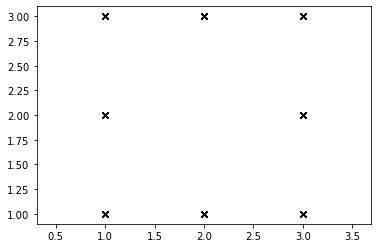

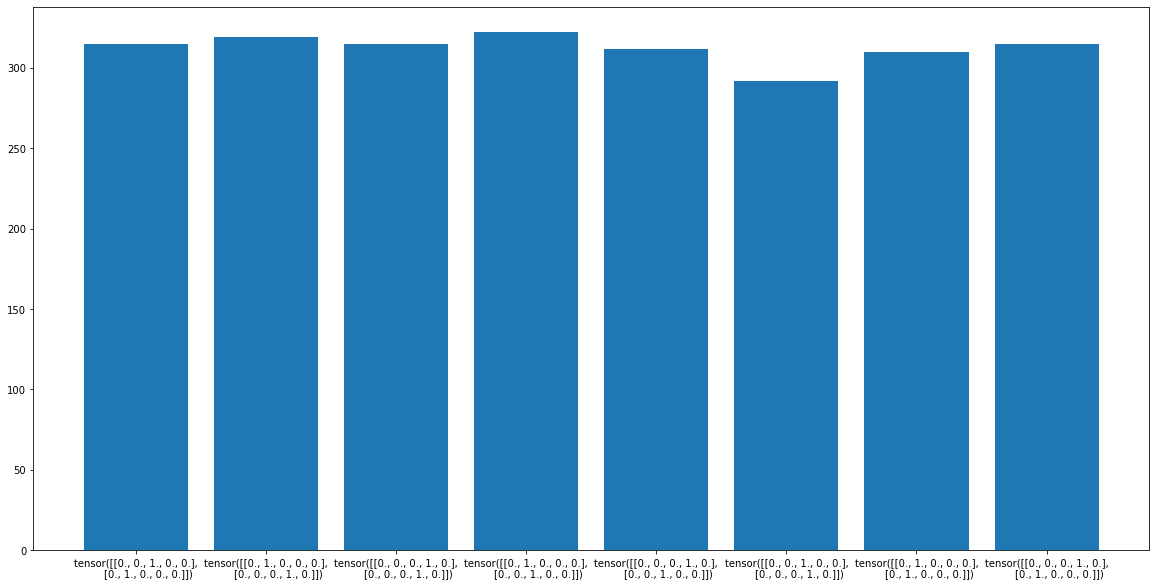

In [2]:
from loadDataset import *
from visualizer import *

data_config = {
    'name' : 'gaussian_grid',
    'n' : 5,
    'n_data' : 100,
    'sig' : 0.01
}

ds = getDataset(data_config)
dl = DataLoader(ds, batch_size=128, shuffle=True)

# gt data func, for train
def gen_real_data_onehot(dl, batch=128):

    real_samples = next(iter(dl))

    ''' delete adjacent modes from dataset '''
    mode_idx = [6,7, 8,11,13, 16, 17, 18]
    real_samples_new = [real_samples[i] for i in mode_idx]
    real_samples = real_samples_new
    
    ''' mix 25 modes '''
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2).long()

    ''' make dataset unbalanced '''
#     real_samples = real_samples[800:]
#     real_samples = real_samples[:-800]
    
    random_choice = torch.randint(0, real_samples.shape[0], (batch, )).long()
    data = real_samples[random_choice]
    data = torch.unsqueeze(data, -1)

    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

# data = gen_real_data_onehot(dl)

# gt data func, for test
def gen_real_data_test(dl, batch=128):

    real_samples = next(iter(dl))

    # mix 25 modes
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2)
    real_samples = torch.unsqueeze(real_samples, -1).long()
    
    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

def gen_input_data(batch=128):
    # https://pytorch.org/docs/stable/torch.html#torch.randn
    data = torch.zeros(int(batch/2), 2)
    data[:, 0] = 0.5
    data[:, 1] = -0.5
    return torch.cat((data, data), 0)

#     data = torch.randn(int(batch/ 2), 2)
#     return torch.cat((data, data), 0)

def gen_input_data_test(batch=128):
    return torch.randn(batch, 2)

''' Plot Distribution for Unbalanced Dataset '''

data = gen_real_data_onehot(dl, 2500)
print(torch.argmax(data,-1))
data_list = [str(x) for x in data]

# plot grid
plot_outputdata(torch.argmax(data, -1), dim1=0, dim2=1, marker='kx', alpha=0.1)

# plot bar chart
index = range(len(Counter(data_list).keys()))
plt.figure(figsize=(20,10))
plt.bar(index, Counter(data_list).values(), align='center')
plt.xticks(index, Counter(data_list).keys())

In [3]:
### Define Gumbel Function Utility

def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape).cuda()
    h = (g + logits) * temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [4]:
### G Network based on gumbel
class MLPG(nn.Module):
    
    def __init__(self, input_size, hidden_size, noise_size, output_size, temperature=1):
        super(MLPG, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3_1 = nn.Linear(hidden_size + noise_size, output_size) # x-axis
        self.map3_2 = nn.Linear(hidden_size + noise_size, output_size) # y-axis
        
        self.name = 'MLPG'
        self.noise_size = noise_size
        self.temp = temperature
        
    def forward(self, x, temperature=None):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size).cuda()

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # perform gumbel sampling
        if temperature is not None:
            x_coord = sample_gumbel_softmax(x_coord, temperature)
            y_coord = sample_gumbel_softmax(y_coord, temperature)
        else:
            x_coord = sample_gumbel_softmax(x_coord, self.temp)
            y_coord = sample_gumbel_softmax(y_coord, self.temp)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1), noise
    
    def checkLogits(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size)

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1)
    
### D Network to produce loss
class MLPD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPD, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, output_size)
        self.name = 'MLPD'
        
    def forward(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        return torch.sigmoid(self.map2(x))
    
### Create the overall network
class gumbel_gan(object):
    def __init__(self, temperature=1):
        self.g = MLPG(2, 128, 25, 5, temperature=temperature).cuda()
        self.d = MLPD(10, 128, 1).cuda()
        
        self.g_optim = optim.Adam(self.g.parameters(), lr=1e-4)
        self.d_optim = optim.Adam(self.d.parameters(), lr=1e-4)
        
        self.d_step = 1
#         self.g_step = 10
        self.g_step = 1
        self.g_NDiv = 2
        
        self.criterion = nn.BCELoss()
        
    def train(self, epoch, real_data, g_input):
        print("training start")
        pbar = range(epoch)
        batch = real_data.shape[0]
        
        for ep in pbar:
            for d_index in range(self.d_step):
                
                # Train D
                self.d.zero_grad()
                
                # Train D on real
                d_real_decision = self.d(real_data)
                labels = torch.ones(d_real_decision.shape, dtype=torch.float32).cuda()
                d_real_loss = self.criterion(d_real_decision, labels)
                
                # Train D on fake
                fake_data, latent_samples = self.g(g_input)
                d_fake_decision = self.d(fake_data.view(batch, -1))
                labels = torch.zeros(d_fake_decision.shape, dtype=torch.float32).cuda()
                
                d_fake_loss = self.criterion(d_fake_decision, labels)

                # calc loss for D
                d_loss = 0.5 * (d_real_loss + d_fake_loss)
#                 d_loss = 0.5 * (d_real_loss + d_fake_loss)
                d_loss.backward()
                d_loss_val = d_loss.item()
                
                # update D
                self.d_optim.step()
                
            """ optim NDiv diversity """
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                # print(latent_samples.shape)
                # raise
                div_loss = NDiv_loss(latent_samples, g_fake_data) * 1e2
                div_loss_val = div_loss.item()
                
                # update G w.r.t NDiv
#                 div_loss.backward()
#                 self.g_optim.step()
                
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                batch = g_fake_data.shape[0]
                
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                
                # G loss
                labels = torch.ones(g_fake_decision.shape, dtype=torch.float32).cuda()
                g_loss = -(g_fake_decision.log() * labels + (1-labels)*(1-g_fake_decision.log())).mean()
                
                g_loss_val = g_loss.item()
                
                g_loss.backward()
                
                # update G
                self.g_optim.step()
                
            print("Iteration {}, d real/fake loss {}/{} and g loss is {}, NDiv loss {}".format(ep, d_real_loss.item(), \
                                                                                 d_fake_loss.item(), g_loss, div_loss_val))            

In [5]:
## Init the simple Network
## Define temperature here
net = gumbel_gan(temperature=1000)
print(net.g, net.d)

MLPG(
  (map1): Linear(in_features=2, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=128, bias=True)
  (map3_1): Linear(in_features=153, out_features=5, bias=True)
  (map3_2): Linear(in_features=153, out_features=5, bias=True)
) MLPD(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=1, bias=True)
)


Processing Epoch 0
training start
Iteration 0, d real/fake loss 0.8251690864562988/0.6057097315788269 and g loss is 0.800149142742157, NDiv loss 0.032639358192682266
Iteration 1, d real/fake loss 0.8239761590957642/0.6038152575492859 and g loss is 0.7935155630111694, NDiv loss 0.03510342910885811
Iteration 2, d real/fake loss 0.8227840065956116/0.6034600734710693 and g loss is 0.7956213355064392, NDiv loss 0.033273760229349136
Iteration 3, d real/fake loss 0.8215920329093933/0.6009402275085449 and g loss is 0.7988063097000122, NDiv loss 0.03088255412876606
Iteration 4, d real/fake loss 0.8203845620155334/0.604253351688385 and g loss is 0.7845243215560913, NDiv loss 0.031414978206157684


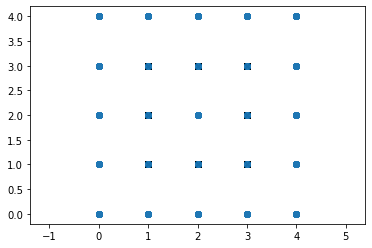

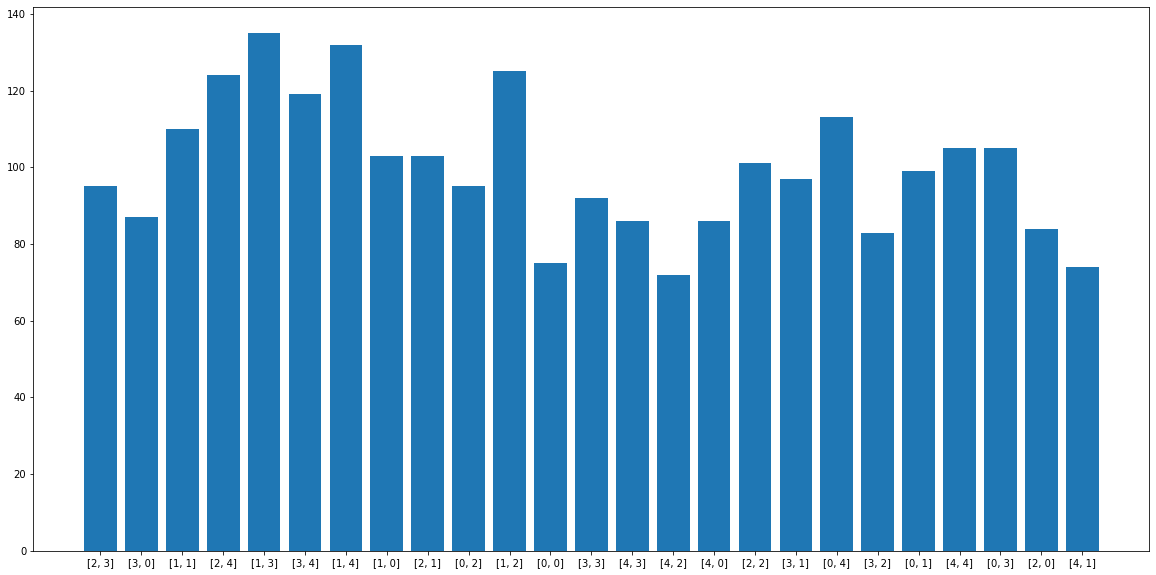

Processing Epoch 1
training start
Iteration 0, d real/fake loss 0.8362438678741455/0.6084494590759277 and g loss is 0.7862356305122375, NDiv loss 0.03213877975940704
Iteration 1, d real/fake loss 0.8350294828414917/0.6056257486343384 and g loss is 0.788393497467041, NDiv loss 0.03377847746014595
Iteration 2, d real/fake loss 0.8338209986686707/0.6044896245002747 and g loss is 0.7905714511871338, NDiv loss 0.03207319974899292
Iteration 3, d real/fake loss 0.8326084017753601/0.6063514947891235 and g loss is 0.7904921770095825, NDiv loss 0.031003490090370178
Iteration 4, d real/fake loss 0.8314006328582764/0.6065831184387207 and g loss is 0.7904660701751709, NDiv loss 0.03174494951963425


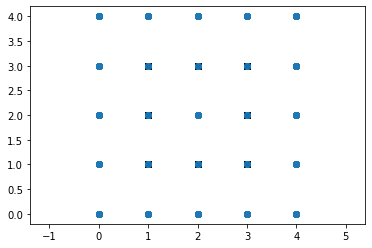

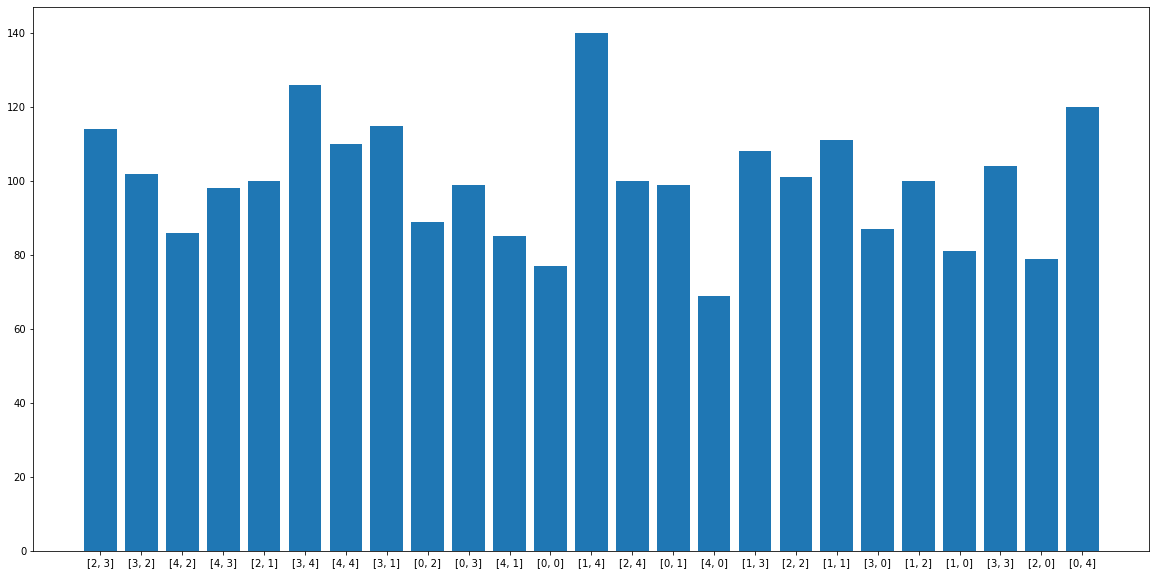

Processing Epoch 2
training start
Iteration 0, d real/fake loss 0.8249830007553101/0.6049966812133789 and g loss is 0.796269416809082, NDiv loss 0.032099995762109756
Iteration 1, d real/fake loss 0.823801577091217/0.6054366230964661 and g loss is 0.7858154773712158, NDiv loss 0.030423566699028015
Iteration 2, d real/fake loss 0.8226166367530823/0.6103882789611816 and g loss is 0.7897484302520752, NDiv loss 0.03146492689847946
Iteration 3, d real/fake loss 0.8214343190193176/0.6016197800636292 and g loss is 0.7846404314041138, NDiv loss 0.031595297157764435
Iteration 4, d real/fake loss 0.8202518224716187/0.6123687028884888 and g loss is 0.7855069637298584, NDiv loss 0.031999047845602036


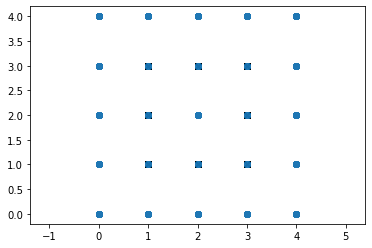

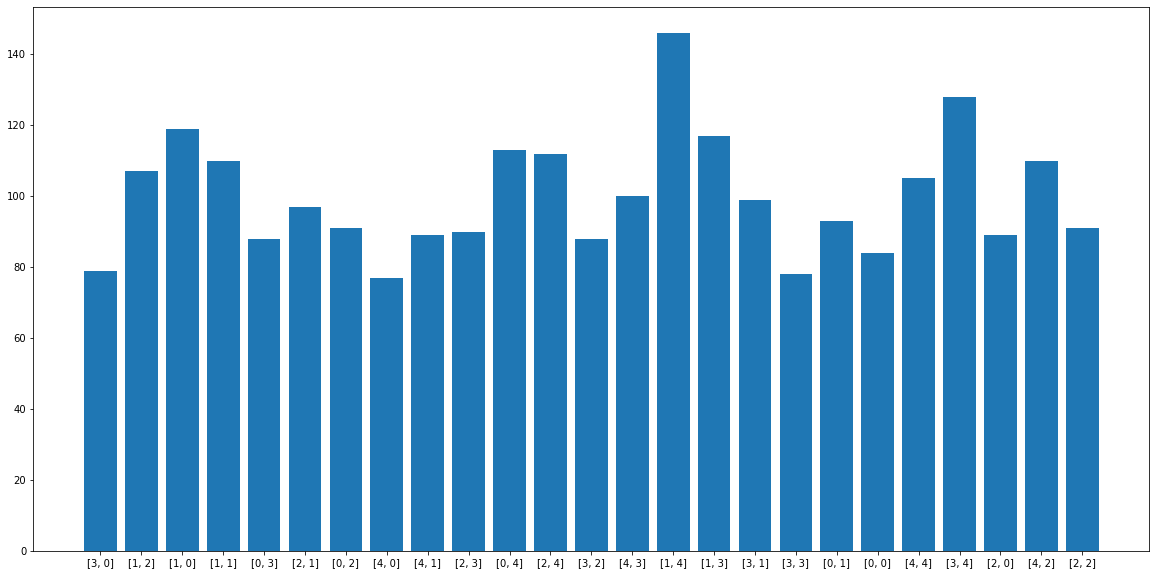

Processing Epoch 3
training start
Iteration 0, d real/fake loss 0.8137459754943848/0.6181721091270447 and g loss is 0.7871274948120117, NDiv loss 0.03175533935427666
Iteration 1, d real/fake loss 0.8125840425491333/0.6106535196304321 and g loss is 0.7851860523223877, NDiv loss 0.03490699827671051
Iteration 2, d real/fake loss 0.8114264607429504/0.6095670461654663 and g loss is 0.7830417156219482, NDiv loss 0.03391512483358383
Iteration 3, d real/fake loss 0.8102713823318481/0.6005647778511047 and g loss is 0.7754712104797363, NDiv loss 0.03334442153573036
Iteration 4, d real/fake loss 0.8091197609901428/0.6087728142738342 and g loss is 0.7891827821731567, NDiv loss 0.03497650846838951


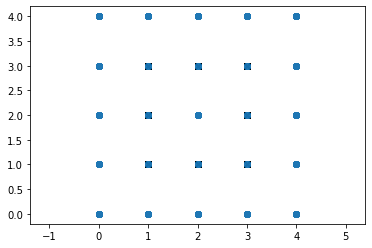

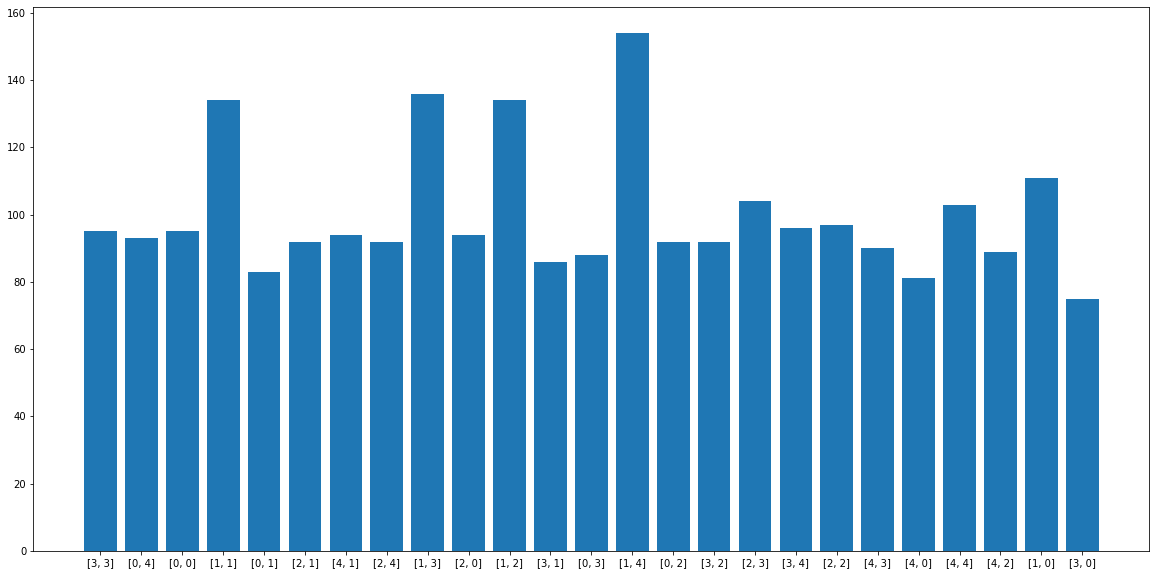

Processing Epoch 4
training start
Iteration 0, d real/fake loss 0.8091406226158142/0.6166069507598877 and g loss is 0.7842432260513306, NDiv loss 0.03154987096786499
Iteration 1, d real/fake loss 0.8080174922943115/0.6161794662475586 and g loss is 0.78593909740448, NDiv loss 0.03415171429514885
Iteration 2, d real/fake loss 0.8068990111351013/0.6193771362304688 and g loss is 0.7808183431625366, NDiv loss 0.032924018800258636
Iteration 3, d real/fake loss 0.8057925701141357/0.6095635294914246 and g loss is 0.7832748889923096, NDiv loss 0.031150173395872116
Iteration 4, d real/fake loss 0.8046862483024597/0.6230055093765259 and g loss is 0.7854425311088562, NDiv loss 0.03260444104671478


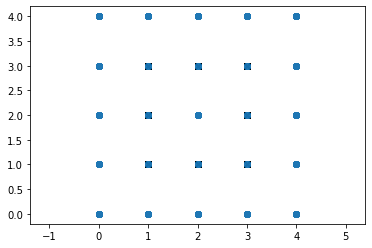

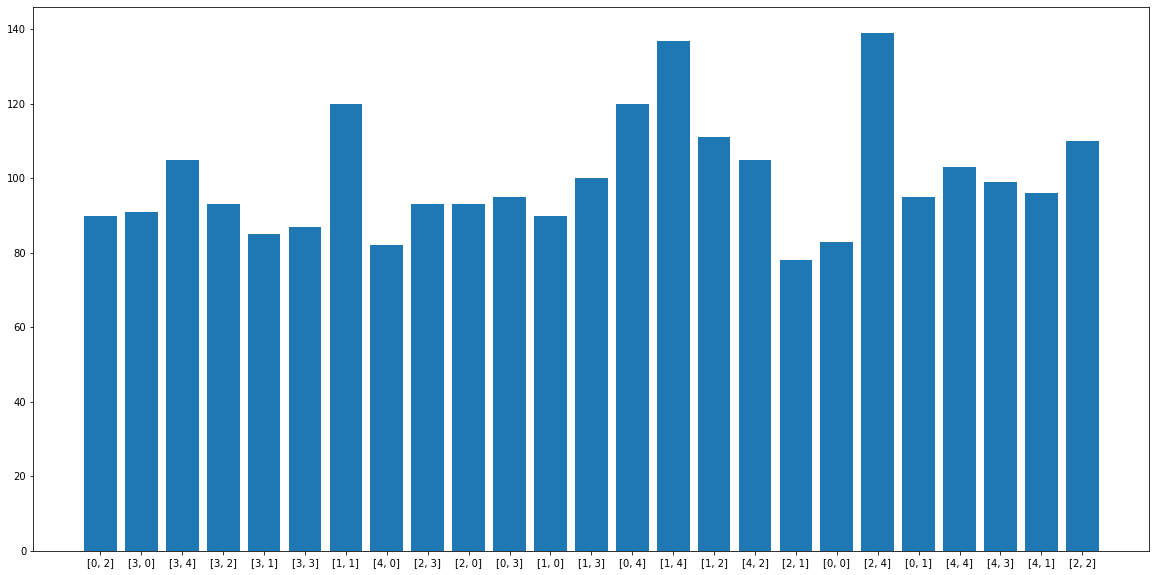

Processing Epoch 5
training start
Iteration 0, d real/fake loss 0.8005674481391907/0.6262927055358887 and g loss is 0.7846367359161377, NDiv loss 0.03147592768073082
Iteration 1, d real/fake loss 0.7994904518127441/0.6173572540283203 and g loss is 0.7777020335197449, NDiv loss 0.03421604633331299
Iteration 2, d real/fake loss 0.7984200119972229/0.6152264475822449 and g loss is 0.7858918905258179, NDiv loss 0.03157241269946098
Iteration 3, d real/fake loss 0.7973470091819763/0.6211651563644409 and g loss is 0.7766366600990295, NDiv loss 0.03130347281694412
Iteration 4, d real/fake loss 0.7962825298309326/0.6232739686965942 and g loss is 0.7823238372802734, NDiv loss 0.03351356089115143


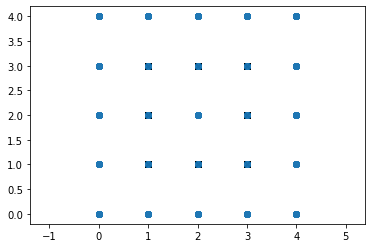

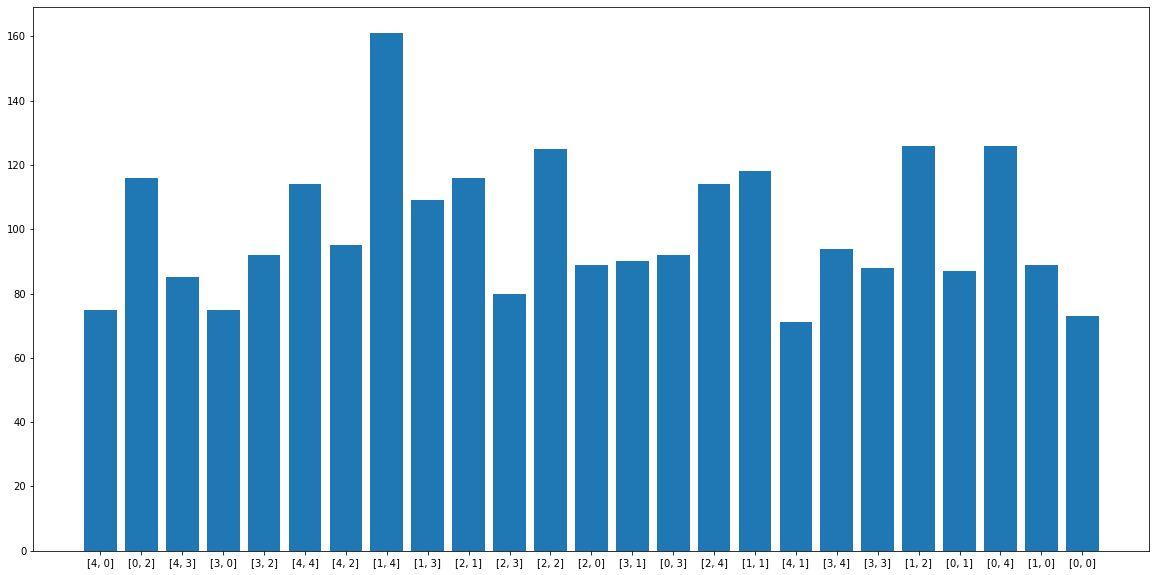

Processing Epoch 6
training start
Iteration 0, d real/fake loss 0.7978836894035339/0.6159541606903076 and g loss is 0.7828278541564941, NDiv loss 0.03178545460104942
Iteration 1, d real/fake loss 0.7968378067016602/0.6219230890274048 and g loss is 0.7816612720489502, NDiv loss 0.032451894134283066
Iteration 2, d real/fake loss 0.7957937717437744/0.6149601936340332 and g loss is 0.7724257707595825, NDiv loss 0.03233136981725693
Iteration 3, d real/fake loss 0.7947511672973633/0.6206680536270142 and g loss is 0.774063766002655, NDiv loss 0.032995518296957016
Iteration 4, d real/fake loss 0.79371178150177/0.6158167719841003 and g loss is 0.7764707207679749, NDiv loss 0.0340644009411335


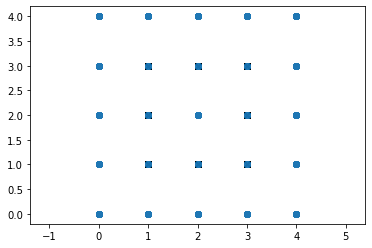

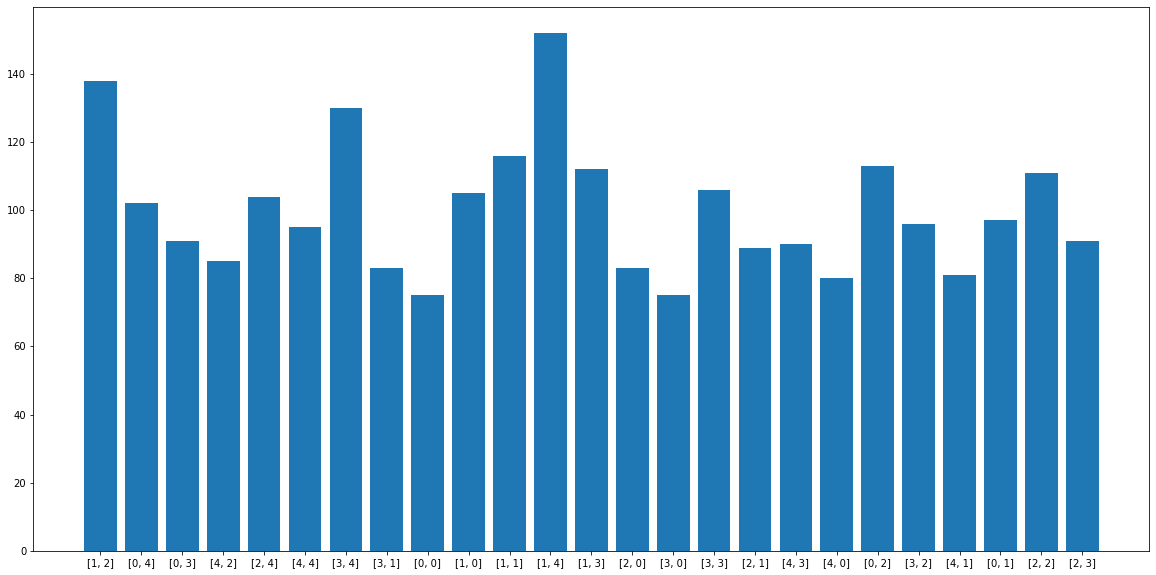

Processing Epoch 7
training start
Iteration 0, d real/fake loss 0.790961503982544/0.6188188791275024 and g loss is 0.779401957988739, NDiv loss 0.03482566028833389
Iteration 1, d real/fake loss 0.789932906627655/0.6204316020011902 and g loss is 0.7718409299850464, NDiv loss 0.03316745162010193
Iteration 2, d real/fake loss 0.788906455039978/0.6142873764038086 and g loss is 0.7710697054862976, NDiv loss 0.03504161164164543
Iteration 3, d real/fake loss 0.7878834009170532/0.6266124248504639 and g loss is 0.7771289944648743, NDiv loss 0.03155756741762161
Iteration 4, d real/fake loss 0.786861777305603/0.6239129304885864 and g loss is 0.7798331379890442, NDiv loss 0.033368706703186035


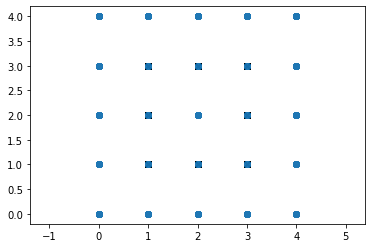

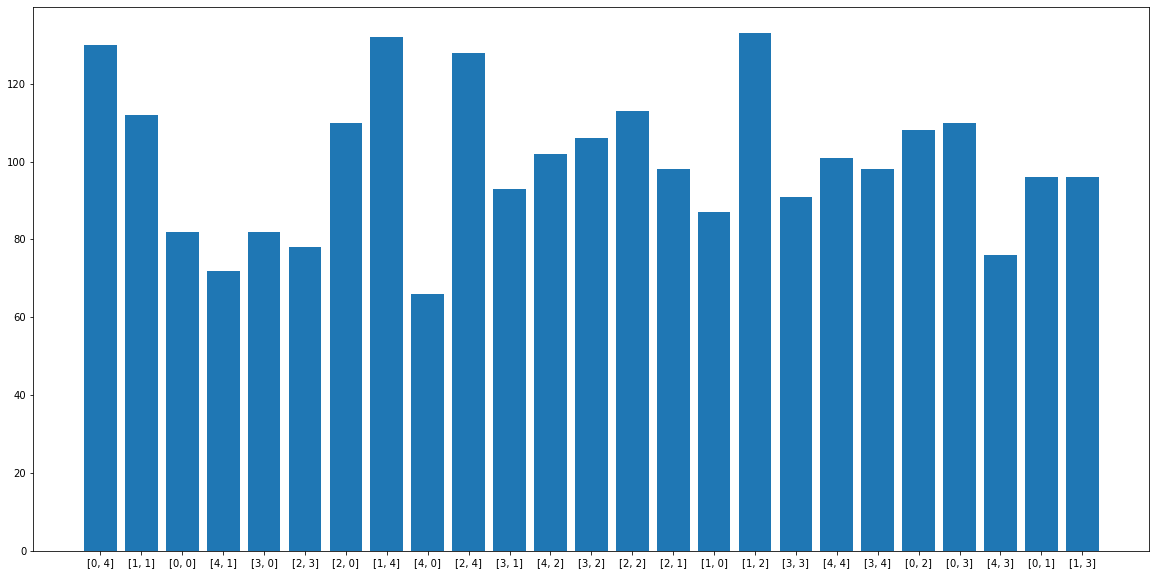

Processing Epoch 8
training start
Iteration 0, d real/fake loss 0.7916038036346436/0.6222918629646301 and g loss is 0.7700684070587158, NDiv loss 0.03214516118168831
Iteration 1, d real/fake loss 0.7905932068824768/0.6261608600616455 and g loss is 0.7690848112106323, NDiv loss 0.03280310332775116
Iteration 2, d real/fake loss 0.7895901203155518/0.6214436888694763 and g loss is 0.7748042941093445, NDiv loss 0.03292844071984291
Iteration 3, d real/fake loss 0.7885836362838745/0.6150526404380798 and g loss is 0.769923210144043, NDiv loss 0.03349120542407036
Iteration 4, d real/fake loss 0.7875763773918152/0.6230160593986511 and g loss is 0.772161602973938, NDiv loss 0.03416728973388672


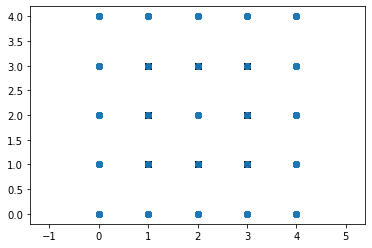

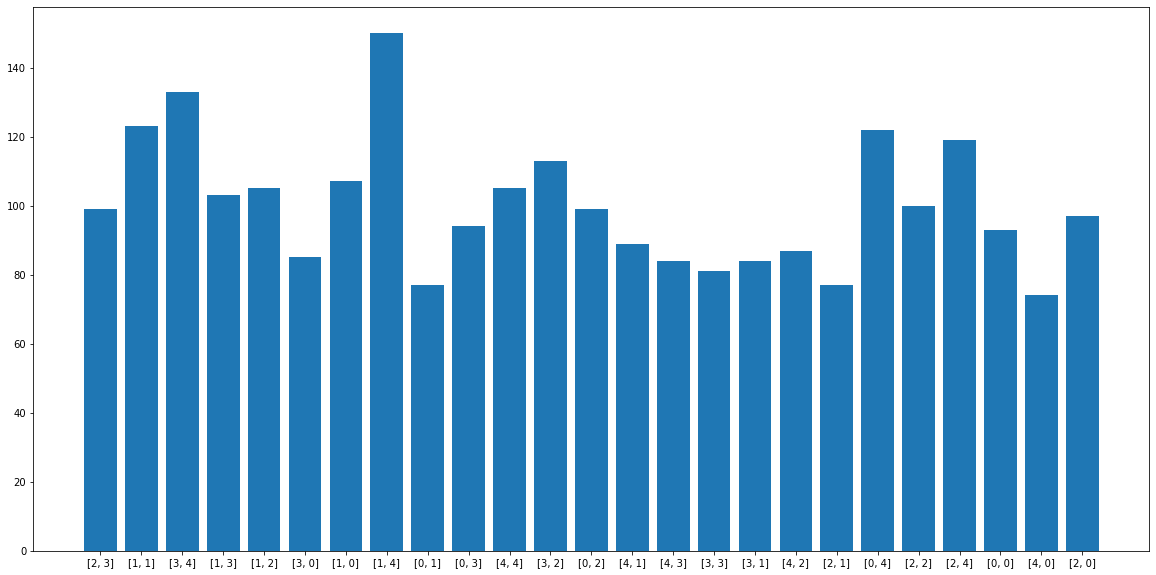

Processing Epoch 9
training start
Iteration 0, d real/fake loss 0.7811778783798218/0.616406261920929 and g loss is 0.7726813554763794, NDiv loss 0.03193412721157074
Iteration 1, d real/fake loss 0.7801830172538757/0.6240658760070801 and g loss is 0.75946044921875, NDiv loss 0.030802853405475616
Iteration 2, d real/fake loss 0.7791969776153564/0.6235384345054626 and g loss is 0.766866147518158, NDiv loss 0.033803511410951614
Iteration 3, d real/fake loss 0.7782113552093506/0.6253829598426819 and g loss is 0.7745592594146729, NDiv loss 0.031349677592515945
Iteration 4, d real/fake loss 0.7772358655929565/0.6238844394683838 and g loss is 0.7724131345748901, NDiv loss 0.031800560653209686


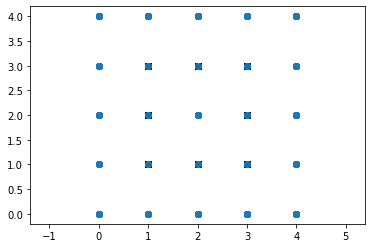

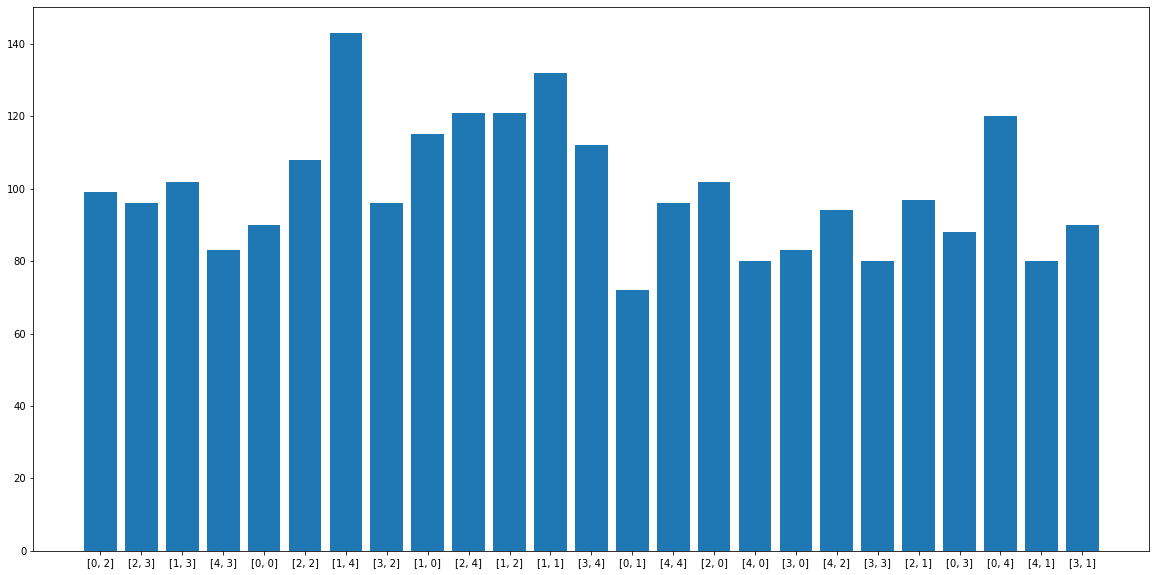

Processing Epoch 10
training start
Iteration 0, d real/fake loss 0.7833719253540039/0.6307021975517273 and g loss is 0.7763229608535767, NDiv loss 0.032260868698358536
Iteration 1, d real/fake loss 0.7824056148529053/0.6254273653030396 and g loss is 0.7717899084091187, NDiv loss 0.03245555981993675
Iteration 2, d real/fake loss 0.7814415693283081/0.6234431862831116 and g loss is 0.7622652053833008, NDiv loss 0.030140042304992676
Iteration 3, d real/fake loss 0.7804816961288452/0.6239939332008362 and g loss is 0.7650399208068848, NDiv loss 0.03372674807906151
Iteration 4, d real/fake loss 0.779522716999054/0.6293923854827881 and g loss is 0.76063072681427, NDiv loss 0.03142400458455086


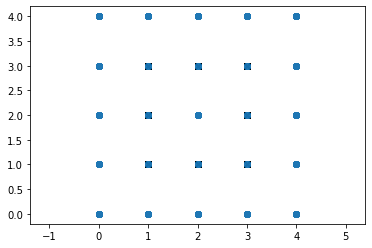

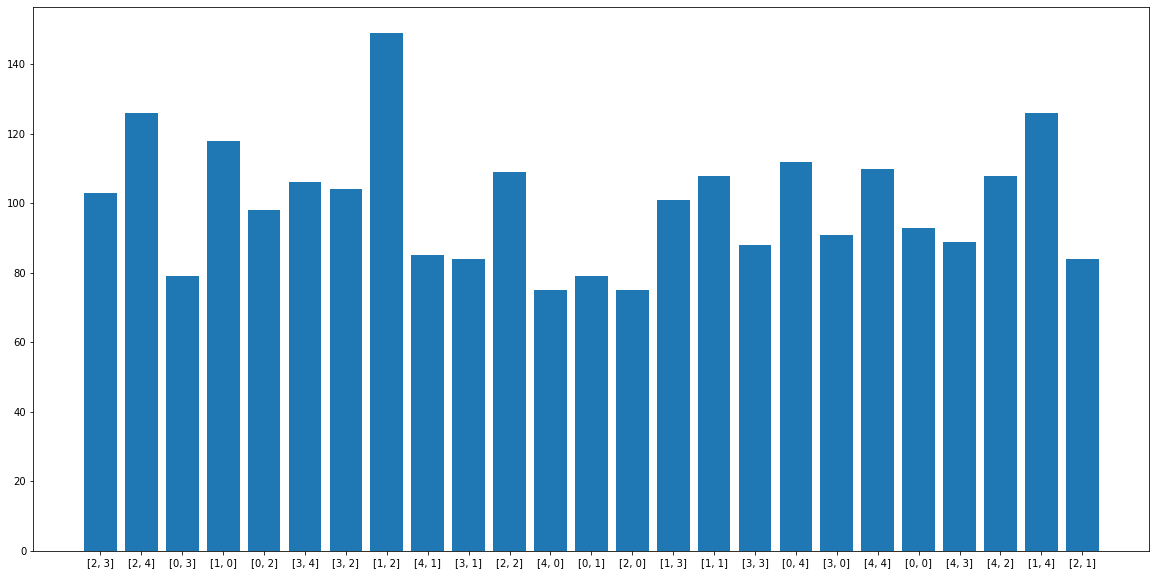

Processing Epoch 11
training start
Iteration 0, d real/fake loss 0.7781708240509033/0.6268634796142578 and g loss is 0.7696666121482849, NDiv loss 0.032658468931913376
Iteration 1, d real/fake loss 0.7772214412689209/0.6305189728736877 and g loss is 0.7649224996566772, NDiv loss 0.0335848294198513
Iteration 2, d real/fake loss 0.7762771844863892/0.6223729848861694 and g loss is 0.7607883214950562, NDiv loss 0.031713735312223434
Iteration 3, d real/fake loss 0.7753323912620544/0.6293609142303467 and g loss is 0.7641350030899048, NDiv loss 0.03248760476708412
Iteration 4, d real/fake loss 0.774386465549469/0.6294156312942505 and g loss is 0.767044186592102, NDiv loss 0.03335389867424965


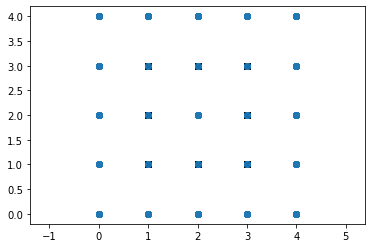

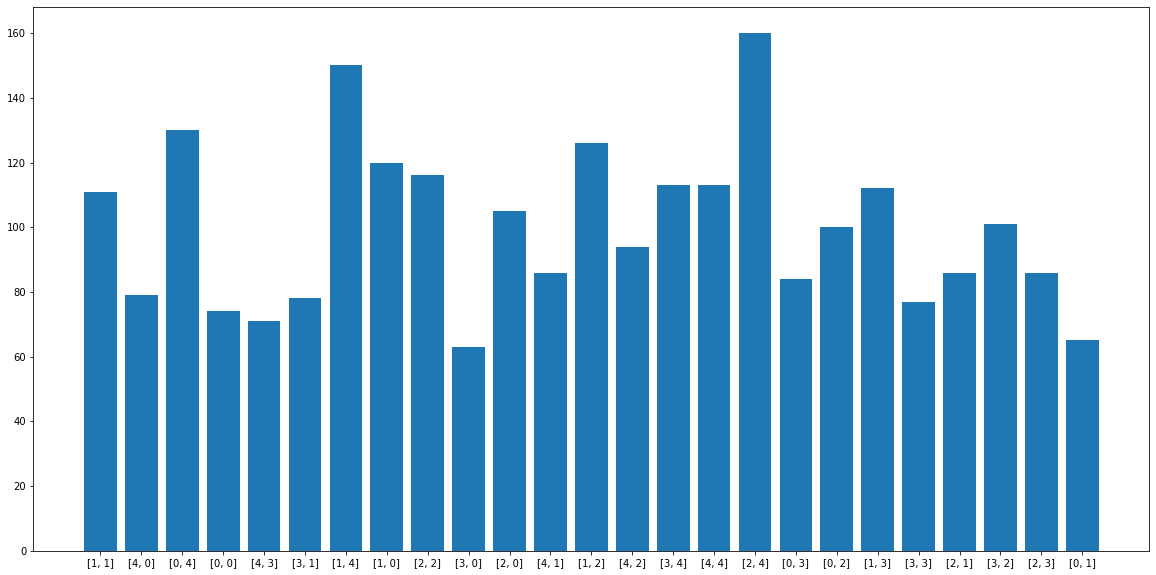

Processing Epoch 12
training start
Iteration 0, d real/fake loss 0.7770941257476807/0.6266852021217346 and g loss is 0.7728794813156128, NDiv loss 0.03358466923236847
Iteration 1, d real/fake loss 0.7761818170547485/0.6333352327346802 and g loss is 0.7667638063430786, NDiv loss 0.03232353553175926
Iteration 2, d real/fake loss 0.7752708196640015/0.6312426328659058 and g loss is 0.7707898616790771, NDiv loss 0.03320365771651268
Iteration 3, d real/fake loss 0.7743663191795349/0.624809205532074 and g loss is 0.7679481506347656, NDiv loss 0.03248802572488785
Iteration 4, d real/fake loss 0.7734611630439758/0.6315962076187134 and g loss is 0.7642720937728882, NDiv loss 0.034157827496528625


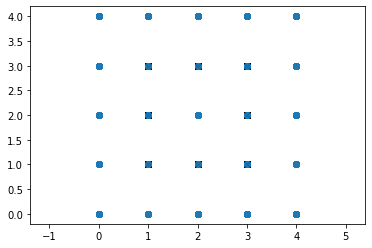

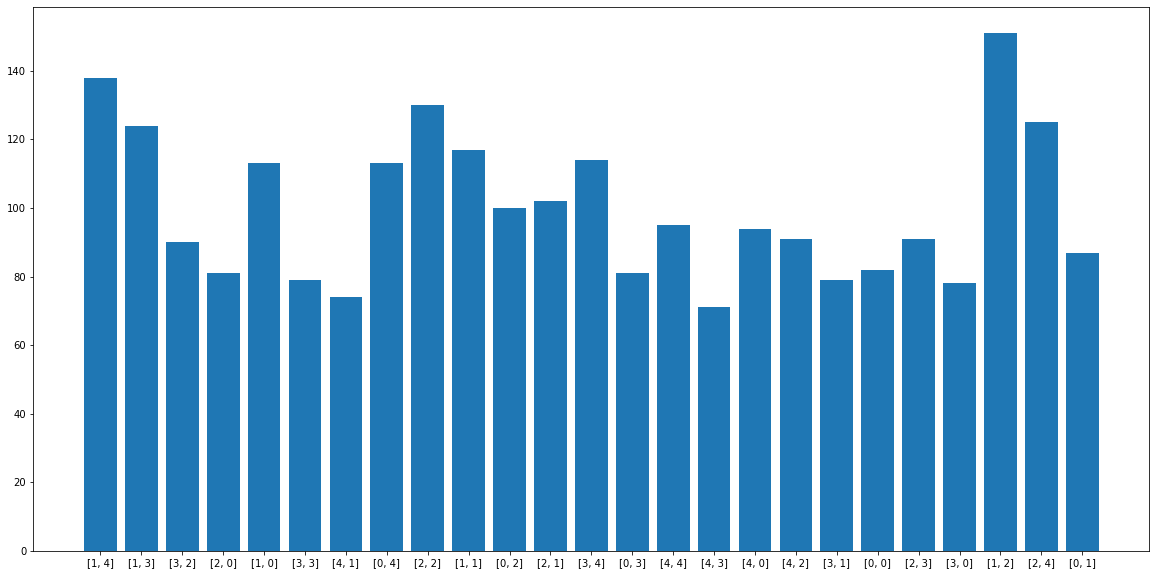

Processing Epoch 13
training start
Iteration 0, d real/fake loss 0.7672659158706665/0.6314200162887573 and g loss is 0.7716948986053467, NDiv loss 0.03258370980620384
Iteration 1, d real/fake loss 0.7664039134979248/0.6310321688652039 and g loss is 0.7633426189422607, NDiv loss 0.033096794039011
Iteration 2, d real/fake loss 0.7655478715896606/0.6326723098754883 and g loss is 0.7597382068634033, NDiv loss 0.03237904980778694
Iteration 3, d real/fake loss 0.7646971940994263/0.6265000104904175 and g loss is 0.7643946409225464, NDiv loss 0.03232730180025101
Iteration 4, d real/fake loss 0.7638452053070068/0.6359308958053589 and g loss is 0.7595767974853516, NDiv loss 0.032437872141599655


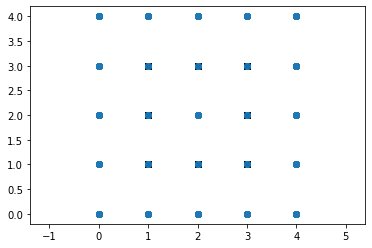

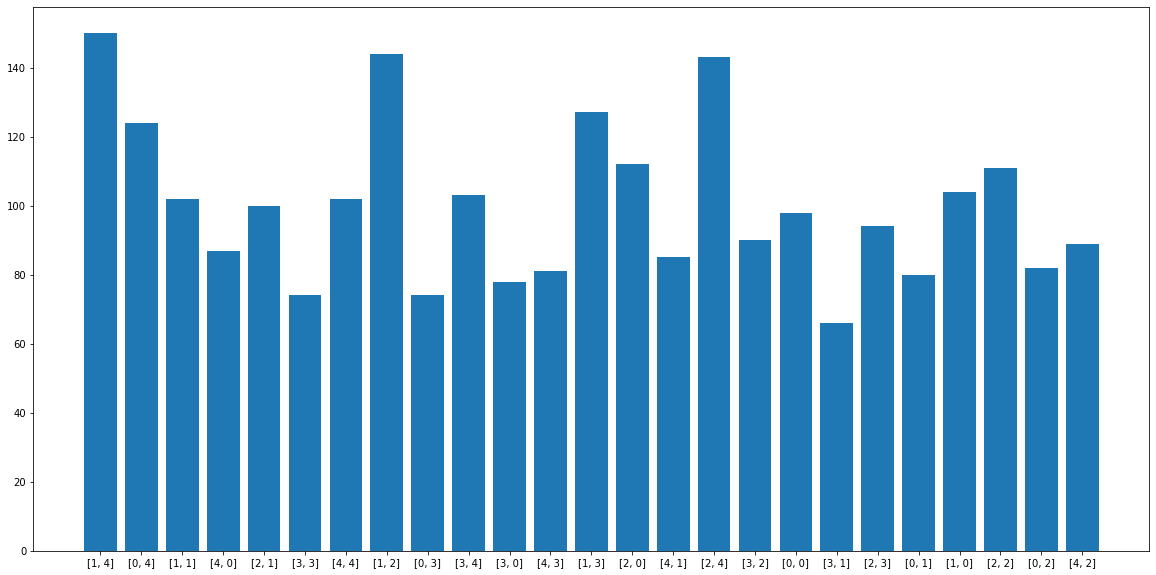

Processing Epoch 14
training start
Iteration 0, d real/fake loss 0.7609908580780029/0.6328982710838318 and g loss is 0.7579805254936218, NDiv loss 0.03288724273443222
Iteration 1, d real/fake loss 0.760128378868103/0.6324046850204468 and g loss is 0.7608331441879272, NDiv loss 0.03377324715256691
Iteration 2, d real/fake loss 0.7592635154724121/0.6301625370979309 and g loss is 0.7658117413520813, NDiv loss 0.03550560027360916
Iteration 3, d real/fake loss 0.7583987712860107/0.6333646774291992 and g loss is 0.7668311595916748, NDiv loss 0.03142750635743141
Iteration 4, d real/fake loss 0.7575403451919556/0.6295319199562073 and g loss is 0.7612646818161011, NDiv loss 0.036733172833919525


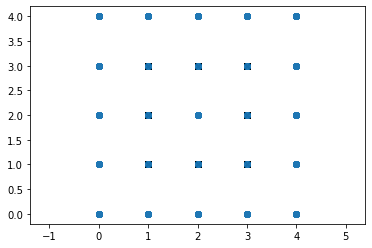

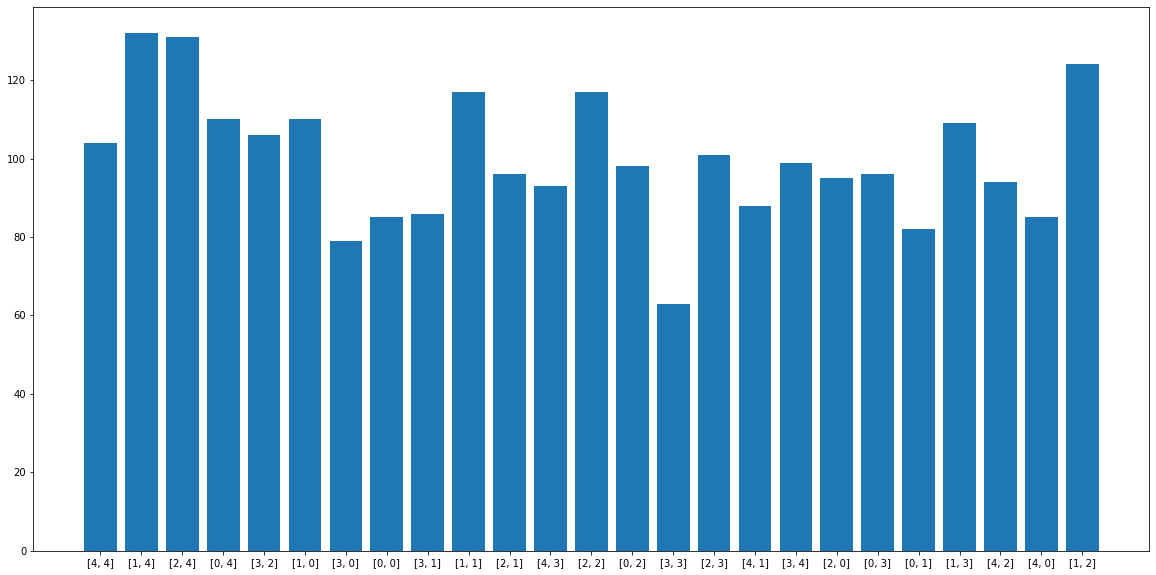

Processing Epoch 15
training start
Iteration 0, d real/fake loss 0.7574945688247681/0.6346358060836792 and g loss is 0.758551836013794, NDiv loss 0.03188074380159378
Iteration 1, d real/fake loss 0.7566689848899841/0.6264634132385254 and g loss is 0.7667384147644043, NDiv loss 0.031401872634887695
Iteration 2, d real/fake loss 0.7558345794677734/0.636216402053833 and g loss is 0.7597389221191406, NDiv loss 0.03138285130262375
Iteration 3, d real/fake loss 0.7550055980682373/0.6358155608177185 and g loss is 0.7565468549728394, NDiv loss 0.033987000584602356
Iteration 4, d real/fake loss 0.7541805505752563/0.6342089772224426 and g loss is 0.7586607933044434, NDiv loss 0.034832663834095


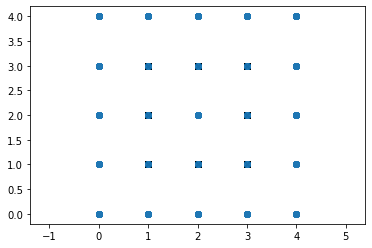

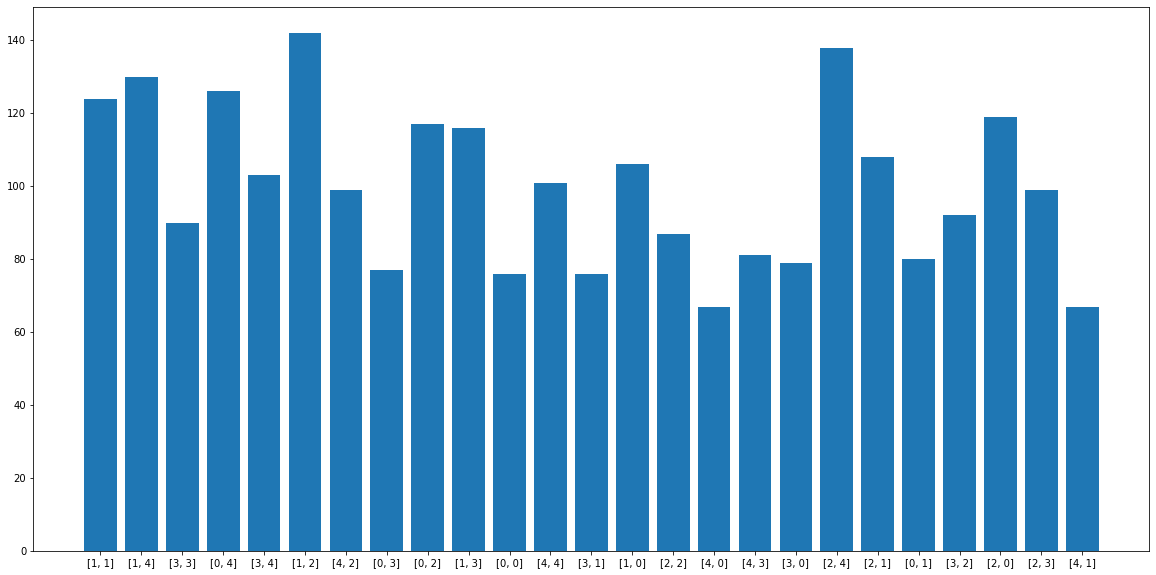

Processing Epoch 16
training start
Iteration 0, d real/fake loss 0.7491310834884644/0.63449627161026 and g loss is 0.7567039728164673, NDiv loss 0.031018786132335663
Iteration 1, d real/fake loss 0.7483219504356384/0.63954097032547 and g loss is 0.7602665424346924, NDiv loss 0.033660512417554855
Iteration 2, d real/fake loss 0.7475274205207825/0.6285260319709778 and g loss is 0.7552626729011536, NDiv loss 0.036562979221343994
Iteration 3, d real/fake loss 0.7467337250709534/0.633814811706543 and g loss is 0.7556642293930054, NDiv loss 0.033309079706668854
Iteration 4, d real/fake loss 0.7459406852722168/0.6343136429786682 and g loss is 0.7620875239372253, NDiv loss 0.03157222643494606


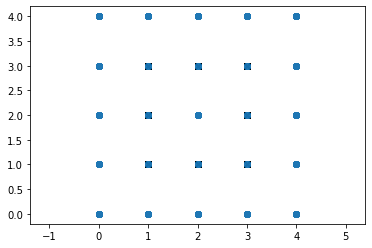

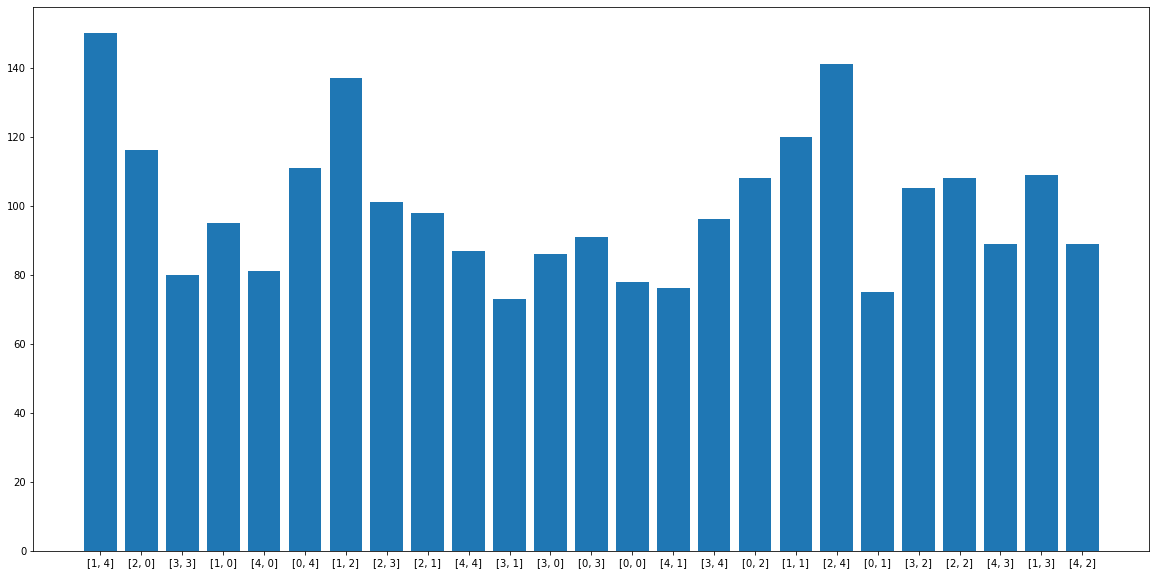

Processing Epoch 17
training start
Iteration 0, d real/fake loss 0.7467041015625/0.633275032043457 and g loss is 0.7533150911331177, NDiv loss 0.03330272436141968
Iteration 1, d real/fake loss 0.7459231615066528/0.6400821208953857 and g loss is 0.7577057480812073, NDiv loss 0.032545365393161774
Iteration 2, d real/fake loss 0.7451456785202026/0.6308562755584717 and g loss is 0.7547277808189392, NDiv loss 0.03447636961936951
Iteration 3, d real/fake loss 0.7443609237670898/0.6324753761291504 and g loss is 0.7547625303268433, NDiv loss 0.031149955466389656
Iteration 4, d real/fake loss 0.743574857711792/0.6373775005340576 and g loss is 0.7494960427284241, NDiv loss 0.031816598027944565


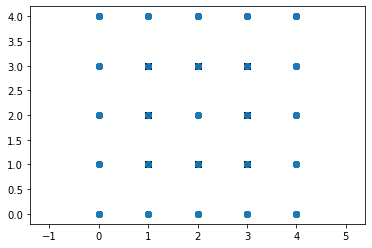

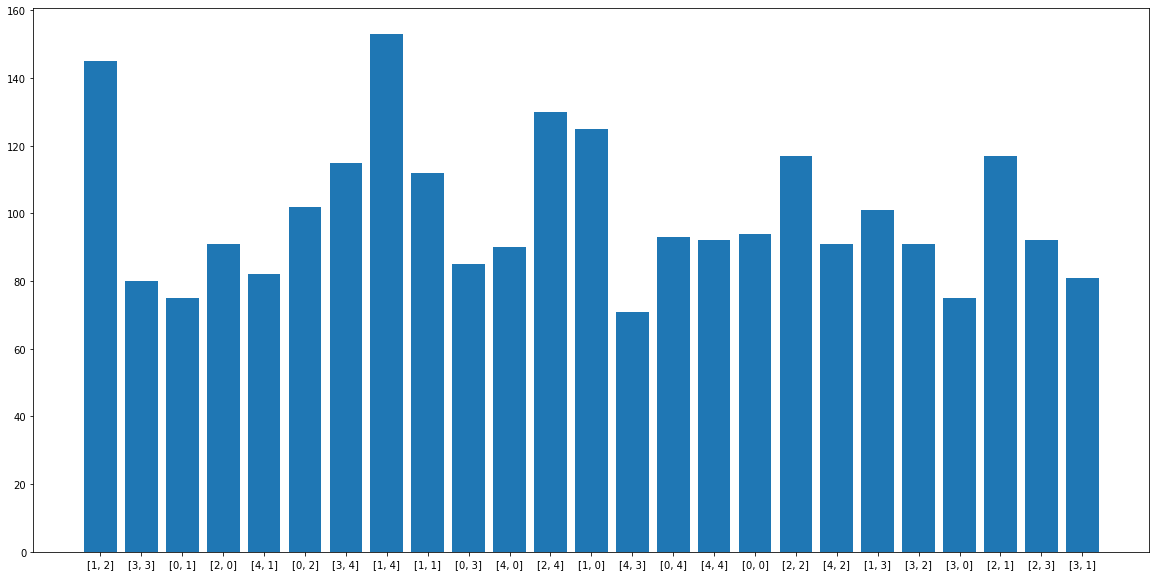

Processing Epoch 18
training start
Iteration 0, d real/fake loss 0.748571515083313/0.6402415633201599 and g loss is 0.7472484707832336, NDiv loss 0.03619256988167763
Iteration 1, d real/fake loss 0.7478201985359192/0.6299920678138733 and g loss is 0.7589280605316162, NDiv loss 0.033585332334041595
Iteration 2, d real/fake loss 0.7470583319664001/0.6478028297424316 and g loss is 0.7502976655960083, NDiv loss 0.03057842329144478
Iteration 3, d real/fake loss 0.7463109493255615/0.6367349624633789 and g loss is 0.7454016208648682, NDiv loss 0.03377129137516022
Iteration 4, d real/fake loss 0.745560348033905/0.643081784248352 and g loss is 0.7542850375175476, NDiv loss 0.03275129944086075


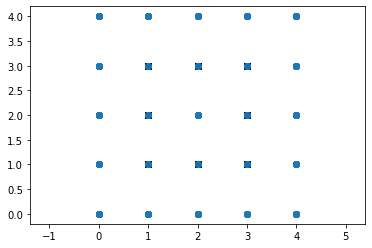

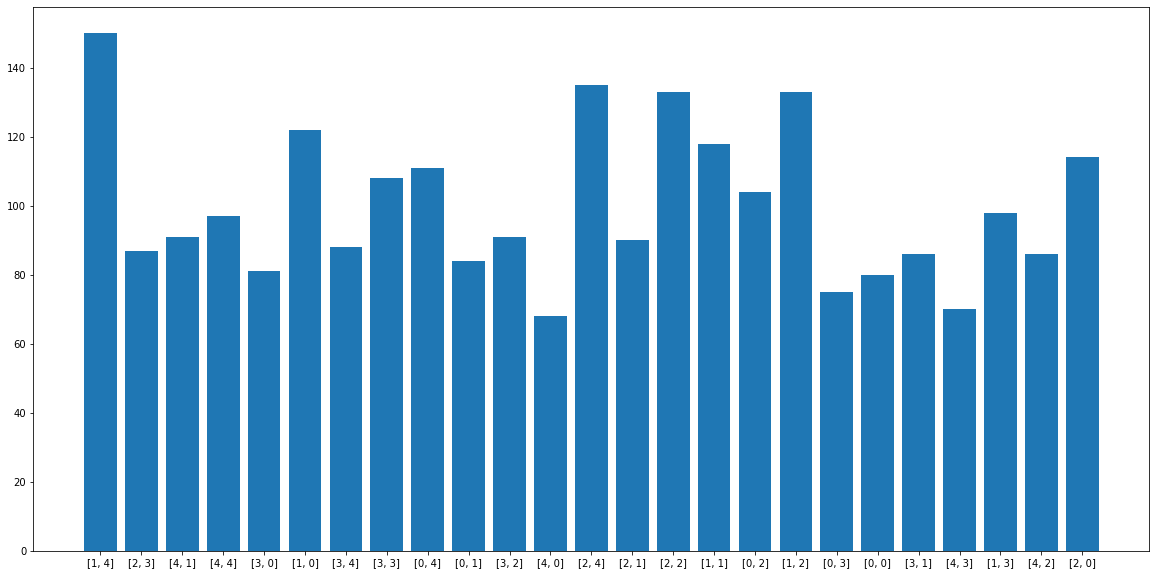

Processing Epoch 19
training start
Iteration 0, d real/fake loss 0.7487766742706299/0.6379644870758057 and g loss is 0.7506095170974731, NDiv loss 0.03595620393753052
Iteration 1, d real/fake loss 0.7480143308639526/0.6420944929122925 and g loss is 0.750525176525116, NDiv loss 0.03590327873826027
Iteration 2, d real/fake loss 0.7472596168518066/0.6413267254829407 and g loss is 0.7581017017364502, NDiv loss 0.030445536598563194
Iteration 3, d real/fake loss 0.7465115189552307/0.6463870406150818 and g loss is 0.748238205909729, NDiv loss 0.03326241299510002
Iteration 4, d real/fake loss 0.7457691431045532/0.6429394483566284 and g loss is 0.7475643157958984, NDiv loss 0.03312698379158974


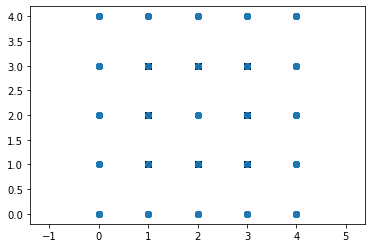

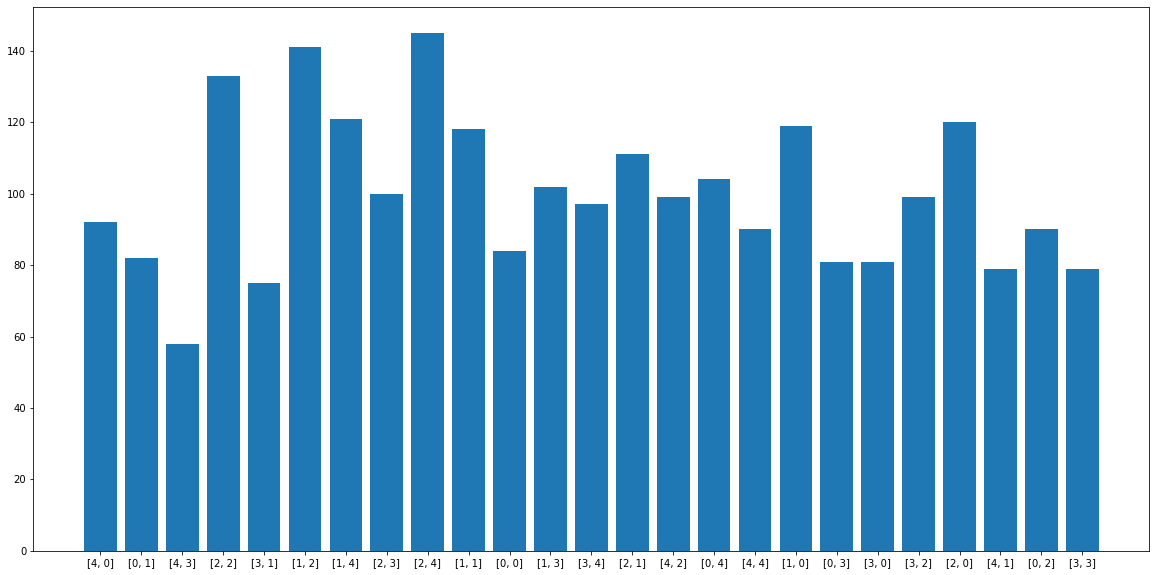

Processing Epoch 20
training start
Iteration 0, d real/fake loss 0.7411153316497803/0.6379696130752563 and g loss is 0.7426576614379883, NDiv loss 0.03319602832198143
Iteration 1, d real/fake loss 0.7404177188873291/0.6388190984725952 and g loss is 0.7543761730194092, NDiv loss 0.03539478778839111
Iteration 2, d real/fake loss 0.739712655544281/0.6459101438522339 and g loss is 0.754144549369812, NDiv loss 0.03478795289993286
Iteration 3, d real/fake loss 0.7390127778053284/0.6403772830963135 and g loss is 0.7528978586196899, NDiv loss 0.032813455909490585
Iteration 4, d real/fake loss 0.7383102178573608/0.6447752714157104 and g loss is 0.7584455609321594, NDiv loss 0.03582660108804703


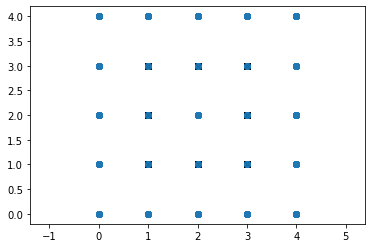

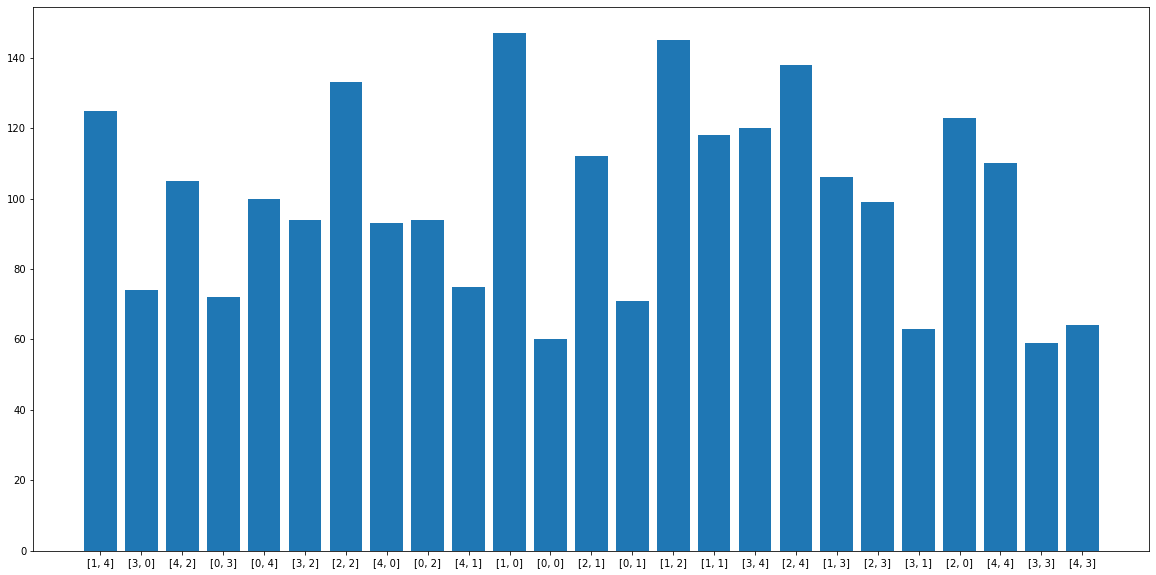

Processing Epoch 21
training start
Iteration 0, d real/fake loss 0.7394344210624695/0.6396698951721191 and g loss is 0.7567728757858276, NDiv loss 0.032807979732751846
Iteration 1, d real/fake loss 0.7387337684631348/0.6497843861579895 and g loss is 0.7558292746543884, NDiv loss 0.034268997609615326
Iteration 2, d real/fake loss 0.7380419969558716/0.6415553092956543 and g loss is 0.7518564462661743, NDiv loss 0.03199470788240433
Iteration 3, d real/fake loss 0.7373476028442383/0.6427285075187683 and g loss is 0.753502368927002, NDiv loss 0.033369071781635284
Iteration 4, d real/fake loss 0.7366588711738586/0.6475545167922974 and g loss is 0.7377939820289612, NDiv loss 0.034563418477773666


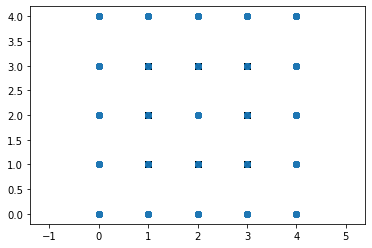

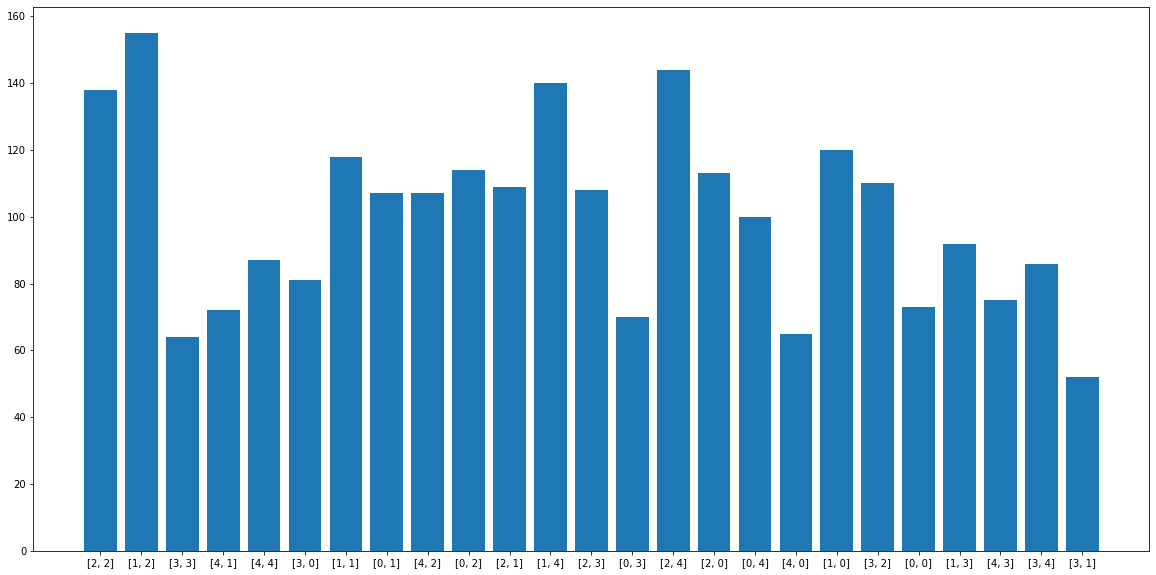

Processing Epoch 22
training start
Iteration 0, d real/fake loss 0.7330451011657715/0.6462197303771973 and g loss is 0.744828462600708, NDiv loss 0.03135528787970543
Iteration 1, d real/fake loss 0.7323758602142334/0.6457140445709229 and g loss is 0.7389846444129944, NDiv loss 0.03276754170656204
Iteration 2, d real/fake loss 0.731709361076355/0.6421219110488892 and g loss is 0.7465826272964478, NDiv loss 0.03577406331896782
Iteration 3, d real/fake loss 0.7310432195663452/0.6448454260826111 and g loss is 0.7424792051315308, NDiv loss 0.03208397701382637
Iteration 4, d real/fake loss 0.7303788661956787/0.6478759050369263 and g loss is 0.7530104517936707, NDiv loss 0.031918443739414215


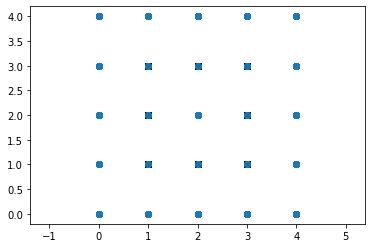

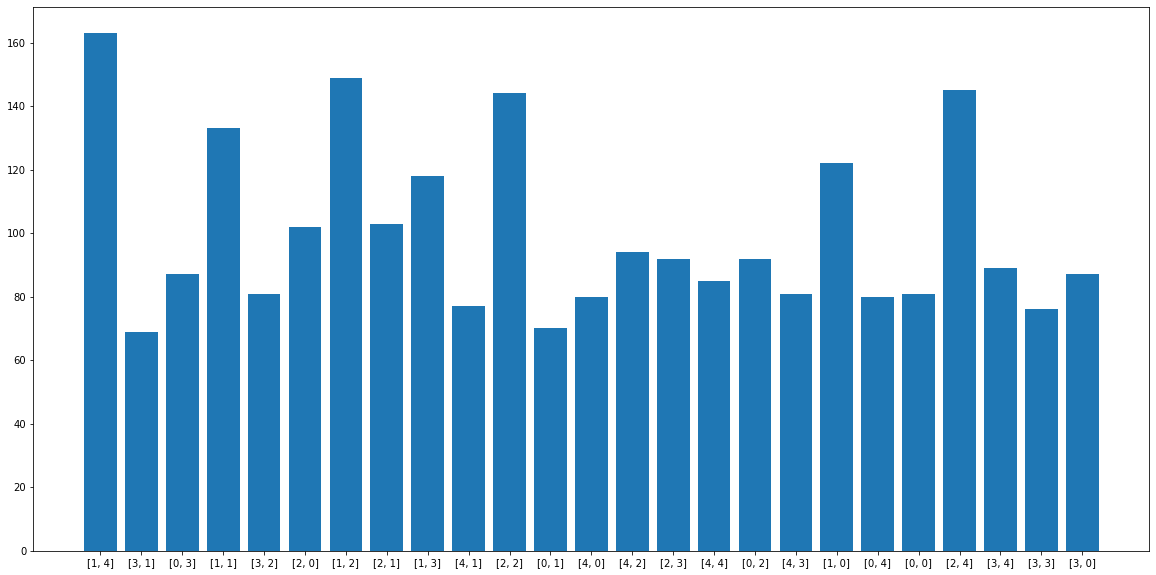

Processing Epoch 23
training start
Iteration 0, d real/fake loss 0.7237472534179688/0.6364277601242065 and g loss is 0.7498118877410889, NDiv loss 0.033686086535453796
Iteration 1, d real/fake loss 0.7231180667877197/0.6381206512451172 and g loss is 0.749267578125, NDiv loss 0.0330468975007534
Iteration 2, d real/fake loss 0.7224880456924438/0.648460328578949 and g loss is 0.74223393201828, NDiv loss 0.031702425330877304
Iteration 3, d real/fake loss 0.721867561340332/0.6415270566940308 and g loss is 0.7427387237548828, NDiv loss 0.03160262852907181
Iteration 4, d real/fake loss 0.7212418913841248/0.6441338062286377 and g loss is 0.7483444809913635, NDiv loss 0.030928917229175568


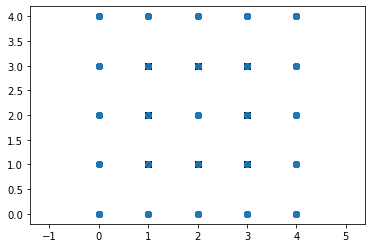

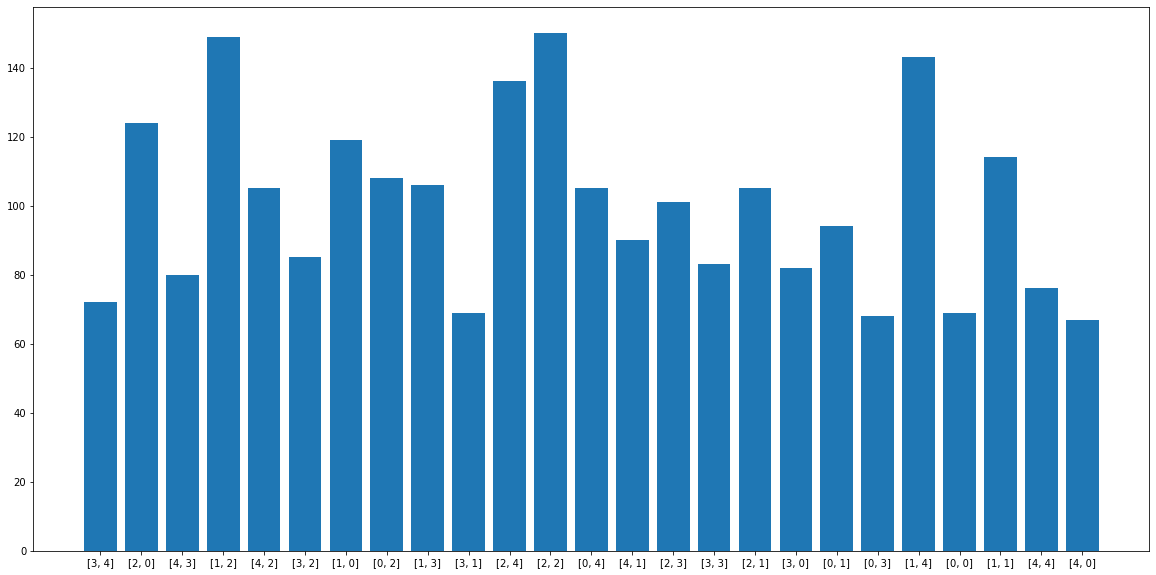

Processing Epoch 24
training start
Iteration 0, d real/fake loss 0.7265844345092773/0.6446580290794373 and g loss is 0.7382833957672119, NDiv loss 0.0357382632791996
Iteration 1, d real/fake loss 0.7259877920150757/0.6413501501083374 and g loss is 0.7522470951080322, NDiv loss 0.036431729793548584
Iteration 2, d real/fake loss 0.7253861427307129/0.6396802067756653 and g loss is 0.7393205761909485, NDiv loss 0.03647292032837868
Iteration 3, d real/fake loss 0.7247781157493591/0.6450681686401367 and g loss is 0.7473944425582886, NDiv loss 0.031944479793310165
Iteration 4, d real/fake loss 0.7241732478141785/0.6446629166603088 and g loss is 0.7405486106872559, NDiv loss 0.03675974905490875


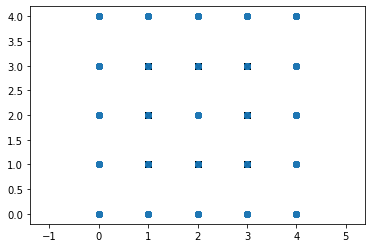

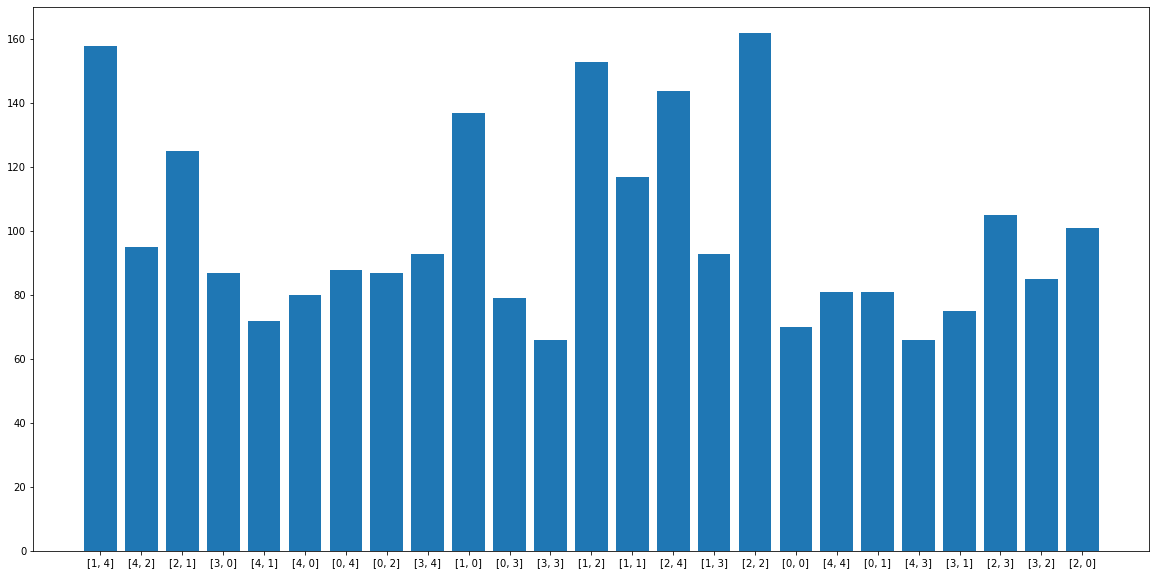

Processing Epoch 25
training start
Iteration 0, d real/fake loss 0.7298242449760437/0.6522199511528015 and g loss is 0.7424333095550537, NDiv loss 0.03277340903878212
Iteration 1, d real/fake loss 0.7292051315307617/0.6483020186424255 and g loss is 0.7476701736450195, NDiv loss 0.03263454884290695
Iteration 2, d real/fake loss 0.7285887598991394/0.6455975770950317 and g loss is 0.7370710372924805, NDiv loss 0.036328963935375214
Iteration 3, d real/fake loss 0.7279730439186096/0.6553337574005127 and g loss is 0.7461612224578857, NDiv loss 0.03303771838545799
Iteration 4, d real/fake loss 0.7273626923561096/0.6532875895500183 and g loss is 0.7467975616455078, NDiv loss 0.034101299941539764


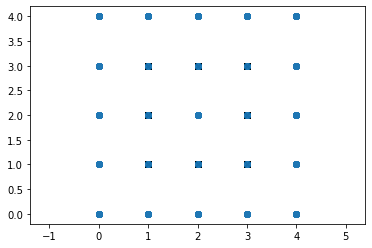

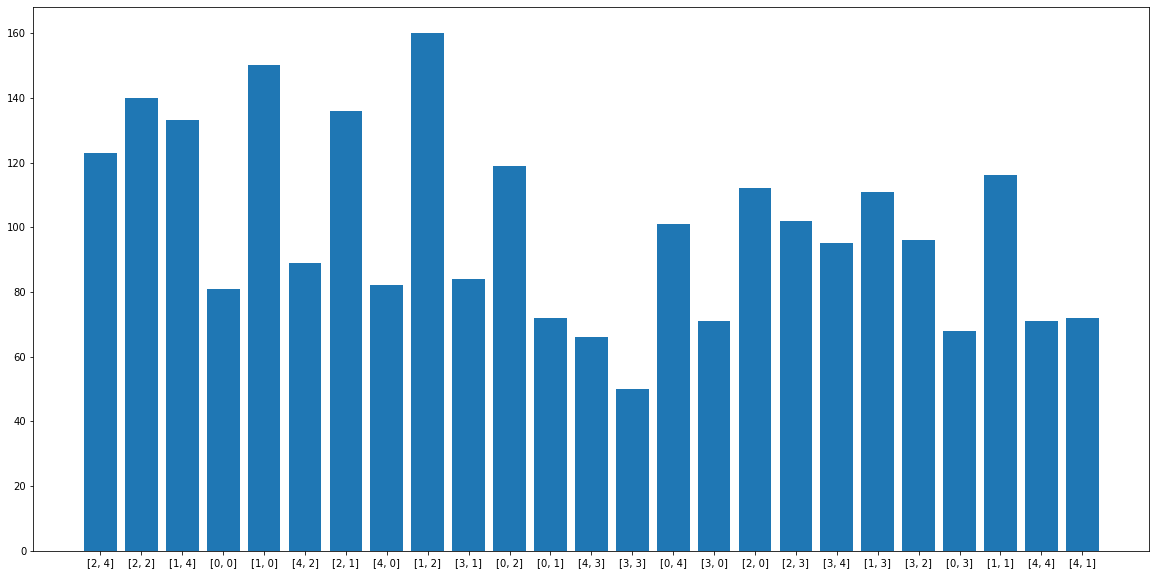

Processing Epoch 26
training start
Iteration 0, d real/fake loss 0.714789867401123/0.6507841944694519 and g loss is 0.7410385608673096, NDiv loss 0.032661374658346176
Iteration 1, d real/fake loss 0.7142320871353149/0.6437307000160217 and g loss is 0.7457795143127441, NDiv loss 0.034066956490278244
Iteration 2, d real/fake loss 0.713668167591095/0.6586074829101562 and g loss is 0.7418597340583801, NDiv loss 0.04075510799884796
Iteration 3, d real/fake loss 0.7131177186965942/0.6451406478881836 and g loss is 0.7449347972869873, NDiv loss 0.03234146162867546
Iteration 4, d real/fake loss 0.7125639319419861/0.6529470682144165 and g loss is 0.7381488084793091, NDiv loss 0.03218076750636101


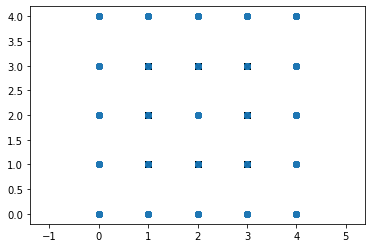

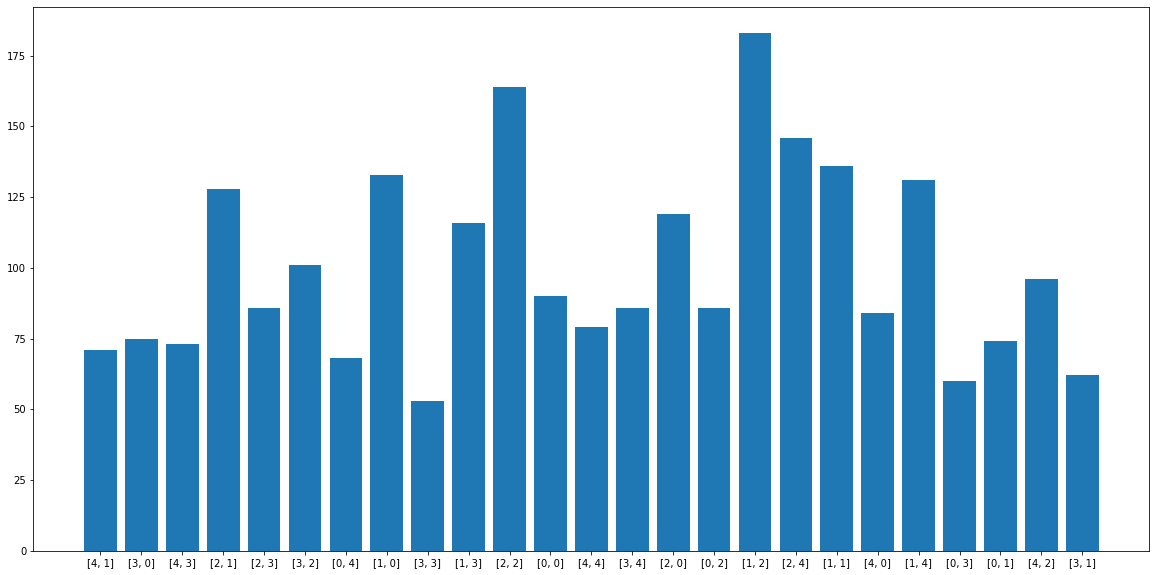

Processing Epoch 27
training start
Iteration 0, d real/fake loss 0.7187989950180054/0.6508873701095581 and g loss is 0.7459100484848022, NDiv loss 0.03248997777700424
Iteration 1, d real/fake loss 0.718246340751648/0.644303023815155 and g loss is 0.7500823736190796, NDiv loss 0.034547802060842514
Iteration 2, d real/fake loss 0.7176859378814697/0.6515030860900879 and g loss is 0.7435129880905151, NDiv loss 0.03774416446685791
Iteration 3, d real/fake loss 0.7171230316162109/0.659498929977417 and g loss is 0.730114221572876, NDiv loss 0.032091666013002396
Iteration 4, d real/fake loss 0.7165582776069641/0.648091733455658 and g loss is 0.7397541999816895, NDiv loss 0.033384114503860474


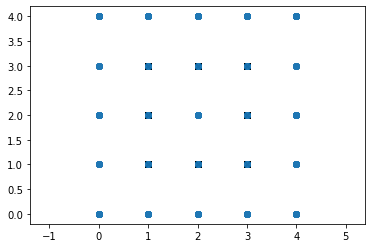

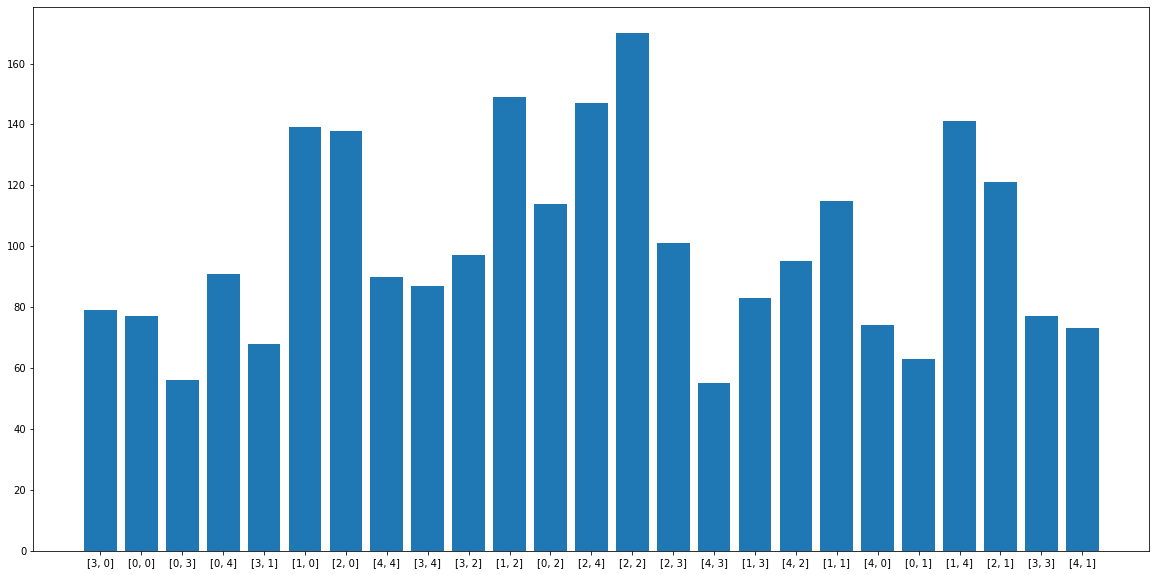

Processing Epoch 28
training start
Iteration 0, d real/fake loss 0.713513970375061/0.6396540403366089 and g loss is 0.7402024269104004, NDiv loss 0.032525986433029175
Iteration 1, d real/fake loss 0.7129369378089905/0.6480318307876587 and g loss is 0.7411724328994751, NDiv loss 0.033899594098329544
Iteration 2, d real/fake loss 0.7123655080795288/0.6441736221313477 and g loss is 0.7324357032775879, NDiv loss 0.03244344890117645
Iteration 3, d real/fake loss 0.7117865681648254/0.6533868908882141 and g loss is 0.7485601902008057, NDiv loss 0.03302430361509323
Iteration 4, d real/fake loss 0.711216390132904/0.655482828617096 and g loss is 0.740611732006073, NDiv loss 0.03566567227244377


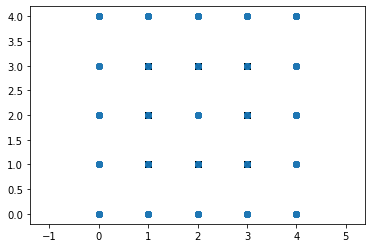

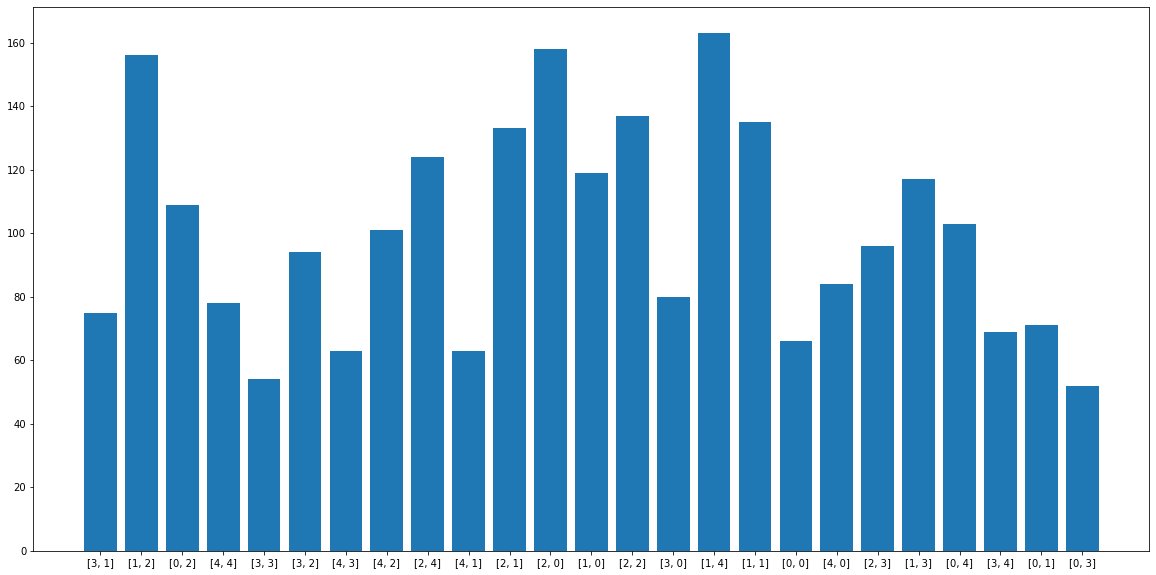

Processing Epoch 29
training start
Iteration 0, d real/fake loss 0.7121932506561279/0.6608568429946899 and g loss is 0.7403026819229126, NDiv loss 0.033170126378536224
Iteration 1, d real/fake loss 0.7116464376449585/0.6508554220199585 and g loss is 0.7446081042289734, NDiv loss 0.03148481249809265
Iteration 2, d real/fake loss 0.7111008167266846/0.6392782330513 and g loss is 0.7403497099876404, NDiv loss 0.0351022407412529
Iteration 3, d real/fake loss 0.710546612739563/0.6443482041358948 and g loss is 0.7427840232849121, NDiv loss 0.03385278582572937
Iteration 4, d real/fake loss 0.7099912166595459/0.6492224931716919 and g loss is 0.7419265508651733, NDiv loss 0.03314046189188957


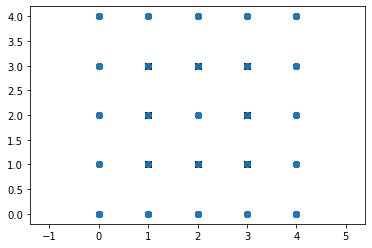

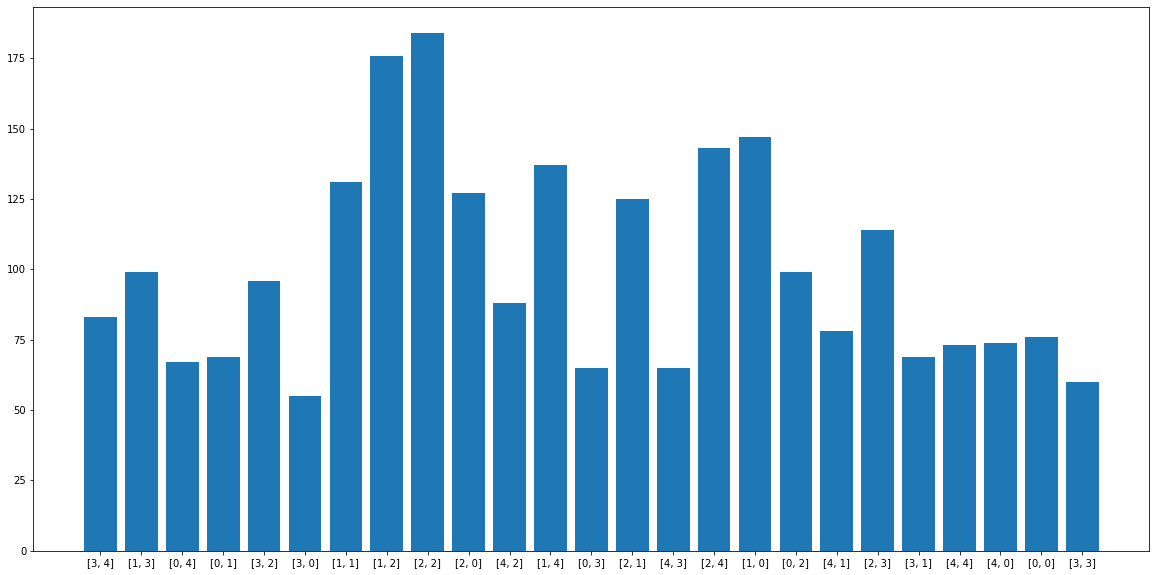

Processing Epoch 30
training start
Iteration 0, d real/fake loss 0.7079752683639526/0.6519628763198853 and g loss is 0.7445223331451416, NDiv loss 0.03288036212325096
Iteration 1, d real/fake loss 0.7074555158615112/0.6456022262573242 and g loss is 0.7423659563064575, NDiv loss 0.03404194489121437
Iteration 2, d real/fake loss 0.7069330215454102/0.6523804068565369 and g loss is 0.7427823543548584, NDiv loss 0.03219771385192871
Iteration 3, d real/fake loss 0.7064172029495239/0.6542202830314636 and g loss is 0.7452711462974548, NDiv loss 0.0319984070956707
Iteration 4, d real/fake loss 0.7059057950973511/0.6494171619415283 and g loss is 0.7391888499259949, NDiv loss 0.03257361054420471


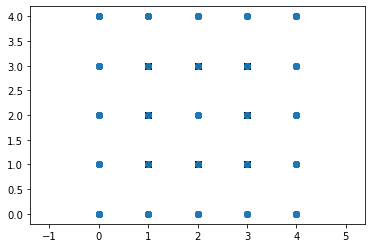

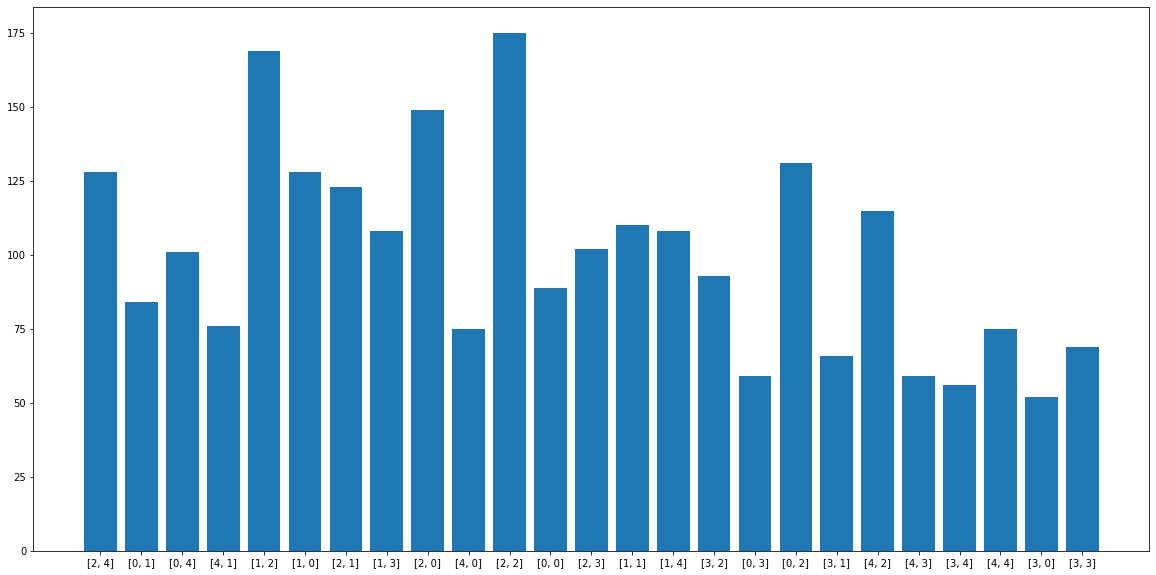

Processing Epoch 31
training start
Iteration 0, d real/fake loss 0.7062409520149231/0.6493772864341736 and g loss is 0.7437272071838379, NDiv loss 0.03190554305911064
Iteration 1, d real/fake loss 0.7057100534439087/0.6488996744155884 and g loss is 0.7344194650650024, NDiv loss 0.033752016723155975
Iteration 2, d real/fake loss 0.7051749229431152/0.6551859378814697 and g loss is 0.7307575941085815, NDiv loss 0.03601298853754997
Iteration 3, d real/fake loss 0.7046488523483276/0.6585509181022644 and g loss is 0.7346398830413818, NDiv loss 0.03242763504385948
Iteration 4, d real/fake loss 0.7041283845901489/0.6535072326660156 and g loss is 0.7386549115180969, NDiv loss 0.03363914042711258


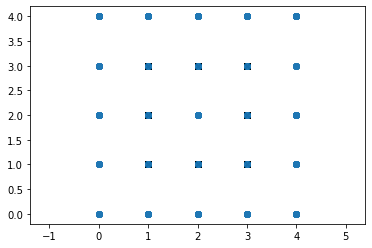

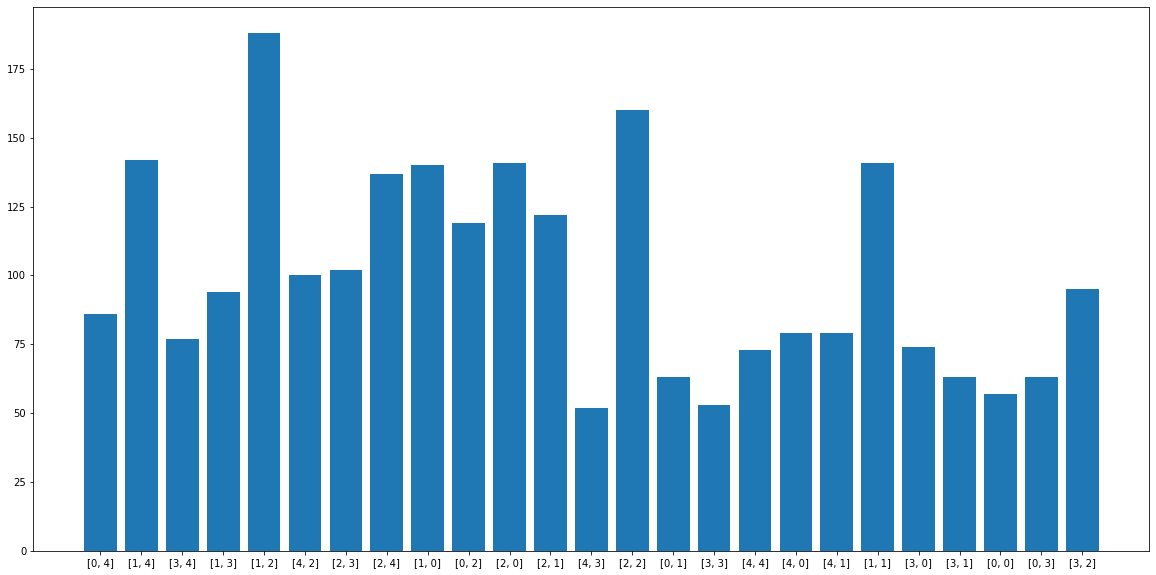

Processing Epoch 32
training start
Iteration 0, d real/fake loss 0.7019745707511902/0.65871661901474 and g loss is 0.7419016361236572, NDiv loss 0.03142073005437851
Iteration 1, d real/fake loss 0.7015052437782288/0.645348072052002 and g loss is 0.7417936325073242, NDiv loss 0.034801121801137924
Iteration 2, d real/fake loss 0.7010294198989868/0.6541593074798584 and g loss is 0.7362368702888489, NDiv loss 0.03408699110150337
Iteration 3, d real/fake loss 0.7005572319030762/0.6661479473114014 and g loss is 0.7491307258605957, NDiv loss 0.03446144983172417
Iteration 4, d real/fake loss 0.7001018524169922/0.6610627174377441 and g loss is 0.7435495853424072, NDiv loss 0.03273279219865799


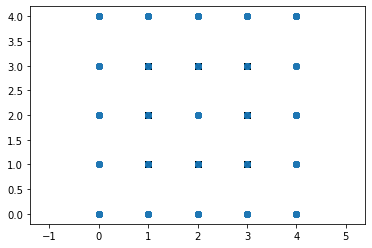

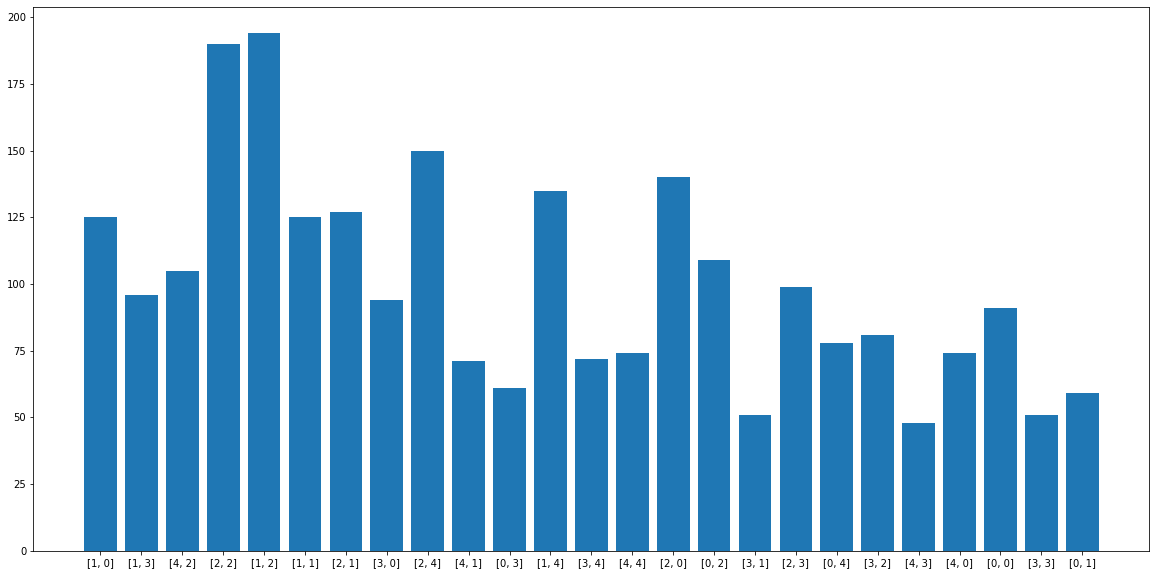

Processing Epoch 33
training start
Iteration 0, d real/fake loss 0.7053636312484741/0.6633619666099548 and g loss is 0.7302390336990356, NDiv loss 0.033016838133335114
Iteration 1, d real/fake loss 0.7048854231834412/0.6550948619842529 and g loss is 0.740498423576355, NDiv loss 0.03446279466152191
Iteration 2, d real/fake loss 0.7044004797935486/0.6586944460868835 and g loss is 0.742964506149292, NDiv loss 0.03367069736123085
Iteration 3, d real/fake loss 0.7039189338684082/0.6636133193969727 and g loss is 0.7457269430160522, NDiv loss 0.03783201053738594
Iteration 4, d real/fake loss 0.7034453749656677/0.6480989456176758 and g loss is 0.7427276372909546, NDiv loss 0.03285975381731987


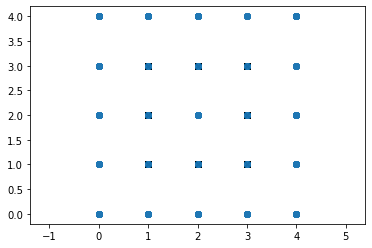

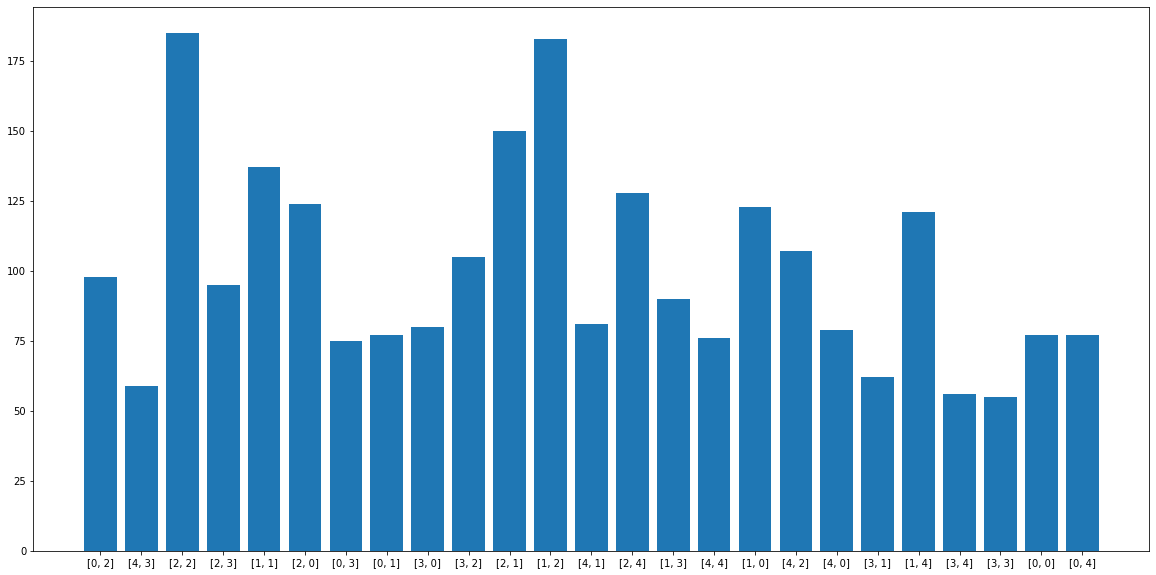

Processing Epoch 34
training start
Iteration 0, d real/fake loss 0.7028984427452087/0.6510779857635498 and g loss is 0.7510150671005249, NDiv loss 0.03642582520842552
Iteration 1, d real/fake loss 0.7024271488189697/0.6656216382980347 and g loss is 0.7447673082351685, NDiv loss 0.03569889813661575
Iteration 2, d real/fake loss 0.7019675970077515/0.6561697125434875 and g loss is 0.732724666595459, NDiv loss 0.03433440998196602
Iteration 3, d real/fake loss 0.7015100717544556/0.6580799221992493 and g loss is 0.7443381547927856, NDiv loss 0.03248848021030426
Iteration 4, d real/fake loss 0.7010535001754761/0.6490286588668823 and g loss is 0.7260293364524841, NDiv loss 0.03441121429204941


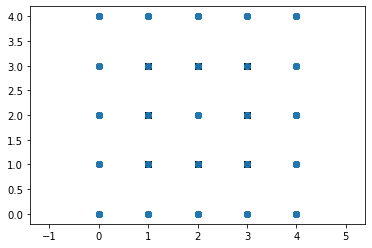

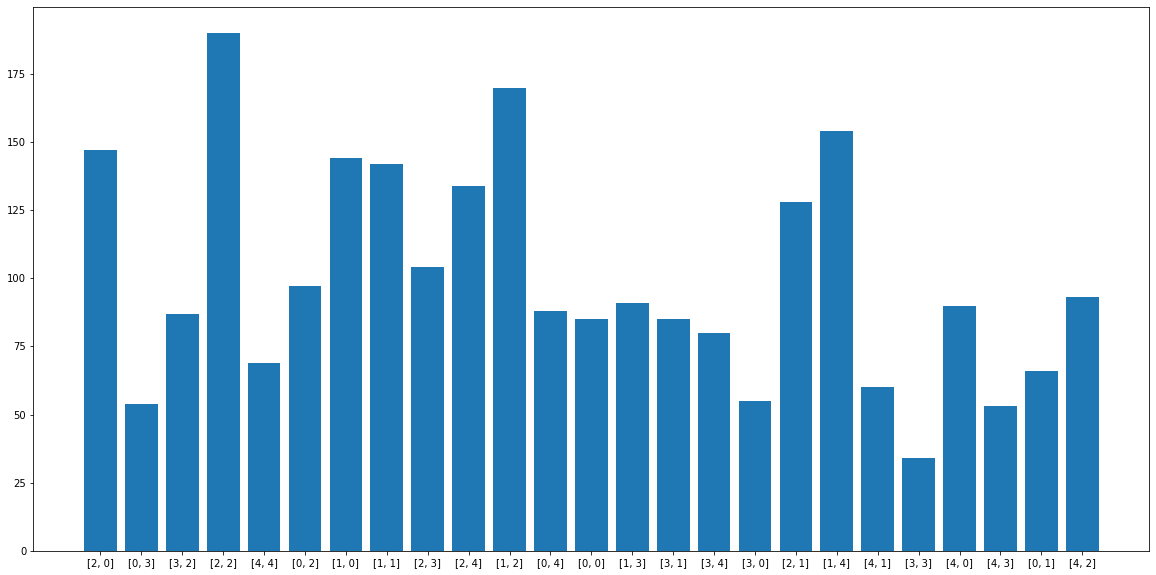

Processing Epoch 35
training start
Iteration 0, d real/fake loss 0.7000418901443481/0.6516676545143127 and g loss is 0.7327350378036499, NDiv loss 0.0366496816277504
Iteration 1, d real/fake loss 0.6995810270309448/0.6528038382530212 and g loss is 0.7405524253845215, NDiv loss 0.03370628133416176
Iteration 2, d real/fake loss 0.6991192698478699/0.6535824537277222 and g loss is 0.739822268486023, NDiv loss 0.03604868799448013
Iteration 3, d real/fake loss 0.6986544728279114/0.6526052355766296 and g loss is 0.7438353300094604, NDiv loss 0.03371785581111908
Iteration 4, d real/fake loss 0.6981908679008484/0.654025137424469 and g loss is 0.7414073944091797, NDiv loss 0.03416900709271431


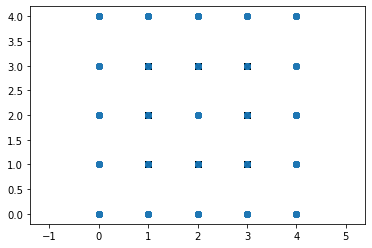

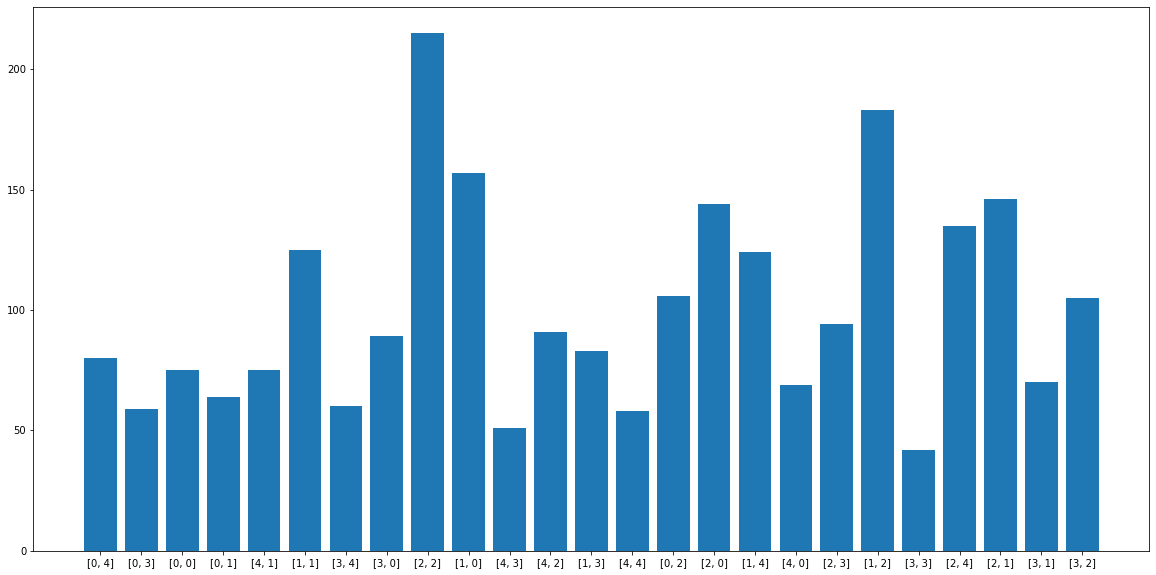

Processing Epoch 36
training start
Iteration 0, d real/fake loss 0.6986290812492371/0.6578232049942017 and g loss is 0.7425860166549683, NDiv loss 0.03511398285627365
Iteration 1, d real/fake loss 0.6981797814369202/0.6510595083236694 and g loss is 0.7338361144065857, NDiv loss 0.036466408520936966
Iteration 2, d real/fake loss 0.6977260112762451/0.6526442170143127 and g loss is 0.7393102645874023, NDiv loss 0.032796960324048996
Iteration 3, d real/fake loss 0.6972678899765015/0.6464383602142334 and g loss is 0.7410856485366821, NDiv loss 0.03683872148394585
Iteration 4, d real/fake loss 0.6968017220497131/0.6542506814002991 and g loss is 0.7296165227890015, NDiv loss 0.031536370515823364


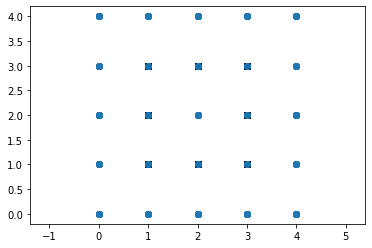

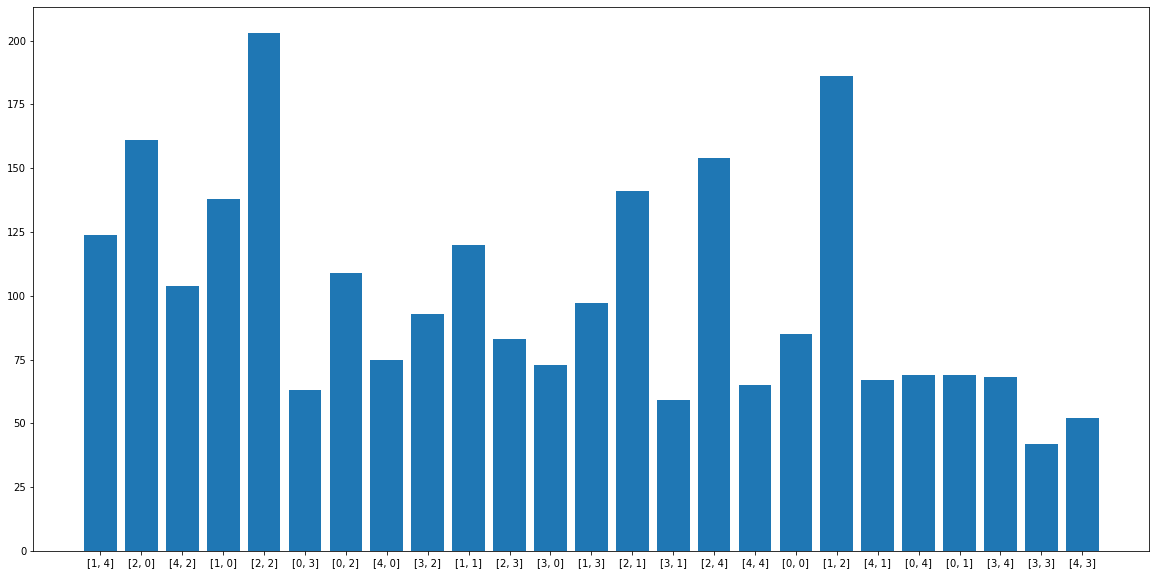

Processing Epoch 37
training start
Iteration 0, d real/fake loss 0.6877413988113403/0.6437855958938599 and g loss is 0.7314509153366089, NDiv loss 0.03687666356563568
Iteration 1, d real/fake loss 0.6873277425765991/0.6556994318962097 and g loss is 0.7411488890647888, NDiv loss 0.036155812442302704
Iteration 2, d real/fake loss 0.6869075298309326/0.6569083333015442 and g loss is 0.740691602230072, NDiv loss 0.03432466834783554
Iteration 3, d real/fake loss 0.6864868402481079/0.6603512167930603 and g loss is 0.73872971534729, NDiv loss 0.042663443833589554
Iteration 4, d real/fake loss 0.6860735416412354/0.6511961817741394 and g loss is 0.7489222288131714, NDiv loss 0.03273467719554901


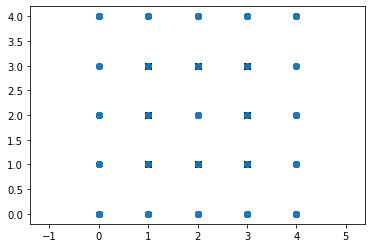

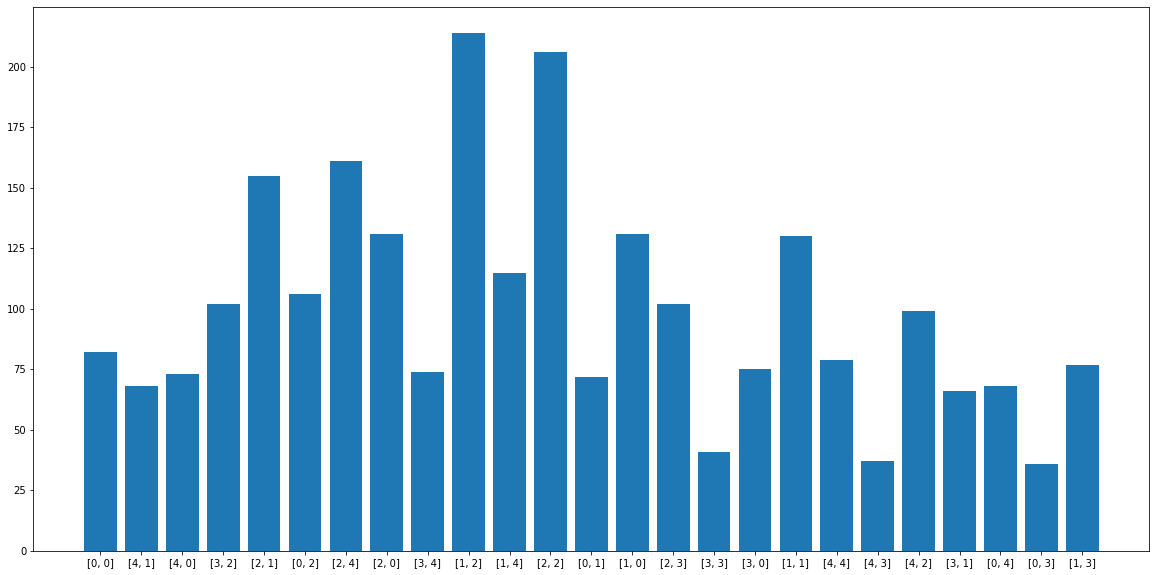

Processing Epoch 38
training start
Iteration 0, d real/fake loss 0.6905269622802734/0.6572869420051575 and g loss is 0.743233323097229, NDiv loss 0.03778136149048805
Iteration 1, d real/fake loss 0.690109372138977/0.650144100189209 and g loss is 0.7431603074073792, NDiv loss 0.03606114536523819
Iteration 2, d real/fake loss 0.6896816492080688/0.6547396779060364 and g loss is 0.7459670901298523, NDiv loss 0.03319129720330238
Iteration 3, d real/fake loss 0.6892527341842651/0.6538112163543701 and g loss is 0.7487189769744873, NDiv loss 0.03717309981584549
Iteration 4, d real/fake loss 0.6888185739517212/0.6478325128555298 and g loss is 0.7327582240104675, NDiv loss 0.036393288522958755


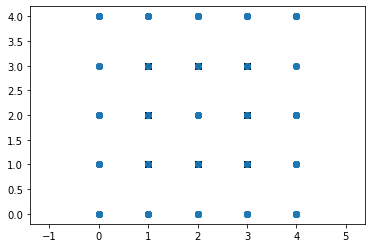

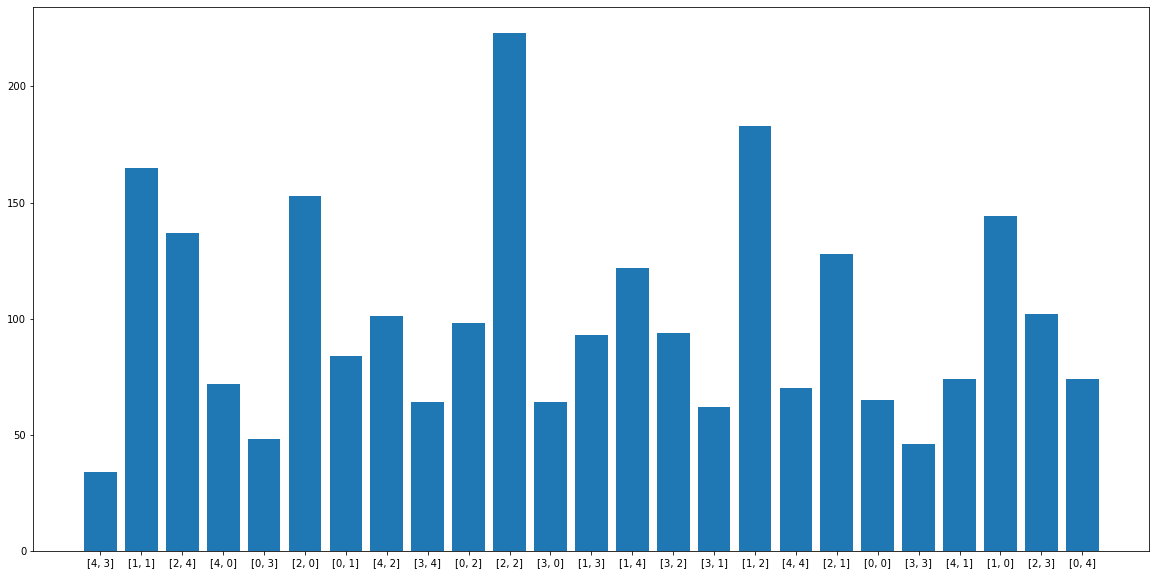

Processing Epoch 39
training start
Iteration 0, d real/fake loss 0.6928381323814392/0.6508389115333557 and g loss is 0.7384563684463501, NDiv loss 0.03597240895032883
Iteration 1, d real/fake loss 0.6923694014549255/0.6406216621398926 and g loss is 0.7401062846183777, NDiv loss 0.034829143434762955
Iteration 2, d real/fake loss 0.6918926239013672/0.6639320850372314 and g loss is 0.7354350090026855, NDiv loss 0.033046070486307144
Iteration 3, d real/fake loss 0.6914287209510803/0.6548527479171753 and g loss is 0.7457735538482666, NDiv loss 0.03798234835267067
Iteration 4, d real/fake loss 0.6909684538841248/0.6524150371551514 and g loss is 0.7257691025733948, NDiv loss 0.0342838279902935


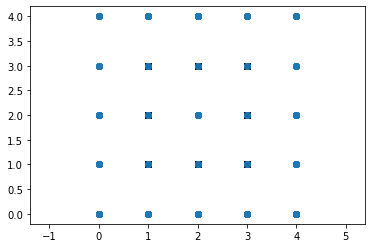

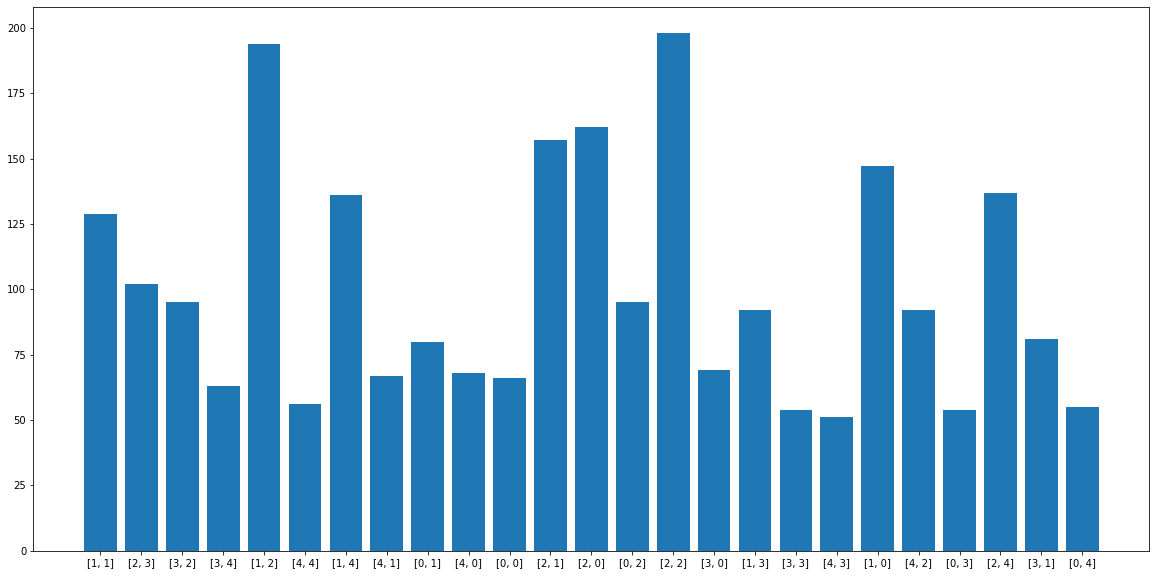

Processing Epoch 40
training start
Iteration 0, d real/fake loss 0.6835746765136719/0.6598973274230957 and g loss is 0.741948127746582, NDiv loss 0.03921682387590408
Iteration 1, d real/fake loss 0.6832008361816406/0.6587795615196228 and g loss is 0.7405636310577393, NDiv loss 0.03778401017189026
Iteration 2, d real/fake loss 0.6828334927558899/0.6664913892745972 and g loss is 0.7450419068336487, NDiv loss 0.038821615278720856
Iteration 3, d real/fake loss 0.682476282119751/0.6710827946662903 and g loss is 0.745893657207489, NDiv loss 0.040515776723623276
Iteration 4, d real/fake loss 0.6821287870407104/0.65611332654953 and g loss is 0.7426031827926636, NDiv loss 0.03706595301628113


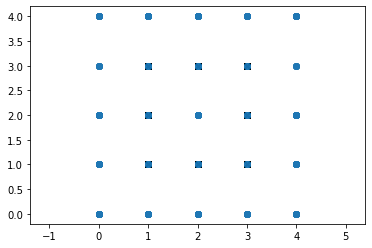

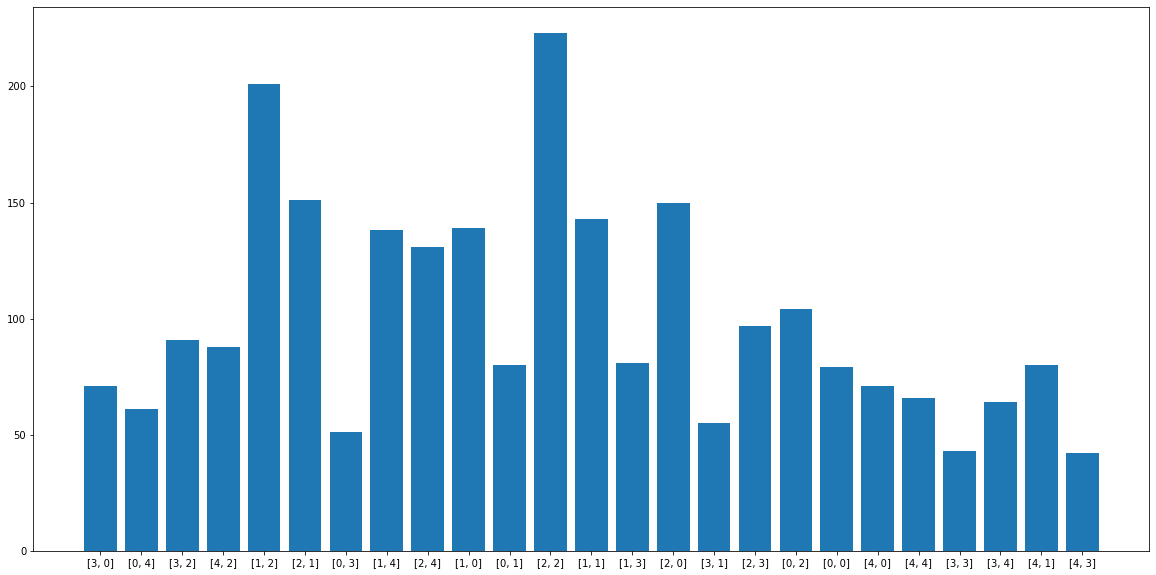

Processing Epoch 41
training start
Iteration 0, d real/fake loss 0.6820218563079834/0.6522747278213501 and g loss is 0.7536474466323853, NDiv loss 0.036354050040245056
Iteration 1, d real/fake loss 0.6816776394844055/0.6429986357688904 and g loss is 0.743698239326477, NDiv loss 0.03291824460029602
Iteration 2, d real/fake loss 0.6813060641288757/0.6452487707138062 and g loss is 0.7407235503196716, NDiv loss 0.035550184547901154
Iteration 3, d real/fake loss 0.6809142827987671/0.6509132385253906 and g loss is 0.7289836406707764, NDiv loss 0.035094767808914185
Iteration 4, d real/fake loss 0.680512547492981/0.6500388383865356 and g loss is 0.7256409525871277, NDiv loss 0.033921461552381516


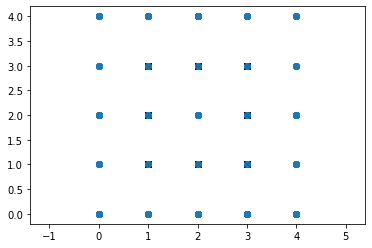

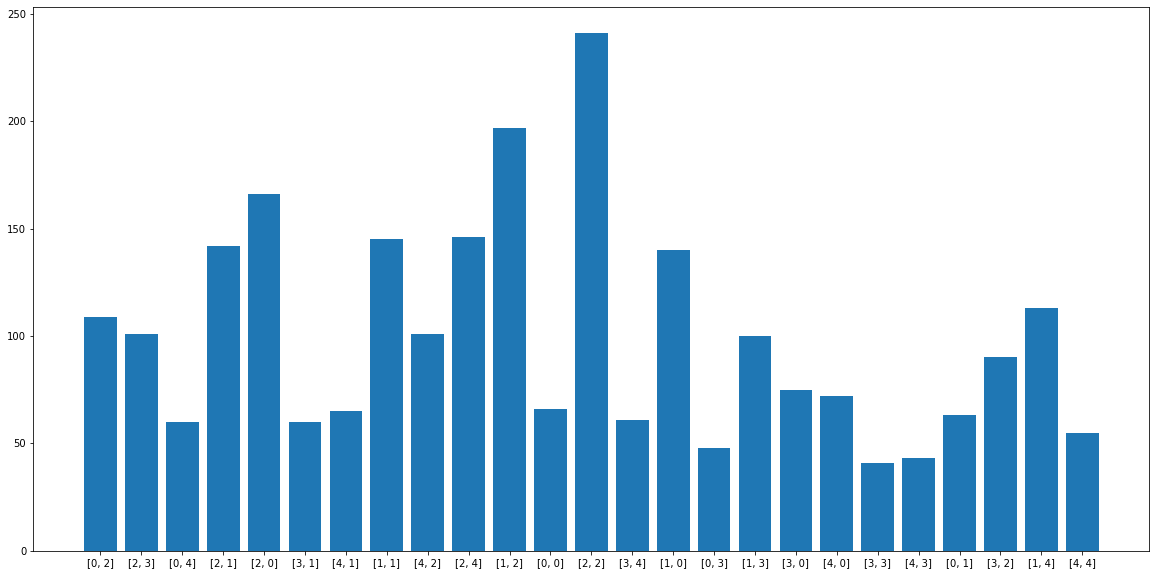

Processing Epoch 42
training start
Iteration 0, d real/fake loss 0.6829436421394348/0.6659656763076782 and g loss is 0.7326961755752563, NDiv loss 0.03522209823131561
Iteration 1, d real/fake loss 0.6825807094573975/0.6575514674186707 and g loss is 0.7425504922866821, NDiv loss 0.03777051717042923
Iteration 2, d real/fake loss 0.6822199821472168/0.6522432565689087 and g loss is 0.7382814884185791, NDiv loss 0.04291319102048874
Iteration 3, d real/fake loss 0.6818501949310303/0.6597554087638855 and g loss is 0.7338841557502747, NDiv loss 0.03532492369413376
Iteration 4, d real/fake loss 0.6814860105514526/0.6571096777915955 and g loss is 0.742403507232666, NDiv loss 0.03969184309244156


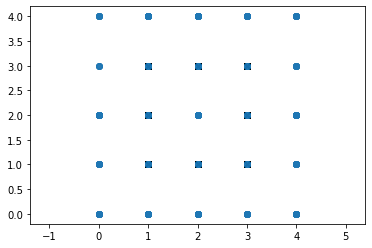

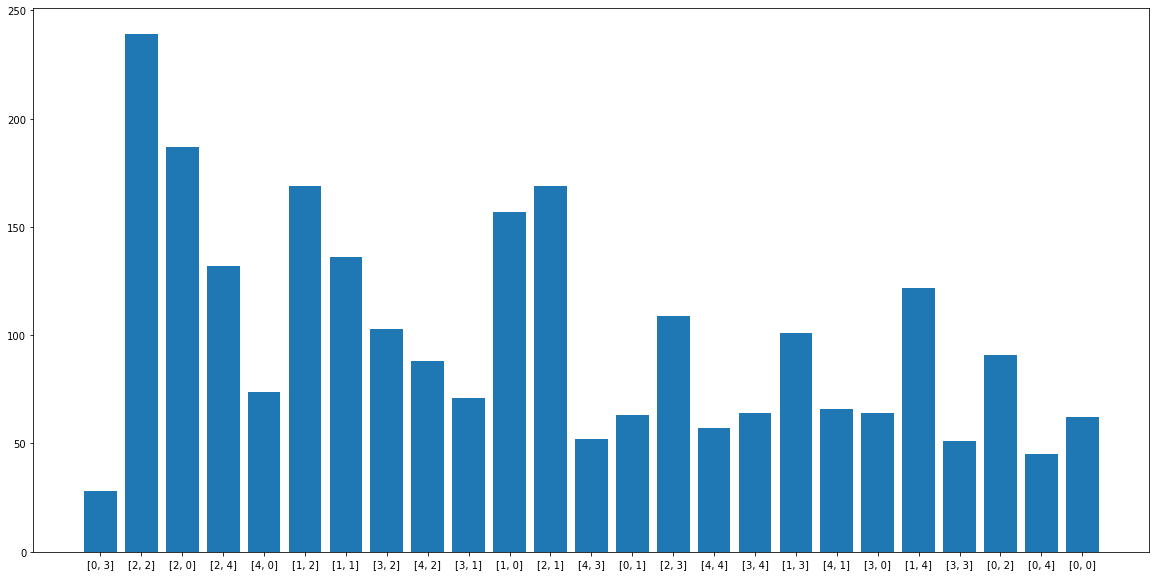

Processing Epoch 43
training start
Iteration 0, d real/fake loss 0.680372416973114/0.6574051380157471 and g loss is 0.7341718077659607, NDiv loss 0.03968840464949608
Iteration 1, d real/fake loss 0.6800104379653931/0.6566612720489502 and g loss is 0.7376181483268738, NDiv loss 0.0366659052670002
Iteration 2, d real/fake loss 0.6796466112136841/0.6390722990036011 and g loss is 0.737199604511261, NDiv loss 0.0324016697704792
Iteration 3, d real/fake loss 0.6792709827423096/0.6557565927505493 and g loss is 0.7381689548492432, NDiv loss 0.0357668437063694
Iteration 4, d real/fake loss 0.6789008975028992/0.6613402366638184 and g loss is 0.7408646941184998, NDiv loss 0.036494575440883636


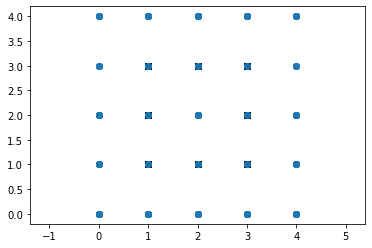

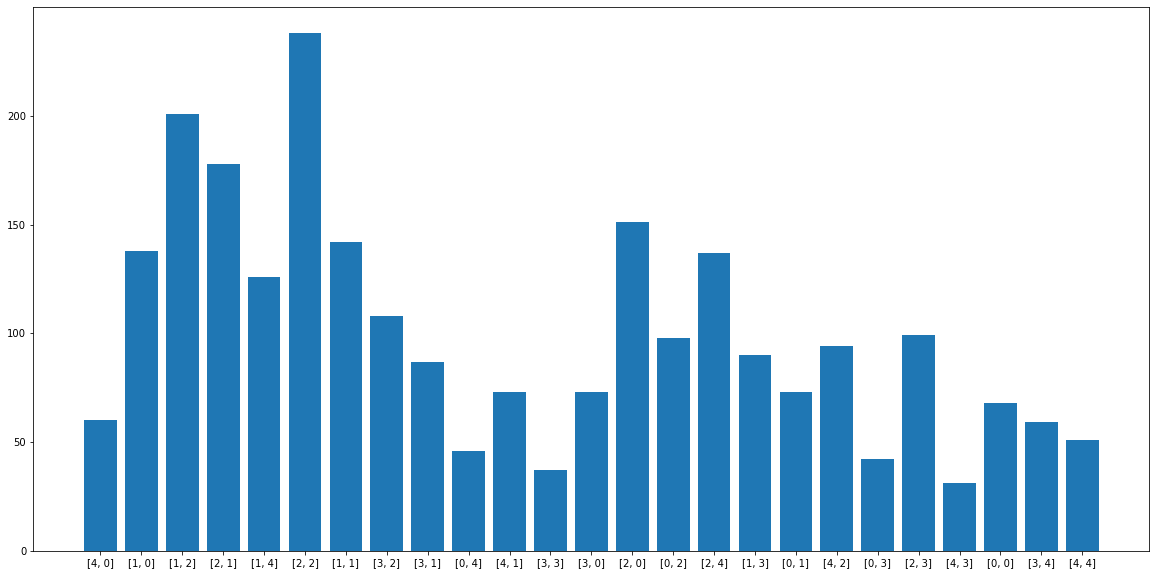

Processing Epoch 44
training start
Iteration 0, d real/fake loss 0.6778443455696106/0.651188313961029 and g loss is 0.7341889142990112, NDiv loss 0.04188494756817818
Iteration 1, d real/fake loss 0.6774816513061523/0.6553993225097656 and g loss is 0.7452053427696228, NDiv loss 0.03945889696478844
Iteration 2, d real/fake loss 0.677118182182312/0.6641525626182556 and g loss is 0.73334801197052, NDiv loss 0.037371911108493805
Iteration 3, d real/fake loss 0.6767643690109253/0.6640014052391052 and g loss is 0.7370761036872864, NDiv loss 0.03443688899278641
Iteration 4, d real/fake loss 0.6764124631881714/0.6695007681846619 and g loss is 0.7440487146377563, NDiv loss 0.04094519093632698


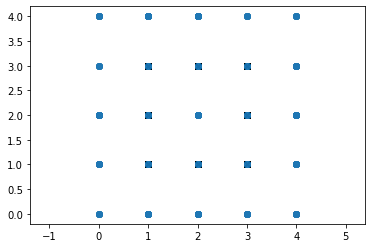

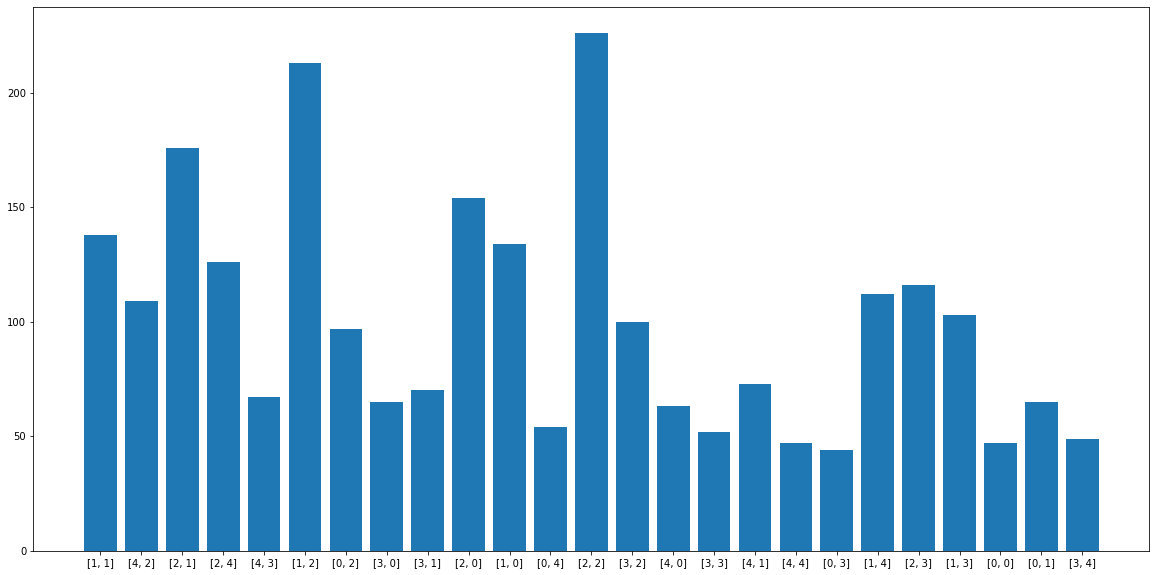

Processing Epoch 45
training start
Iteration 0, d real/fake loss 0.6673351526260376/0.6547106504440308 and g loss is 0.7350430488586426, NDiv loss 0.03788450360298157
Iteration 1, d real/fake loss 0.6670154333114624/0.652100145816803 and g loss is 0.7380461692810059, NDiv loss 0.03690169379115105
Iteration 2, d real/fake loss 0.666685938835144/0.6615696549415588 and g loss is 0.7349331974983215, NDiv loss 0.038311704993247986
Iteration 3, d real/fake loss 0.666359007358551/0.657128095626831 and g loss is 0.733616828918457, NDiv loss 0.03582598268985748
Iteration 4, d real/fake loss 0.6660288572311401/0.6503693461418152 and g loss is 0.7386095523834229, NDiv loss 0.035275500267744064


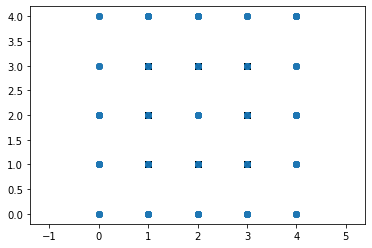

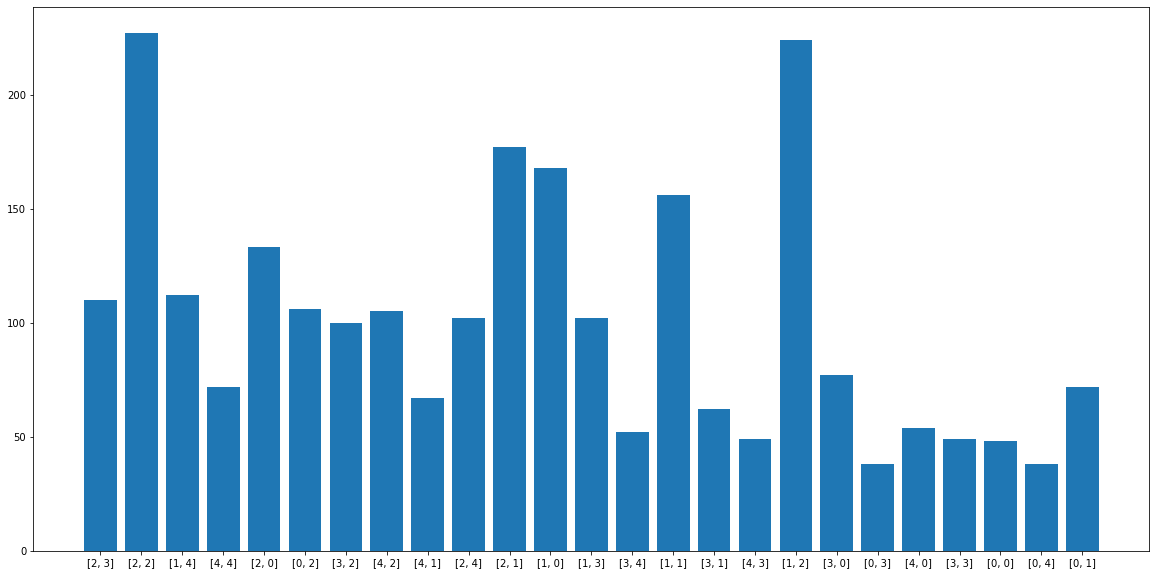

Processing Epoch 46
training start
Iteration 0, d real/fake loss 0.67399001121521/0.6578831076622009 and g loss is 0.7289261221885681, NDiv loss 0.03899263218045235
Iteration 1, d real/fake loss 0.673650324344635/0.6559818983078003 and g loss is 0.7397687435150146, NDiv loss 0.0379425510764122
Iteration 2, d real/fake loss 0.6733129024505615/0.6637871265411377 and g loss is 0.7441227436065674, NDiv loss 0.03661254420876503
Iteration 3, d real/fake loss 0.6729857921600342/0.6582058072090149 and g loss is 0.73784339427948, NDiv loss 0.04434359818696976
Iteration 4, d real/fake loss 0.6726618409156799/0.6558600664138794 and g loss is 0.7253810167312622, NDiv loss 0.0403548888862133


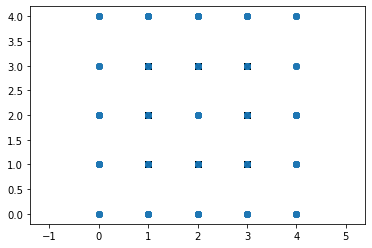

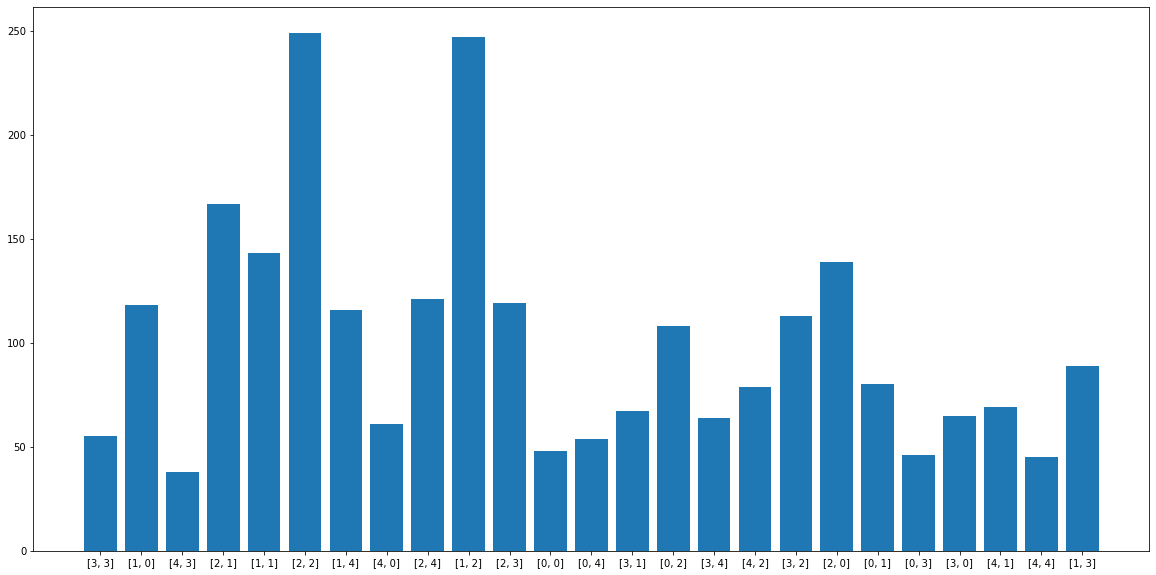

Processing Epoch 47
training start
Iteration 0, d real/fake loss 0.6718719601631165/0.6646446585655212 and g loss is 0.725459635257721, NDiv loss 0.038868196308612823
Iteration 1, d real/fake loss 0.6715809106826782/0.6507951021194458 and g loss is 0.7361046075820923, NDiv loss 0.04342435300350189
Iteration 2, d real/fake loss 0.6712780594825745/0.6651438474655151 and g loss is 0.7289800643920898, NDiv loss 0.041648298501968384
Iteration 3, d real/fake loss 0.6709808111190796/0.6513673067092896 and g loss is 0.7362334728240967, NDiv loss 0.03643308952450752
Iteration 4, d real/fake loss 0.6706749796867371/0.661981463432312 and g loss is 0.7274755239486694, NDiv loss 0.0427827313542366


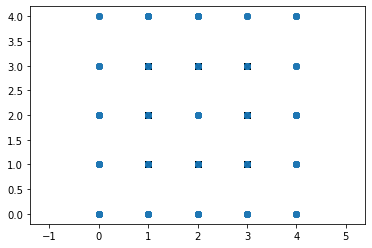

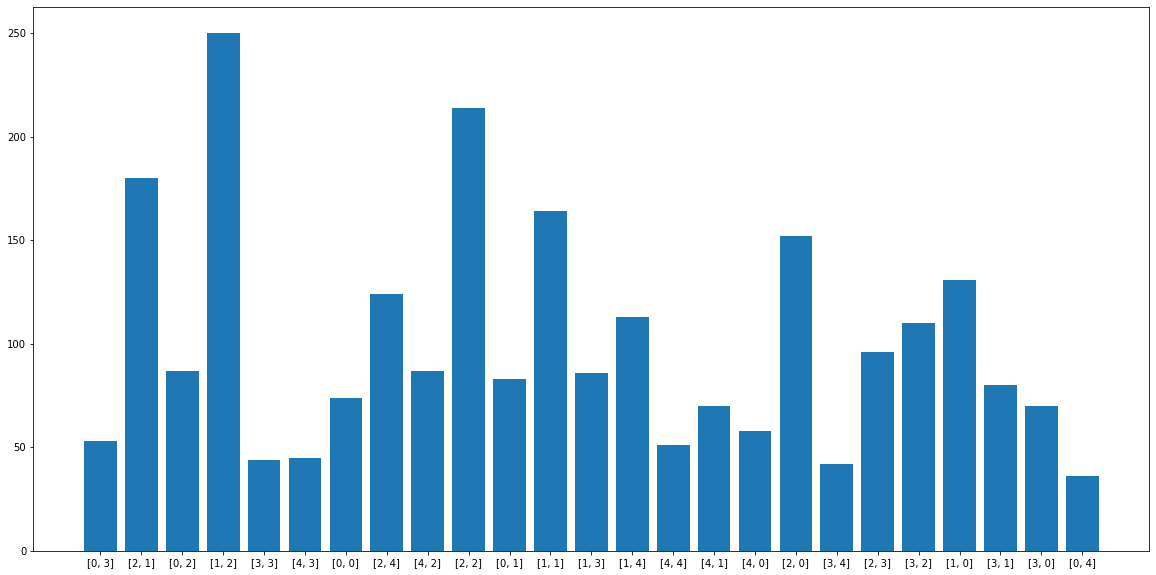

Processing Epoch 48
training start
Iteration 0, d real/fake loss 0.6710372567176819/0.6581579446792603 and g loss is 0.7395823001861572, NDiv loss 0.04232264310121536
Iteration 1, d real/fake loss 0.6707375645637512/0.6604178547859192 and g loss is 0.7349274158477783, NDiv loss 0.04285705089569092
Iteration 2, d real/fake loss 0.6704415082931519/0.6623105406761169 and g loss is 0.7452925443649292, NDiv loss 0.03643221780657768
Iteration 3, d real/fake loss 0.6701490879058838/0.6674380302429199 and g loss is 0.7292779684066772, NDiv loss 0.03572079911828041
Iteration 4, d real/fake loss 0.6698633432388306/0.6578377485275269 and g loss is 0.7438451647758484, NDiv loss 0.03903953358530998


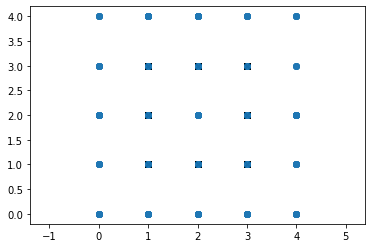

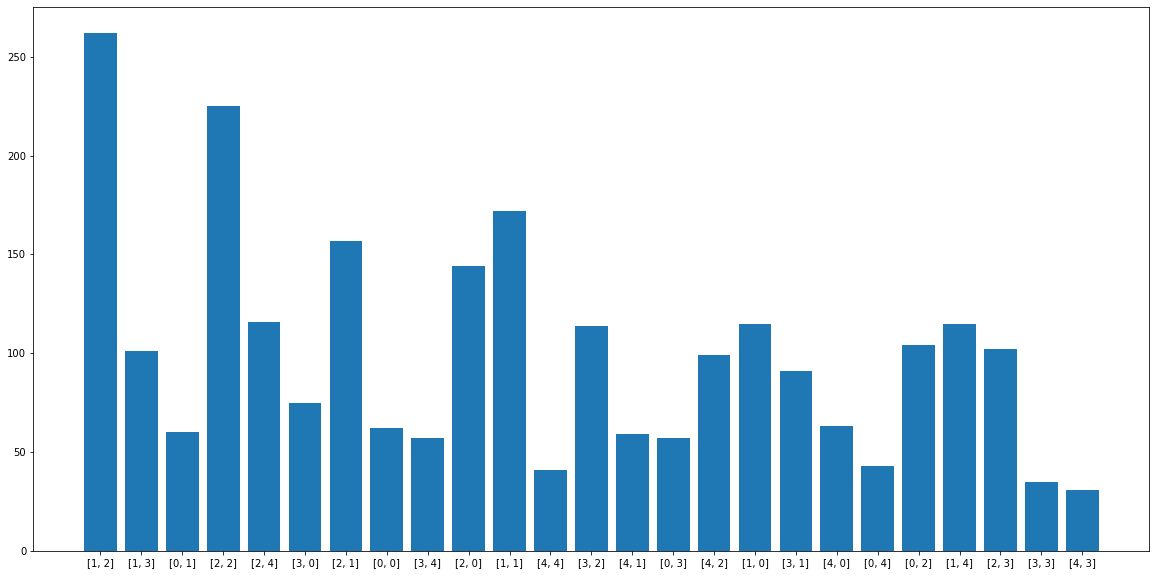

Processing Epoch 49
training start
Iteration 0, d real/fake loss 0.6659510135650635/0.656530499458313 and g loss is 0.7298095226287842, NDiv loss 0.04026346653699875
Iteration 1, d real/fake loss 0.6656656265258789/0.6533962488174438 and g loss is 0.7307947278022766, NDiv loss 0.037812262773513794
Iteration 2, d real/fake loss 0.665369987487793/0.6669287085533142 and g loss is 0.744019627571106, NDiv loss 0.037816986441612244
Iteration 3, d real/fake loss 0.6650834083557129/0.6443988084793091 and g loss is 0.7285289168357849, NDiv loss 0.03756779059767723
Iteration 4, d real/fake loss 0.6647840142250061/0.6643389463424683 and g loss is 0.7220918536186218, NDiv loss 0.03722405806183815


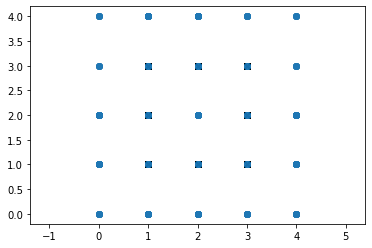

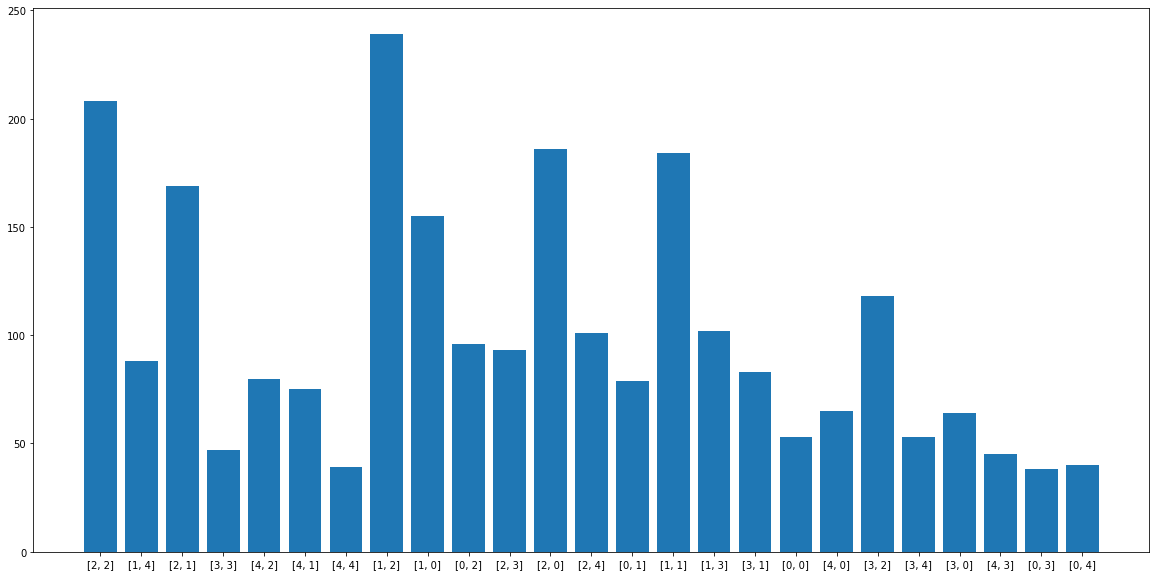

Processing Epoch 50
training start
Iteration 0, d real/fake loss 0.6725656986236572/0.6603288650512695 and g loss is 0.7367385625839233, NDiv loss 0.0400286540389061
Iteration 1, d real/fake loss 0.6722556352615356/0.6615195274353027 and g loss is 0.7394756078720093, NDiv loss 0.03530719131231308
Iteration 2, d real/fake loss 0.6719398498535156/0.6593407392501831 and g loss is 0.7306339144706726, NDiv loss 0.03871498256921768
Iteration 3, d real/fake loss 0.6716276407241821/0.670464038848877 and g loss is 0.722205400466919, NDiv loss 0.03236079216003418
Iteration 4, d real/fake loss 0.6713308095932007/0.6553263664245605 and g loss is 0.7348312139511108, NDiv loss 0.038169052451848984


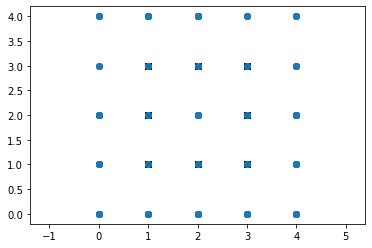

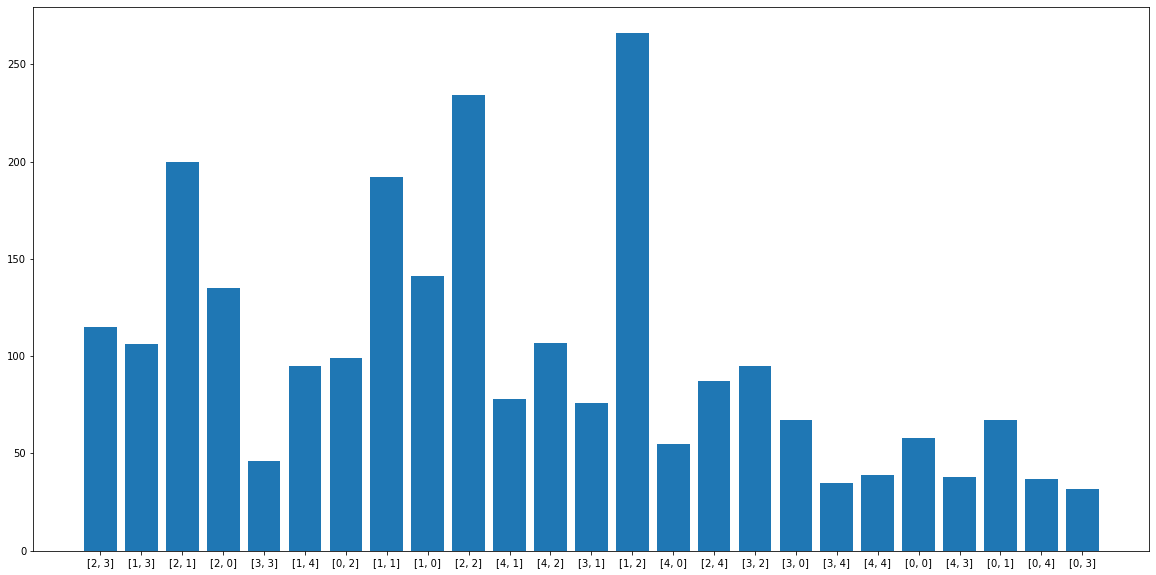

Processing Epoch 51
training start
Iteration 0, d real/fake loss 0.6703510880470276/0.6664918661117554 and g loss is 0.7297978401184082, NDiv loss 0.03495204448699951
Iteration 1, d real/fake loss 0.6700760722160339/0.6670711040496826 and g loss is 0.7300525903701782, NDiv loss 0.04141581431031227
Iteration 2, d real/fake loss 0.6698041558265686/0.6574697494506836 and g loss is 0.7243213653564453, NDiv loss 0.03421514108777046
Iteration 3, d real/fake loss 0.6695337891578674/0.6659636497497559 and g loss is 0.7212147116661072, NDiv loss 0.0423765666782856
Iteration 4, d real/fake loss 0.6692628860473633/0.6659606099128723 and g loss is 0.7222317457199097, NDiv loss 0.042328380048274994


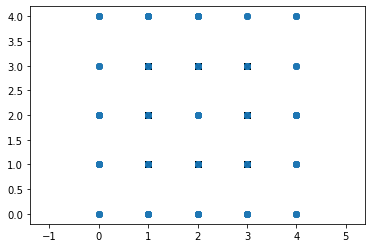

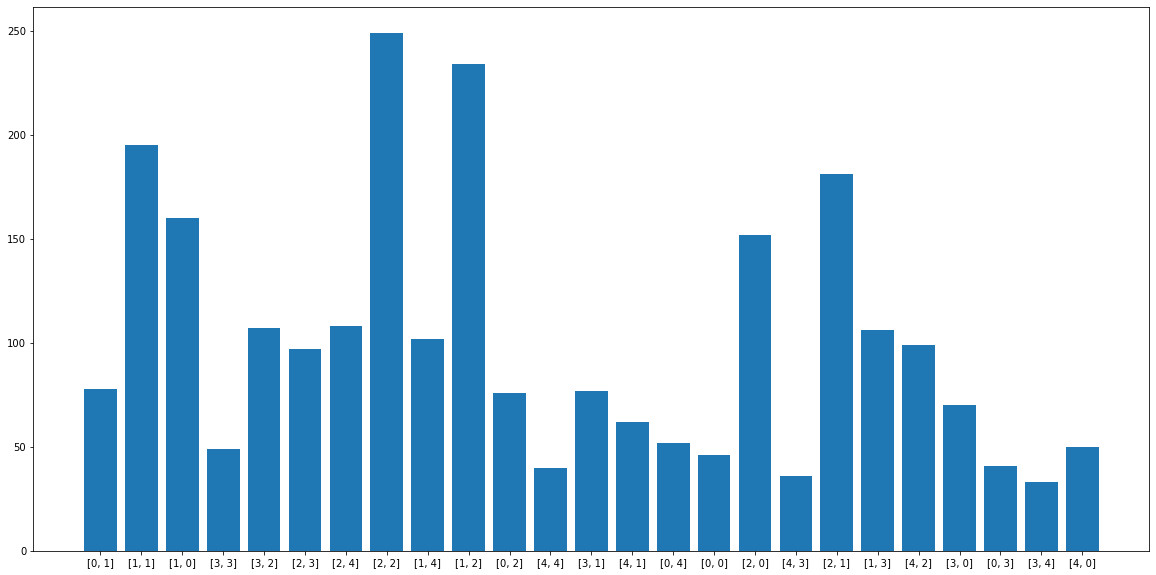

Processing Epoch 52
training start
Iteration 0, d real/fake loss 0.6669313907623291/0.6680161356925964 and g loss is 0.7340264916419983, NDiv loss 0.03832843899726868
Iteration 1, d real/fake loss 0.6666883230209351/0.6687020063400269 and g loss is 0.729454517364502, NDiv loss 0.03514687716960907
Iteration 2, d real/fake loss 0.6664466261863708/0.6643574833869934 and g loss is 0.728156328201294, NDiv loss 0.0402730368077755
Iteration 3, d real/fake loss 0.6662017107009888/0.6673263311386108 and g loss is 0.7169760465621948, NDiv loss 0.04366687312722206
Iteration 4, d real/fake loss 0.6659601926803589/0.6677928566932678 and g loss is 0.738100528717041, NDiv loss 0.042668554931879044


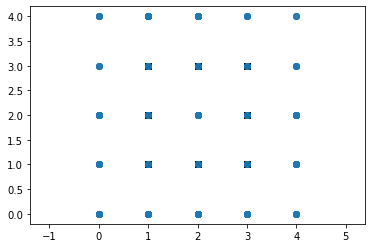

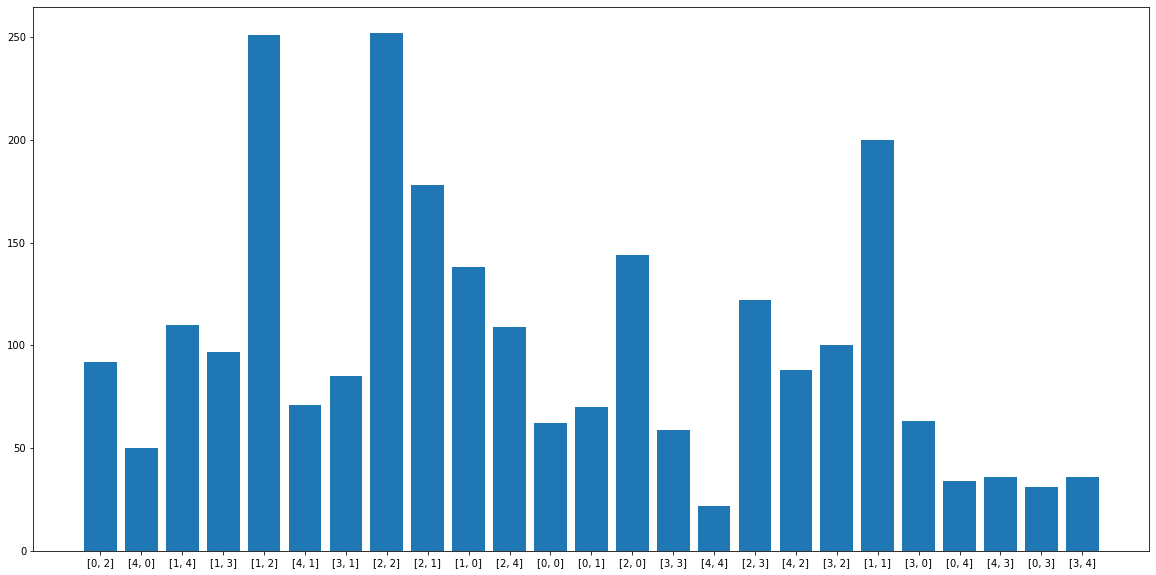

Processing Epoch 53
training start
Iteration 0, d real/fake loss 0.6660096645355225/0.6662234663963318 and g loss is 0.7153537273406982, NDiv loss 0.034868113696575165
Iteration 1, d real/fake loss 0.6658003330230713/0.676324188709259 and g loss is 0.7227573990821838, NDiv loss 0.041058093309402466
Iteration 2, d real/fake loss 0.6655935645103455/0.6681703329086304 and g loss is 0.733177661895752, NDiv loss 0.03931194916367531
Iteration 3, d real/fake loss 0.6653838157653809/0.6660393476486206 and g loss is 0.7403731346130371, NDiv loss 0.03844667971134186
Iteration 4, d real/fake loss 0.665173351764679/0.6583141684532166 and g loss is 0.7134405970573425, NDiv loss 0.0405179038643837


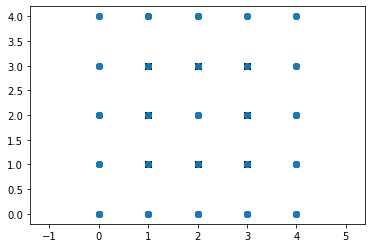

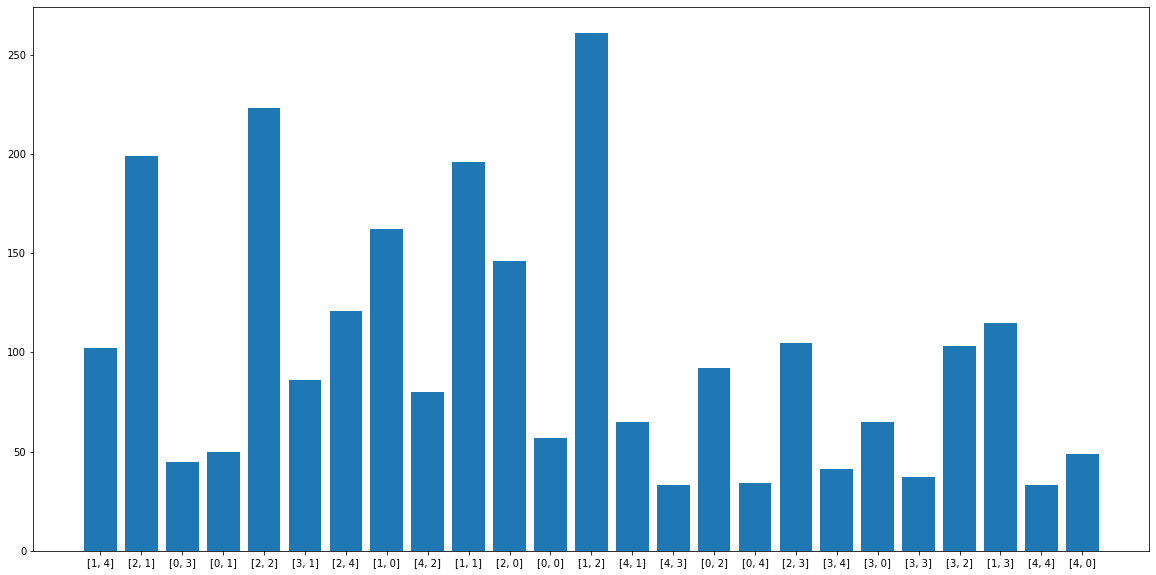

Processing Epoch 54
training start
Iteration 0, d real/fake loss 0.6631799936294556/0.6654539704322815 and g loss is 0.7314271330833435, NDiv loss 0.04028324782848358
Iteration 1, d real/fake loss 0.6629095077514648/0.6695333123207092 and g loss is 0.7329027652740479, NDiv loss 0.03885410726070404
Iteration 2, d real/fake loss 0.6626405119895935/0.6661173105239868 and g loss is 0.7274218797683716, NDiv loss 0.04290611296892166
Iteration 3, d real/fake loss 0.6623715758323669/0.6595765352249146 and g loss is 0.7184926867485046, NDiv loss 0.044566560536623
Iteration 4, d real/fake loss 0.6620917320251465/0.6667413711547852 and g loss is 0.7290677428245544, NDiv loss 0.03999774530529976


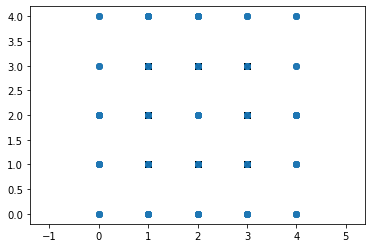

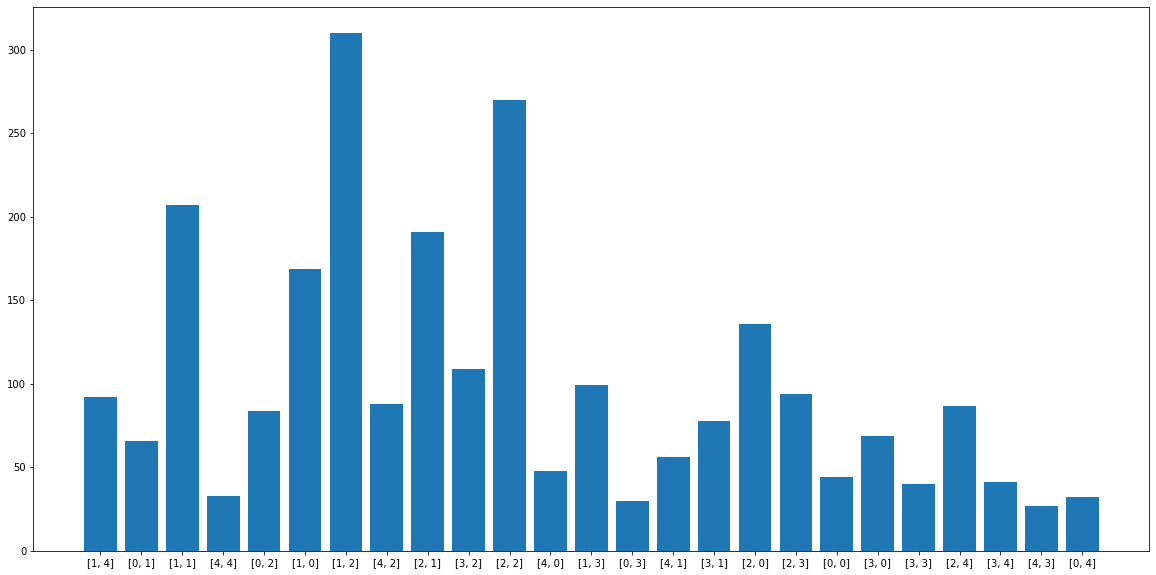

Processing Epoch 55
training start
Iteration 0, d real/fake loss 0.6622029542922974/0.6706122159957886 and g loss is 0.7263270616531372, NDiv loss 0.04340300336480141
Iteration 1, d real/fake loss 0.661968469619751/0.667359471321106 and g loss is 0.7388283014297485, NDiv loss 0.03837350383400917
Iteration 2, d real/fake loss 0.6617349982261658/0.6739112138748169 and g loss is 0.728904128074646, NDiv loss 0.040649376809597015
Iteration 3, d real/fake loss 0.6615180969238281/0.6666038632392883 and g loss is 0.7268645763397217, NDiv loss 0.04552260413765907
Iteration 4, d real/fake loss 0.6613080501556396/0.661272406578064 and g loss is 0.7301691174507141, NDiv loss 0.041232623159885406


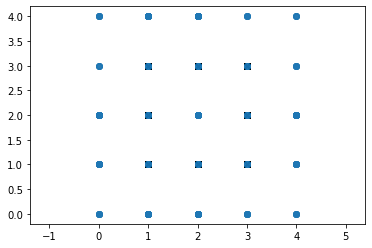

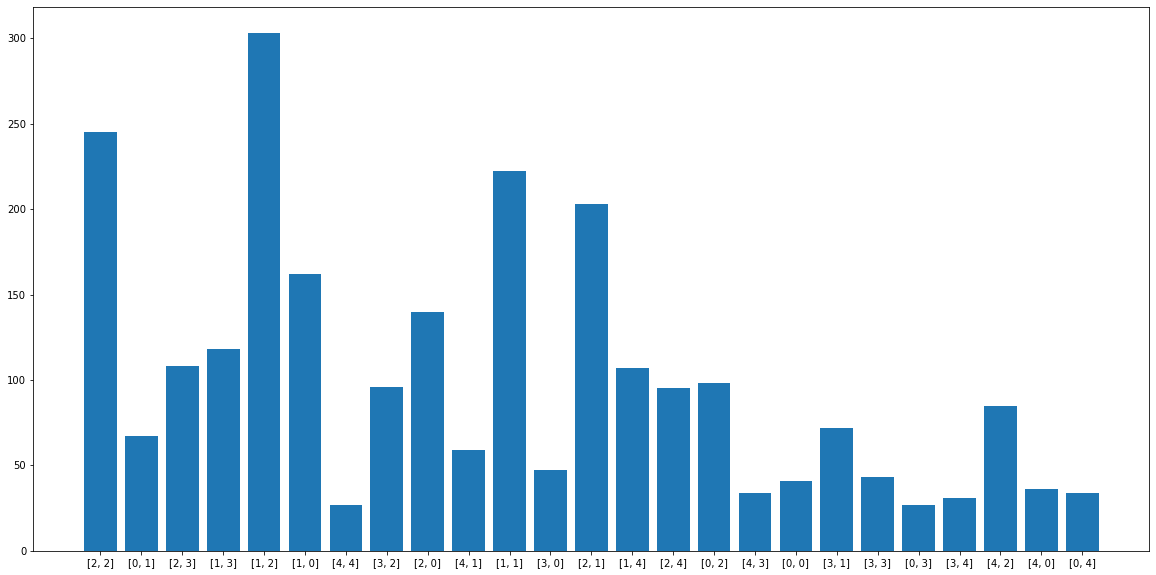

Processing Epoch 56
training start
Iteration 0, d real/fake loss 0.6593908071517944/0.6692864298820496 and g loss is 0.733227550983429, NDiv loss 0.036938030272722244
Iteration 1, d real/fake loss 0.6591980457305908/0.6617081165313721 and g loss is 0.7155715227127075, NDiv loss 0.044841453433036804
Iteration 2, d real/fake loss 0.6590017080307007/0.6724483966827393 and g loss is 0.7255633473396301, NDiv loss 0.042407553642988205
Iteration 3, d real/fake loss 0.6588151454925537/0.6659193634986877 and g loss is 0.73462975025177, NDiv loss 0.04492060840129852
Iteration 4, d real/fake loss 0.6586284637451172/0.6800828576087952 and g loss is 0.7329543828964233, NDiv loss 0.0447537824511528


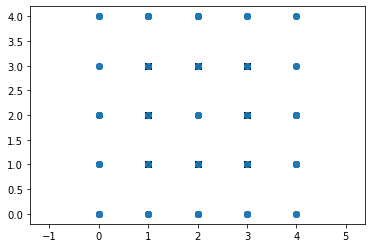

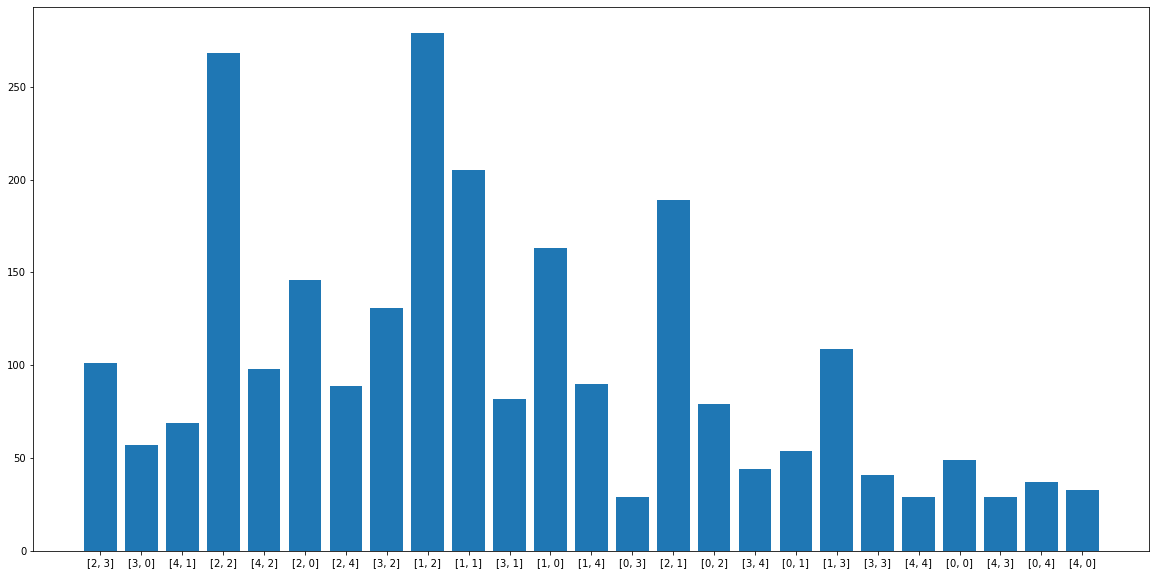

Processing Epoch 57
training start
Iteration 0, d real/fake loss 0.6630419492721558/0.6584737300872803 and g loss is 0.730481743812561, NDiv loss 0.04432016983628273
Iteration 1, d real/fake loss 0.6628047823905945/0.6760739088058472 and g loss is 0.7373102903366089, NDiv loss 0.047385260462760925
Iteration 2, d real/fake loss 0.6625722050666809/0.668009877204895 and g loss is 0.7255309820175171, NDiv loss 0.0479842871427536
Iteration 3, d real/fake loss 0.6623404622077942/0.6755521297454834 and g loss is 0.721184253692627, NDiv loss 0.04488366097211838
Iteration 4, d real/fake loss 0.6621147394180298/0.6746326684951782 and g loss is 0.7272260785102844, NDiv loss 0.0472710058093071


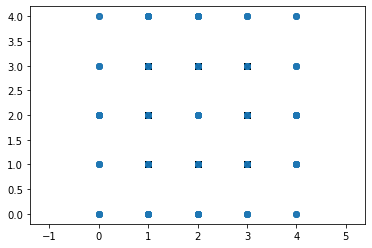

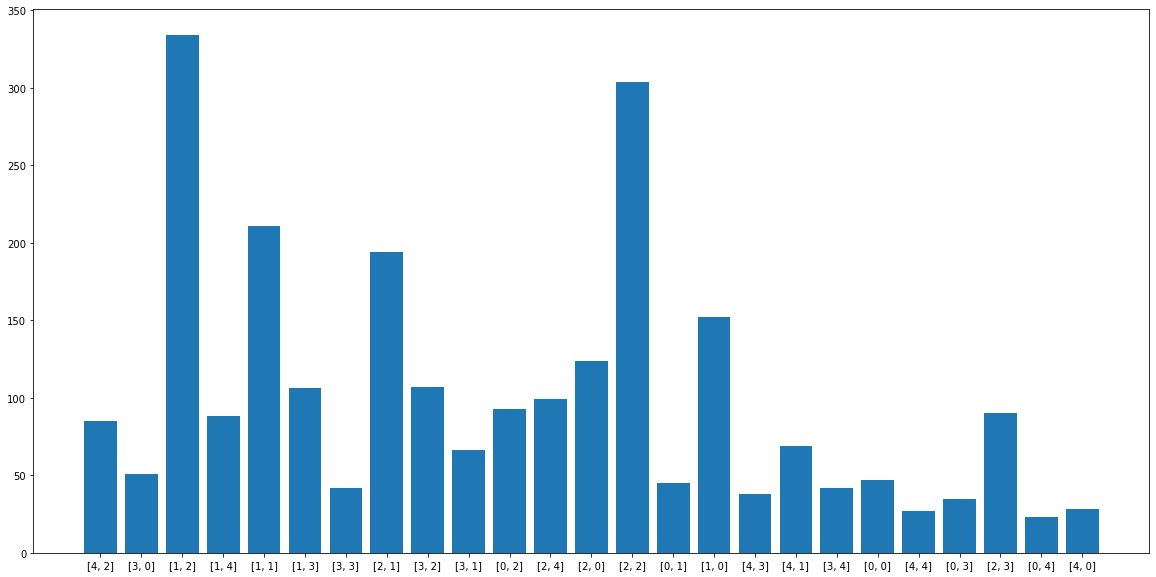

Processing Epoch 58
training start
Iteration 0, d real/fake loss 0.6587735414505005/0.6676119565963745 and g loss is 0.7305636405944824, NDiv loss 0.046159662306308746
Iteration 1, d real/fake loss 0.6586220264434814/0.6689413785934448 and g loss is 0.7283161878585815, NDiv loss 0.04501299932599068
Iteration 2, d real/fake loss 0.6584739685058594/0.6547523736953735 and g loss is 0.7199306488037109, NDiv loss 0.04351247474551201
Iteration 3, d real/fake loss 0.6583108901977539/0.6737868785858154 and g loss is 0.7209333181381226, NDiv loss 0.04144749045372009
Iteration 4, d real/fake loss 0.6581562161445618/0.660252571105957 and g loss is 0.726372241973877, NDiv loss 0.04089993238449097


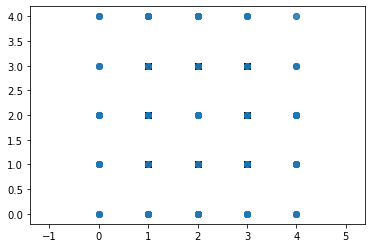

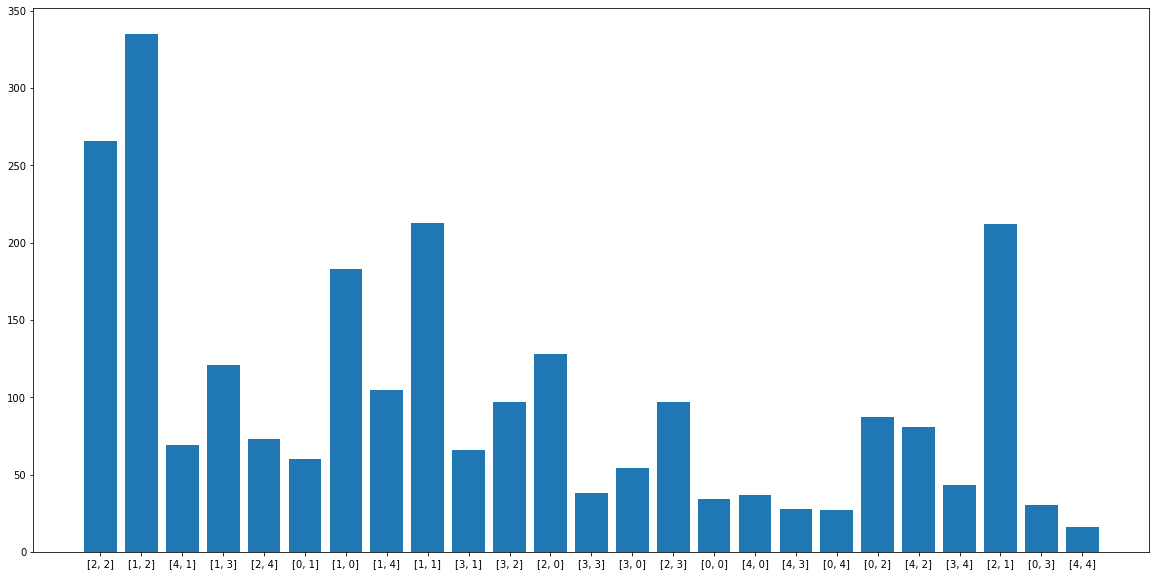

Processing Epoch 59
training start
Iteration 0, d real/fake loss 0.6625311374664307/0.6711969375610352 and g loss is 0.7190993428230286, NDiv loss 0.05237192288041115
Iteration 1, d real/fake loss 0.6623398065567017/0.6697486639022827 and g loss is 0.7268168330192566, NDiv loss 0.046040140092372894
Iteration 2, d real/fake loss 0.6621484160423279/0.6673128008842468 and g loss is 0.733544647693634, NDiv loss 0.048398327082395554
Iteration 3, d real/fake loss 0.6619592905044556/0.6854284405708313 and g loss is 0.7344754338264465, NDiv loss 0.043686870485544205
Iteration 4, d real/fake loss 0.6617847681045532/0.6622852683067322 and g loss is 0.7431702017784119, NDiv loss 0.039380401372909546


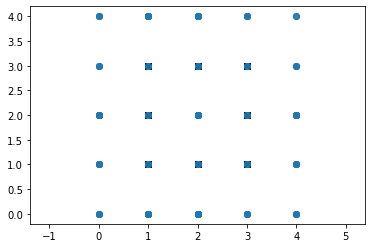

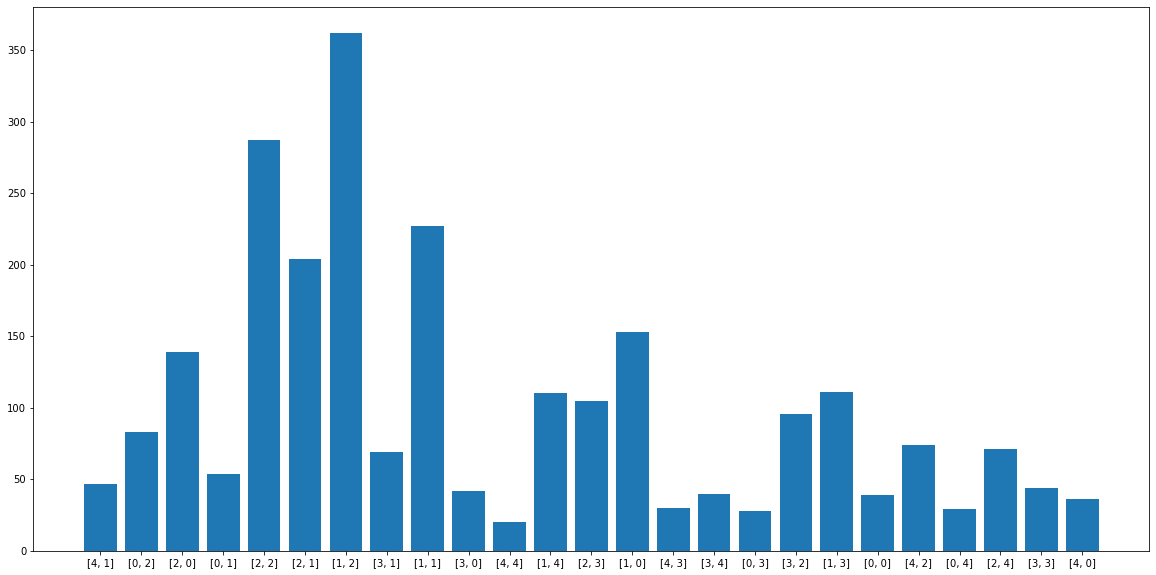

Processing Epoch 60
training start
Iteration 0, d real/fake loss 0.6581121683120728/0.6588687896728516 and g loss is 0.7362656593322754, NDiv loss 0.04501497372984886
Iteration 1, d real/fake loss 0.6580814719200134/0.6722177267074585 and g loss is 0.7158892154693604, NDiv loss 0.04187235236167908
Iteration 2, d real/fake loss 0.6580381393432617/0.6719370484352112 and g loss is 0.7450509071350098, NDiv loss 0.041835229843854904
Iteration 3, d real/fake loss 0.6579915285110474/0.6708751916885376 and g loss is 0.7224524021148682, NDiv loss 0.048777054995298386
Iteration 4, d real/fake loss 0.6579314470291138/0.6777685880661011 and g loss is 0.7297935485839844, NDiv loss 0.05109080299735069


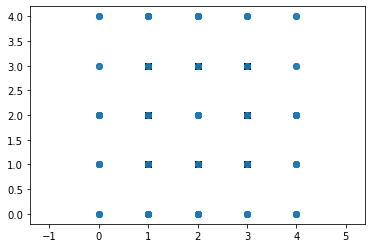

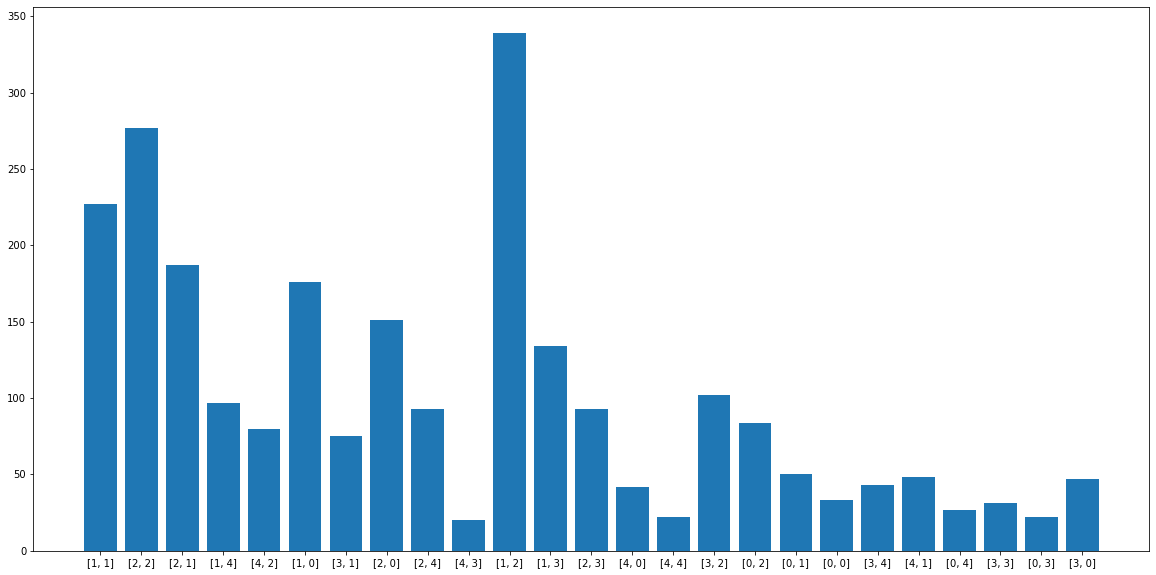

Processing Epoch 61
training start
Iteration 0, d real/fake loss 0.6588377952575684/0.6544198989868164 and g loss is 0.7321696877479553, NDiv loss 0.03822493180632591
Iteration 1, d real/fake loss 0.6586699485778809/0.6558279991149902 and g loss is 0.7292426824569702, NDiv loss 0.042517803609371185
Iteration 2, d real/fake loss 0.6584944725036621/0.670195996761322 and g loss is 0.724468469619751, NDiv loss 0.05272369459271431
Iteration 3, d real/fake loss 0.6583319902420044/0.6749640703201294 and g loss is 0.7234808206558228, NDiv loss 0.04196546599268913
Iteration 4, d real/fake loss 0.6581733226776123/0.6646868586540222 and g loss is 0.7354907989501953, NDiv loss 0.04479489102959633


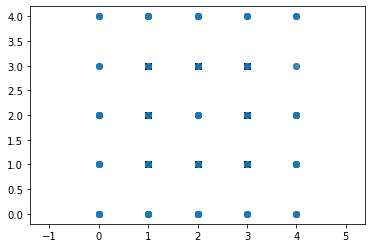

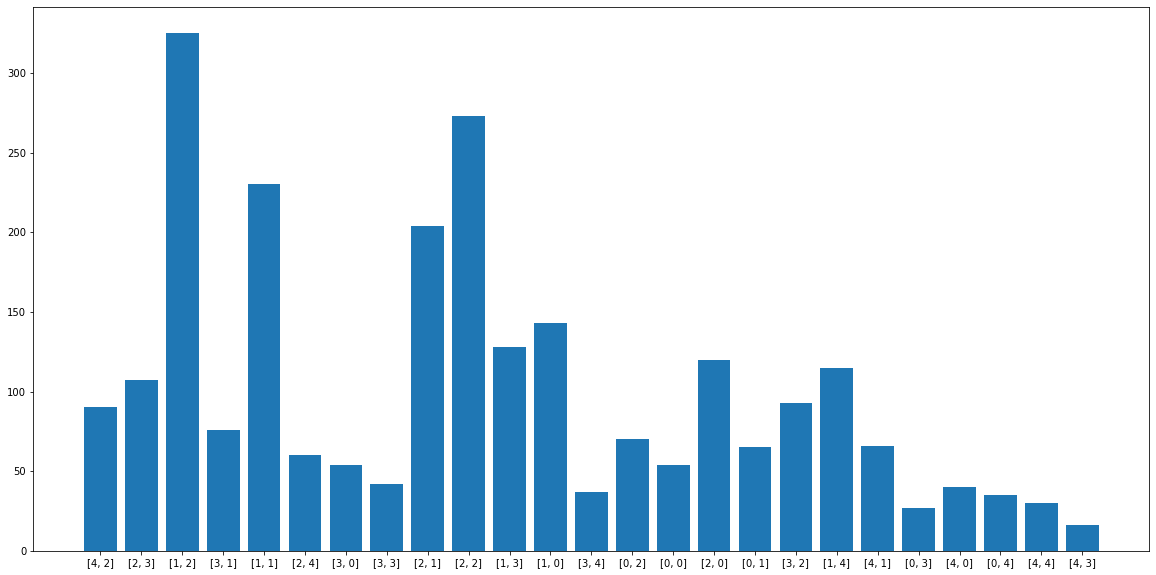

Processing Epoch 62
training start
Iteration 0, d real/fake loss 0.6599411368370056/0.6542994976043701 and g loss is 0.7280222177505493, NDiv loss 0.04267406836152077
Iteration 1, d real/fake loss 0.6597794890403748/0.6673229336738586 and g loss is 0.7266703248023987, NDiv loss 0.054801780730485916
Iteration 2, d real/fake loss 0.6596161127090454/0.6550717353820801 and g loss is 0.7280856966972351, NDiv loss 0.04343614727258682
Iteration 3, d real/fake loss 0.6594460010528564/0.656745433807373 and g loss is 0.7281351089477539, NDiv loss 0.048491500318050385
Iteration 4, d real/fake loss 0.6592661142349243/0.6664316058158875 and g loss is 0.7356489896774292, NDiv loss 0.0480811707675457


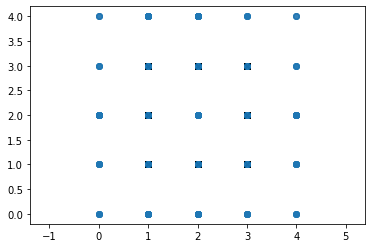

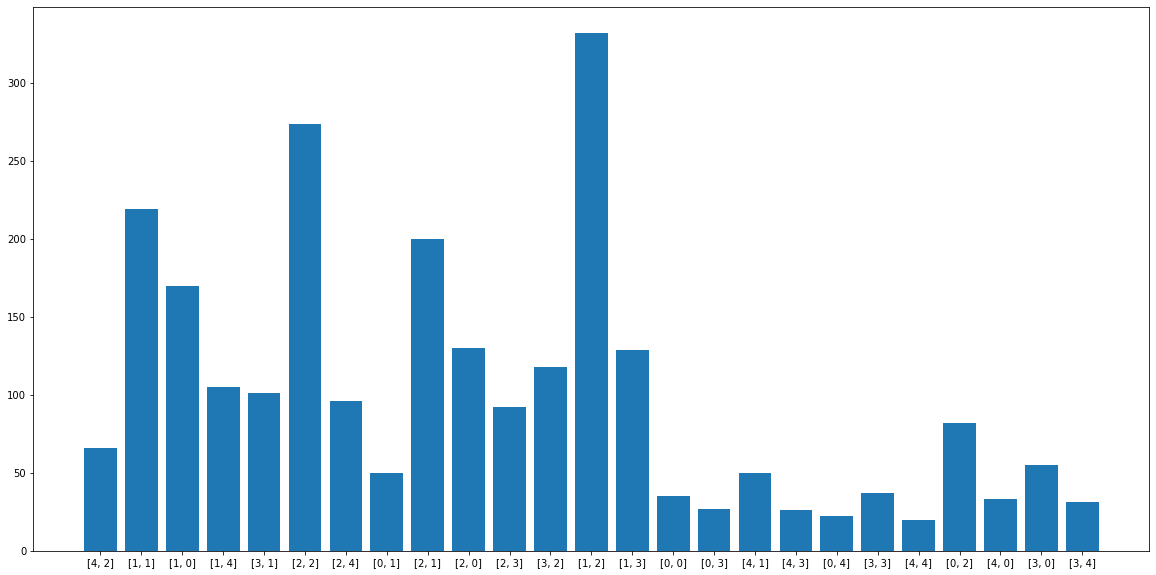

Processing Epoch 63
training start
Iteration 0, d real/fake loss 0.6586963534355164/0.6713485717773438 and g loss is 0.7347835898399353, NDiv loss 0.054271385073661804
Iteration 1, d real/fake loss 0.6585001945495605/0.6643356084823608 and g loss is 0.7333941459655762, NDiv loss 0.04026010259985924
Iteration 2, d real/fake loss 0.6583034992218018/0.6551167368888855 and g loss is 0.717896580696106, NDiv loss 0.05360934138298035
Iteration 3, d real/fake loss 0.6580929160118103/0.6768665909767151 and g loss is 0.7503818869590759, NDiv loss 0.043194692581892014
Iteration 4, d real/fake loss 0.6578840017318726/0.6568559408187866 and g loss is 0.7300827503204346, NDiv loss 0.04223552346229553


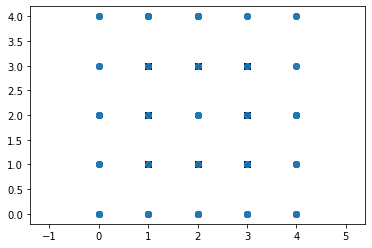

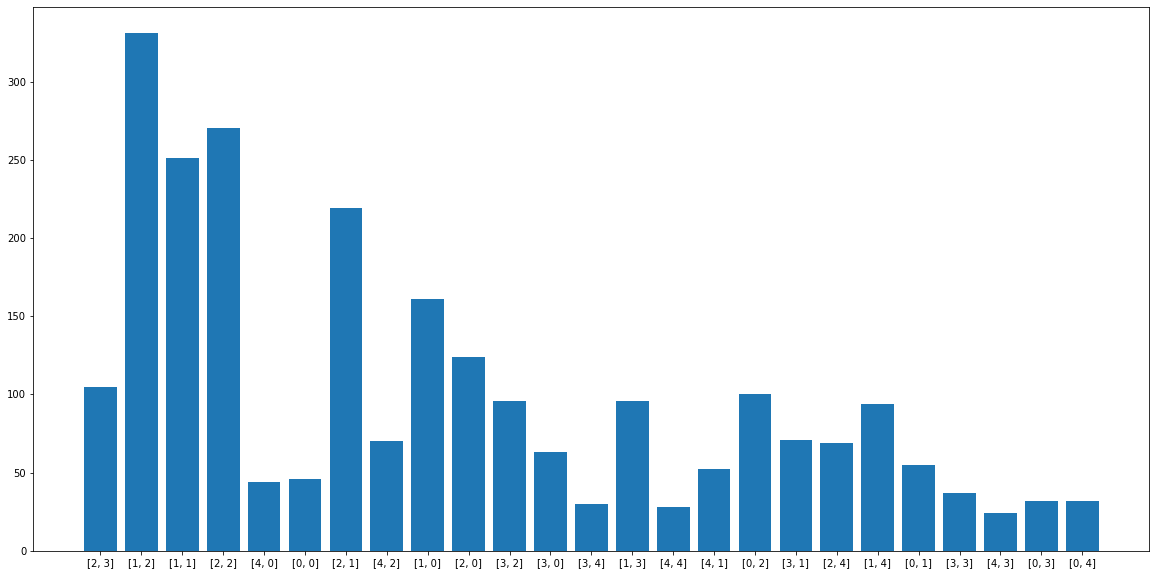

Processing Epoch 64
training start
Iteration 0, d real/fake loss 0.6572698950767517/0.6650642156600952 and g loss is 0.7359400987625122, NDiv loss 0.04803577437996864
Iteration 1, d real/fake loss 0.6570873260498047/0.6678305864334106 and g loss is 0.7357954382896423, NDiv loss 0.045346200466156006
Iteration 2, d real/fake loss 0.6569144129753113/0.6655867695808411 and g loss is 0.7267963290214539, NDiv loss 0.053167760372161865
Iteration 3, d real/fake loss 0.6567463278770447/0.6560350656509399 and g loss is 0.7313445806503296, NDiv loss 0.04337295889854431
Iteration 4, d real/fake loss 0.6565715670585632/0.6594698429107666 and g loss is 0.7327451705932617, NDiv loss 0.04484662041068077


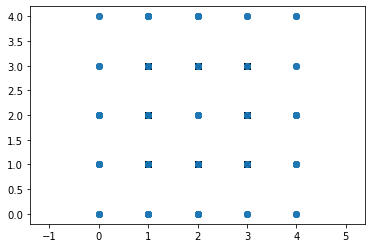

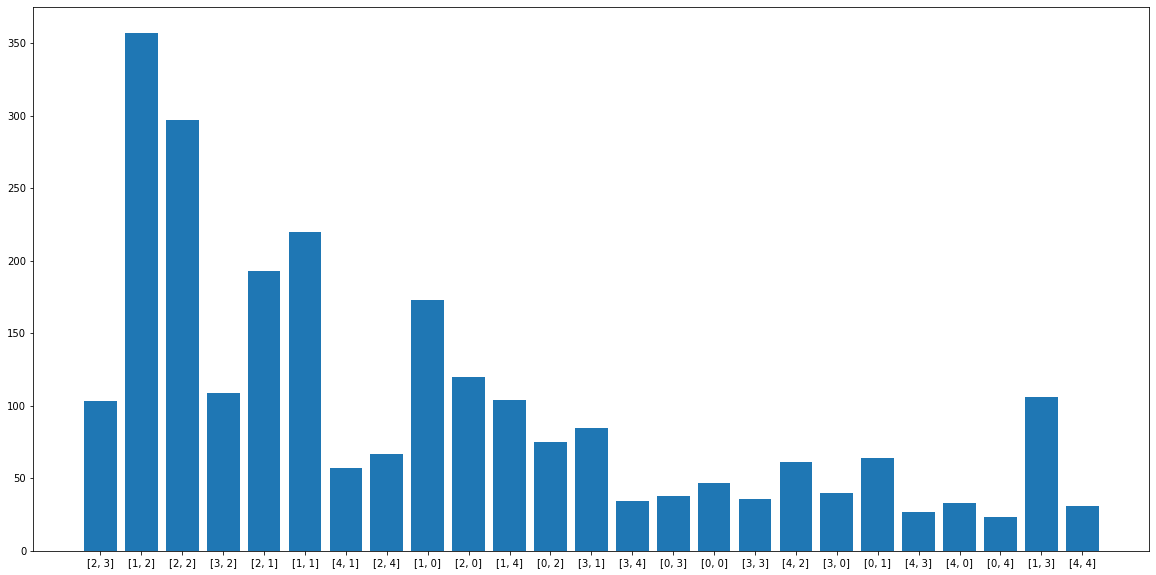

Processing Epoch 65
training start
Iteration 0, d real/fake loss 0.6579197645187378/0.6737351417541504 and g loss is 0.7240570783615112, NDiv loss 0.05221746861934662
Iteration 1, d real/fake loss 0.6577689051628113/0.6607875823974609 and g loss is 0.7283048629760742, NDiv loss 0.04853428527712822
Iteration 2, d real/fake loss 0.6576126217842102/0.6658620834350586 and g loss is 0.7241204977035522, NDiv loss 0.05109049379825592
Iteration 3, d real/fake loss 0.6574581861495972/0.6717163920402527 and g loss is 0.7312923073768616, NDiv loss 0.04821202531456947
Iteration 4, d real/fake loss 0.6573052406311035/0.669314980506897 and g loss is 0.7519444227218628, NDiv loss 0.04476957768201828


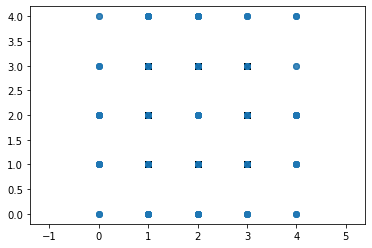

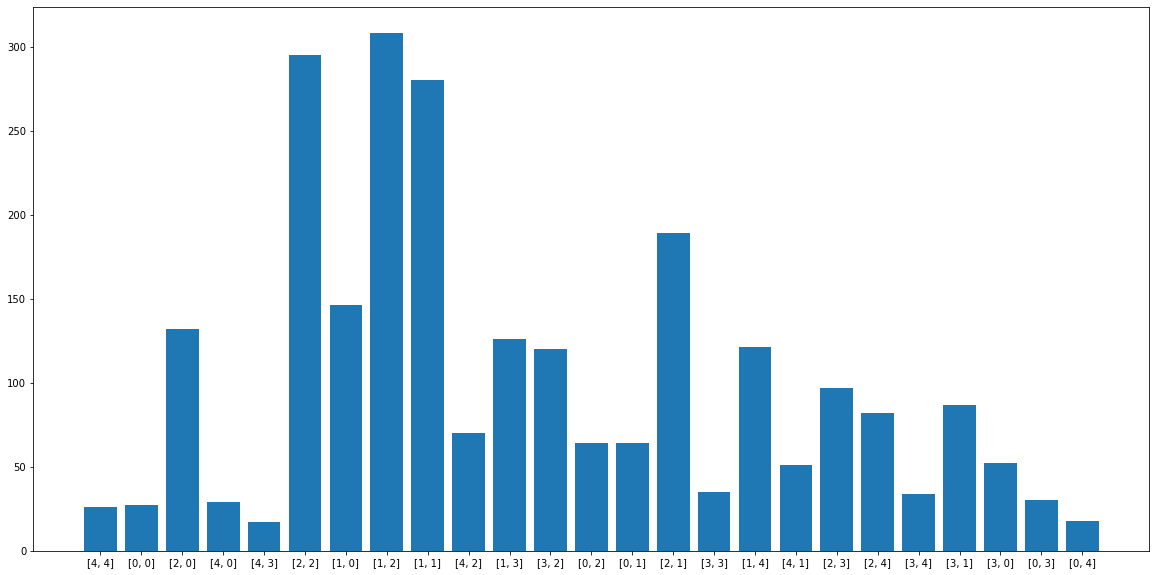

Processing Epoch 66
training start
Iteration 0, d real/fake loss 0.657971203327179/0.6676663160324097 and g loss is 0.7417812347412109, NDiv loss 0.045272063463926315
Iteration 1, d real/fake loss 0.6578689813613892/0.6810034513473511 and g loss is 0.7234717607498169, NDiv loss 0.05419702082872391
Iteration 2, d real/fake loss 0.6577706336975098/0.6700817942619324 and g loss is 0.7415871620178223, NDiv loss 0.05030135437846184
Iteration 3, d real/fake loss 0.6576569676399231/0.670484185218811 and g loss is 0.7346348762512207, NDiv loss 0.05532940849661827
Iteration 4, d real/fake loss 0.6575405597686768/0.6681571006774902 and g loss is 0.7394951581954956, NDiv loss 0.04289647936820984


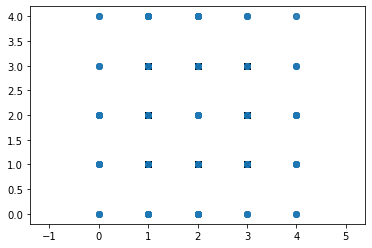

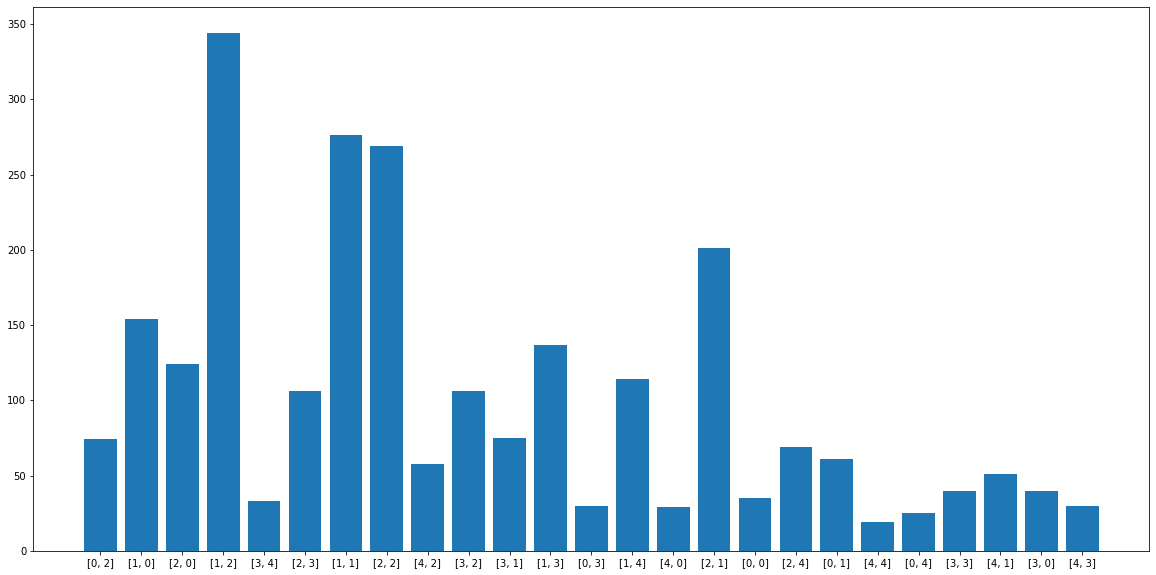

Processing Epoch 67
training start
Iteration 0, d real/fake loss 0.6577533483505249/0.6651740074157715 and g loss is 0.7413369417190552, NDiv loss 0.05009394884109497
Iteration 1, d real/fake loss 0.6576031446456909/0.6512712240219116 and g loss is 0.7283642292022705, NDiv loss 0.053567033261060715
Iteration 2, d real/fake loss 0.6574429273605347/0.6581327319145203 and g loss is 0.7405455112457275, NDiv loss 0.04302331805229187
Iteration 3, d real/fake loss 0.6572770476341248/0.6613144278526306 and g loss is 0.7267027497291565, NDiv loss 0.04252251610159874
Iteration 4, d real/fake loss 0.657111406326294/0.6633288264274597 and g loss is 0.7294350862503052, NDiv loss 0.046219341456890106


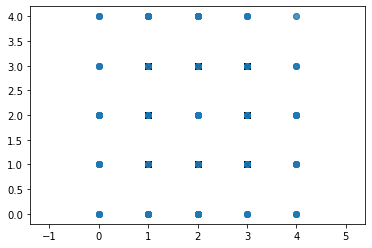

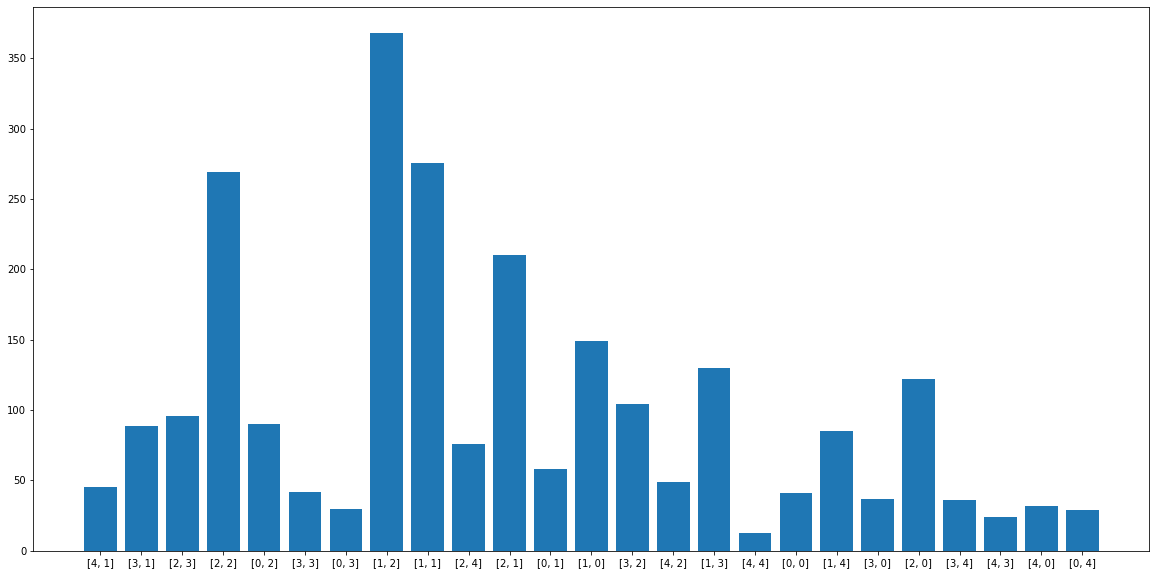

Processing Epoch 68
training start
Iteration 0, d real/fake loss 0.6570550799369812/0.6513667106628418 and g loss is 0.7257528305053711, NDiv loss 0.05395113304257393
Iteration 1, d real/fake loss 0.6568644642829895/0.6565819978713989 and g loss is 0.7351754903793335, NDiv loss 0.054081324487924576
Iteration 2, d real/fake loss 0.6566678285598755/0.6657249331474304 and g loss is 0.7211976051330566, NDiv loss 0.048976052552461624
Iteration 3, d real/fake loss 0.656475305557251/0.6693728566169739 and g loss is 0.7301358580589294, NDiv loss 0.051362939178943634
Iteration 4, d real/fake loss 0.6562915444374084/0.6536373496055603 and g loss is 0.7340835332870483, NDiv loss 0.04460081830620766


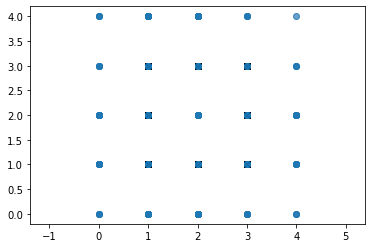

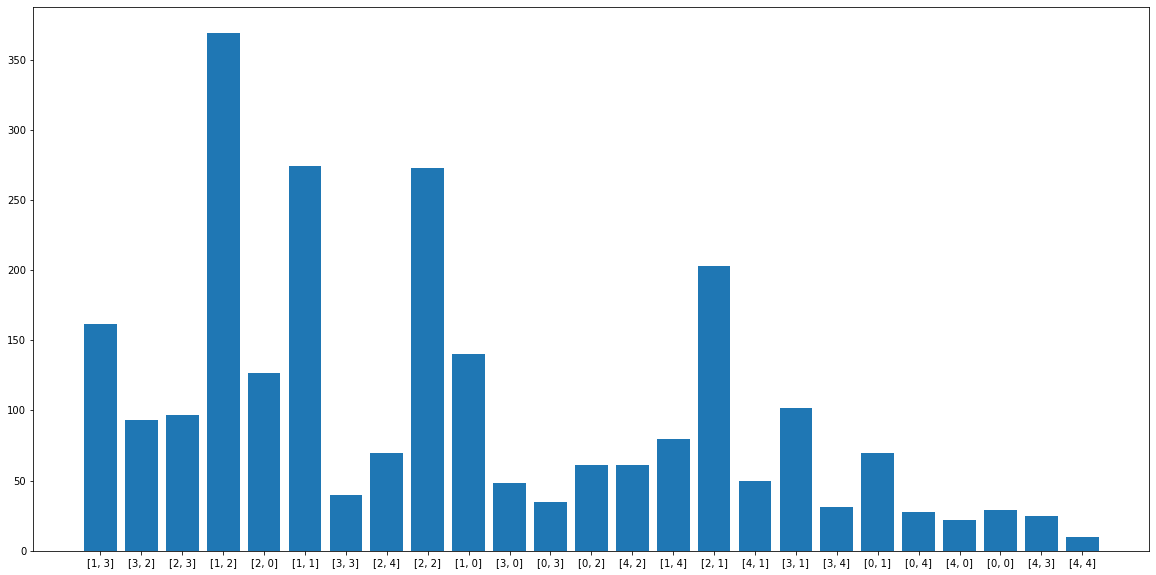

Processing Epoch 69
training start
Iteration 0, d real/fake loss 0.6520478129386902/0.6657301187515259 and g loss is 0.7308490872383118, NDiv loss 0.039057664573192596
Iteration 1, d real/fake loss 0.6519354581832886/0.6635814905166626 and g loss is 0.7198096513748169, NDiv loss 0.047760482877492905
Iteration 2, d real/fake loss 0.6518242955207825/0.6598795652389526 and g loss is 0.7235643267631531, NDiv loss 0.050786666572093964
Iteration 3, d real/fake loss 0.6517025232315063/0.6770766973495483 and g loss is 0.7370157241821289, NDiv loss 0.04537566751241684
Iteration 4, d real/fake loss 0.6515786647796631/0.644207239151001 and g loss is 0.7254401445388794, NDiv loss 0.05373122915625572


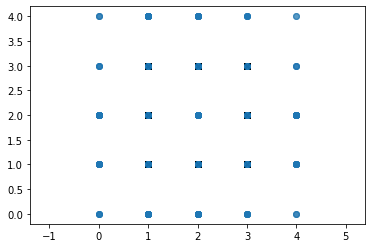

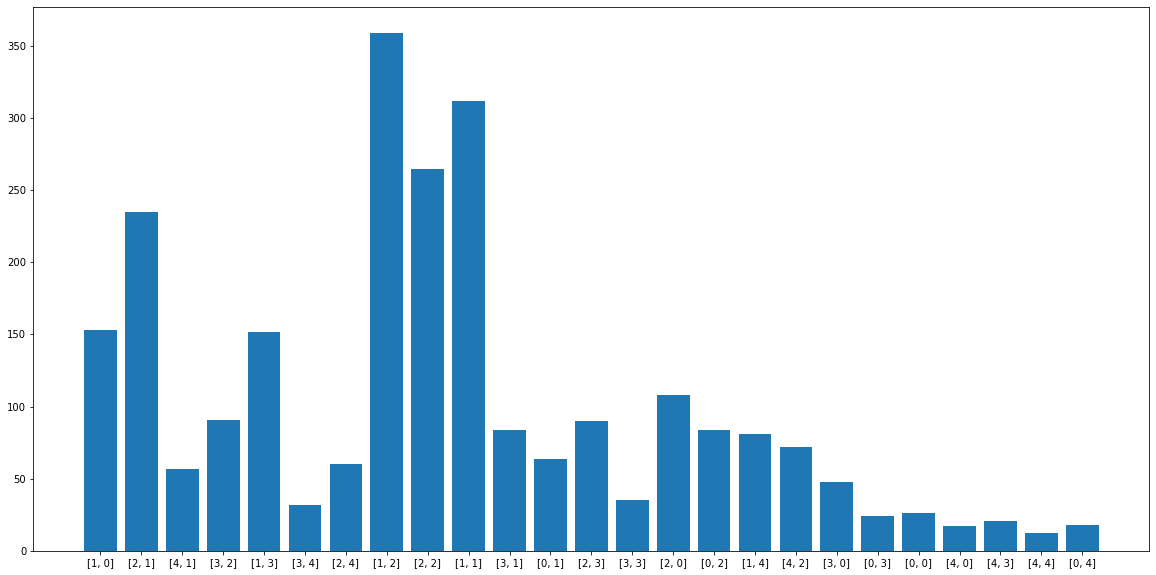

Processing Epoch 70
training start
Iteration 0, d real/fake loss 0.6522504091262817/0.6653216481208801 and g loss is 0.7273045778274536, NDiv loss 0.043994974344968796
Iteration 1, d real/fake loss 0.6520928740501404/0.6641277074813843 and g loss is 0.7348291873931885, NDiv loss 0.059129226952791214
Iteration 2, d real/fake loss 0.6519415378570557/0.6528889536857605 and g loss is 0.7200543284416199, NDiv loss 0.046326249837875366
Iteration 3, d real/fake loss 0.6517871022224426/0.6688449382781982 and g loss is 0.7209551334381104, NDiv loss 0.05470329895615578
Iteration 4, d real/fake loss 0.6516437530517578/0.664114236831665 and g loss is 0.7324180006980896, NDiv loss 0.05563294515013695


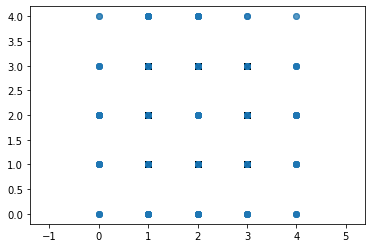

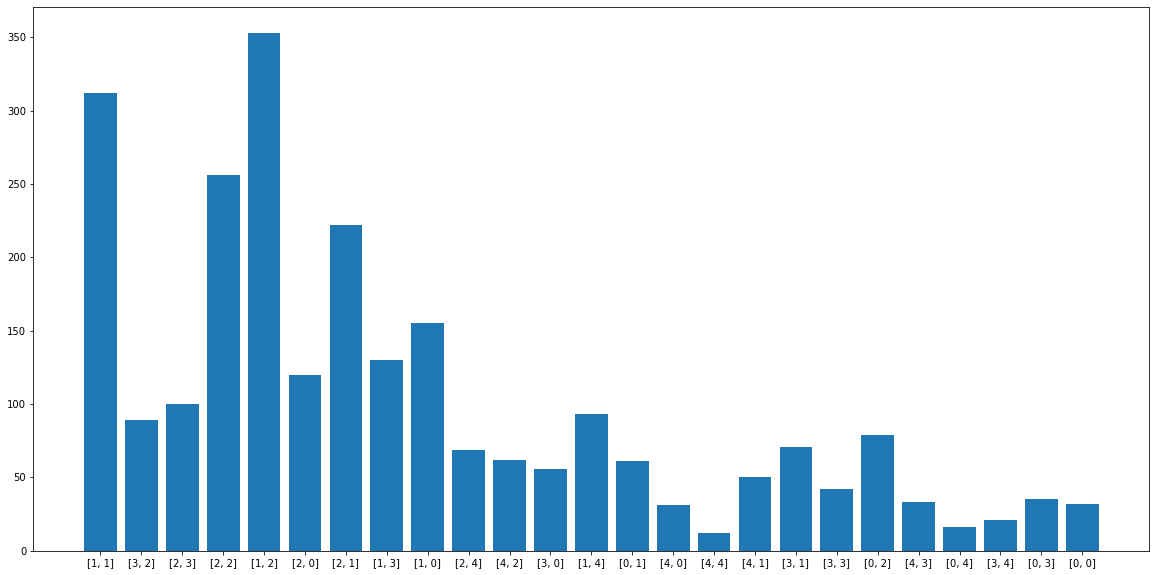

Processing Epoch 71
training start
Iteration 0, d real/fake loss 0.6506590247154236/0.6754193305969238 and g loss is 0.7255300283432007, NDiv loss 0.047368310391902924
Iteration 1, d real/fake loss 0.6505270600318909/0.6705870032310486 and g loss is 0.7358785271644592, NDiv loss 0.05069545656442642
Iteration 2, d real/fake loss 0.6504029035568237/0.6710920333862305 and g loss is 0.7227917909622192, NDiv loss 0.04414409026503563
Iteration 3, d real/fake loss 0.6502823829650879/0.6632953882217407 and g loss is 0.7418169975280762, NDiv loss 0.03865160793066025
Iteration 4, d real/fake loss 0.6501590013504028/0.6569712162017822 and g loss is 0.7369815111160278, NDiv loss 0.058355361223220825


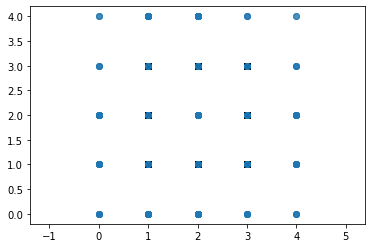

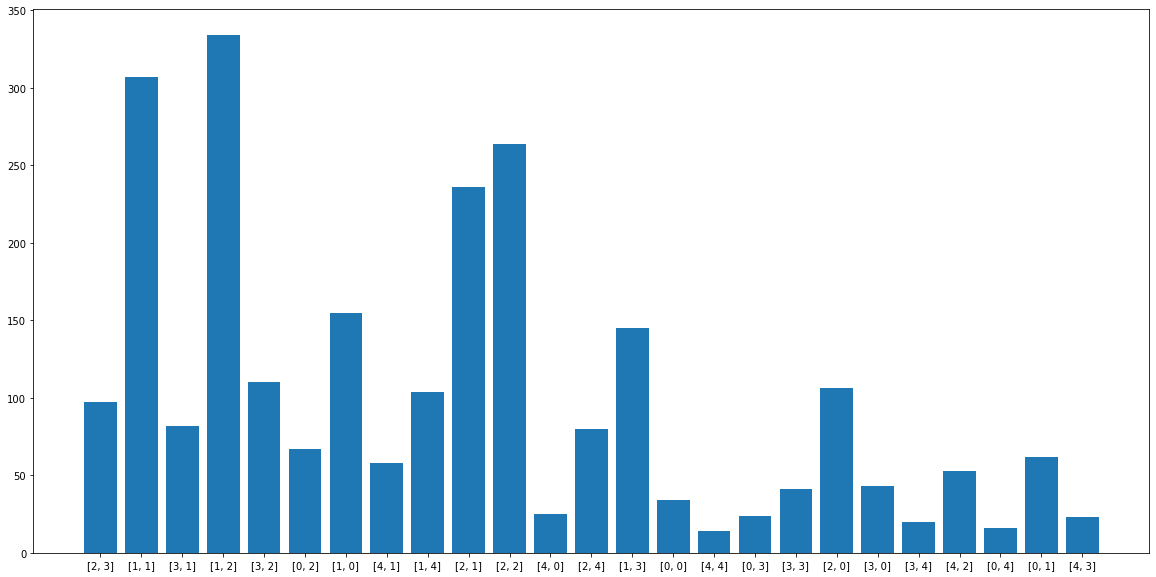

Processing Epoch 72
training start
Iteration 0, d real/fake loss 0.6511147022247314/0.6737755537033081 and g loss is 0.7294231653213501, NDiv loss 0.04628865048289299
Iteration 1, d real/fake loss 0.651016354560852/0.6618402004241943 and g loss is 0.7425323128700256, NDiv loss 0.05015822872519493
Iteration 2, d real/fake loss 0.6509041786193848/0.6591253280639648 and g loss is 0.7430728673934937, NDiv loss 0.0481141060590744
Iteration 3, d real/fake loss 0.6507834196090698/0.6602848768234253 and g loss is 0.7389072179794312, NDiv loss 0.04063922539353371
Iteration 4, d real/fake loss 0.6506588459014893/0.6583908796310425 and g loss is 0.7251522541046143, NDiv loss 0.04842444509267807


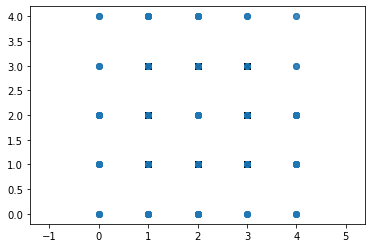

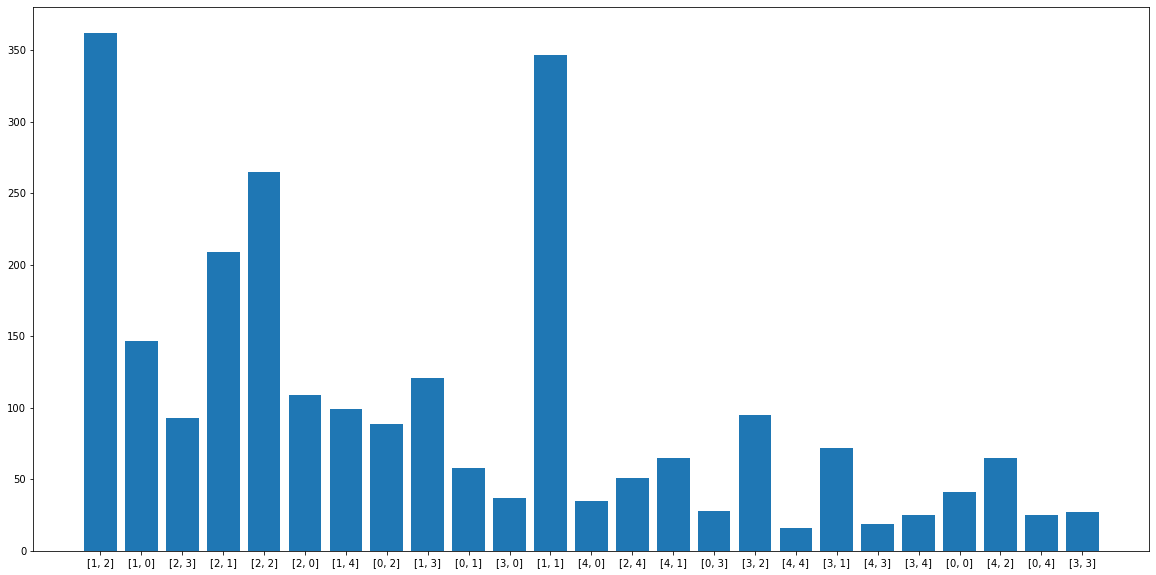

Processing Epoch 73
training start
Iteration 0, d real/fake loss 0.6495621204376221/0.6564373970031738 and g loss is 0.7356092929840088, NDiv loss 0.054561492055654526
Iteration 1, d real/fake loss 0.6494908332824707/0.6595553159713745 and g loss is 0.7333176136016846, NDiv loss 0.048597220331430435
Iteration 2, d real/fake loss 0.649411678314209/0.6725616455078125 and g loss is 0.7315261363983154, NDiv loss 0.04278522729873657
Iteration 3, d real/fake loss 0.6493331789970398/0.6479088068008423 and g loss is 0.7275784015655518, NDiv loss 0.053276341408491135
Iteration 4, d real/fake loss 0.6492292881011963/0.6643416285514832 and g loss is 0.7296438813209534, NDiv loss 0.045025650411844254


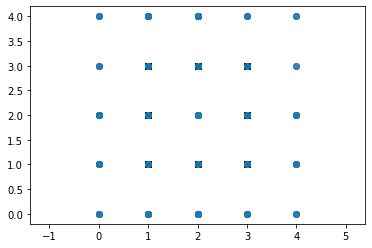

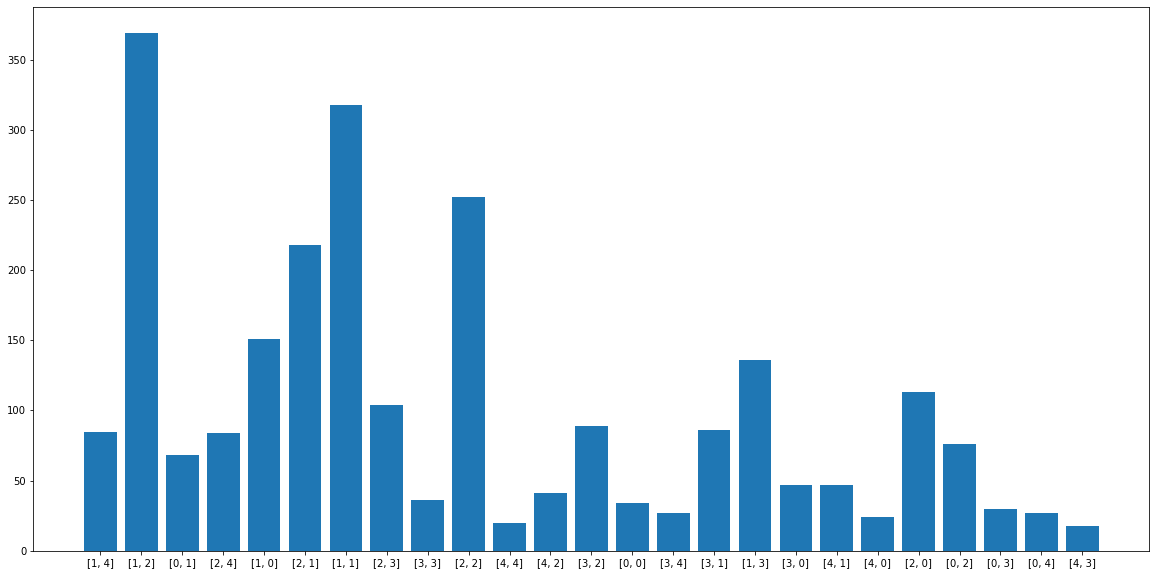

Processing Epoch 74
training start
Iteration 0, d real/fake loss 0.6468548774719238/0.6594775319099426 and g loss is 0.7233266234397888, NDiv loss 0.04595678672194481
Iteration 1, d real/fake loss 0.6466951370239258/0.6635866761207581 and g loss is 0.749893069267273, NDiv loss 0.04122726246714592
Iteration 2, d real/fake loss 0.6465429067611694/0.6571353673934937 and g loss is 0.7243451476097107, NDiv loss 0.0571088045835495
Iteration 3, d real/fake loss 0.6463875770568848/0.667326033115387 and g loss is 0.7368013858795166, NDiv loss 0.0563470721244812
Iteration 4, d real/fake loss 0.6462428569793701/0.6632074117660522 and g loss is 0.7262297868728638, NDiv loss 0.052014999091625214


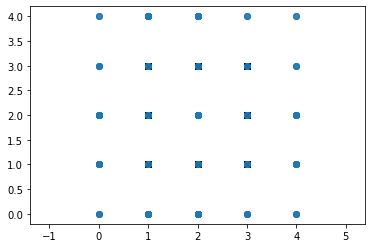

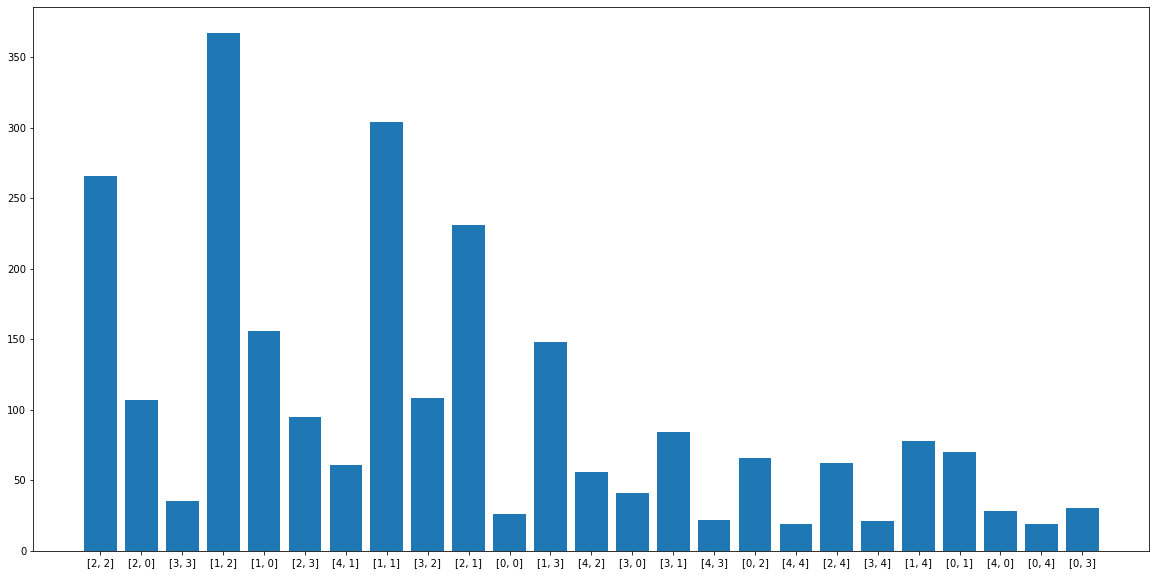

Processing Epoch 75
training start
Iteration 0, d real/fake loss 0.6374993324279785/0.6606208086013794 and g loss is 0.7193552255630493, NDiv loss 0.05726435407996178
Iteration 1, d real/fake loss 0.6373162865638733/0.6592552065849304 and g loss is 0.7297849059104919, NDiv loss 0.055083032697439194
Iteration 2, d real/fake loss 0.6371338367462158/0.6603301763534546 and g loss is 0.7456549406051636, NDiv loss 0.05564235523343086
Iteration 3, d real/fake loss 0.6369478702545166/0.6555237174034119 and g loss is 0.7428295016288757, NDiv loss 0.0457846075296402
Iteration 4, d real/fake loss 0.6367594003677368/0.6674948334693909 and g loss is 0.7153688669204712, NDiv loss 0.0492999441921711


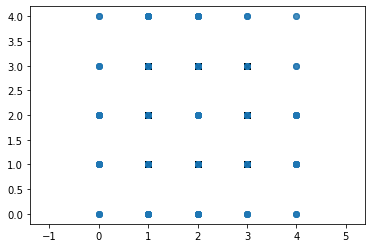

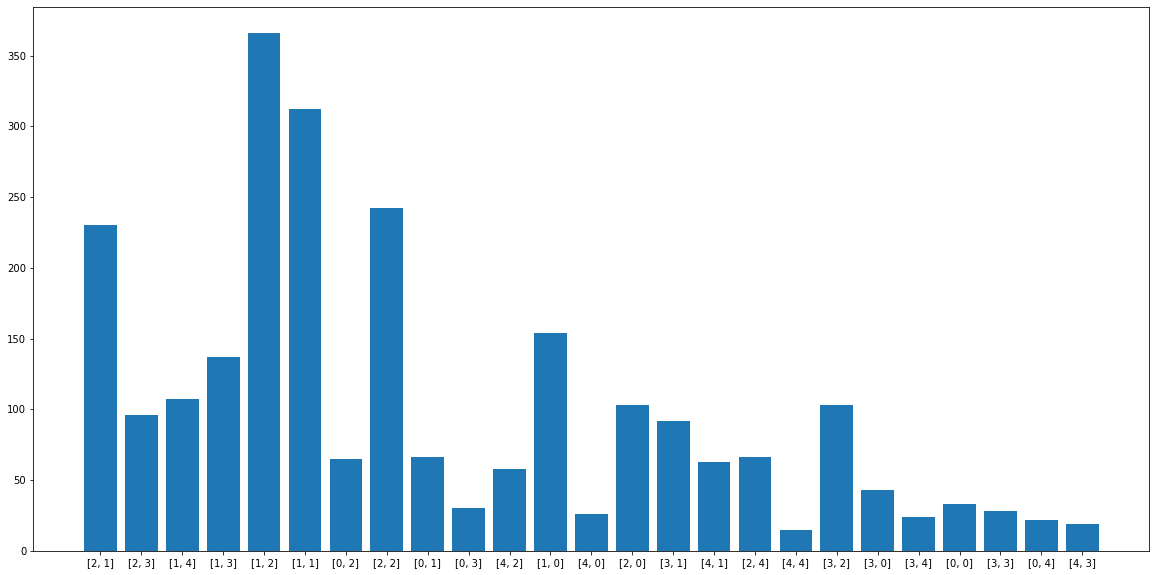

Processing Epoch 76
training start
Iteration 0, d real/fake loss 0.6499266624450684/0.6631960868835449 and g loss is 0.7298734188079834, NDiv loss 0.04674994572997093
Iteration 1, d real/fake loss 0.6498953104019165/0.6664927005767822 and g loss is 0.7351492047309875, NDiv loss 0.04946092888712883
Iteration 2, d real/fake loss 0.64985191822052/0.6475762128829956 and g loss is 0.7290984392166138, NDiv loss 0.047617264091968536
Iteration 3, d real/fake loss 0.6497898101806641/0.6582052111625671 and g loss is 0.7329695224761963, NDiv loss 0.05860099196434021
Iteration 4, d real/fake loss 0.6497195363044739/0.6592331528663635 and g loss is 0.7337023019790649, NDiv loss 0.05317196622490883


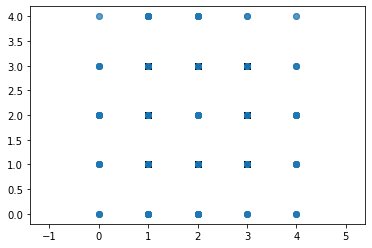

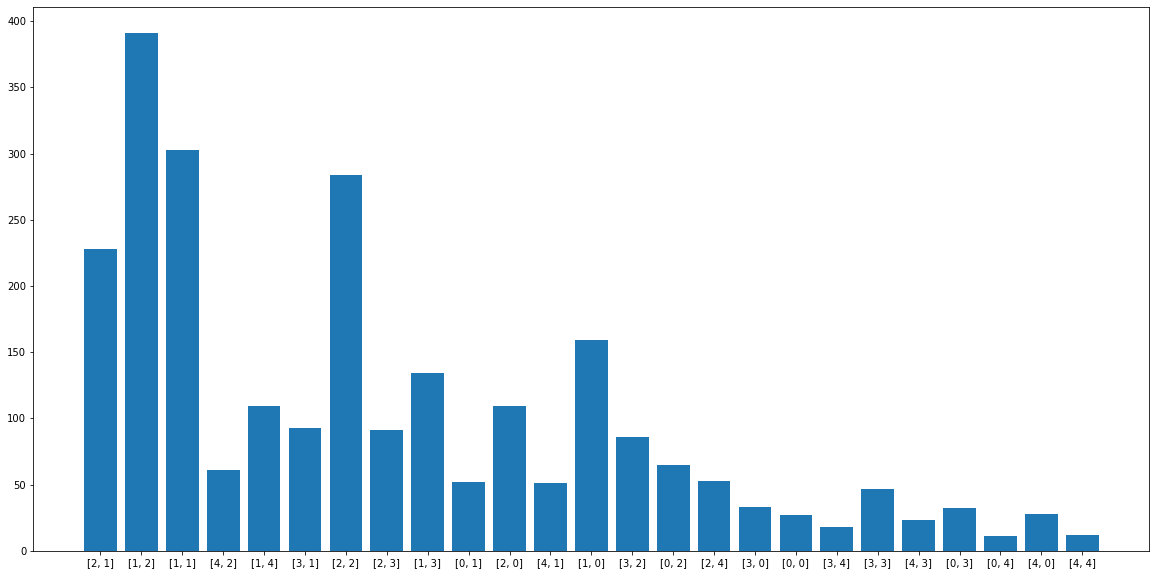

Processing Epoch 77
training start
Iteration 0, d real/fake loss 0.6498855352401733/0.6614152193069458 and g loss is 0.7284801006317139, NDiv loss 0.0549987256526947
Iteration 1, d real/fake loss 0.6497672200202942/0.671294093132019 and g loss is 0.7244625091552734, NDiv loss 0.04908009618520737
Iteration 2, d real/fake loss 0.6496503949165344/0.6595853567123413 and g loss is 0.7466862201690674, NDiv loss 0.05117601901292801
Iteration 3, d real/fake loss 0.6495239734649658/0.6597462296485901 and g loss is 0.751203715801239, NDiv loss 0.049921683967113495
Iteration 4, d real/fake loss 0.6493937969207764/0.6536238789558411 and g loss is 0.7308710813522339, NDiv loss 0.05274255946278572


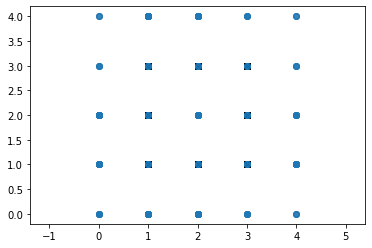

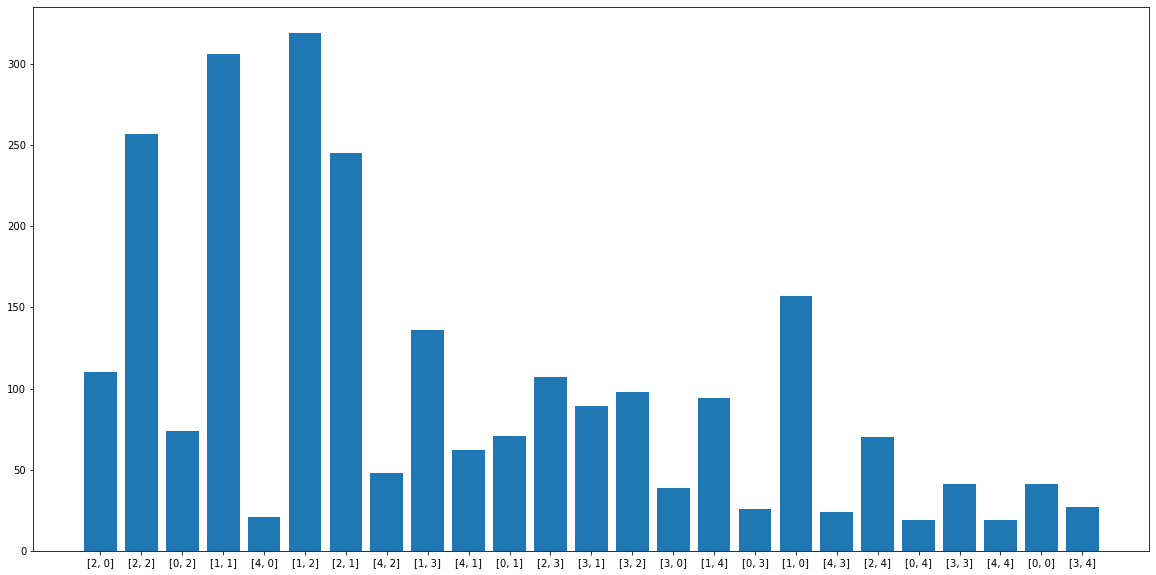

Processing Epoch 78
training start
Iteration 0, d real/fake loss 0.6560085415840149/0.6491461992263794 and g loss is 0.7370727062225342, NDiv loss 0.05171087756752968
Iteration 1, d real/fake loss 0.6559646725654602/0.6588976383209229 and g loss is 0.7396484613418579, NDiv loss 0.05901781842112541
Iteration 2, d real/fake loss 0.6559066772460938/0.664811909198761 and g loss is 0.7303438782691956, NDiv loss 0.04809855669736862
Iteration 3, d real/fake loss 0.6558380722999573/0.6439406275749207 and g loss is 0.7502646446228027, NDiv loss 0.0483878031373024
Iteration 4, d real/fake loss 0.6557403802871704/0.6610792279243469 and g loss is 0.7353392839431763, NDiv loss 0.05846315622329712


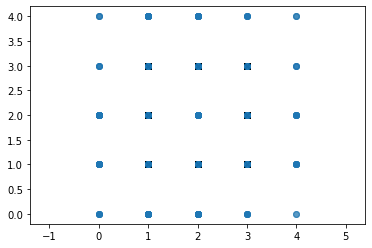

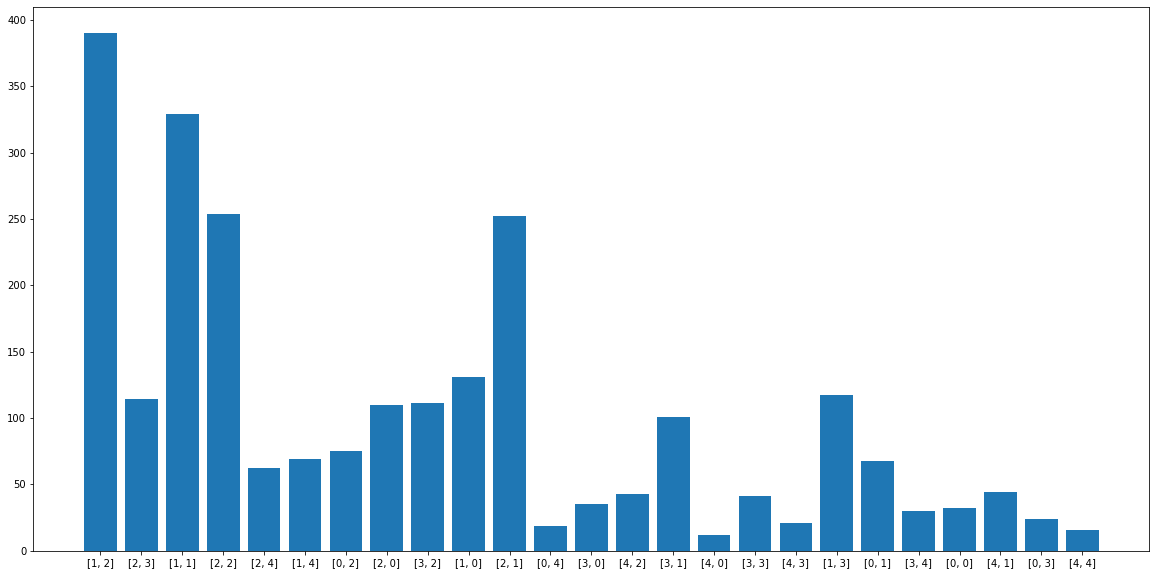

Processing Epoch 79
training start
Iteration 0, d real/fake loss 0.6471733450889587/0.6694415211677551 and g loss is 0.7292167544364929, NDiv loss 0.04706390202045441
Iteration 1, d real/fake loss 0.6470564603805542/0.654719352722168 and g loss is 0.7375229001045227, NDiv loss 0.05278419703245163
Iteration 2, d real/fake loss 0.646929919719696/0.6585062146186829 and g loss is 0.7335063219070435, NDiv loss 0.05467681959271431
Iteration 3, d real/fake loss 0.6467974185943604/0.6639533042907715 and g loss is 0.7397440671920776, NDiv loss 0.06532007455825806
Iteration 4, d real/fake loss 0.6466588973999023/0.6655694246292114 and g loss is 0.7487539052963257, NDiv loss 0.050852902233600616


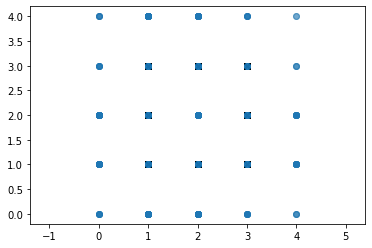

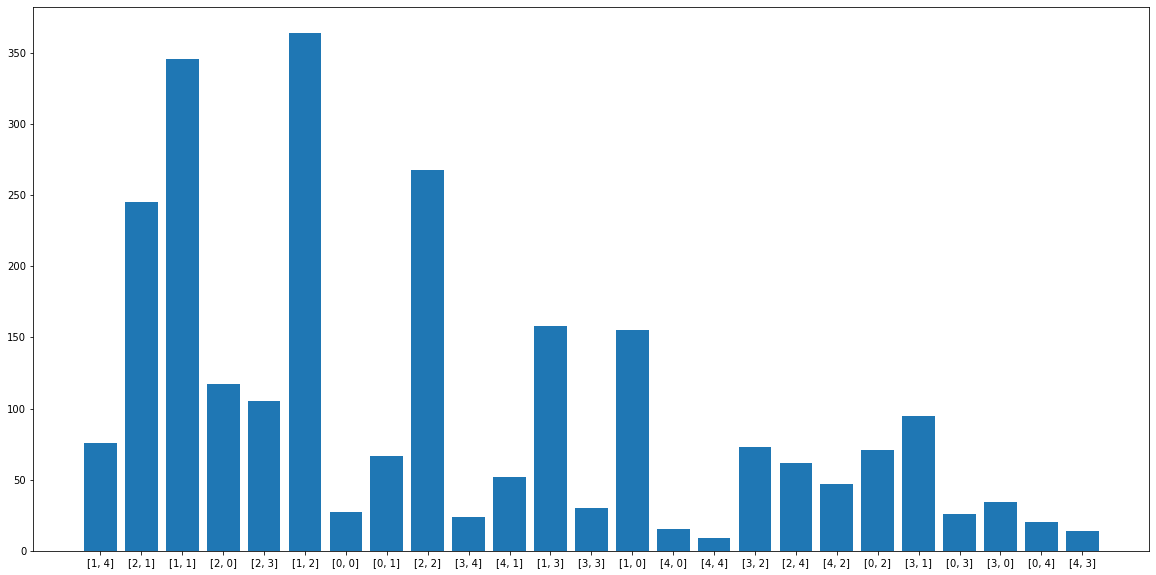

Processing Epoch 80
training start
Iteration 0, d real/fake loss 0.6493428945541382/0.6584082245826721 and g loss is 0.7405065894126892, NDiv loss 0.05535908788442612
Iteration 1, d real/fake loss 0.6492201089859009/0.6701990365982056 and g loss is 0.7257727980613708, NDiv loss 0.055418048053979874
Iteration 2, d real/fake loss 0.6491067409515381/0.6536841988563538 and g loss is 0.7326502799987793, NDiv loss 0.06364206224679947
Iteration 3, d real/fake loss 0.6489958763122559/0.6581950187683105 and g loss is 0.7396191358566284, NDiv loss 0.05159899592399597
Iteration 4, d real/fake loss 0.6488794088363647/0.648387610912323 and g loss is 0.7303266525268555, NDiv loss 0.05347675085067749


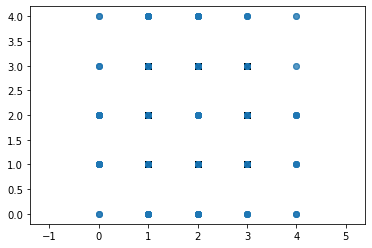

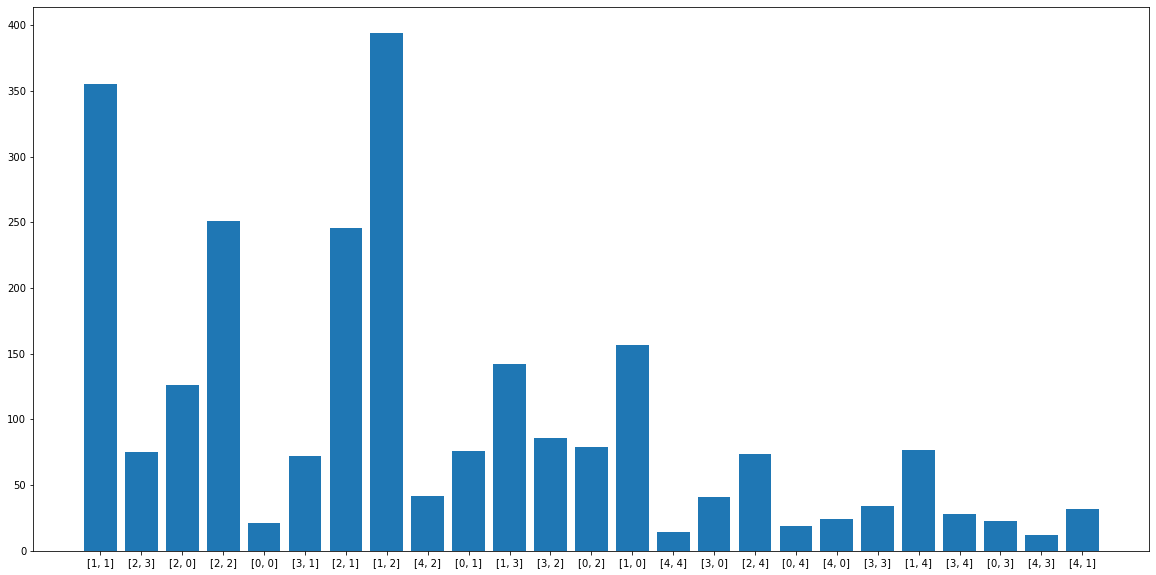

Processing Epoch 81
training start
Iteration 0, d real/fake loss 0.6355949640274048/0.6553797721862793 and g loss is 0.714218020439148, NDiv loss 0.06017080321907997
Iteration 1, d real/fake loss 0.6354195475578308/0.6580238342285156 and g loss is 0.7432160973548889, NDiv loss 0.05367613583803177
Iteration 2, d real/fake loss 0.6352481245994568/0.6754807233810425 and g loss is 0.7282061576843262, NDiv loss 0.05538420006632805
Iteration 3, d real/fake loss 0.635100245475769/0.665960431098938 and g loss is 0.7265130281448364, NDiv loss 0.05814707279205322
Iteration 4, d real/fake loss 0.6349635124206543/0.677405834197998 and g loss is 0.7357256412506104, NDiv loss 0.050503116101026535


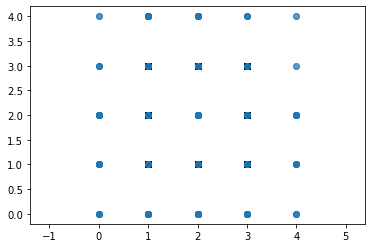

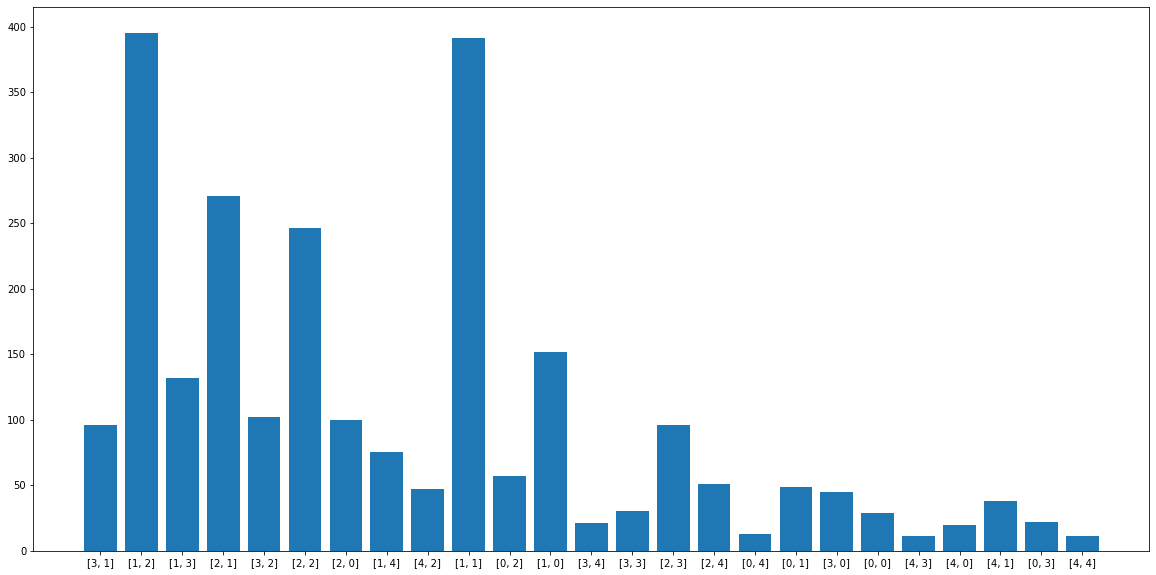

Processing Epoch 82
training start
Iteration 0, d real/fake loss 0.6415193676948547/0.6546294689178467 and g loss is 0.7281073331832886, NDiv loss 0.07671328634023666
Iteration 1, d real/fake loss 0.6414429545402527/0.6577521562576294 and g loss is 0.7238665223121643, NDiv loss 0.04667556285858154
Iteration 2, d real/fake loss 0.6413602828979492/0.6645429134368896 and g loss is 0.7474117279052734, NDiv loss 0.05508068576455116
Iteration 3, d real/fake loss 0.6412844657897949/0.6634674072265625 and g loss is 0.746080219745636, NDiv loss 0.059167396277189255
Iteration 4, d real/fake loss 0.6412124633789062/0.6659238934516907 and g loss is 0.7371093034744263, NDiv loss 0.06245597451925278


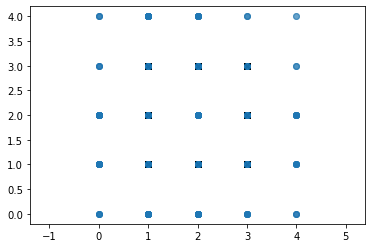

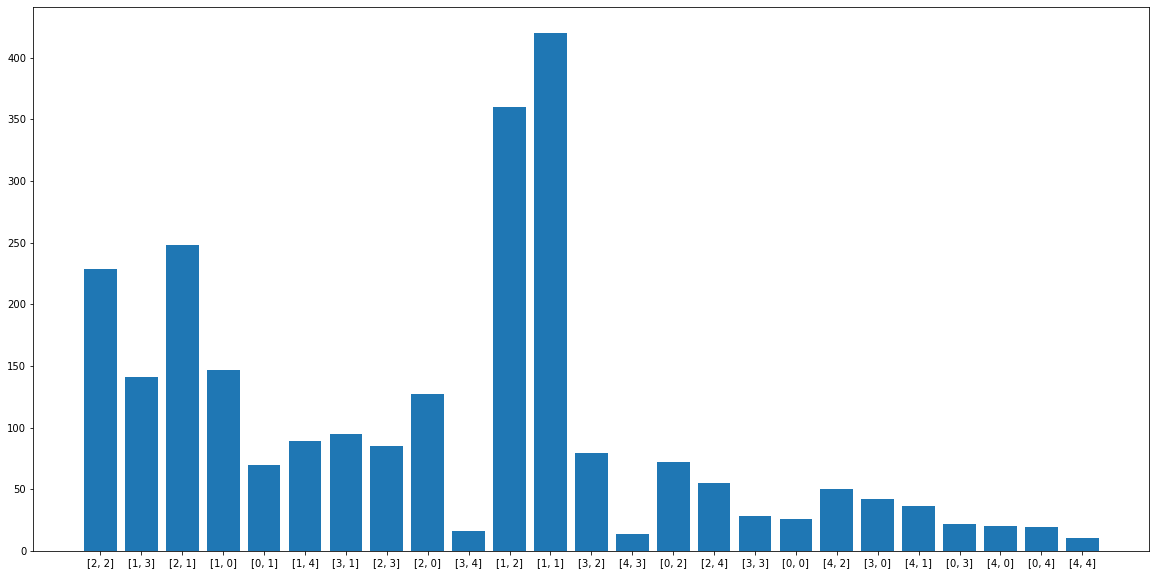

Processing Epoch 83
training start
Iteration 0, d real/fake loss 0.6401881575584412/0.6525833606719971 and g loss is 0.7314569354057312, NDiv loss 0.05152082443237305
Iteration 1, d real/fake loss 0.6400904655456543/0.6605704426765442 and g loss is 0.7303727269172668, NDiv loss 0.04775913059711456
Iteration 2, d real/fake loss 0.6399863362312317/0.6721733212471008 and g loss is 0.73268723487854, NDiv loss 0.058149538934230804
Iteration 3, d real/fake loss 0.6398870348930359/0.6540149450302124 and g loss is 0.7462131977081299, NDiv loss 0.05001748353242874
Iteration 4, d real/fake loss 0.6397738456726074/0.6703890562057495 and g loss is 0.7445623874664307, NDiv loss 0.05229383334517479


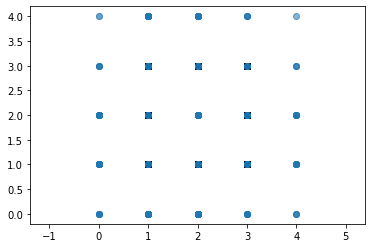

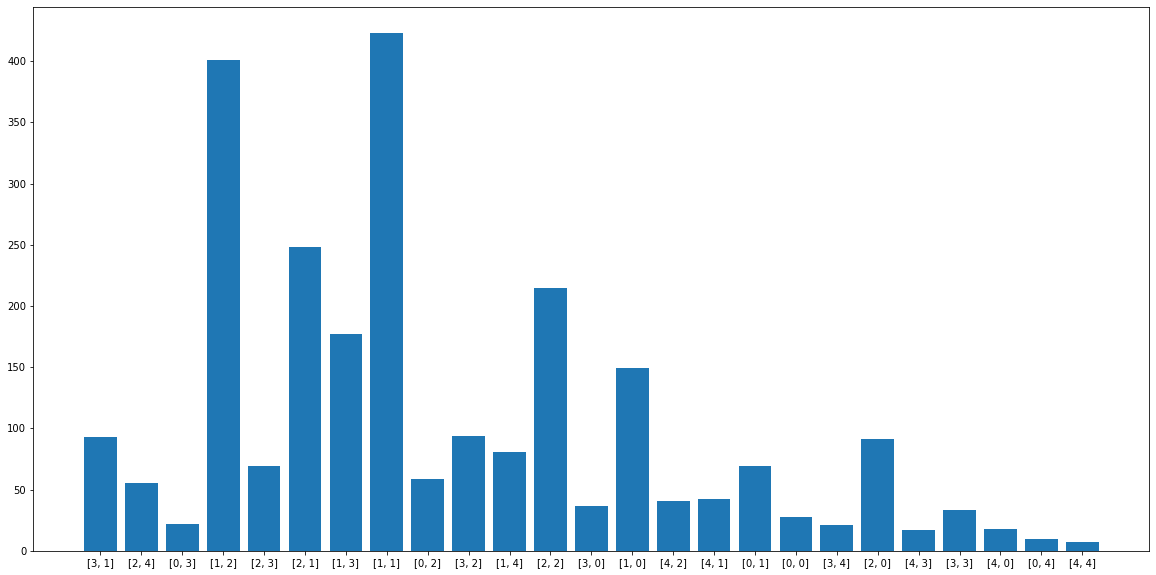

Processing Epoch 84
training start
Iteration 0, d real/fake loss 0.6368951797485352/0.6639975309371948 and g loss is 0.7295492887496948, NDiv loss 0.05857300013303757
Iteration 1, d real/fake loss 0.6368175745010376/0.6553508043289185 and g loss is 0.7366530895233154, NDiv loss 0.056756824254989624
Iteration 2, d real/fake loss 0.6367459297180176/0.6784558892250061 and g loss is 0.7473105192184448, NDiv loss 0.052168942987918854
Iteration 3, d real/fake loss 0.6366922855377197/0.6714426875114441 and g loss is 0.7269917726516724, NDiv loss 0.05091889947652817
Iteration 4, d real/fake loss 0.6366523504257202/0.6654316186904907 and g loss is 0.7307776212692261, NDiv loss 0.055376894772052765


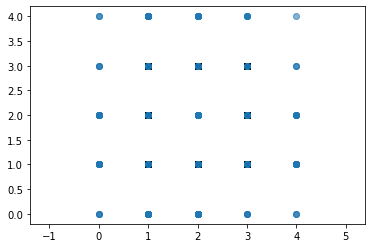

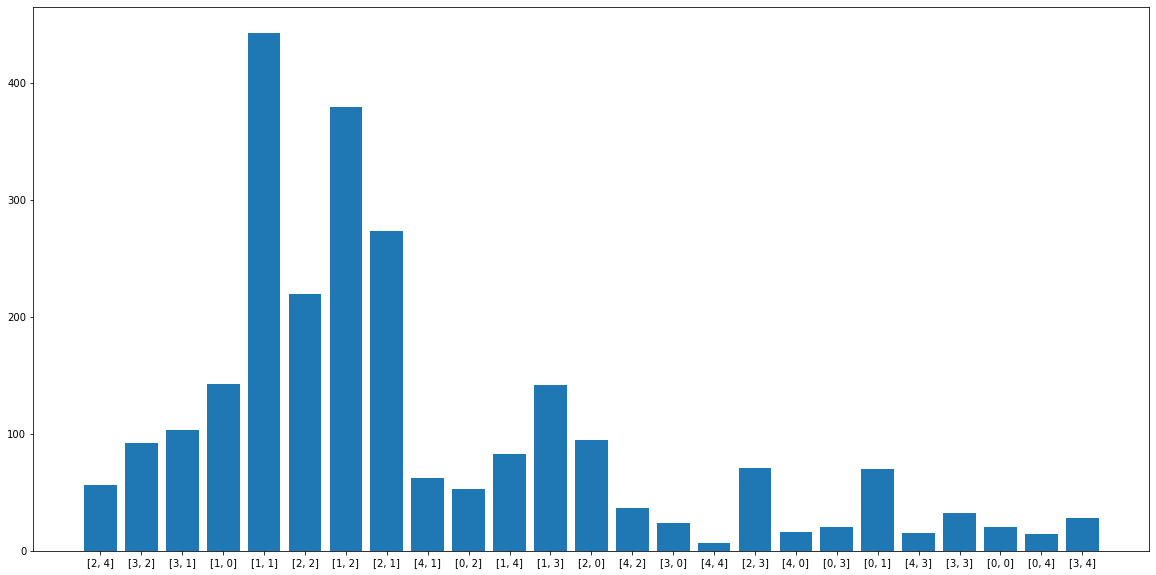

Processing Epoch 85
training start
Iteration 0, d real/fake loss 0.6365220546722412/0.6619024276733398 and g loss is 0.7509993314743042, NDiv loss 0.06241956725716591
Iteration 1, d real/fake loss 0.6365267634391785/0.6665534973144531 and g loss is 0.7370302677154541, NDiv loss 0.06811657547950745
Iteration 2, d real/fake loss 0.6365307569503784/0.670913815498352 and g loss is 0.7504377961158752, NDiv loss 0.0603831447660923
Iteration 3, d real/fake loss 0.6365324258804321/0.6622588038444519 and g loss is 0.730170488357544, NDiv loss 0.07326098531484604
Iteration 4, d real/fake loss 0.6365281343460083/0.6490480899810791 and g loss is 0.7313612699508667, NDiv loss 0.06381554901599884


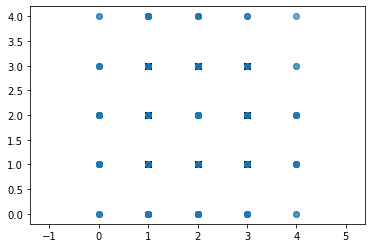

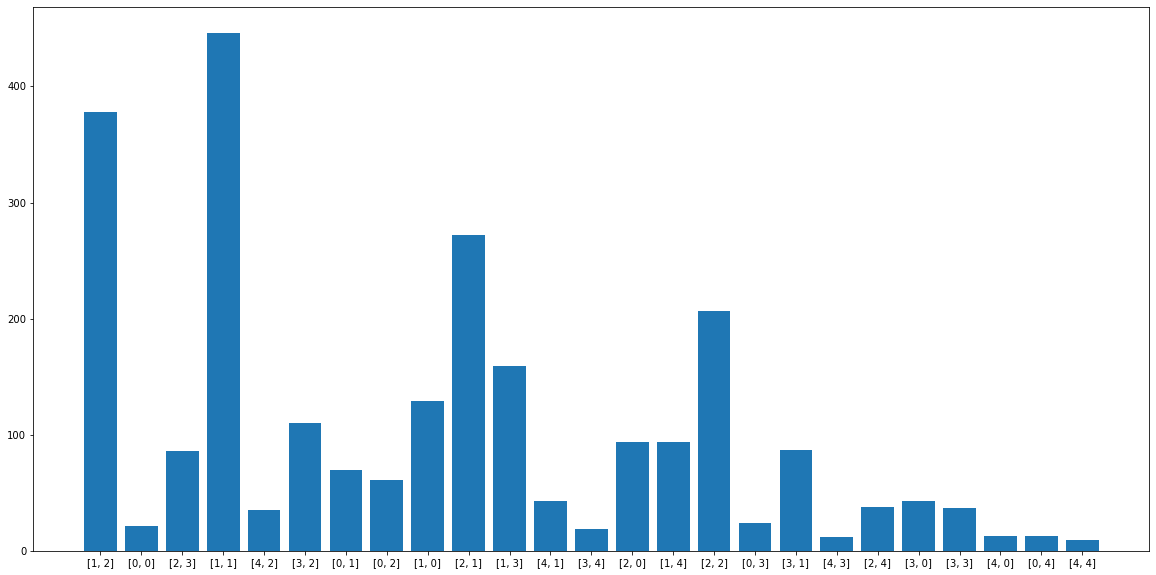

Processing Epoch 86
training start
Iteration 0, d real/fake loss 0.6356601119041443/0.6698048114776611 and g loss is 0.7549768686294556, NDiv loss 0.06465505808591843
Iteration 1, d real/fake loss 0.635602593421936/0.6582236886024475 and g loss is 0.715471625328064, NDiv loss 0.047997720539569855
Iteration 2, d real/fake loss 0.6355409622192383/0.6617299914360046 and g loss is 0.7428725361824036, NDiv loss 0.04564673453569412
Iteration 3, d real/fake loss 0.6354779005050659/0.6736875772476196 and g loss is 0.7313545942306519, NDiv loss 0.051950179040431976
Iteration 4, d real/fake loss 0.6354187726974487/0.6570636630058289 and g loss is 0.7339502573013306, NDiv loss 0.0578002892434597


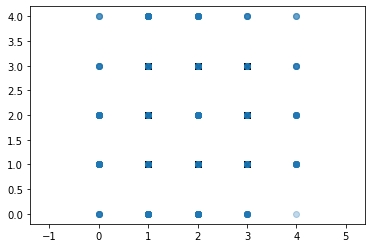

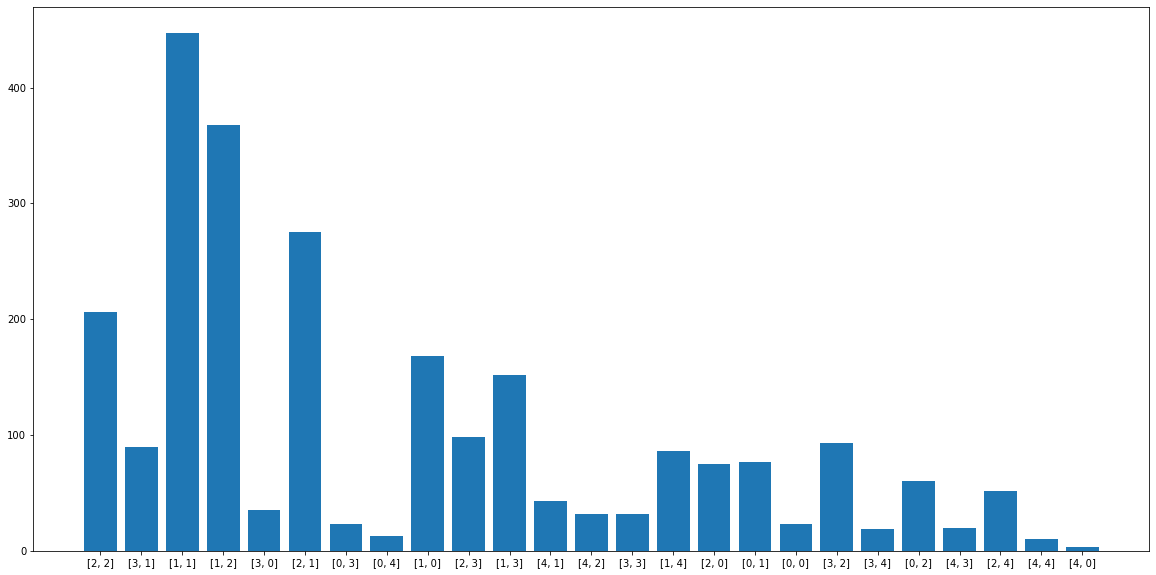

Processing Epoch 87
training start
Iteration 0, d real/fake loss 0.645780622959137/0.6562232971191406 and g loss is 0.747044563293457, NDiv loss 0.06329067051410675
Iteration 1, d real/fake loss 0.6457645297050476/0.6651257872581482 and g loss is 0.73875892162323, NDiv loss 0.06589864194393158
Iteration 2, d real/fake loss 0.6457403898239136/0.6468581557273865 and g loss is 0.7347248196601868, NDiv loss 0.07203086465597153
Iteration 3, d real/fake loss 0.6456968784332275/0.6726728677749634 and g loss is 0.7441753149032593, NDiv loss 0.07363341003656387
Iteration 4, d real/fake loss 0.6456524133682251/0.6577275991439819 and g loss is 0.7508761286735535, NDiv loss 0.06324012577533722


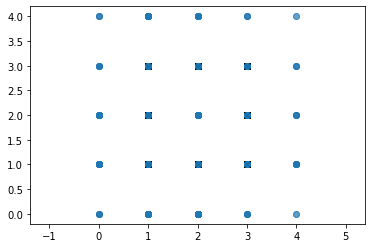

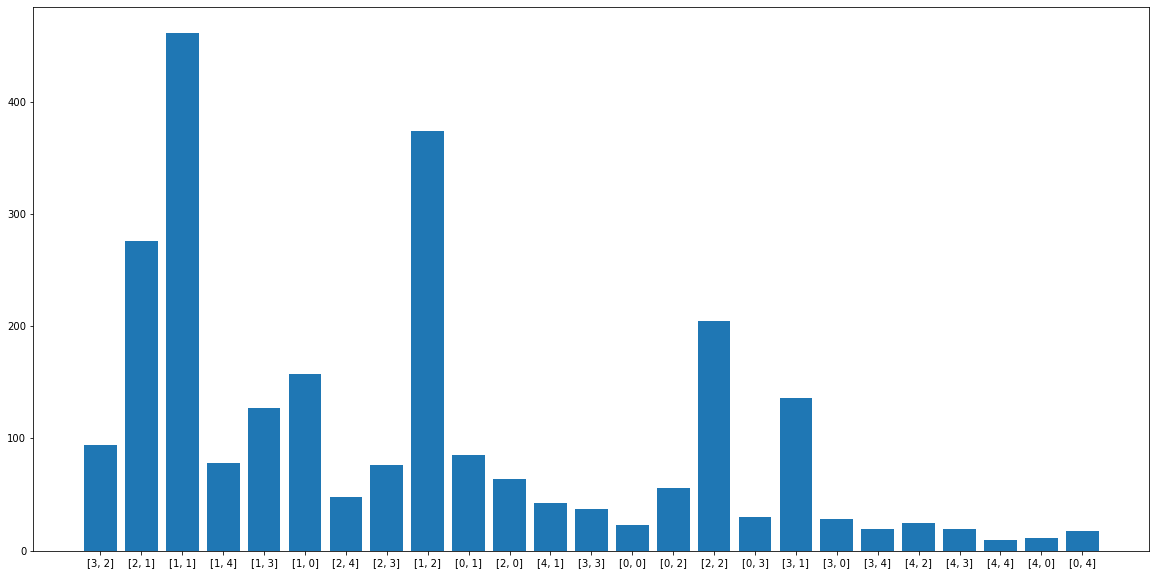

Processing Epoch 88
training start
Iteration 0, d real/fake loss 0.6394615173339844/0.6519668102264404 and g loss is 0.7239956855773926, NDiv loss 0.07597283273935318
Iteration 1, d real/fake loss 0.6393128633499146/0.6624350547790527 and g loss is 0.7461585998535156, NDiv loss 0.0674108937382698
Iteration 2, d real/fake loss 0.6391695737838745/0.6598837375640869 and g loss is 0.7193204164505005, NDiv loss 0.061786845326423645
Iteration 3, d real/fake loss 0.6390283107757568/0.6612731218338013 and g loss is 0.7291263341903687, NDiv loss 0.054408829659223557
Iteration 4, d real/fake loss 0.6388852596282959/0.6682099103927612 and g loss is 0.7294808626174927, NDiv loss 0.05536208674311638


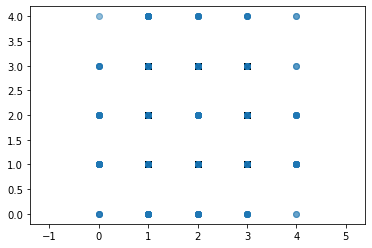

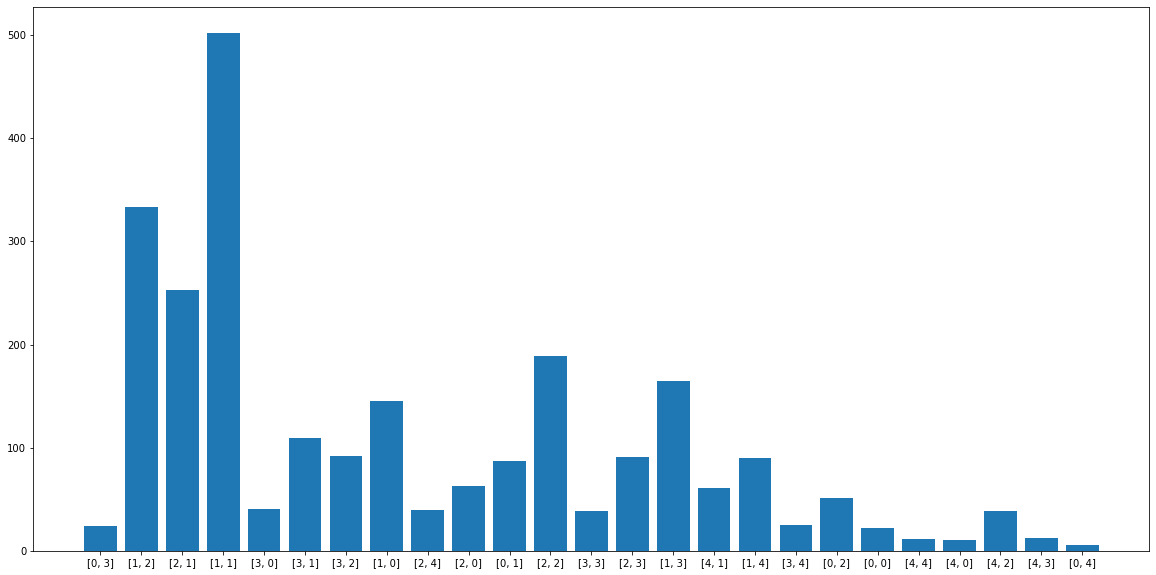

Processing Epoch 89
training start
Iteration 0, d real/fake loss 0.6529326438903809/0.6646950244903564 and g loss is 0.7502783536911011, NDiv loss 0.05306421220302582
Iteration 1, d real/fake loss 0.6529874801635742/0.665510892868042 and g loss is 0.726352870464325, NDiv loss 0.05914236977696419
Iteration 2, d real/fake loss 0.6530312895774841/0.6707528829574585 and g loss is 0.7396680116653442, NDiv loss 0.05400852486491203
Iteration 3, d real/fake loss 0.6530641317367554/0.671161413192749 and g loss is 0.7383384108543396, NDiv loss 0.05980909243226051
Iteration 4, d real/fake loss 0.6530944108963013/0.6667883992195129 and g loss is 0.7417359352111816, NDiv loss 0.05542934685945511


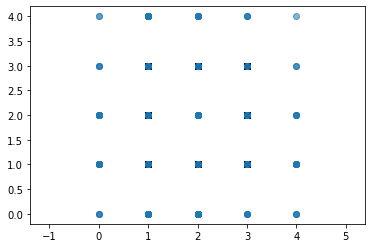

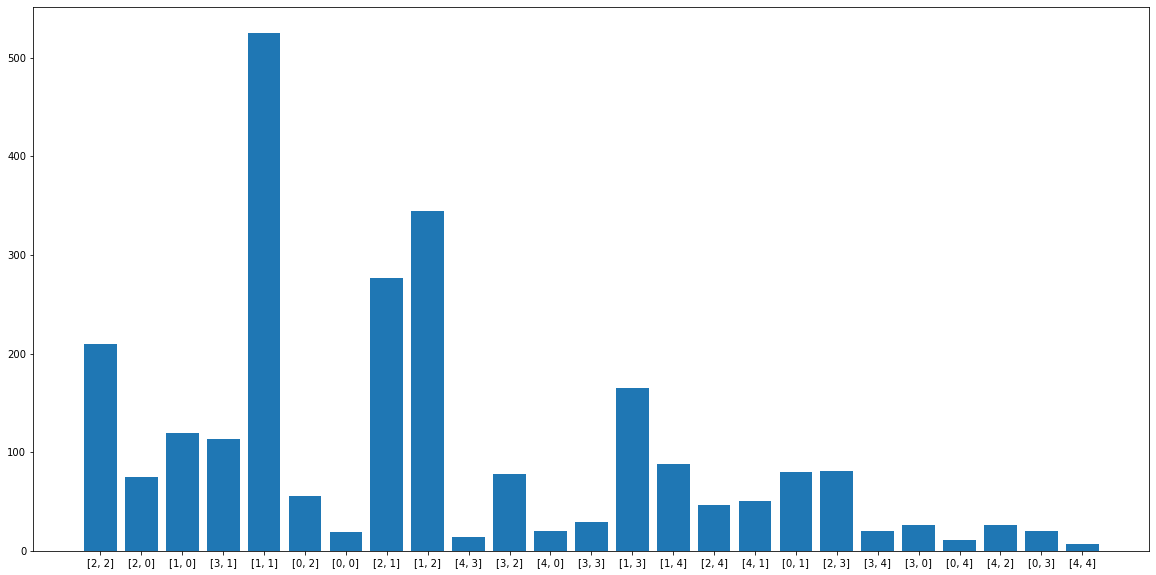

Processing Epoch 90
training start
Iteration 0, d real/fake loss 0.6360377073287964/0.6635545492172241 and g loss is 0.7340130805969238, NDiv loss 0.059700384736061096
Iteration 1, d real/fake loss 0.6359745860099792/0.6735178232192993 and g loss is 0.7317633628845215, NDiv loss 0.06654553860425949
Iteration 2, d real/fake loss 0.6359200477600098/0.6638840436935425 and g loss is 0.7332244515419006, NDiv loss 0.0654139444231987
Iteration 3, d real/fake loss 0.6358597278594971/0.6616042852401733 and g loss is 0.7191849946975708, NDiv loss 0.062083445489406586
Iteration 4, d real/fake loss 0.6357942223548889/0.6581473350524902 and g loss is 0.7203105688095093, NDiv loss 0.06634179502725601


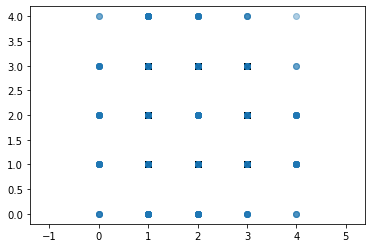

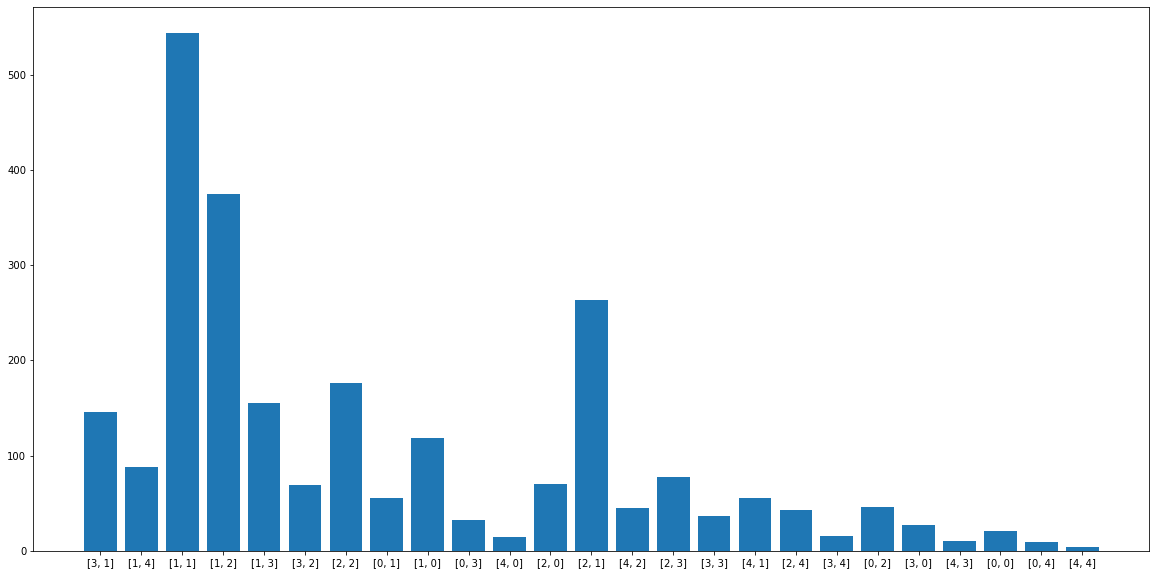

Processing Epoch 91
training start
Iteration 0, d real/fake loss 0.6525264382362366/0.675582766532898 and g loss is 0.7506128549575806, NDiv loss 0.058779411017894745
Iteration 1, d real/fake loss 0.6525883674621582/0.6579080820083618 and g loss is 0.7473579049110413, NDiv loss 0.06563901901245117
Iteration 2, d real/fake loss 0.6526274681091309/0.6712551116943359 and g loss is 0.7547731995582581, NDiv loss 0.05951273441314697
Iteration 3, d real/fake loss 0.65265953540802/0.6573851108551025 and g loss is 0.7501077055931091, NDiv loss 0.06195114180445671
Iteration 4, d real/fake loss 0.6526742577552795/0.6638230085372925 and g loss is 0.7398303747177124, NDiv loss 0.054441776126623154


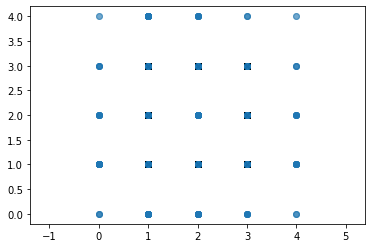

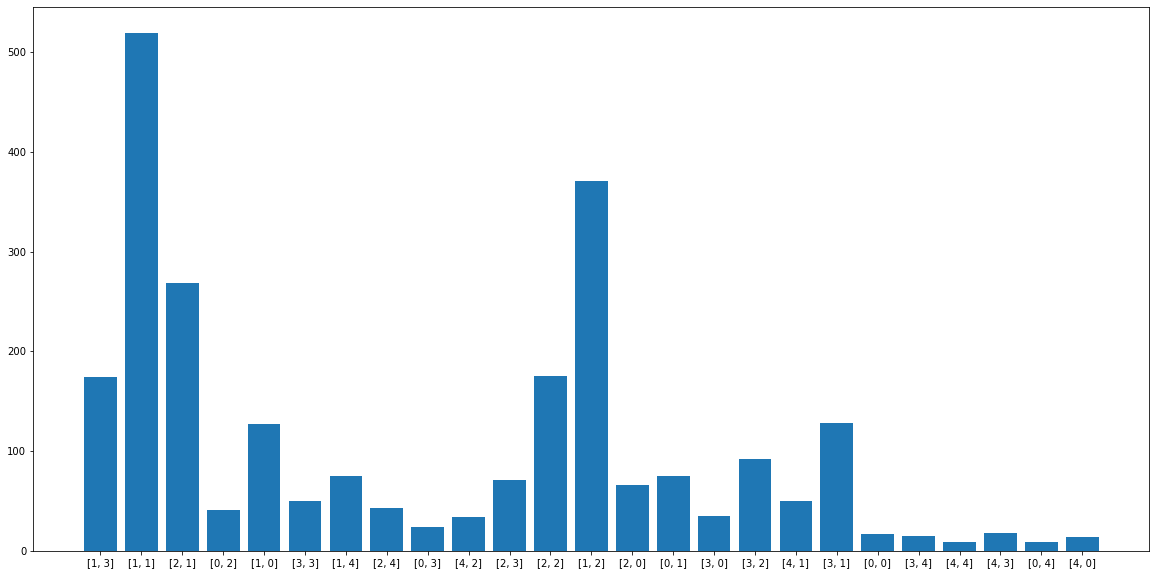

Processing Epoch 92
training start
Iteration 0, d real/fake loss 0.6387813687324524/0.6552087664604187 and g loss is 0.7369527816772461, NDiv loss 0.06939150393009186
Iteration 1, d real/fake loss 0.6386651992797852/0.6716253757476807 and g loss is 0.7285682559013367, NDiv loss 0.057113707065582275
Iteration 2, d real/fake loss 0.6385574340820312/0.6623498201370239 and g loss is 0.7383540868759155, NDiv loss 0.07731982320547104
Iteration 3, d real/fake loss 0.6384481191635132/0.6481440663337708 and g loss is 0.7302500009536743, NDiv loss 0.06433266401290894
Iteration 4, d real/fake loss 0.6383295059204102/0.6651920080184937 and g loss is 0.7448952794075012, NDiv loss 0.06728159636259079


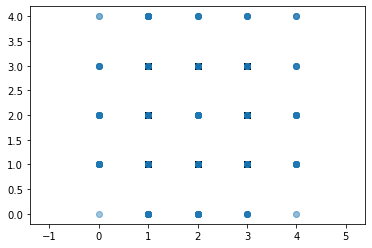

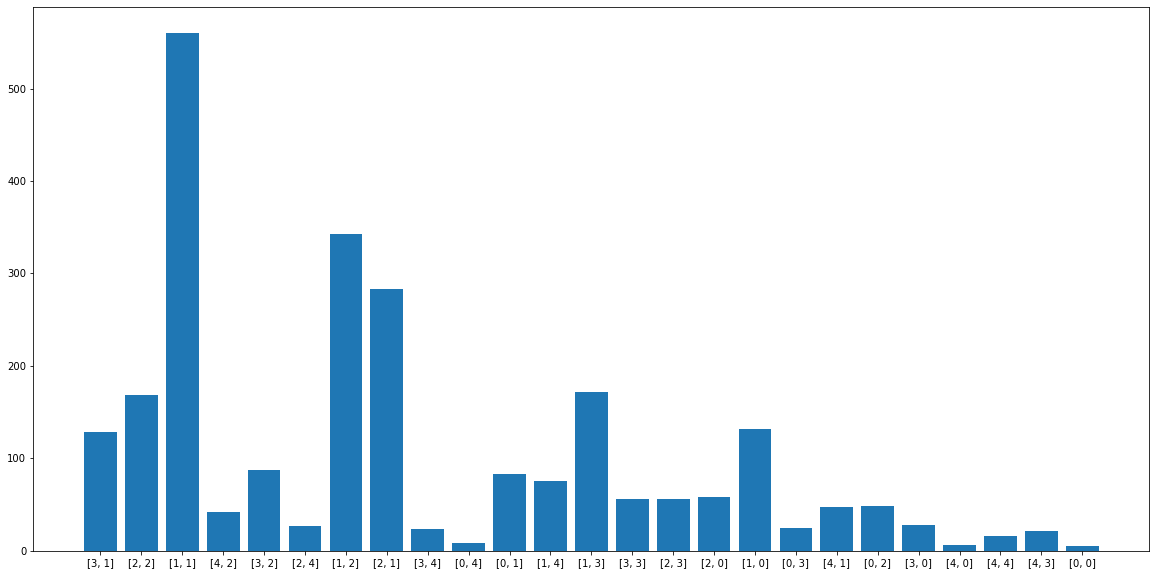

Processing Epoch 93
training start
Iteration 0, d real/fake loss 0.6528909206390381/0.6706839203834534 and g loss is 0.7322081327438354, NDiv loss 0.06726326793432236
Iteration 1, d real/fake loss 0.6529306173324585/0.6562190651893616 and g loss is 0.7307087182998657, NDiv loss 0.07213076949119568
Iteration 2, d real/fake loss 0.6529650092124939/0.6667162179946899 and g loss is 0.736473798751831, NDiv loss 0.06424176692962646
Iteration 3, d real/fake loss 0.6529801487922668/0.6670376062393188 and g loss is 0.7498795986175537, NDiv loss 0.06980297714471817
Iteration 4, d real/fake loss 0.6529731750488281/0.6675840020179749 and g loss is 0.7227534651756287, NDiv loss 0.06856989860534668


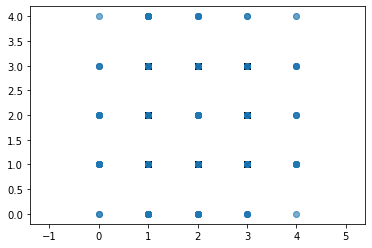

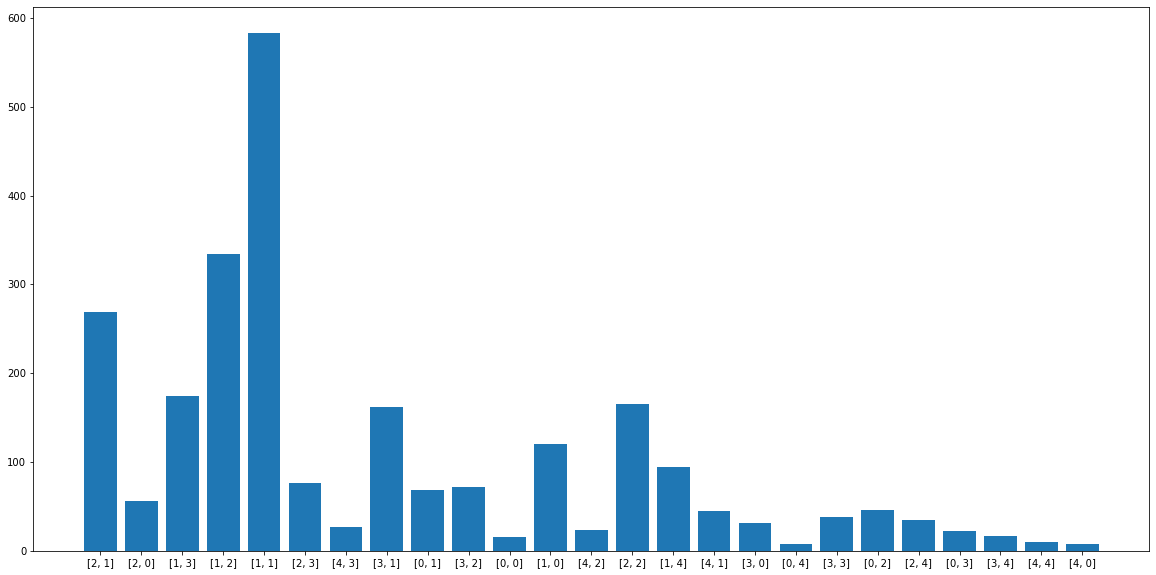

Processing Epoch 94
training start
Iteration 0, d real/fake loss 0.6385970115661621/0.6657431721687317 and g loss is 0.731792688369751, NDiv loss 0.052173271775245667
Iteration 1, d real/fake loss 0.6385175585746765/0.6580597162246704 and g loss is 0.7458889484405518, NDiv loss 0.05946330353617668
Iteration 2, d real/fake loss 0.6384414434432983/0.6580470204353333 and g loss is 0.7182356119155884, NDiv loss 0.06816310435533524
Iteration 3, d real/fake loss 0.6383591890335083/0.6598606109619141 and g loss is 0.738589882850647, NDiv loss 0.06303216516971588
Iteration 4, d real/fake loss 0.6382772922515869/0.6542226672172546 and g loss is 0.7245336771011353, NDiv loss 0.07550404220819473


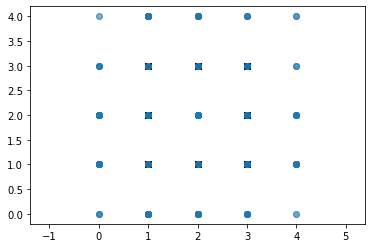

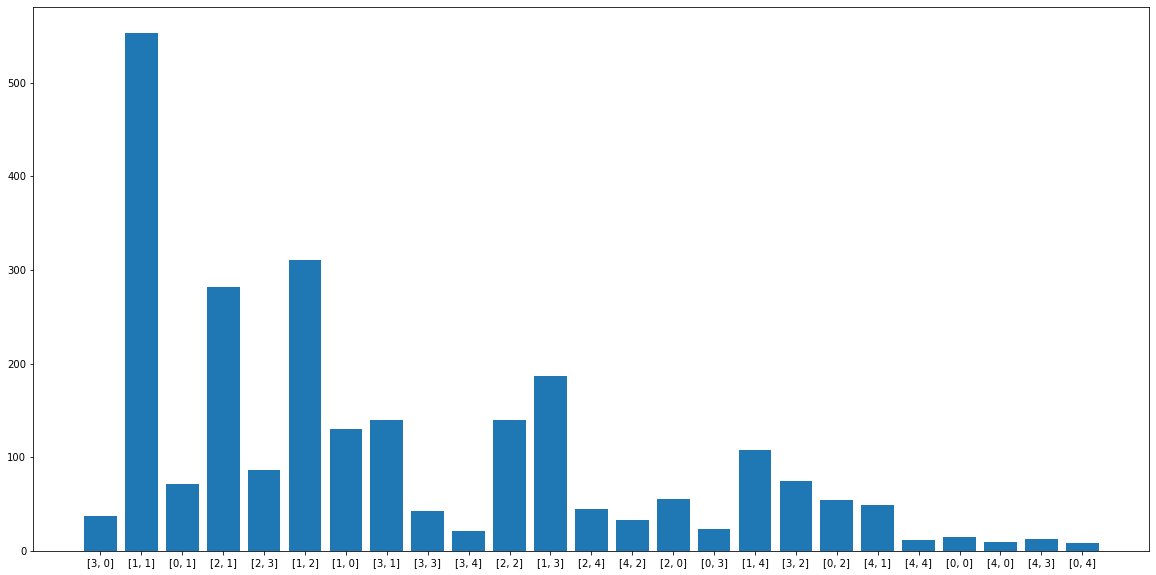

Processing Epoch 95
training start
Iteration 0, d real/fake loss 0.6350525617599487/0.6690139770507812 and g loss is 0.7325116395950317, NDiv loss 0.07311359792947769
Iteration 1, d real/fake loss 0.6349627375602722/0.6675277948379517 and g loss is 0.7555351257324219, NDiv loss 0.06733816117048264
Iteration 2, d real/fake loss 0.634881854057312/0.6773790717124939 and g loss is 0.7217163443565369, NDiv loss 0.0666755959391594
Iteration 3, d real/fake loss 0.6348210573196411/0.6731576919555664 and g loss is 0.7320687770843506, NDiv loss 0.06210767477750778
Iteration 4, d real/fake loss 0.6347761750221252/0.6746260523796082 and g loss is 0.7475155591964722, NDiv loss 0.07986684888601303


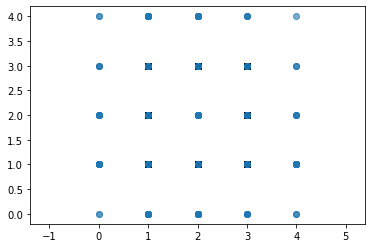

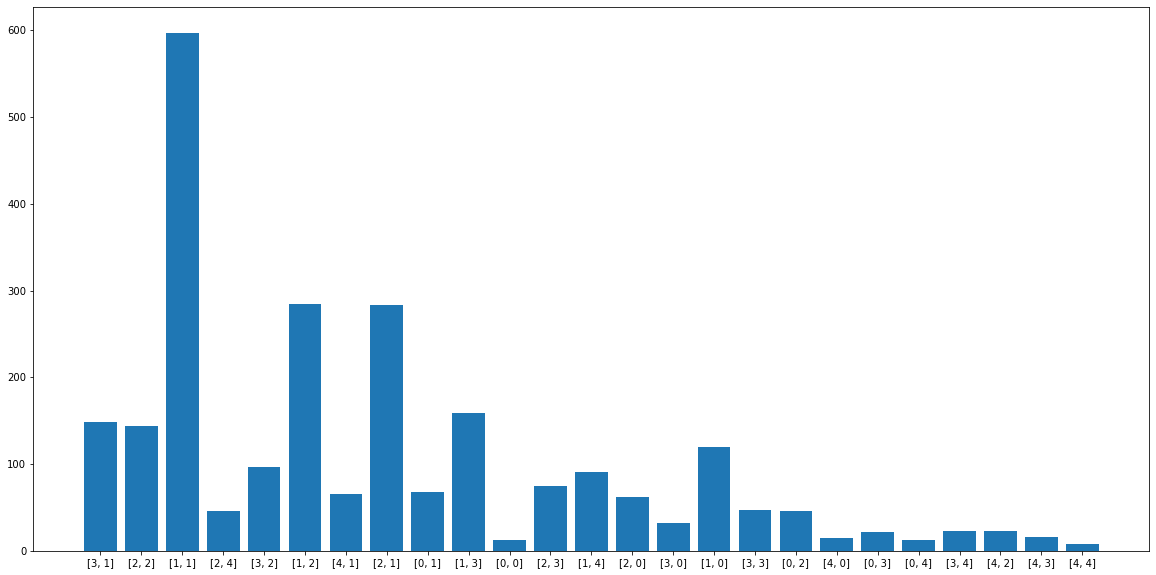

Processing Epoch 96
training start
Iteration 0, d real/fake loss 0.6455130577087402/0.6820257902145386 and g loss is 0.7194498181343079, NDiv loss 0.06991418451070786
Iteration 1, d real/fake loss 0.6455503702163696/0.6617476344108582 and g loss is 0.7373355627059937, NDiv loss 0.062470901757478714
Iteration 2, d real/fake loss 0.6455703973770142/0.6571880578994751 and g loss is 0.7208727598190308, NDiv loss 0.06976816058158875
Iteration 3, d real/fake loss 0.6455668210983276/0.6767280697822571 and g loss is 0.7281093597412109, NDiv loss 0.07382167875766754
Iteration 4, d real/fake loss 0.6455585956573486/0.6548603773117065 and g loss is 0.7371752858161926, NDiv loss 0.06479141861200333


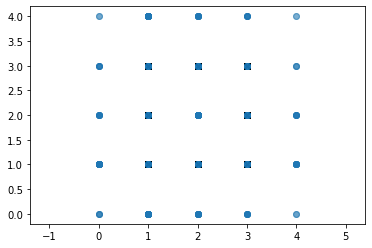

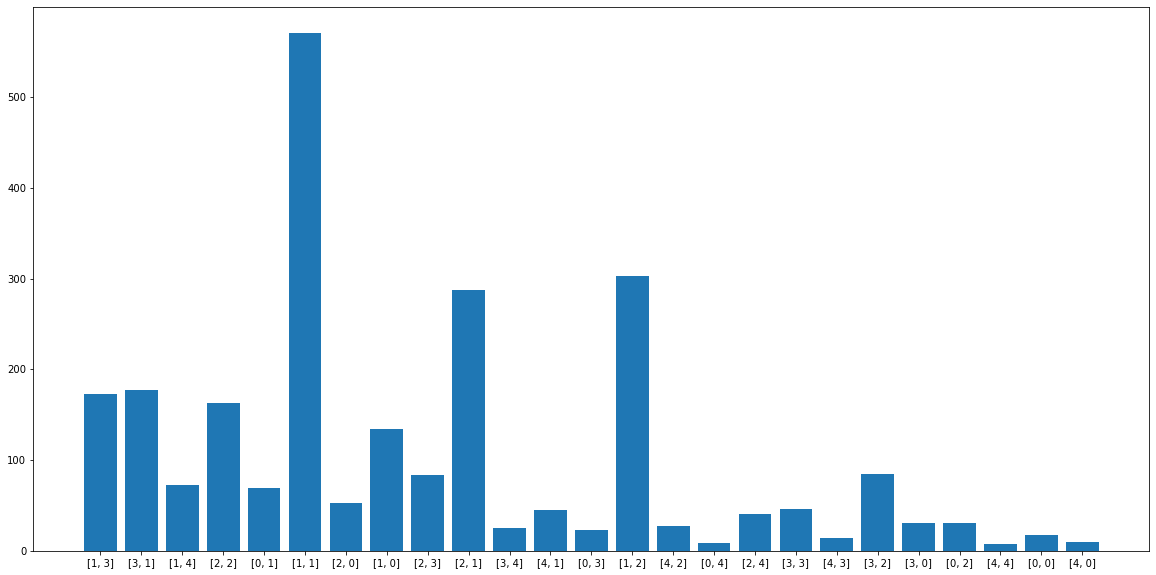

Processing Epoch 97
training start
Iteration 0, d real/fake loss 0.6391990780830383/0.6575542688369751 and g loss is 0.7165667414665222, NDiv loss 0.06904039531946182
Iteration 1, d real/fake loss 0.6391466856002808/0.6582146286964417 and g loss is 0.7363367080688477, NDiv loss 0.06782402098178864
Iteration 2, d real/fake loss 0.6390941739082336/0.6784833073616028 and g loss is 0.7253162860870361, NDiv loss 0.0720350444316864
Iteration 3, d real/fake loss 0.6390495300292969/0.6570119261741638 and g loss is 0.7206928730010986, NDiv loss 0.06860005110502243
Iteration 4, d real/fake loss 0.638997495174408/0.6455701589584351 and g loss is 0.7226431369781494, NDiv loss 0.0831943154335022


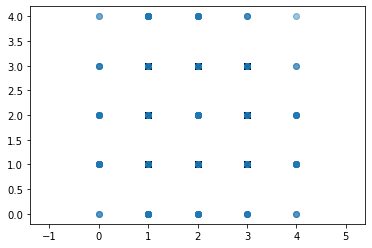

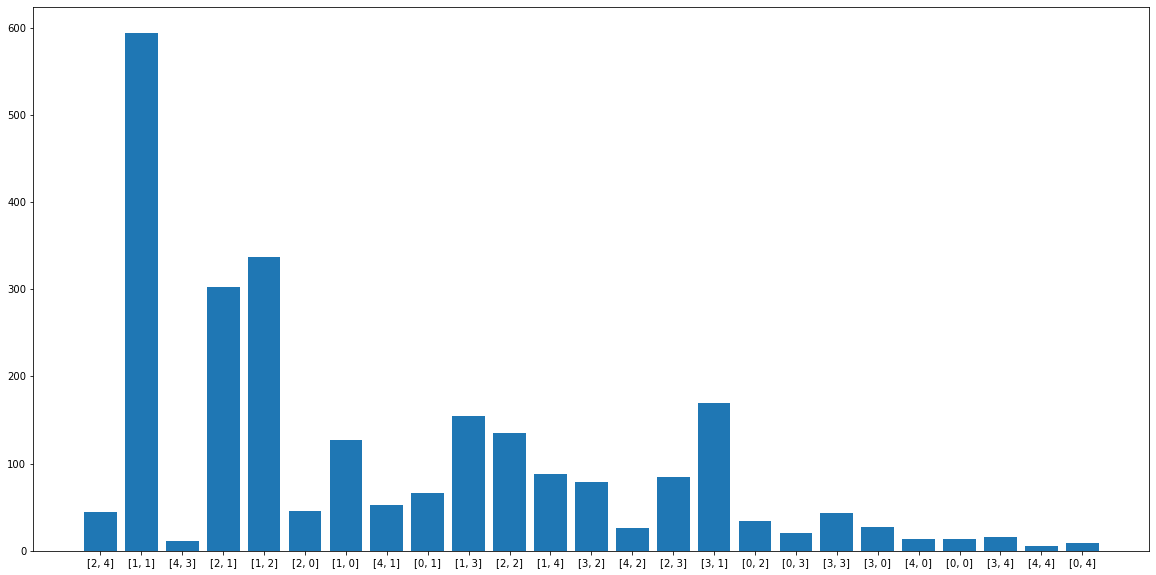

Processing Epoch 98
training start
Iteration 0, d real/fake loss 0.6364293098449707/0.6719438433647156 and g loss is 0.7318974733352661, NDiv loss 0.053041860461235046
Iteration 1, d real/fake loss 0.6364583969116211/0.6684331893920898 and g loss is 0.7229945063591003, NDiv loss 0.07359611243009567
Iteration 2, d real/fake loss 0.6364849209785461/0.6450271606445312 and g loss is 0.7334616184234619, NDiv loss 0.0711074024438858
Iteration 3, d real/fake loss 0.6364890336990356/0.6588850617408752 and g loss is 0.7352977991104126, NDiv loss 0.056578800082206726
Iteration 4, d real/fake loss 0.6364891529083252/0.6780240535736084 and g loss is 0.7460177540779114, NDiv loss 0.06833731383085251


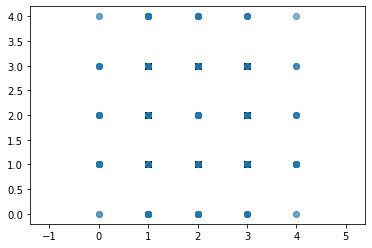

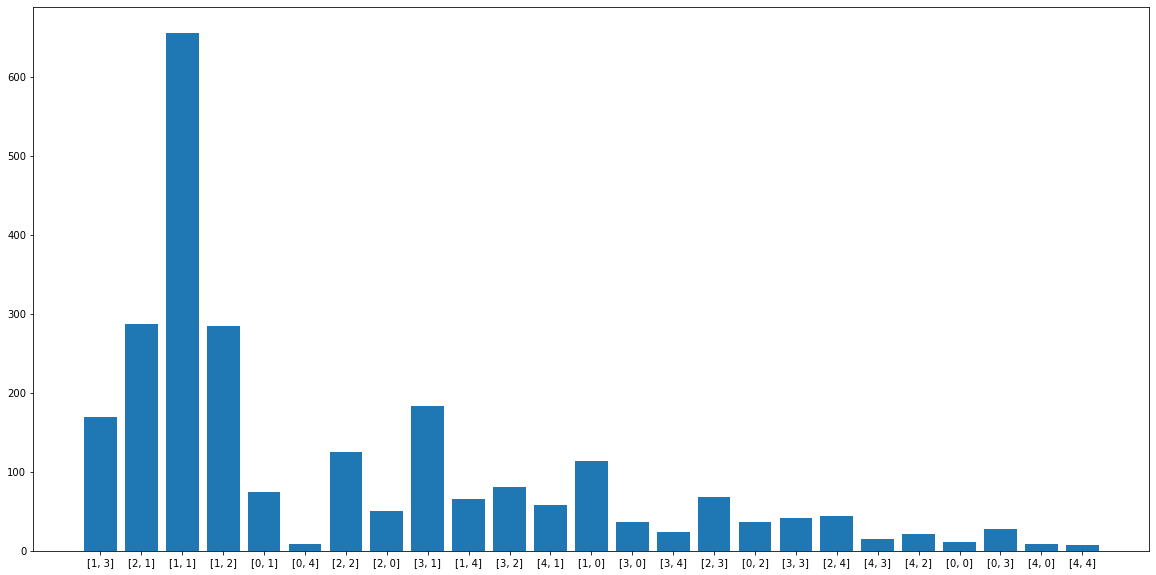

Processing Epoch 99
training start
Iteration 0, d real/fake loss 0.6467911601066589/0.6712548732757568 and g loss is 0.727319598197937, NDiv loss 0.06501315534114838
Iteration 1, d real/fake loss 0.6467797160148621/0.6545677781105042 and g loss is 0.7277875542640686, NDiv loss 0.06673552840948105
Iteration 2, d real/fake loss 0.6467530727386475/0.6600991487503052 and g loss is 0.724238395690918, NDiv loss 0.061539117246866226
Iteration 3, d real/fake loss 0.6467245221138/0.6716287136077881 and g loss is 0.756645917892456, NDiv loss 0.0656561478972435
Iteration 4, d real/fake loss 0.6466986536979675/0.6825002431869507 and g loss is 0.7397940754890442, NDiv loss 0.06921878457069397


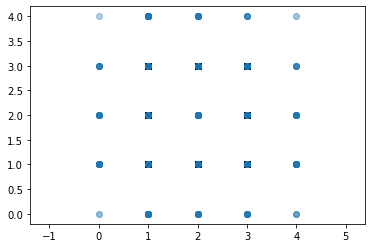

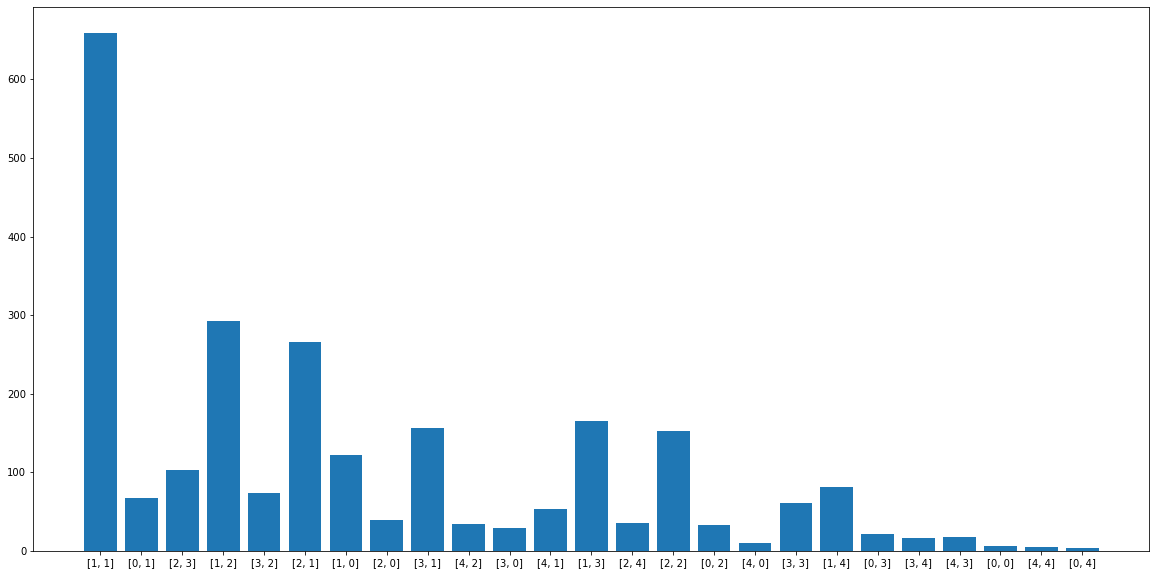

Processing Epoch 100
training start
Iteration 0, d real/fake loss 0.6425739526748657/0.6745560169219971 and g loss is 0.7331843376159668, NDiv loss 0.06575018912553787
Iteration 1, d real/fake loss 0.6426702737808228/0.659529447555542 and g loss is 0.7429755926132202, NDiv loss 0.07589681446552277
Iteration 2, d real/fake loss 0.6427549123764038/0.6379565000534058 and g loss is 0.7346742153167725, NDiv loss 0.08674047887325287
Iteration 3, d real/fake loss 0.6428127288818359/0.6549589037895203 and g loss is 0.7346986532211304, NDiv loss 0.06702642887830734
Iteration 4, d real/fake loss 0.6428606510162354/0.657051146030426 and g loss is 0.7243033647537231, NDiv loss 0.059418320655822754


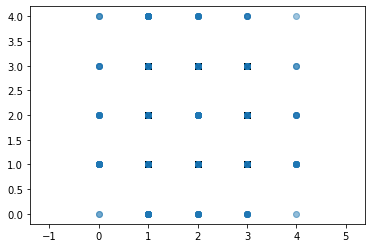

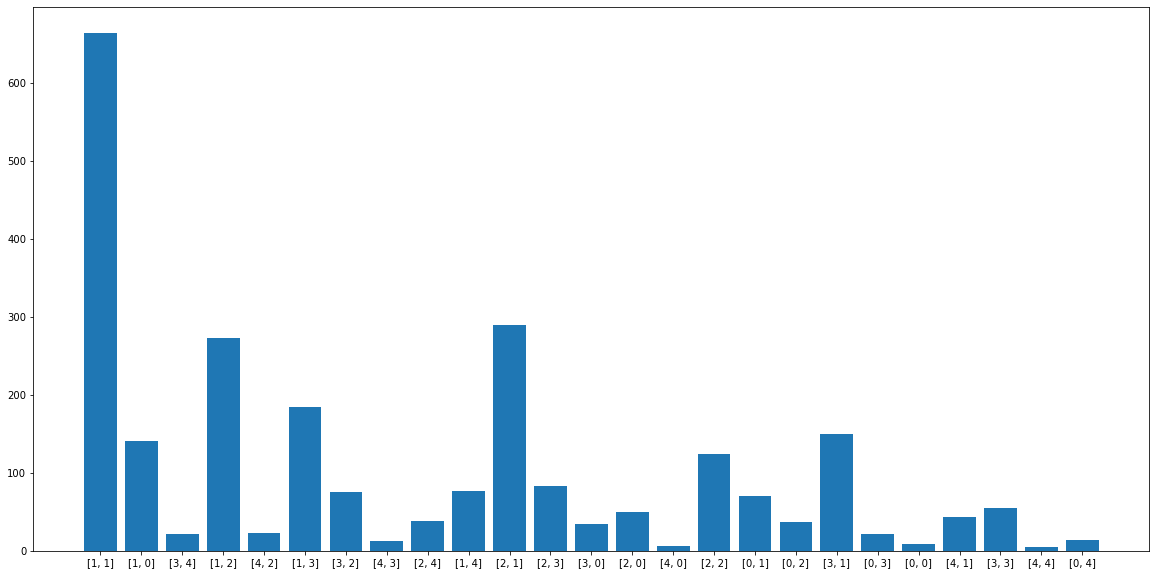

Processing Epoch 101
training start
Iteration 0, d real/fake loss 0.629884660243988/0.6704447269439697 and g loss is 0.731201171875, NDiv loss 0.06476165354251862
Iteration 1, d real/fake loss 0.6298102140426636/0.6645566821098328 and g loss is 0.7264891862869263, NDiv loss 0.07533818483352661
Iteration 2, d real/fake loss 0.6297461986541748/0.65119868516922 and g loss is 0.7358855605125427, NDiv loss 0.07149243354797363
Iteration 3, d real/fake loss 0.6296789050102234/0.6653391122817993 and g loss is 0.7316206693649292, NDiv loss 0.08100678771734238
Iteration 4, d real/fake loss 0.6296162605285645/0.6560962200164795 and g loss is 0.7327033281326294, NDiv loss 0.07206283509731293


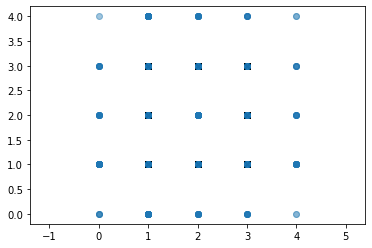

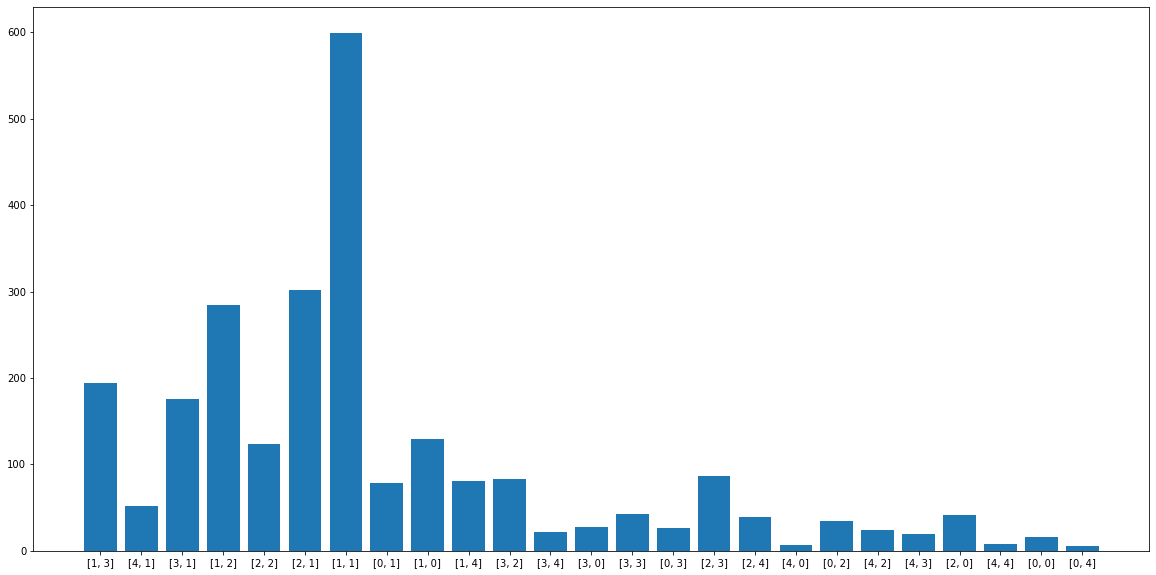

Processing Epoch 102
training start
Iteration 0, d real/fake loss 0.6413484811782837/0.6680426597595215 and g loss is 0.7376606464385986, NDiv loss 0.0988328605890274
Iteration 1, d real/fake loss 0.6413715481758118/0.6651955842971802 and g loss is 0.7320769429206848, NDiv loss 0.0782964900135994
Iteration 2, d real/fake loss 0.6413945555686951/0.6593188047409058 and g loss is 0.7072845697402954, NDiv loss 0.07782471925020218
Iteration 3, d real/fake loss 0.6414086818695068/0.6709272861480713 and g loss is 0.7259318828582764, NDiv loss 0.06357494741678238
Iteration 4, d real/fake loss 0.6414268016815186/0.6773278117179871 and g loss is 0.7429224848747253, NDiv loss 0.05963432416319847


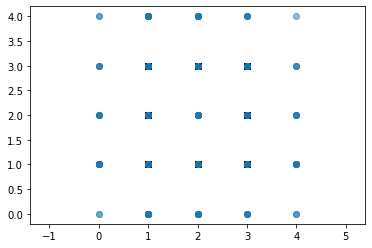

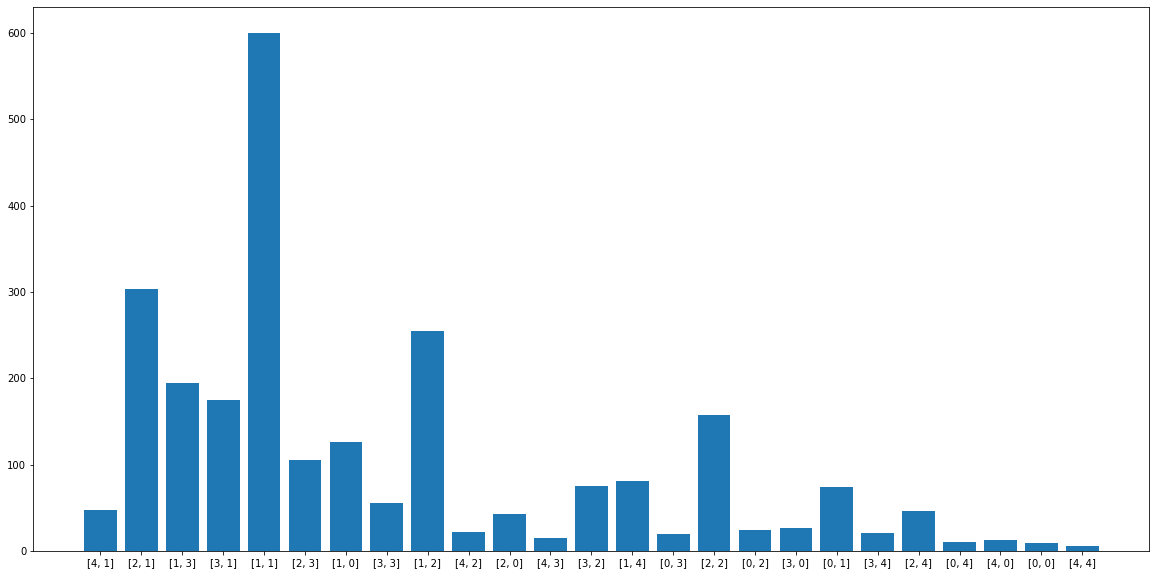

Processing Epoch 103
training start
Iteration 0, d real/fake loss 0.6444706916809082/0.6504532694816589 and g loss is 0.7333759069442749, NDiv loss 0.07149441540241241
Iteration 1, d real/fake loss 0.6444919109344482/0.6617116928100586 and g loss is 0.7556125521659851, NDiv loss 0.07081374526023865
Iteration 2, d real/fake loss 0.6444919109344482/0.662772536277771 and g loss is 0.7205638885498047, NDiv loss 0.07440043240785599
Iteration 3, d real/fake loss 0.644490659236908/0.6536715030670166 and g loss is 0.7278629541397095, NDiv loss 0.06583583354949951
Iteration 4, d real/fake loss 0.6444788575172424/0.6628942489624023 and g loss is 0.7376166582107544, NDiv loss 0.0720551609992981


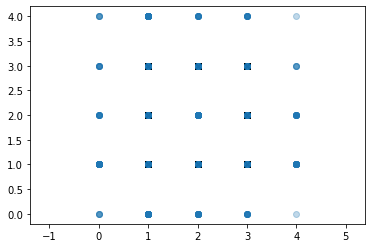

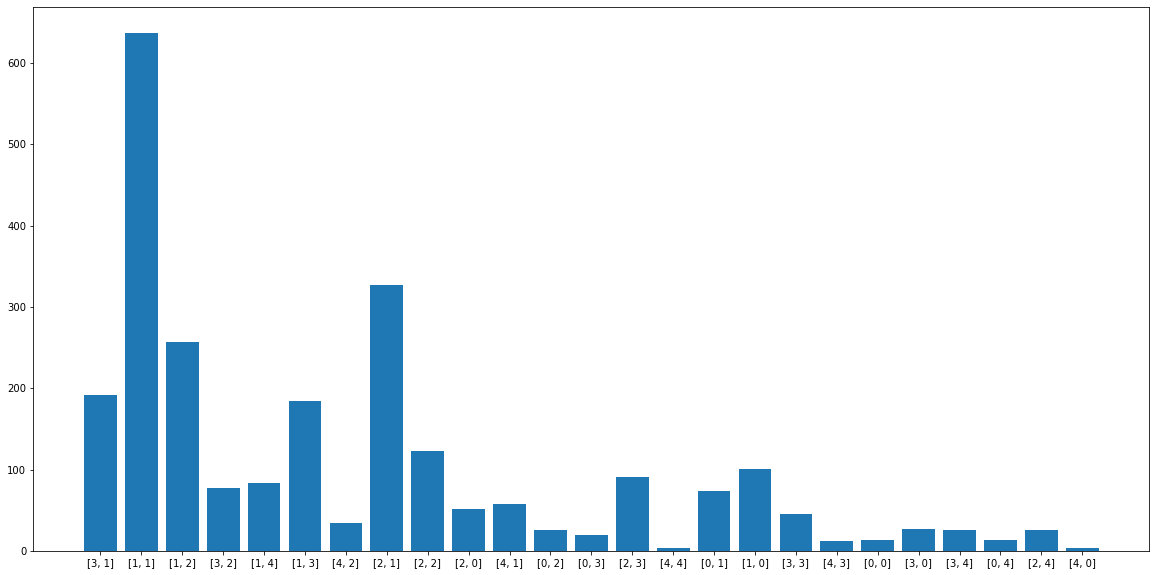

Processing Epoch 104
training start
Iteration 0, d real/fake loss 0.6409807205200195/0.6628379821777344 and g loss is 0.7398185133934021, NDiv loss 0.0687650591135025
Iteration 1, d real/fake loss 0.6409912109375/0.6675405502319336 and g loss is 0.7339630722999573, NDiv loss 0.07806446403265
Iteration 2, d real/fake loss 0.6410106420516968/0.6632063388824463 and g loss is 0.7456364035606384, NDiv loss 0.06821314990520477
Iteration 3, d real/fake loss 0.6410315036773682/0.6730608344078064 and g loss is 0.7405444979667664, NDiv loss 0.07881561666727066
Iteration 4, d real/fake loss 0.6410566568374634/0.6544747948646545 and g loss is 0.719132661819458, NDiv loss 0.06576558202505112


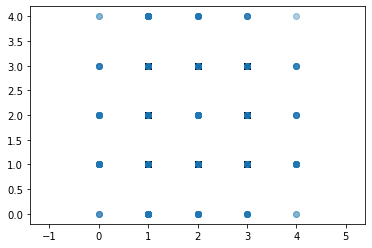

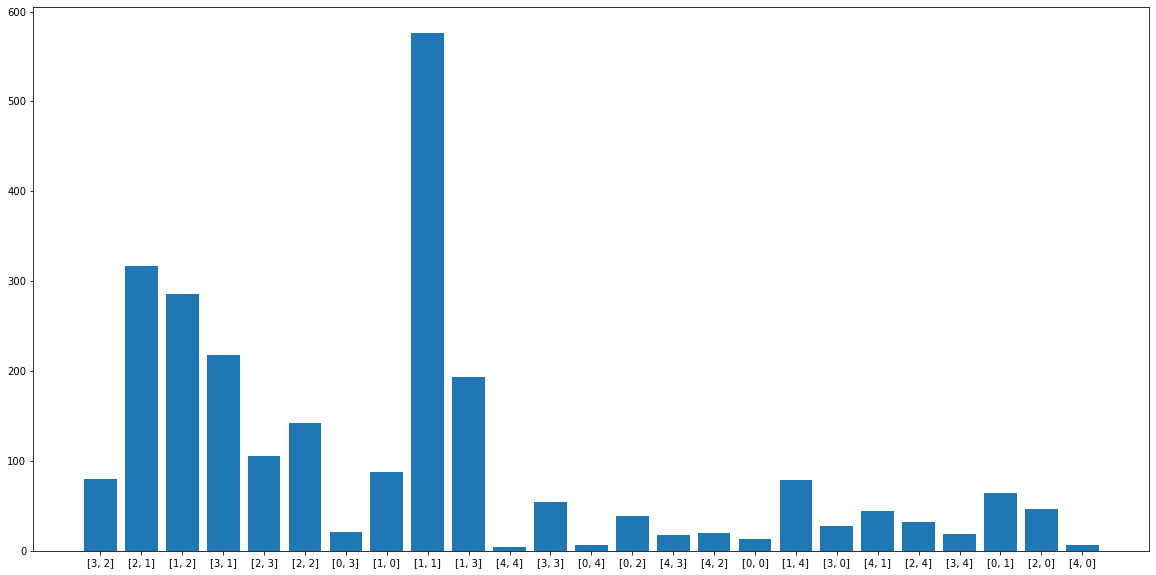

Processing Epoch 105
training start
Iteration 0, d real/fake loss 0.6427245140075684/0.6731775999069214 and g loss is 0.7324625849723816, NDiv loss 0.07161276042461395
Iteration 1, d real/fake loss 0.6427290439605713/0.6700161099433899 and g loss is 0.7346875667572021, NDiv loss 0.07928813248872757
Iteration 2, d real/fake loss 0.6427353024482727/0.6623318791389465 and g loss is 0.7437842488288879, NDiv loss 0.09935193508863449
Iteration 3, d real/fake loss 0.6427339911460876/0.669014573097229 and g loss is 0.7312192916870117, NDiv loss 0.08869116753339767
Iteration 4, d real/fake loss 0.6427320241928101/0.664963960647583 and g loss is 0.7428248524665833, NDiv loss 0.079691082239151


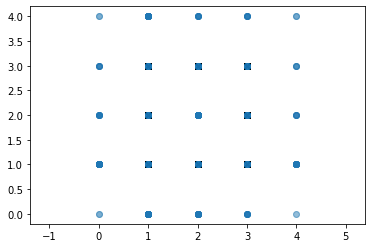

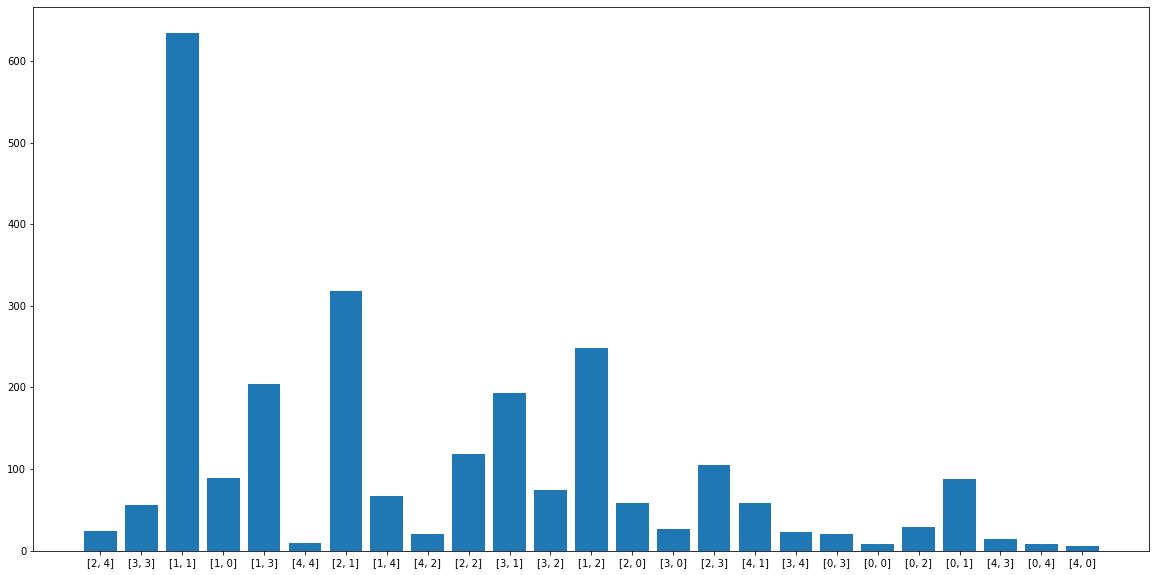

Processing Epoch 106
training start
Iteration 0, d real/fake loss 0.635503888130188/0.6595828533172607 and g loss is 0.7267382144927979, NDiv loss 0.10494910925626755
Iteration 1, d real/fake loss 0.6355378031730652/0.6774698495864868 and g loss is 0.7506376504898071, NDiv loss 0.07511599361896515
Iteration 2, d real/fake loss 0.6355787515640259/0.6580367684364319 and g loss is 0.746607780456543, NDiv loss 0.07724985480308533
Iteration 3, d real/fake loss 0.6356105804443359/0.663585901260376 and g loss is 0.7385225892066956, NDiv loss 0.07969009131193161
Iteration 4, d real/fake loss 0.6356462240219116/0.6676964163780212 and g loss is 0.7475241422653198, NDiv loss 0.07224142551422119


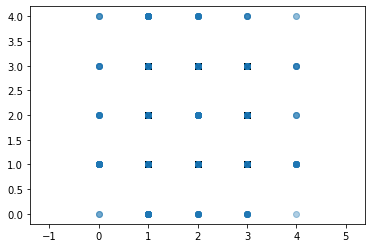

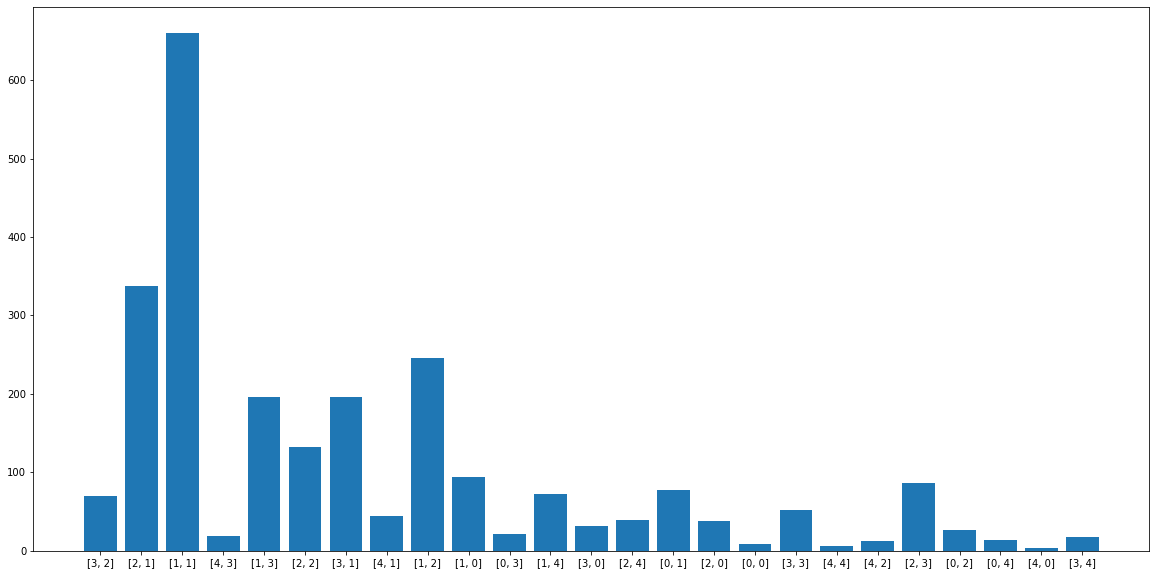

Processing Epoch 107
training start
Iteration 0, d real/fake loss 0.6337635517120361/0.6646045446395874 and g loss is 0.7312459945678711, NDiv loss 0.10192947089672089
Iteration 1, d real/fake loss 0.6338021755218506/0.6453505158424377 and g loss is 0.74024498462677, NDiv loss 0.07971993088722229
Iteration 2, d real/fake loss 0.6338250637054443/0.6655879020690918 and g loss is 0.7427077293395996, NDiv loss 0.08592779189348221
Iteration 3, d real/fake loss 0.6338533163070679/0.6676387786865234 and g loss is 0.7485368847846985, NDiv loss 0.07262632995843887
Iteration 4, d real/fake loss 0.6338855624198914/0.6746493577957153 and g loss is 0.7348217964172363, NDiv loss 0.06872683018445969


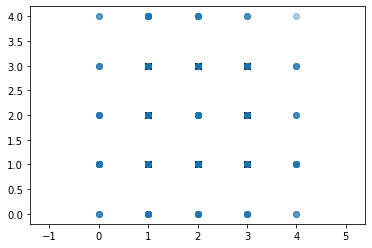

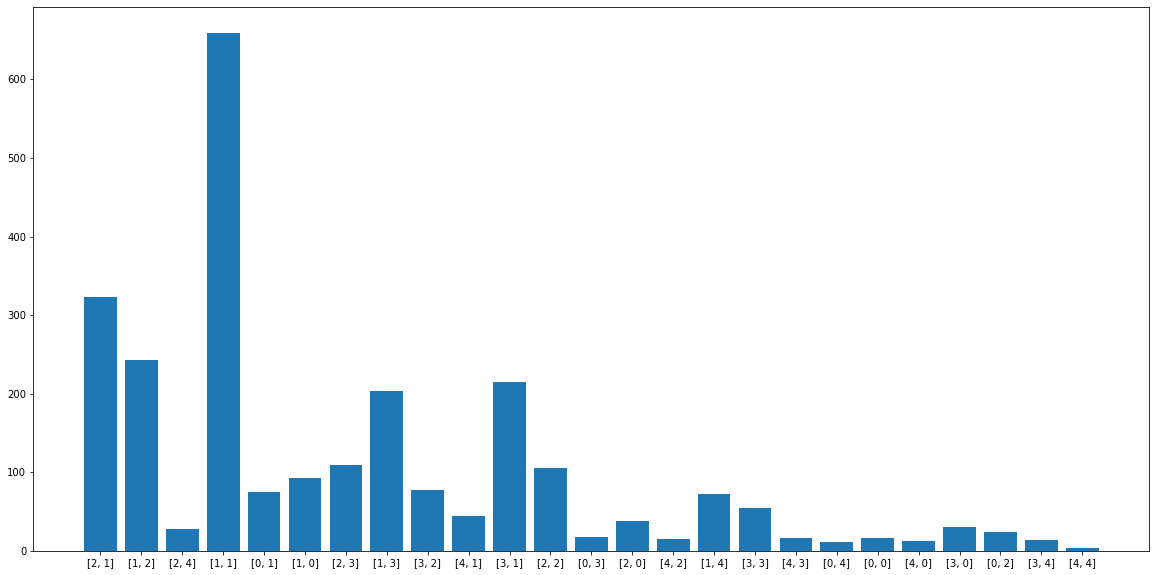

Processing Epoch 108
training start
Iteration 0, d real/fake loss 0.6427597999572754/0.6684817671775818 and g loss is 0.7304415106773376, NDiv loss 0.06695561110973358
Iteration 1, d real/fake loss 0.6428337097167969/0.668912947177887 and g loss is 0.7276098132133484, NDiv loss 0.07700134813785553
Iteration 2, d real/fake loss 0.6429061889648438/0.6483794450759888 and g loss is 0.7317495346069336, NDiv loss 0.06898555159568787
Iteration 3, d real/fake loss 0.6429620981216431/0.6731859445571899 and g loss is 0.7272197008132935, NDiv loss 0.06854183971881866
Iteration 4, d real/fake loss 0.6430211067199707/0.680821418762207 and g loss is 0.724108099937439, NDiv loss 0.07802533358335495


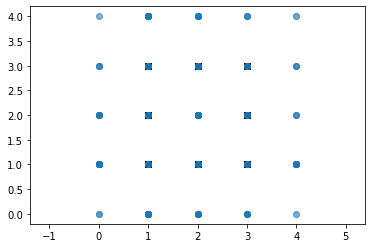

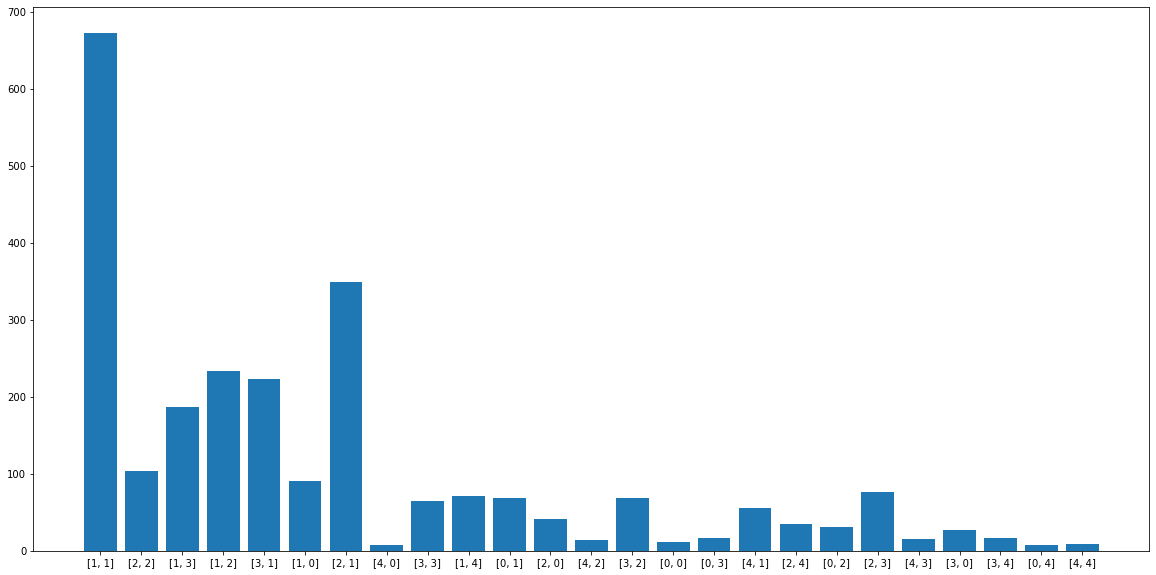

Processing Epoch 109
training start
Iteration 0, d real/fake loss 0.6439142227172852/0.6668131351470947 and g loss is 0.7532877922058105, NDiv loss 0.06092144921422005
Iteration 1, d real/fake loss 0.6440011262893677/0.6648438572883606 and g loss is 0.7413583993911743, NDiv loss 0.08862153440713882
Iteration 2, d real/fake loss 0.6440671682357788/0.6682718396186829 and g loss is 0.7254432439804077, NDiv loss 0.07946157455444336
Iteration 3, d real/fake loss 0.6441260576248169/0.6568659543991089 and g loss is 0.7257693409919739, NDiv loss 0.07704497128725052
Iteration 4, d real/fake loss 0.644163966178894/0.663364827632904 and g loss is 0.7392382621765137, NDiv loss 0.07856286317110062


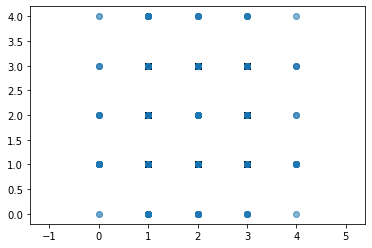

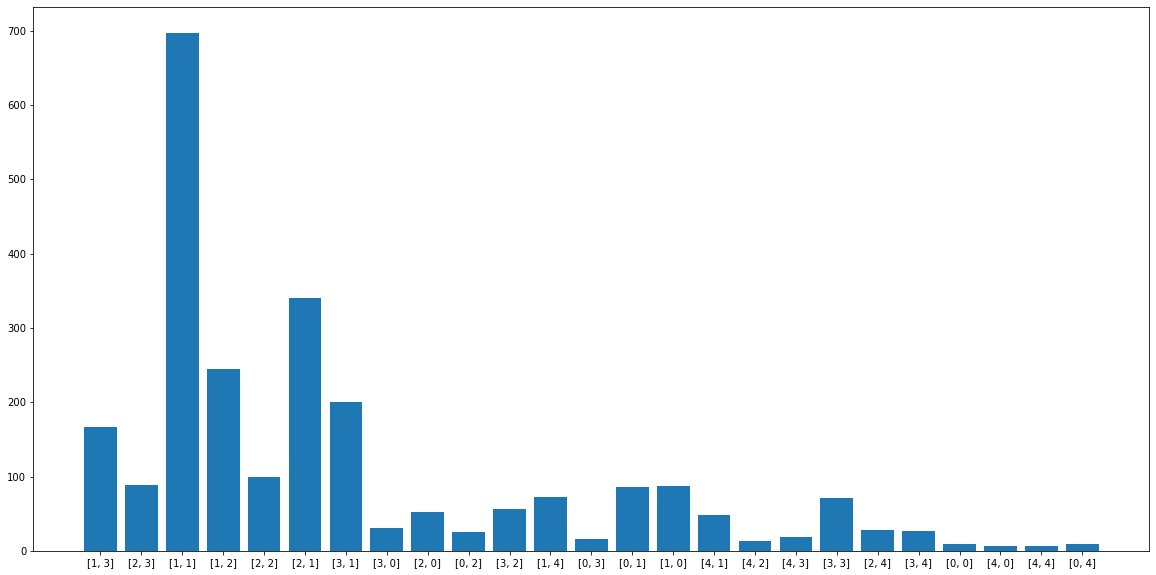

Processing Epoch 110
training start
Iteration 0, d real/fake loss 0.6436509490013123/0.6642752885818481 and g loss is 0.7394439578056335, NDiv loss 0.09218723326921463
Iteration 1, d real/fake loss 0.6436447501182556/0.6680943965911865 and g loss is 0.7409359216690063, NDiv loss 0.066218301653862
Iteration 2, d real/fake loss 0.6436371803283691/0.6823545694351196 and g loss is 0.7511046528816223, NDiv loss 0.08393242955207825
Iteration 3, d real/fake loss 0.6436299085617065/0.65256667137146 and g loss is 0.7297544479370117, NDiv loss 0.10084697604179382
Iteration 4, d real/fake loss 0.643614649772644/0.6626774072647095 and g loss is 0.732772171497345, NDiv loss 0.09847794473171234


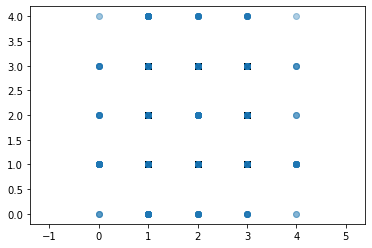

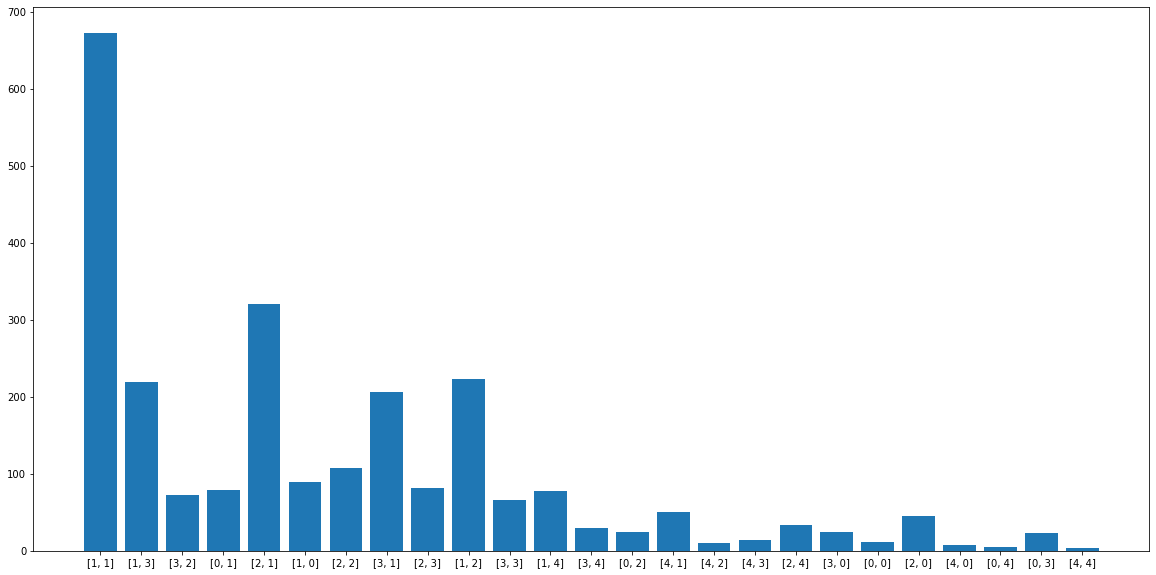

Processing Epoch 111
training start
Iteration 0, d real/fake loss 0.6461741924285889/0.6874485611915588 and g loss is 0.743378758430481, NDiv loss 0.08150660246610641
Iteration 1, d real/fake loss 0.6462314128875732/0.6650964617729187 and g loss is 0.7213544845581055, NDiv loss 0.07327770441770554
Iteration 2, d real/fake loss 0.6462838649749756/0.6662101745605469 and g loss is 0.7287042140960693, NDiv loss 0.07880103588104248
Iteration 3, d real/fake loss 0.6463379859924316/0.6469688415527344 and g loss is 0.7351299524307251, NDiv loss 0.10545054823160172
Iteration 4, d real/fake loss 0.6463741660118103/0.6626496315002441 and g loss is 0.7363991141319275, NDiv loss 0.09973858296871185


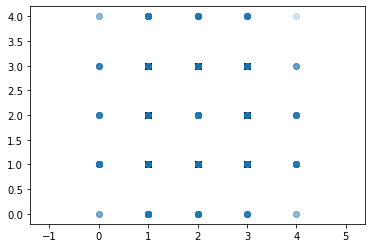

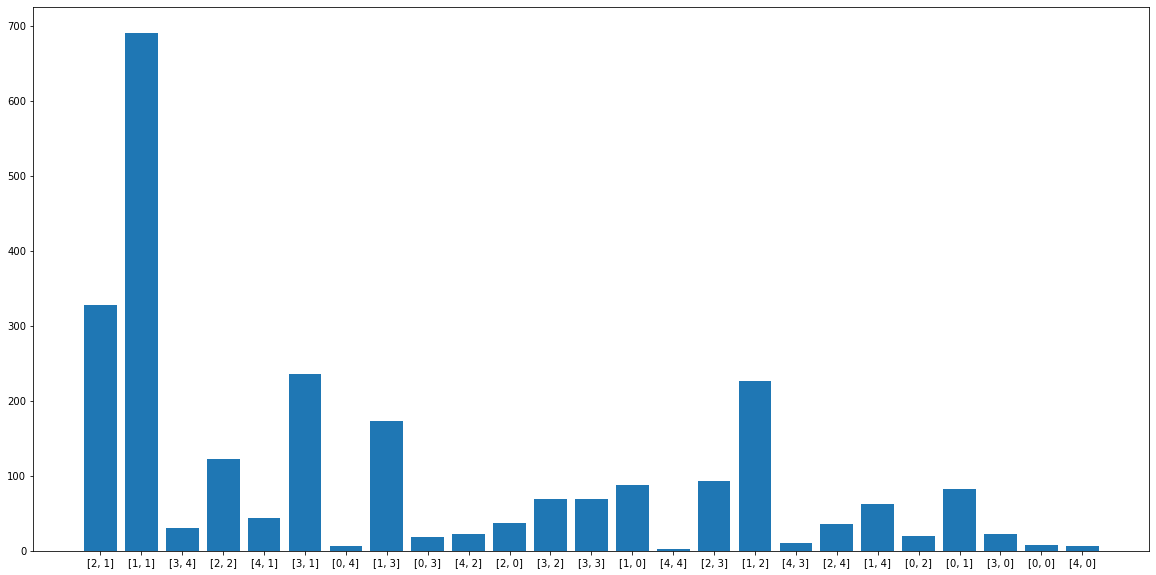

Processing Epoch 112
training start
Iteration 0, d real/fake loss 0.6474984884262085/0.666505753993988 and g loss is 0.7371536493301392, NDiv loss 0.07923201471567154
Iteration 1, d real/fake loss 0.647486686706543/0.664969801902771 and g loss is 0.7125793099403381, NDiv loss 0.06598266214132309
Iteration 2, d real/fake loss 0.6474624872207642/0.6585001349449158 and g loss is 0.7346777319908142, NDiv loss 0.08599522709846497
Iteration 3, d real/fake loss 0.6474205851554871/0.6629987955093384 and g loss is 0.7429832816123962, NDiv loss 0.07965385168790817
Iteration 4, d real/fake loss 0.6473678350448608/0.6533276438713074 and g loss is 0.735504686832428, NDiv loss 0.08643291890621185


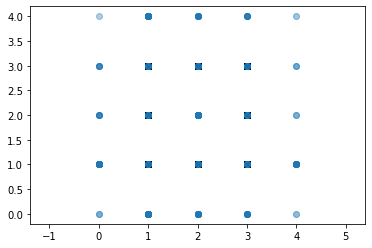

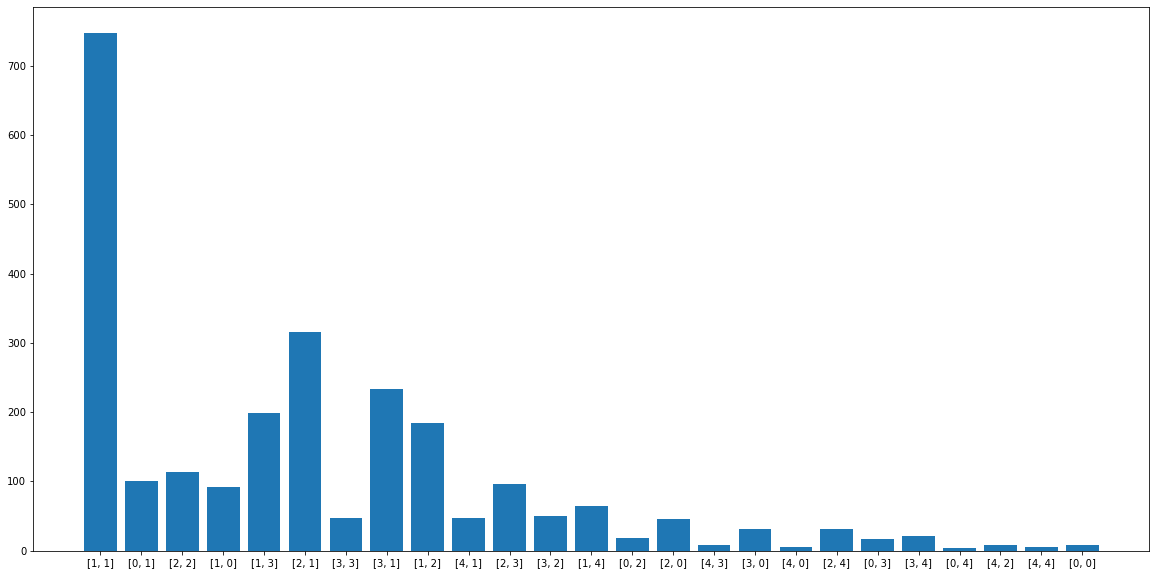

Processing Epoch 113
training start
Iteration 0, d real/fake loss 0.6409156322479248/0.6610970497131348 and g loss is 0.7270369529724121, NDiv loss 0.09227166324853897
Iteration 1, d real/fake loss 0.6408628225326538/0.6613109111785889 and g loss is 0.7092535495758057, NDiv loss 0.08269651979207993
Iteration 2, d real/fake loss 0.6408154964447021/0.6588609218597412 and g loss is 0.7548474073410034, NDiv loss 0.06635549664497375
Iteration 3, d real/fake loss 0.640763521194458/0.6600087881088257 and g loss is 0.7349526286125183, NDiv loss 0.06958569586277008
Iteration 4, d real/fake loss 0.6407119631767273/0.6703413128852844 and g loss is 0.7372979521751404, NDiv loss 0.08476125448942184


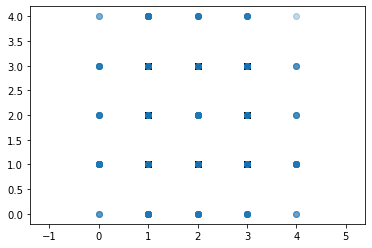

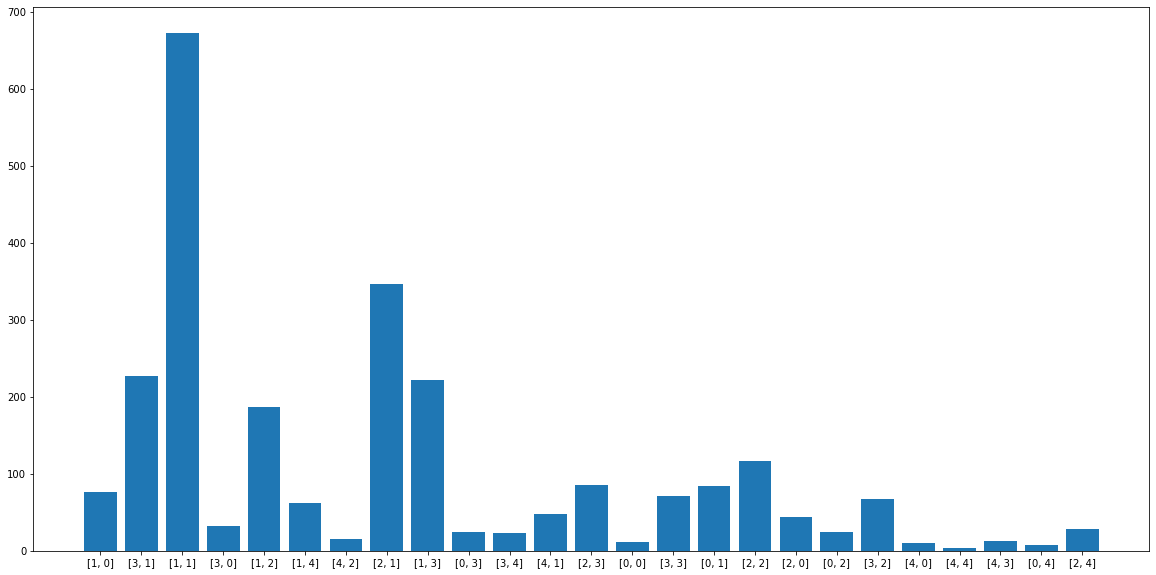

Processing Epoch 114
training start
Iteration 0, d real/fake loss 0.6260294914245605/0.6596225500106812 and g loss is 0.7560004591941833, NDiv loss 0.07923951745033264
Iteration 1, d real/fake loss 0.6260126829147339/0.6594759225845337 and g loss is 0.7212398052215576, NDiv loss 0.05808693915605545
Iteration 2, d real/fake loss 0.6259930729866028/0.6598901152610779 and g loss is 0.7464991807937622, NDiv loss 0.10023105144500732
Iteration 3, d real/fake loss 0.6259781718254089/0.6631144285202026 and g loss is 0.7244735956192017, NDiv loss 0.08573076128959656
Iteration 4, d real/fake loss 0.6259694695472717/0.6708529591560364 and g loss is 0.748591959476471, NDiv loss 0.08416382223367691


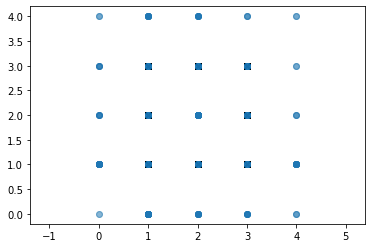

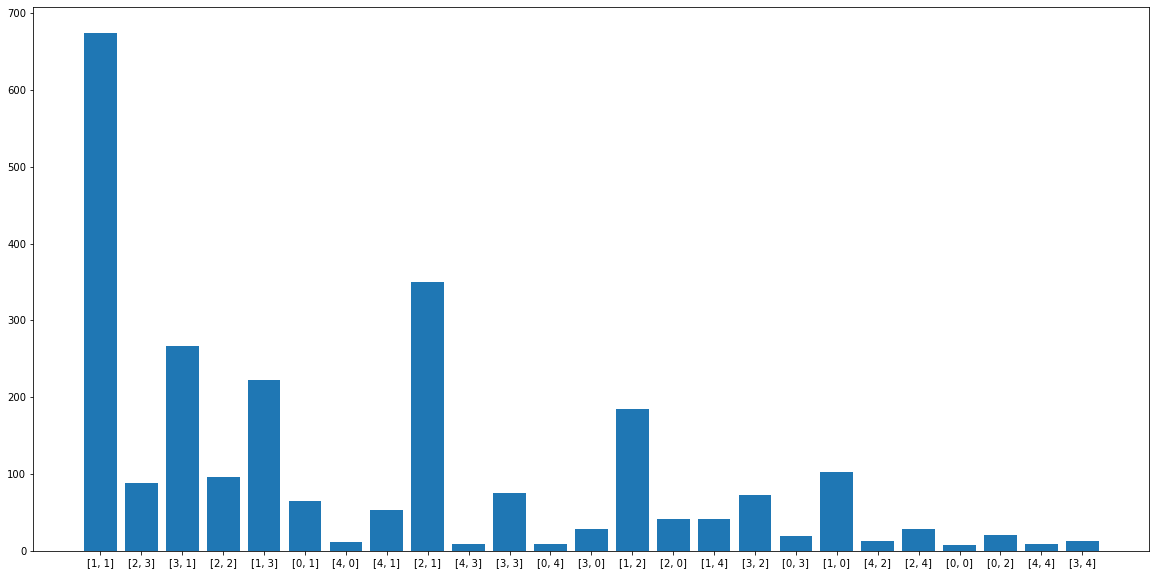

Processing Epoch 115
training start
Iteration 0, d real/fake loss 0.6240311861038208/0.6708470582962036 and g loss is 0.7409626841545105, NDiv loss 0.06761881709098816
Iteration 1, d real/fake loss 0.6239843368530273/0.652931272983551 and g loss is 0.7295814752578735, NDiv loss 0.08201973140239716
Iteration 2, d real/fake loss 0.6239397525787354/0.6536812782287598 and g loss is 0.740829348564148, NDiv loss 0.07753060758113861
Iteration 3, d real/fake loss 0.6238967776298523/0.657981812953949 and g loss is 0.7424448132514954, NDiv loss 0.07636628299951553
Iteration 4, d real/fake loss 0.6238558292388916/0.6744071841239929 and g loss is 0.7522298097610474, NDiv loss 0.07568854838609695


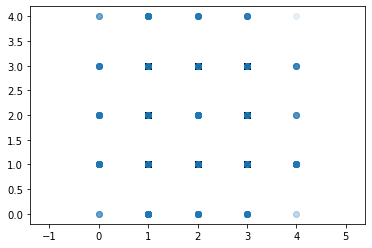

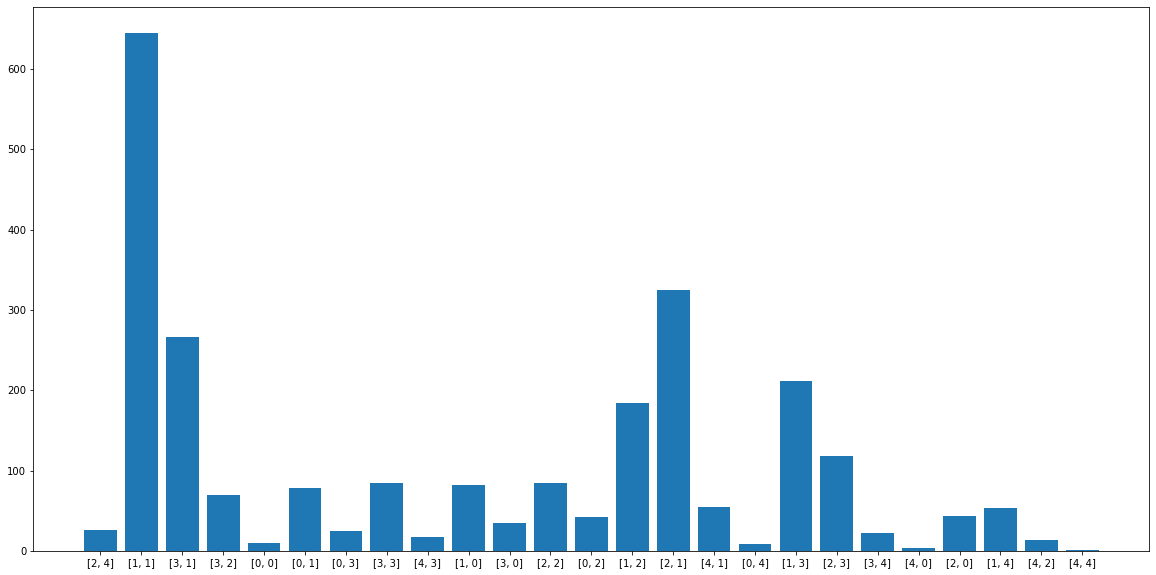

Processing Epoch 116
training start
Iteration 0, d real/fake loss 0.6433145999908447/0.6360234022140503 and g loss is 0.72456294298172, NDiv loss 0.06688736379146576
Iteration 1, d real/fake loss 0.6433690786361694/0.6594704389572144 and g loss is 0.7340555191040039, NDiv loss 0.08678171038627625
Iteration 2, d real/fake loss 0.6434129476547241/0.6846505999565125 and g loss is 0.7445043325424194, NDiv loss 0.07500922679901123
Iteration 3, d real/fake loss 0.6434727907180786/0.661794900894165 and g loss is 0.7383438348770142, NDiv loss 0.07445140928030014
Iteration 4, d real/fake loss 0.6435157060623169/0.6425946950912476 and g loss is 0.7218434810638428, NDiv loss 0.0795789435505867


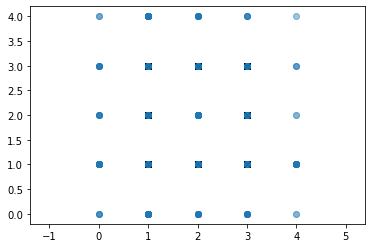

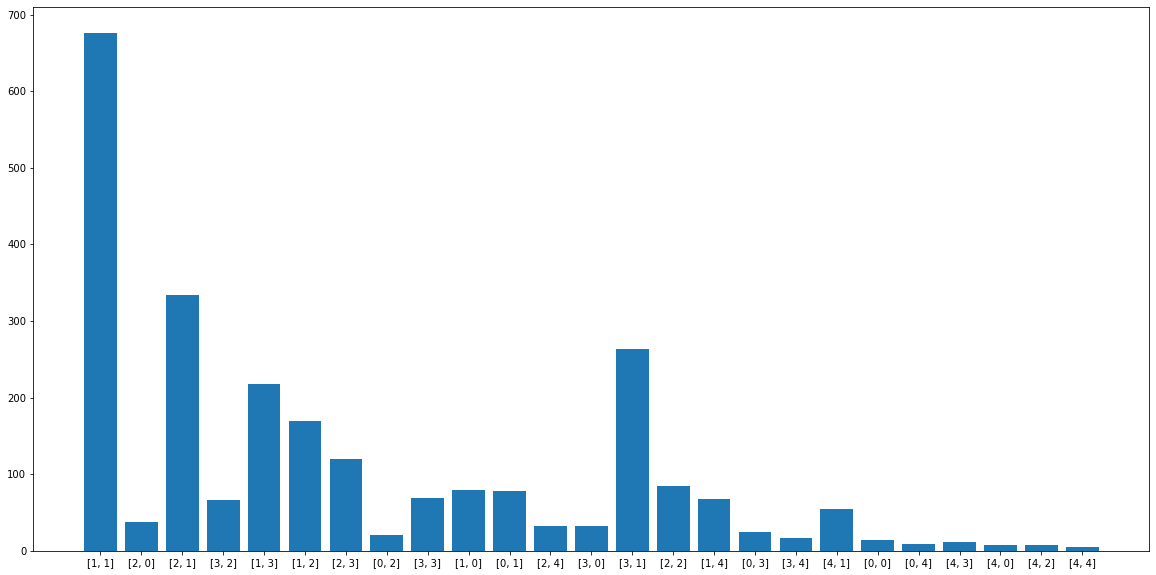

Processing Epoch 117
training start
Iteration 0, d real/fake loss 0.6524196863174438/0.6632672548294067 and g loss is 0.7379075288772583, NDiv loss 0.07743657380342484
Iteration 1, d real/fake loss 0.6524454355239868/0.6612117886543274 and g loss is 0.7519965171813965, NDiv loss 0.08573299646377563
Iteration 2, d real/fake loss 0.6524644494056702/0.652255654335022 and g loss is 0.7539745569229126, NDiv loss 0.07817622274160385
Iteration 3, d real/fake loss 0.652466893196106/0.6619225740432739 and g loss is 0.7385604977607727, NDiv loss 0.08228851109743118
Iteration 4, d real/fake loss 0.6524579524993896/0.6656074523925781 and g loss is 0.7272002100944519, NDiv loss 0.09368305653333664


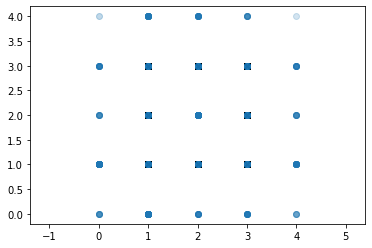

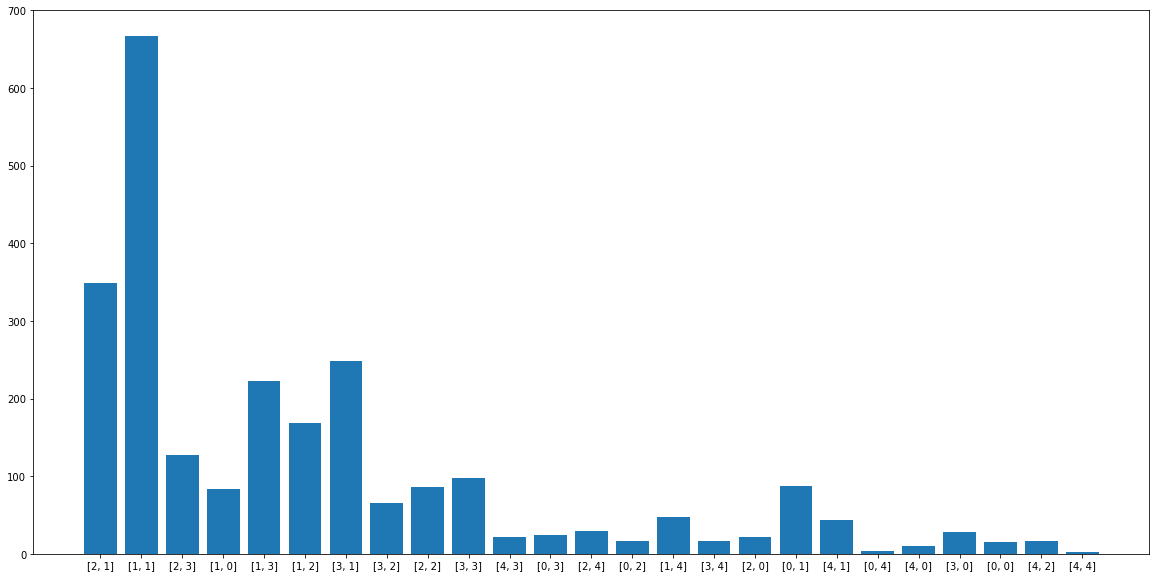

Processing Epoch 118
training start
Iteration 0, d real/fake loss 0.6483546495437622/0.6790518164634705 and g loss is 0.7372987270355225, NDiv loss 0.09885916113853455
Iteration 1, d real/fake loss 0.6484206914901733/0.6706221103668213 and g loss is 0.7219352722167969, NDiv loss 0.07857576757669449
Iteration 2, d real/fake loss 0.6484719514846802/0.663825511932373 and g loss is 0.7133976221084595, NDiv loss 0.08135399967432022
Iteration 3, d real/fake loss 0.6485053896903992/0.659010112285614 and g loss is 0.7486892938613892, NDiv loss 0.08474872261285782
Iteration 4, d real/fake loss 0.6485307812690735/0.6749647259712219 and g loss is 0.7268344759941101, NDiv loss 0.06804461777210236


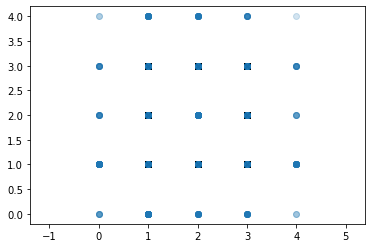

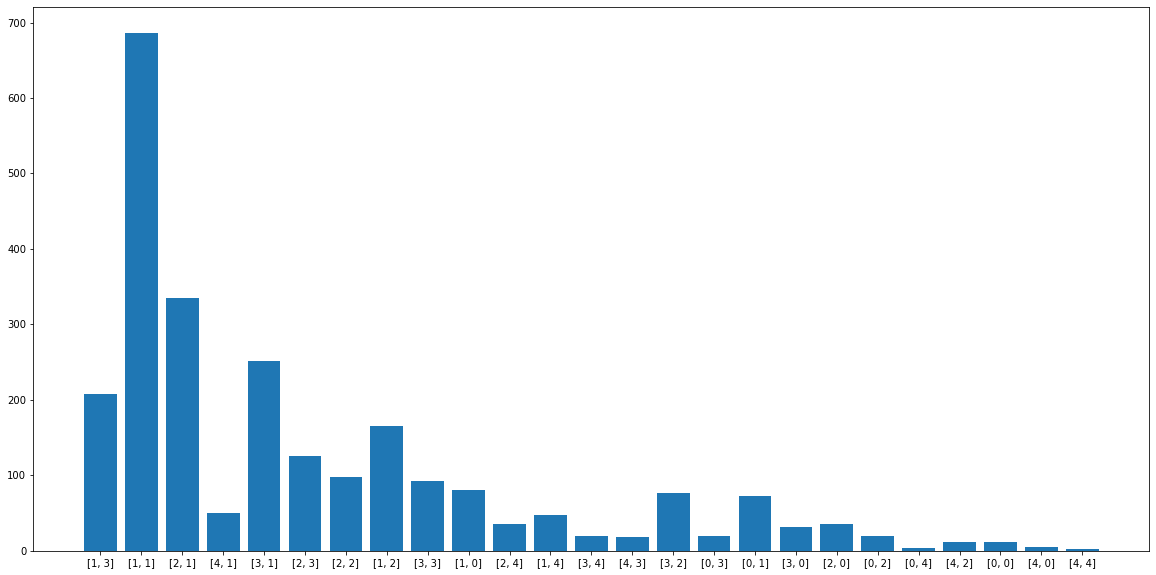

Processing Epoch 119
training start
Iteration 0, d real/fake loss 0.6498401165008545/0.6481021642684937 and g loss is 0.7368879318237305, NDiv loss 0.10315107554197311
Iteration 1, d real/fake loss 0.6497542858123779/0.6585673093795776 and g loss is 0.7180359363555908, NDiv loss 0.07863834500312805
Iteration 2, d real/fake loss 0.6496561765670776/0.672805905342102 and g loss is 0.7408639192581177, NDiv loss 0.09736950695514679
Iteration 3, d real/fake loss 0.6495429277420044/0.6764689087867737 and g loss is 0.7175636291503906, NDiv loss 0.07556169480085373
Iteration 4, d real/fake loss 0.6494341492652893/0.6704010963439941 and g loss is 0.7348467111587524, NDiv loss 0.06302657723426819


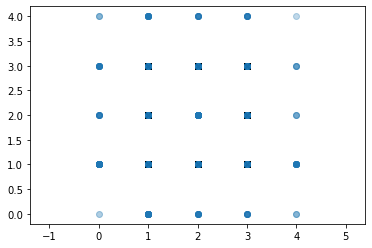

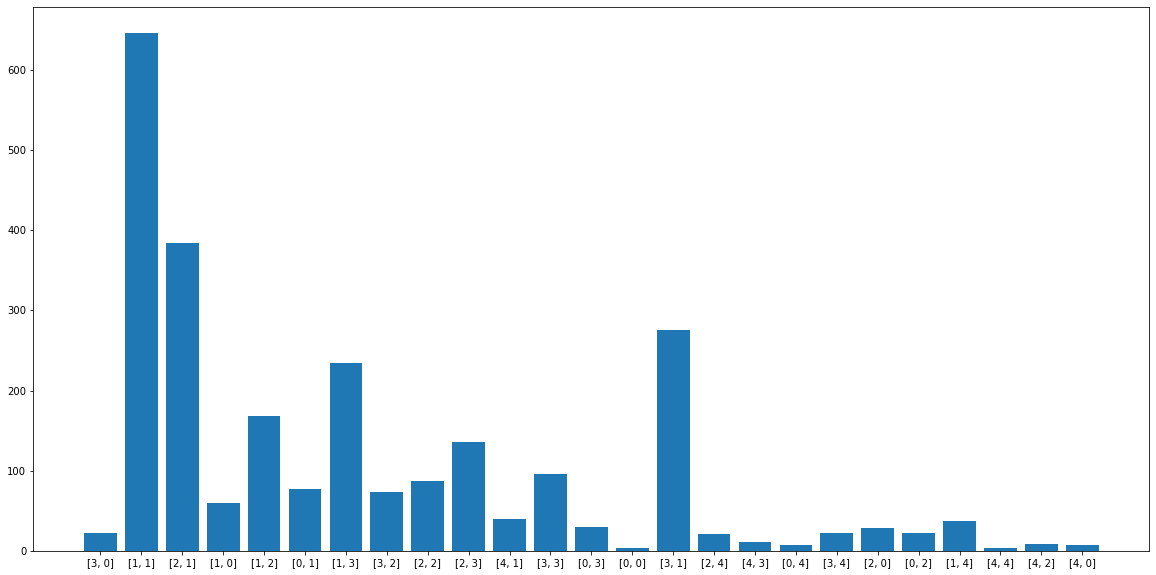

Processing Epoch 120
training start
Iteration 0, d real/fake loss 0.6404471397399902/0.6711083650588989 and g loss is 0.7245240807533264, NDiv loss 0.08362066000699997
Iteration 1, d real/fake loss 0.6404568552970886/0.6615365147590637 and g loss is 0.7355901598930359, NDiv loss 0.07750332355499268
Iteration 2, d real/fake loss 0.6404678821563721/0.6747748851776123 and g loss is 0.7481774091720581, NDiv loss 0.0864916518330574
Iteration 3, d real/fake loss 0.6404862403869629/0.6812273263931274 and g loss is 0.7107597589492798, NDiv loss 0.08529729396104813
Iteration 4, d real/fake loss 0.6405218839645386/0.6774166226387024 and g loss is 0.7443602085113525, NDiv loss 0.06851371377706528


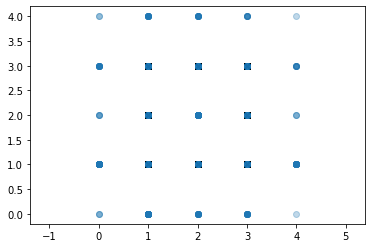

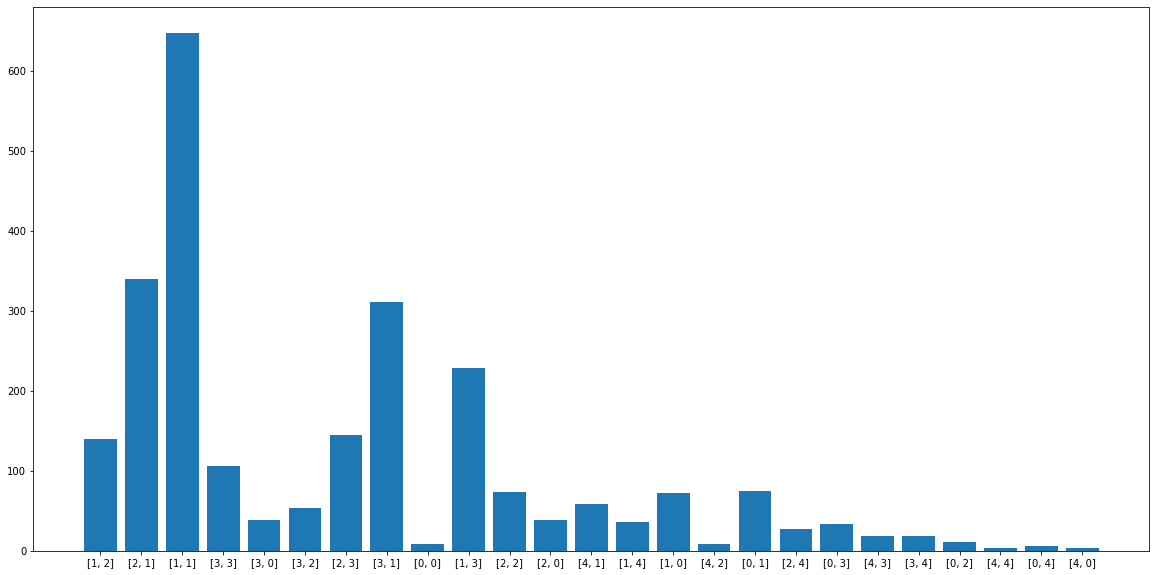

Processing Epoch 121
training start
Iteration 0, d real/fake loss 0.6367796659469604/0.6669881939888 and g loss is 0.7258712649345398, NDiv loss 0.07745996862649918
Iteration 1, d real/fake loss 0.6367830038070679/0.6871242523193359 and g loss is 0.7398842573165894, NDiv loss 0.08407443761825562
Iteration 2, d real/fake loss 0.6368000507354736/0.6705818176269531 and g loss is 0.7418844103813171, NDiv loss 0.0730273425579071
Iteration 3, d real/fake loss 0.636819064617157/0.6702134609222412 and g loss is 0.7149302959442139, NDiv loss 0.06981723755598068
Iteration 4, d real/fake loss 0.6368420720100403/0.6724938154220581 and g loss is 0.7394775748252869, NDiv loss 0.08735163509845734


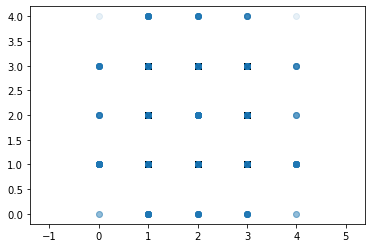

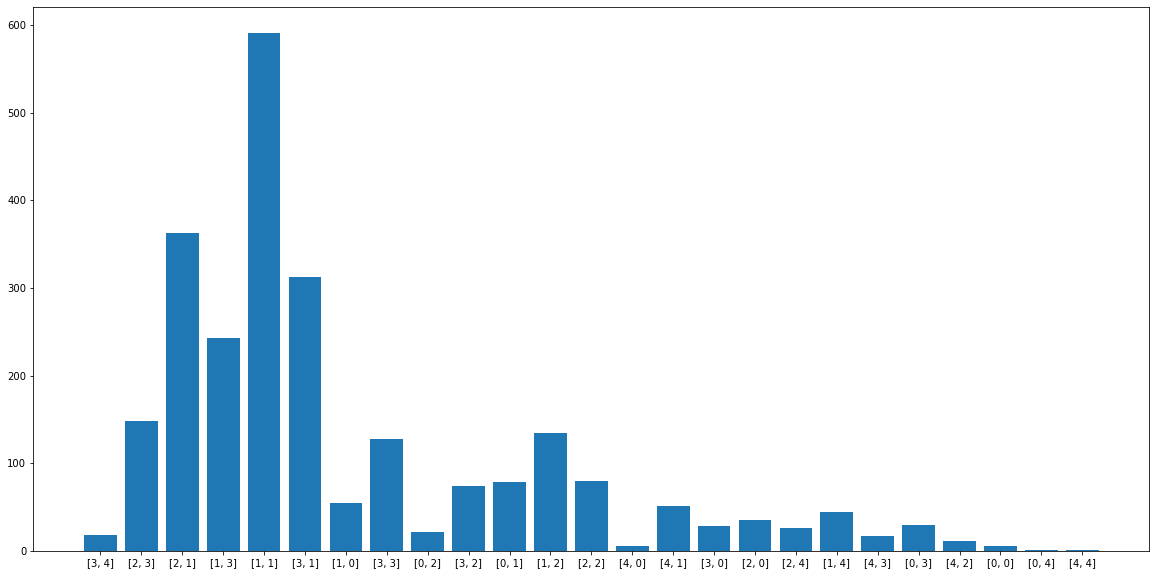

Processing Epoch 122
training start
Iteration 0, d real/fake loss 0.6532737016677856/0.6803208589553833 and g loss is 0.736441969871521, NDiv loss 0.08440642058849335
Iteration 1, d real/fake loss 0.6533526182174683/0.6901462078094482 and g loss is 0.7230910658836365, NDiv loss 0.07181346416473389
Iteration 2, d real/fake loss 0.6534390449523926/0.6504115462303162 and g loss is 0.721284806728363, NDiv loss 0.07689797878265381
Iteration 3, d real/fake loss 0.6534895896911621/0.6980123519897461 and g loss is 0.7419769167900085, NDiv loss 0.07559946924448013
Iteration 4, d real/fake loss 0.653549313545227/0.6730600595474243 and g loss is 0.7130908966064453, NDiv loss 0.08236431330442429


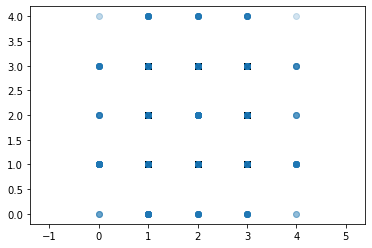

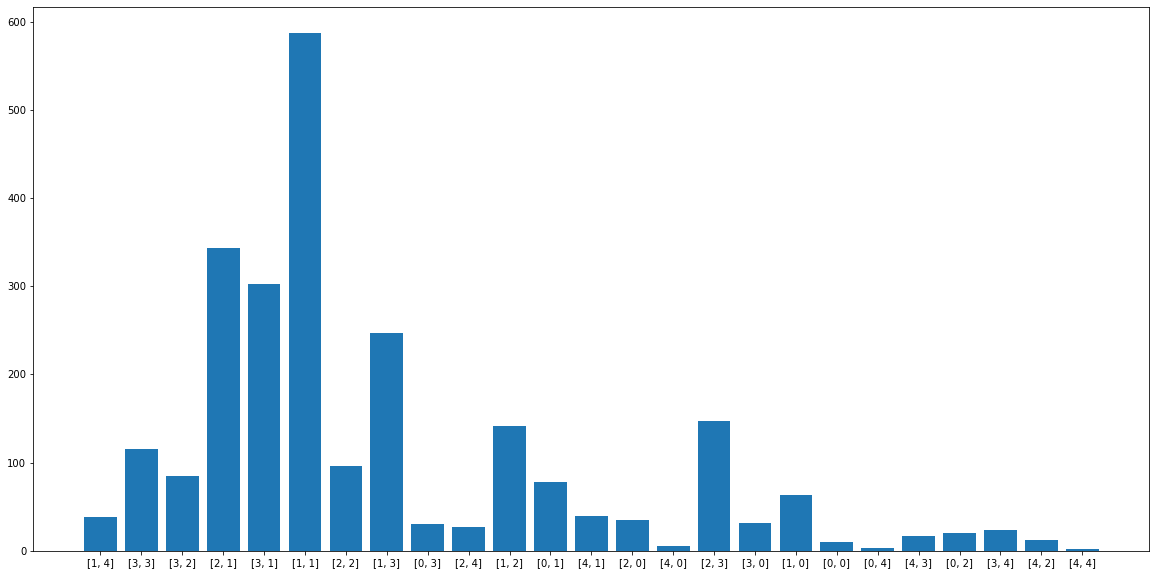

Processing Epoch 123
training start
Iteration 0, d real/fake loss 0.6434155106544495/0.6712359189987183 and g loss is 0.7422990202903748, NDiv loss 0.06979566812515259
Iteration 1, d real/fake loss 0.6434124708175659/0.6802195310592651 and g loss is 0.7084612250328064, NDiv loss 0.0915282592177391
Iteration 2, d real/fake loss 0.6434108018875122/0.6678034067153931 and g loss is 0.7573609352111816, NDiv loss 0.06854679435491562
Iteration 3, d real/fake loss 0.6434113383293152/0.6720715761184692 and g loss is 0.7281948328018188, NDiv loss 0.07259513437747955
Iteration 4, d real/fake loss 0.6434122323989868/0.6832234263420105 and g loss is 0.7351770997047424, NDiv loss 0.08811969310045242


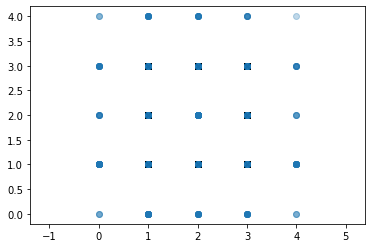

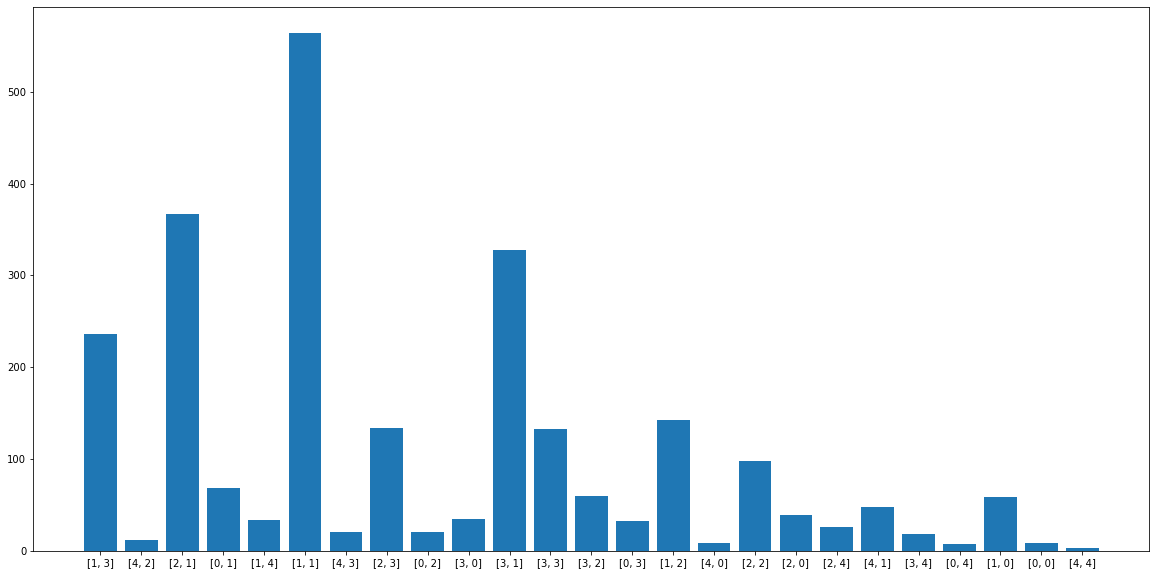

Processing Epoch 124
training start
Iteration 0, d real/fake loss 0.6586990356445312/0.667086660861969 and g loss is 0.7301544547080994, NDiv loss 0.09531979262828827
Iteration 1, d real/fake loss 0.6587042808532715/0.6842813491821289 and g loss is 0.7362889051437378, NDiv loss 0.07729551196098328
Iteration 2, d real/fake loss 0.6586984395980835/0.68095862865448 and g loss is 0.7347112894058228, NDiv loss 0.07173965126276016
Iteration 3, d real/fake loss 0.6586819291114807/0.6783300638198853 and g loss is 0.7424818873405457, NDiv loss 0.07129515707492828
Iteration 4, d real/fake loss 0.6586564183235168/0.6876317858695984 and g loss is 0.7161601185798645, NDiv loss 0.08117637783288956


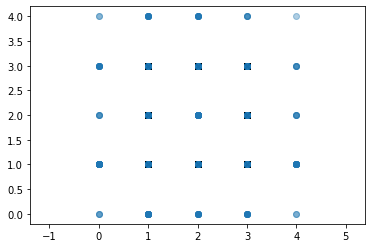

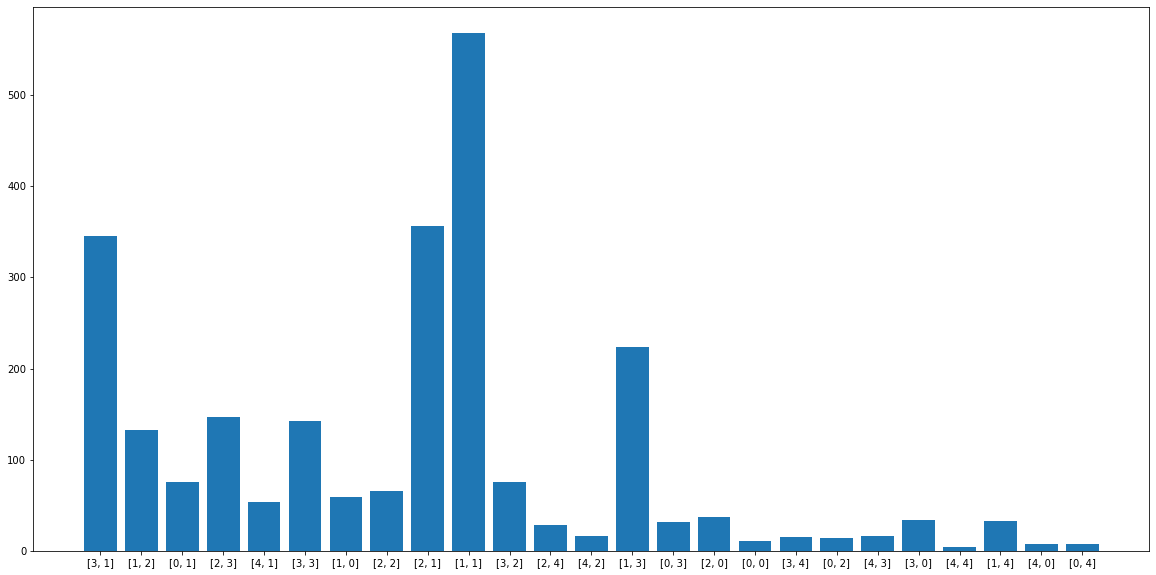

Processing Epoch 125
training start
Iteration 0, d real/fake loss 0.6296229362487793/0.6461471319198608 and g loss is 0.74073326587677, NDiv loss 0.07197040319442749
Iteration 1, d real/fake loss 0.6295676827430725/0.6770391464233398 and g loss is 0.7136398553848267, NDiv loss 0.06643835455179214
Iteration 2, d real/fake loss 0.6295234560966492/0.6631510853767395 and g loss is 0.7253652215003967, NDiv loss 0.07579068839550018
Iteration 3, d real/fake loss 0.6294803619384766/0.6783060431480408 and g loss is 0.7097512483596802, NDiv loss 0.0722896084189415
Iteration 4, d real/fake loss 0.6294477581977844/0.6749892830848694 and g loss is 0.7207308411598206, NDiv loss 0.07477973401546478


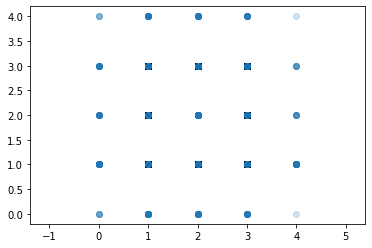

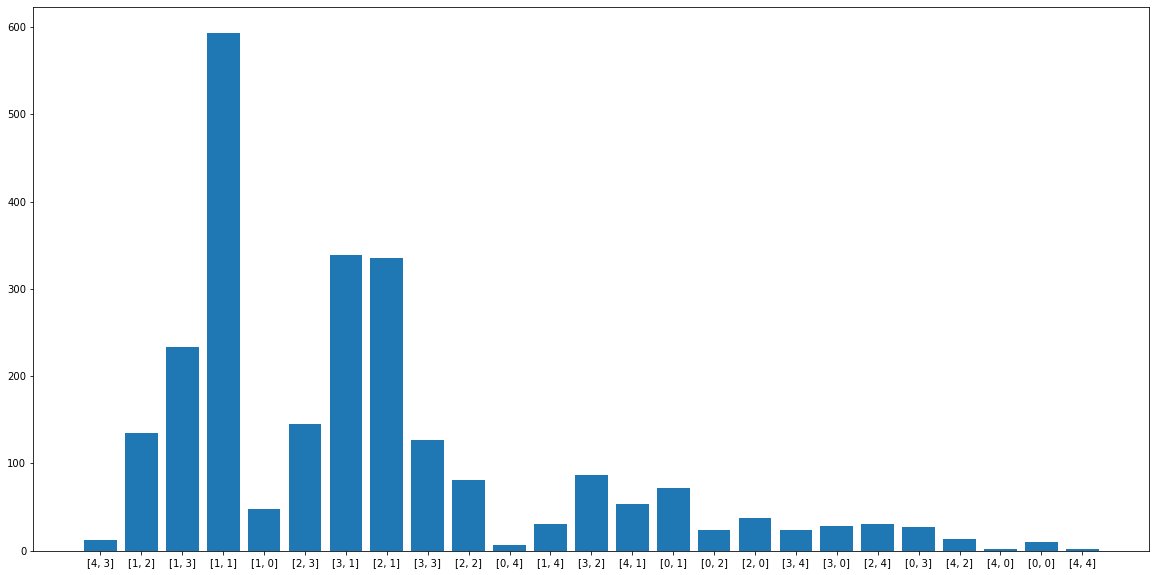

Processing Epoch 126
training start
Iteration 0, d real/fake loss 0.6437492966651917/0.6835471391677856 and g loss is 0.7319216132164001, NDiv loss 0.07592488825321198
Iteration 1, d real/fake loss 0.6438300609588623/0.6891489028930664 and g loss is 0.7185318470001221, NDiv loss 0.06533559411764145
Iteration 2, d real/fake loss 0.6439260244369507/0.7046006321907043 and g loss is 0.7251847982406616, NDiv loss 0.07505277544260025
Iteration 3, d real/fake loss 0.644041121006012/0.6771044731140137 and g loss is 0.7219851613044739, NDiv loss 0.06901208311319351
Iteration 4, d real/fake loss 0.6441531777381897/0.6658608913421631 and g loss is 0.7394319772720337, NDiv loss 0.07928017526865005


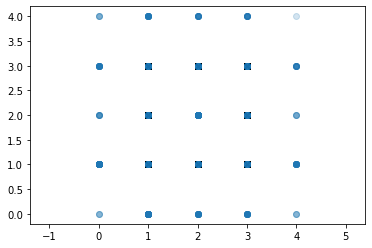

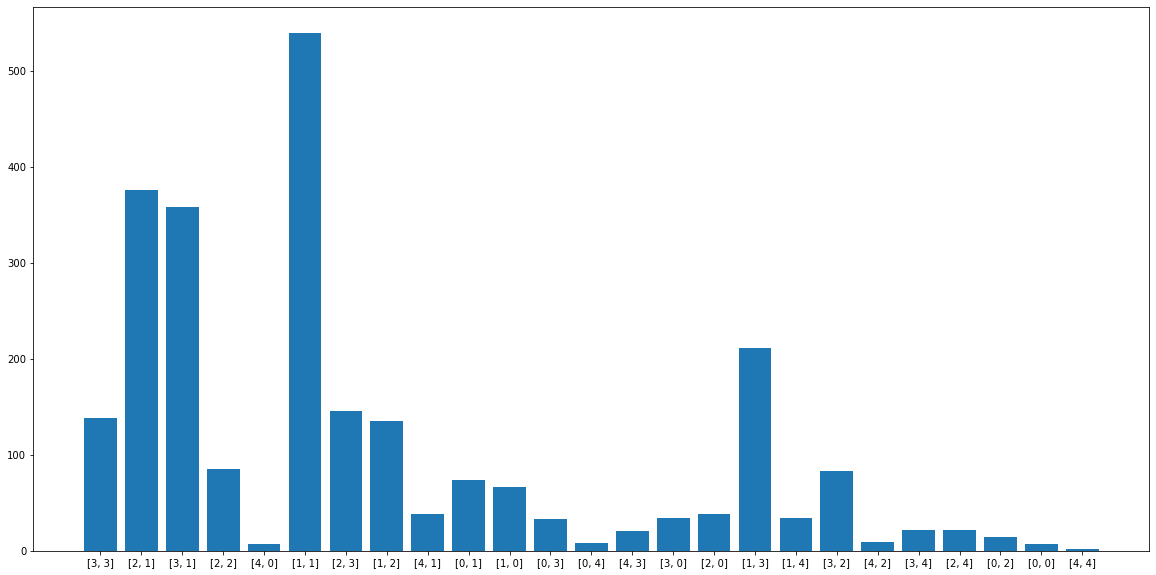

Processing Epoch 127
training start
Iteration 0, d real/fake loss 0.6349751949310303/0.6811851859092712 and g loss is 0.7154747247695923, NDiv loss 0.07918130606412888
Iteration 1, d real/fake loss 0.6350702047348022/0.6763951778411865 and g loss is 0.7264088988304138, NDiv loss 0.06547861546278
Iteration 2, d real/fake loss 0.6351650953292847/0.6675202250480652 and g loss is 0.7395789623260498, NDiv loss 0.09018471837043762
Iteration 3, d real/fake loss 0.6352531909942627/0.6675839424133301 and g loss is 0.7285012602806091, NDiv loss 0.0779421329498291
Iteration 4, d real/fake loss 0.6353271007537842/0.6917744874954224 and g loss is 0.7209466099739075, NDiv loss 0.06414081901311874


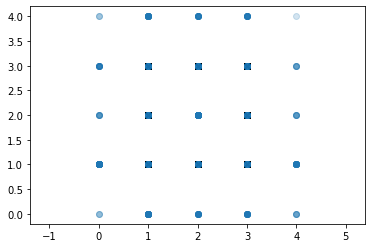

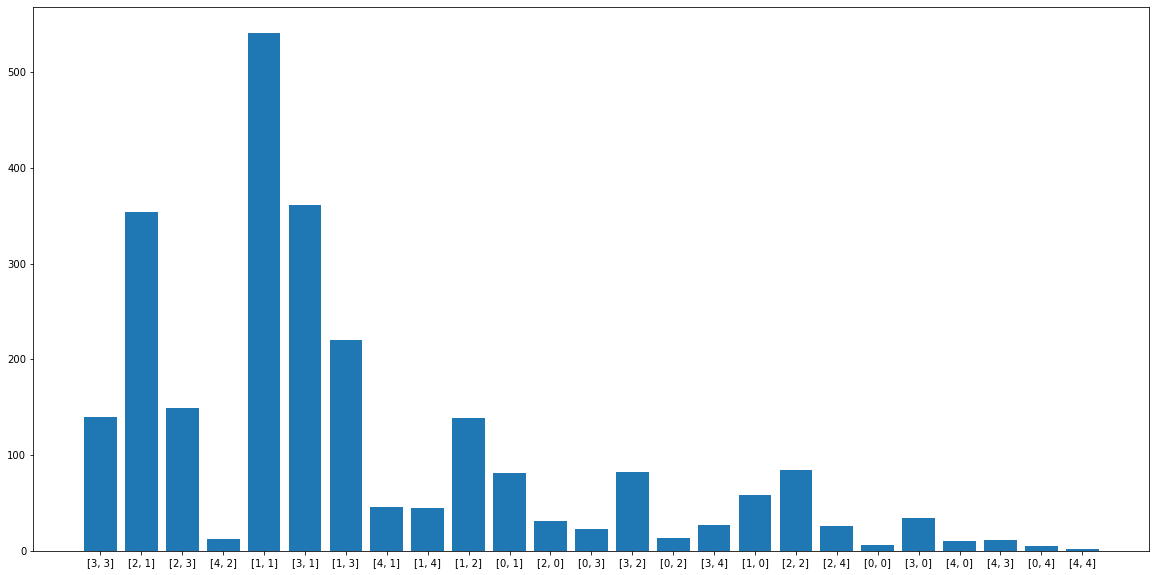

Processing Epoch 128
training start
Iteration 0, d real/fake loss 0.647624135017395/0.6854516267776489 and g loss is 0.718144416809082, NDiv loss 0.07649309933185577
Iteration 1, d real/fake loss 0.6477792263031006/0.6857602596282959 and g loss is 0.7058262825012207, NDiv loss 0.0731116309762001
Iteration 2, d real/fake loss 0.6479392647743225/0.6954947710037231 and g loss is 0.7112846970558167, NDiv loss 0.07271743565797806
Iteration 3, d real/fake loss 0.6481075882911682/0.6826964616775513 and g loss is 0.7233741283416748, NDiv loss 0.07139825820922852
Iteration 4, d real/fake loss 0.6482728719711304/0.6705329418182373 and g loss is 0.7331331968307495, NDiv loss 0.07662922143936157


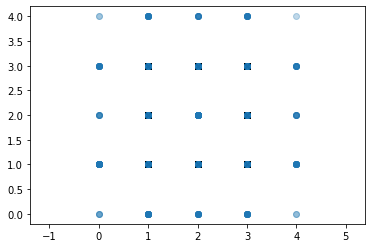

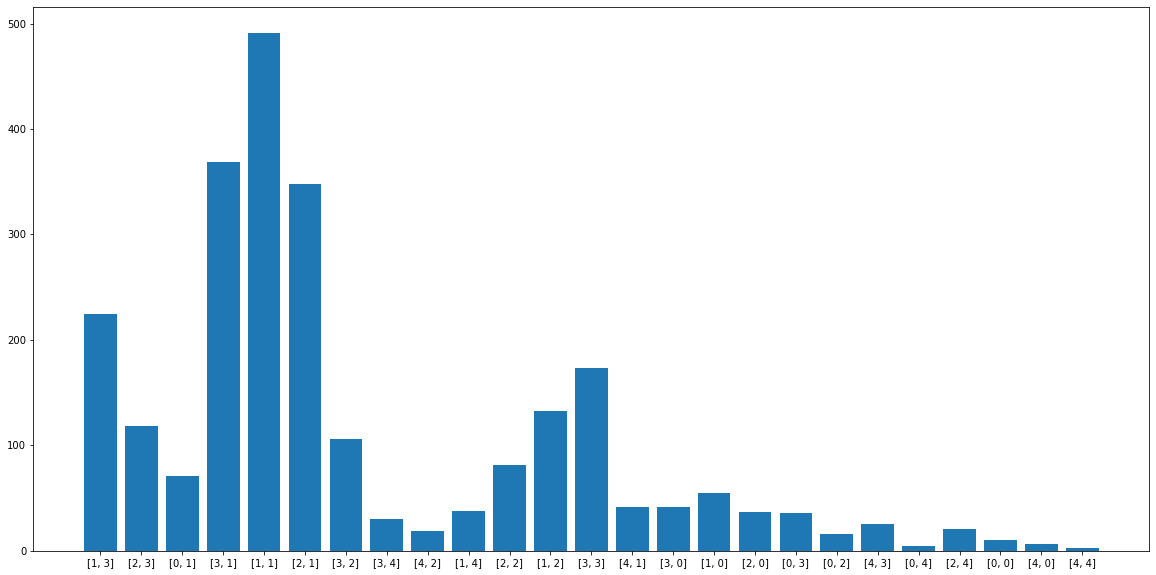

Processing Epoch 129
training start
Iteration 0, d real/fake loss 0.6505789160728455/0.6801553964614868 and g loss is 0.7461779117584229, NDiv loss 0.07951074838638306
Iteration 1, d real/fake loss 0.6507000923156738/0.6945512294769287 and g loss is 0.7111802697181702, NDiv loss 0.08297831565141678
Iteration 2, d real/fake loss 0.6508208513259888/0.692465603351593 and g loss is 0.7145485281944275, NDiv loss 0.06568223237991333
Iteration 3, d real/fake loss 0.6509446501731873/0.6828755140304565 and g loss is 0.7201727032661438, NDiv loss 0.06191191077232361
Iteration 4, d real/fake loss 0.6510608196258545/0.7127213478088379 and g loss is 0.7067983746528625, NDiv loss 0.06817375123500824


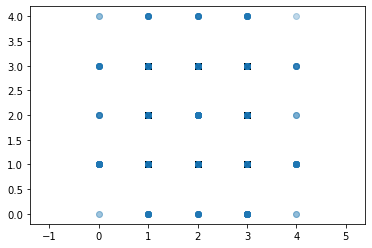

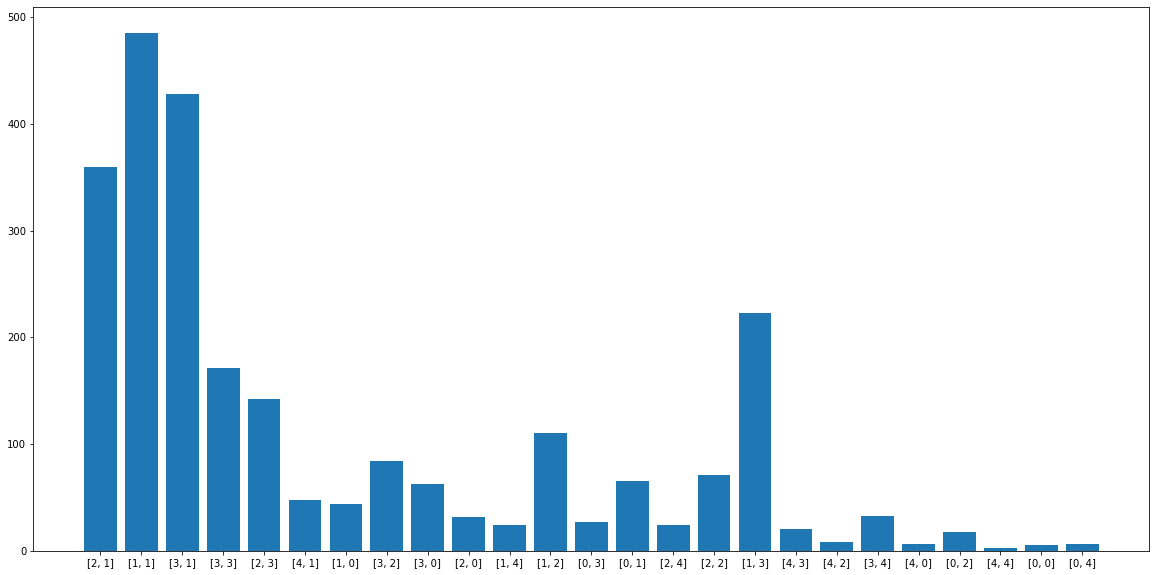

Processing Epoch 130
training start
Iteration 0, d real/fake loss 0.6379178166389465/0.6680623292922974 and g loss is 0.7334290146827698, NDiv loss 0.07428576797246933
Iteration 1, d real/fake loss 0.6379663348197937/0.6656346321105957 and g loss is 0.7410404682159424, NDiv loss 0.07190120220184326
Iteration 2, d real/fake loss 0.6379990577697754/0.7035254240036011 and g loss is 0.7540597915649414, NDiv loss 0.06529717147350311
Iteration 3, d real/fake loss 0.6380465030670166/0.6985592842102051 and g loss is 0.709122896194458, NDiv loss 0.06531614065170288
Iteration 4, d real/fake loss 0.638111412525177/0.680191159248352 and g loss is 0.7201529741287231, NDiv loss 0.081415556371212


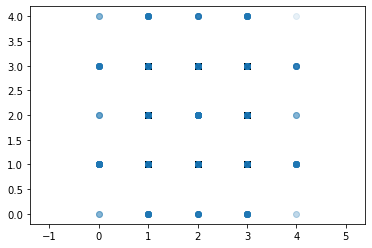

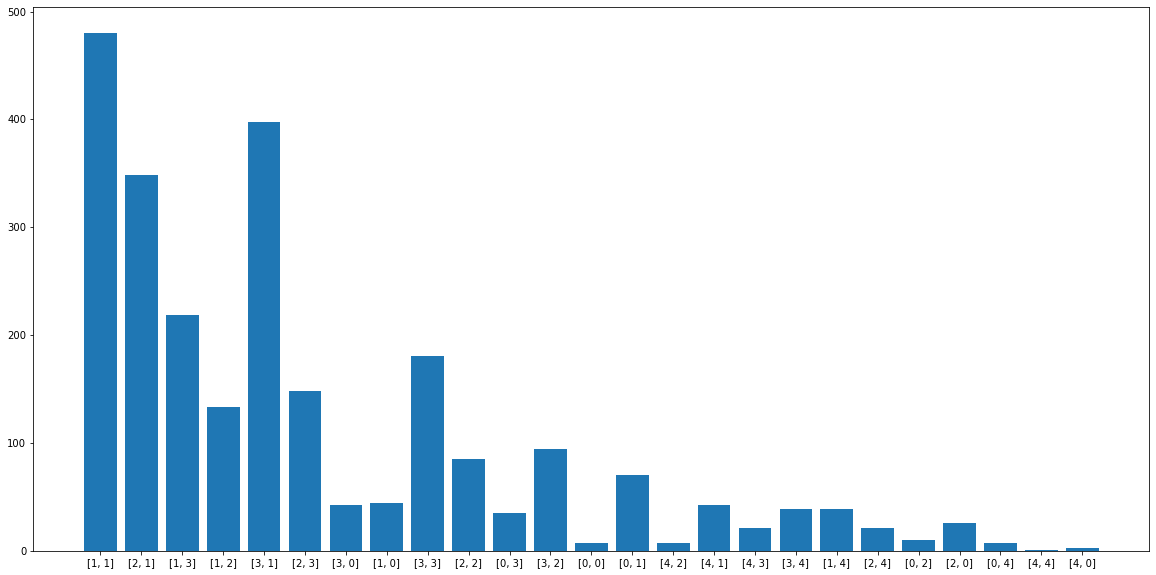

Processing Epoch 131
training start
Iteration 0, d real/fake loss 0.6480661630630493/0.6760053634643555 and g loss is 0.7193542718887329, NDiv loss 0.06241094693541527
Iteration 1, d real/fake loss 0.6481097936630249/0.6954986453056335 and g loss is 0.7407371997833252, NDiv loss 0.0839509442448616
Iteration 2, d real/fake loss 0.6481558084487915/0.6805981993675232 and g loss is 0.7173687815666199, NDiv loss 0.06521502882242203
Iteration 3, d real/fake loss 0.648181676864624/0.6860527396202087 and g loss is 0.7300089597702026, NDiv loss 0.07461395859718323
Iteration 4, d real/fake loss 0.6481941938400269/0.677014946937561 and g loss is 0.7101109027862549, NDiv loss 0.07084573805332184


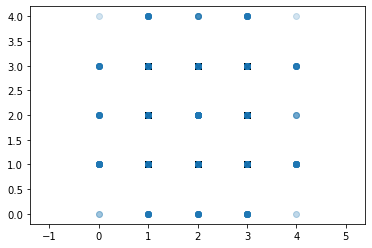

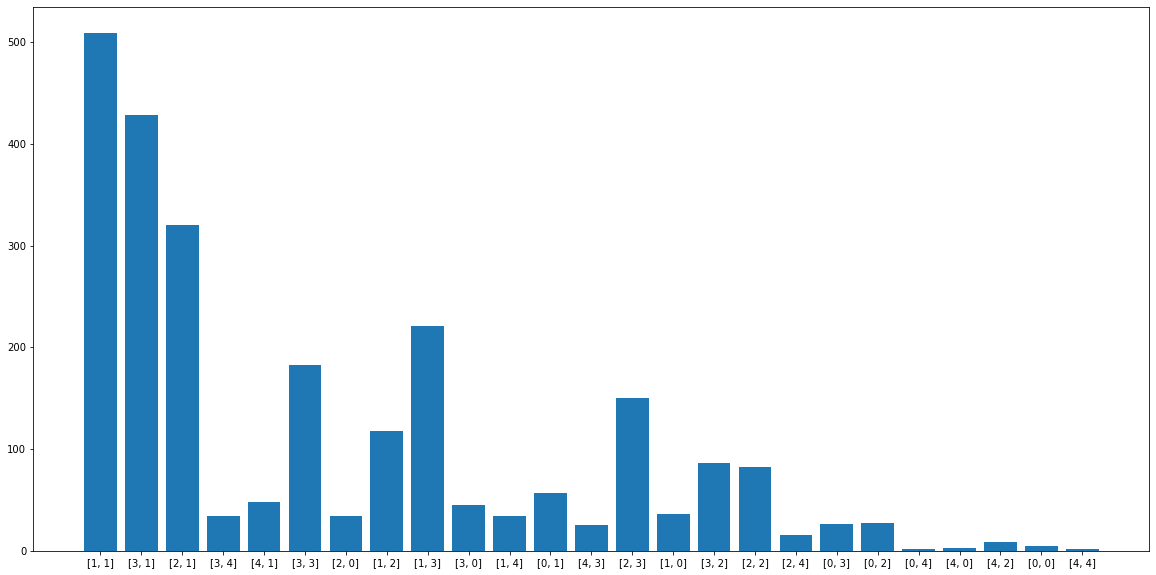

Processing Epoch 132
training start
Iteration 0, d real/fake loss 0.6451640129089355/0.6875902414321899 and g loss is 0.7208385467529297, NDiv loss 0.07209499925374985
Iteration 1, d real/fake loss 0.6453366279602051/0.7134906649589539 and g loss is 0.7079626321792603, NDiv loss 0.07293321192264557
Iteration 2, d real/fake loss 0.6455293893814087/0.7056111693382263 and g loss is 0.7064284086227417, NDiv loss 0.0648038312792778
Iteration 3, d real/fake loss 0.6457366943359375/0.695514440536499 and g loss is 0.7256426811218262, NDiv loss 0.053517404943704605
Iteration 4, d real/fake loss 0.6459513902664185/0.6832942962646484 and g loss is 0.7300721406936646, NDiv loss 0.06404024362564087


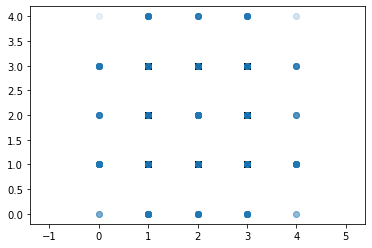

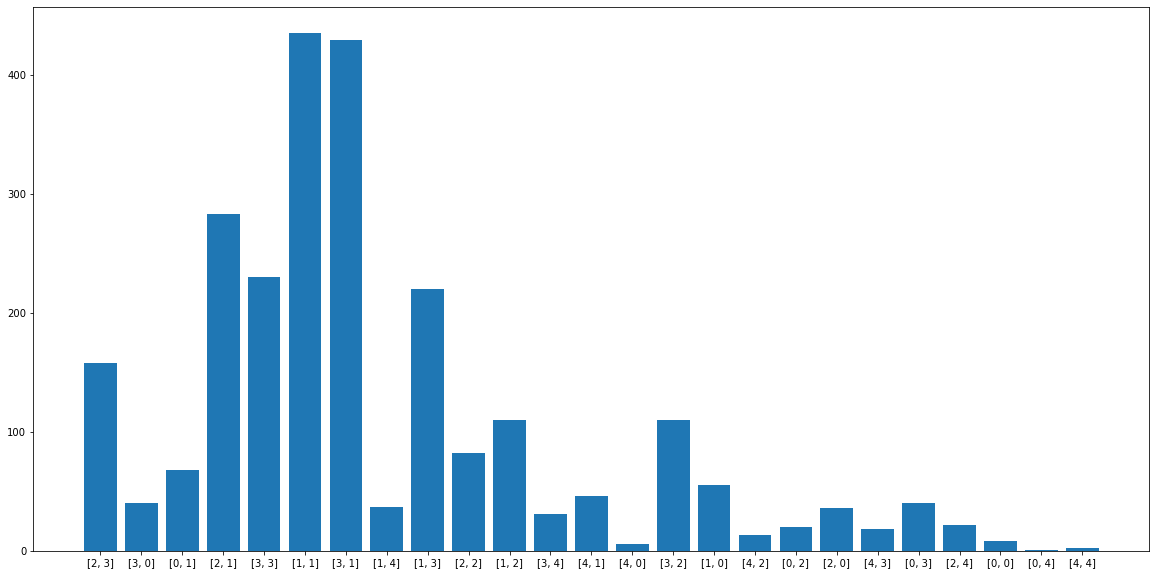

Processing Epoch 133
training start
Iteration 0, d real/fake loss 0.6348390579223633/0.7047730684280396 and g loss is 0.7198613286018372, NDiv loss 0.06884045153856277
Iteration 1, d real/fake loss 0.6349724531173706/0.7009866237640381 and g loss is 0.7139396667480469, NDiv loss 0.06311017274856567
Iteration 2, d real/fake loss 0.635120153427124/0.7053911089897156 and g loss is 0.7056562304496765, NDiv loss 0.06212225928902626
Iteration 3, d real/fake loss 0.635282039642334/0.6885912418365479 and g loss is 0.7027653455734253, NDiv loss 0.05329053848981857
Iteration 4, d real/fake loss 0.6354418396949768/0.6811591982841492 and g loss is 0.7324621677398682, NDiv loss 0.07074351608753204


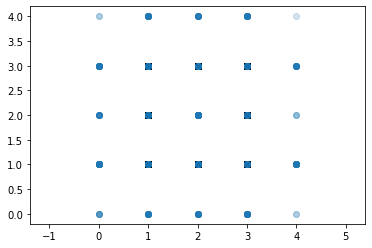

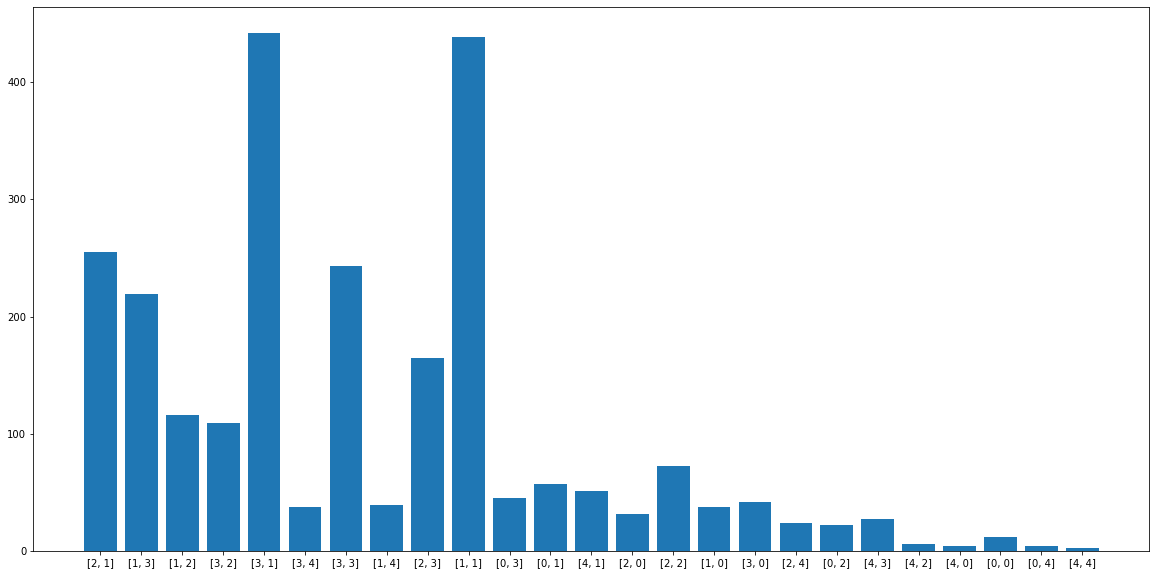

Processing Epoch 134
training start
Iteration 0, d real/fake loss 0.6443843841552734/0.7026268243789673 and g loss is 0.7498242259025574, NDiv loss 0.06607934087514877
Iteration 1, d real/fake loss 0.6444972157478333/0.6650142669677734 and g loss is 0.7088624238967896, NDiv loss 0.07433310896158218
Iteration 2, d real/fake loss 0.6445780992507935/0.6844242811203003 and g loss is 0.7140425443649292, NDiv loss 0.06335929781198502
Iteration 3, d real/fake loss 0.6446462869644165/0.6906132698059082 and g loss is 0.7234721183776855, NDiv loss 0.08493780344724655
Iteration 4, d real/fake loss 0.6447039842605591/0.6861753463745117 and g loss is 0.7126421928405762, NDiv loss 0.06667943298816681


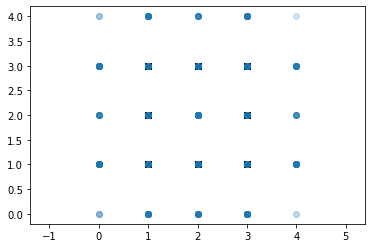

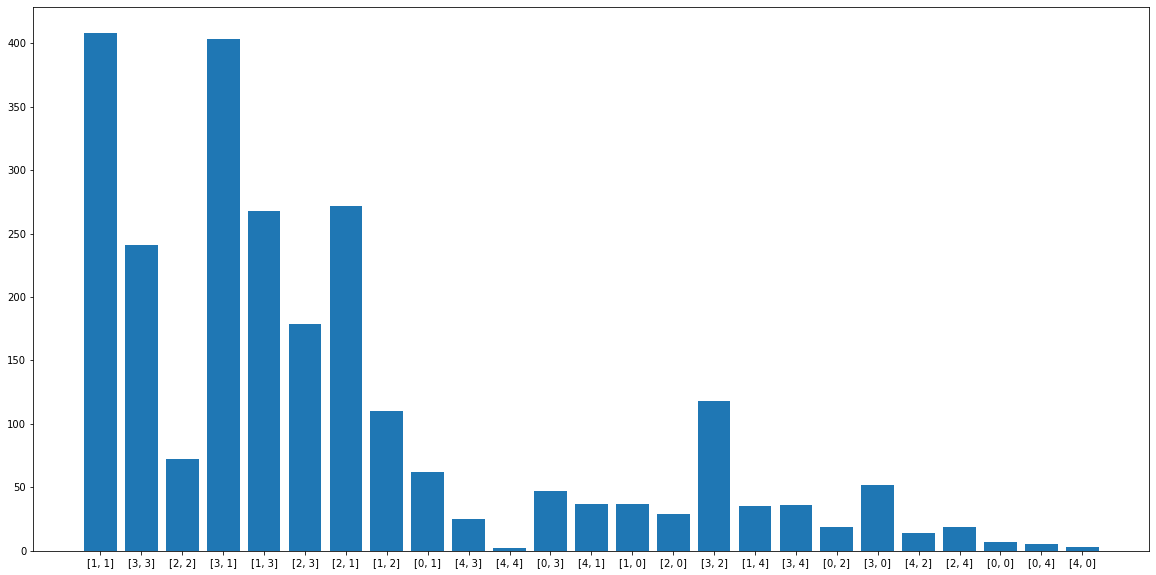

Processing Epoch 135
training start
Iteration 0, d real/fake loss 0.6541028022766113/0.709678590297699 and g loss is 0.7011900544166565, NDiv loss 0.06793433427810669
Iteration 1, d real/fake loss 0.6542612314224243/0.6924213767051697 and g loss is 0.6849616765975952, NDiv loss 0.06500885635614395
Iteration 2, d real/fake loss 0.6544036269187927/0.7134584188461304 and g loss is 0.7206867933273315, NDiv loss 0.0698474571108818
Iteration 3, d real/fake loss 0.6545472741127014/0.7047259211540222 and g loss is 0.7084163427352905, NDiv loss 0.0632539615035057
Iteration 4, d real/fake loss 0.6546876430511475/0.7130404114723206 and g loss is 0.7269812226295471, NDiv loss 0.06755701452493668


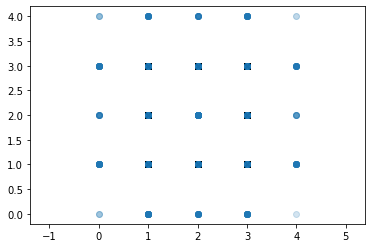

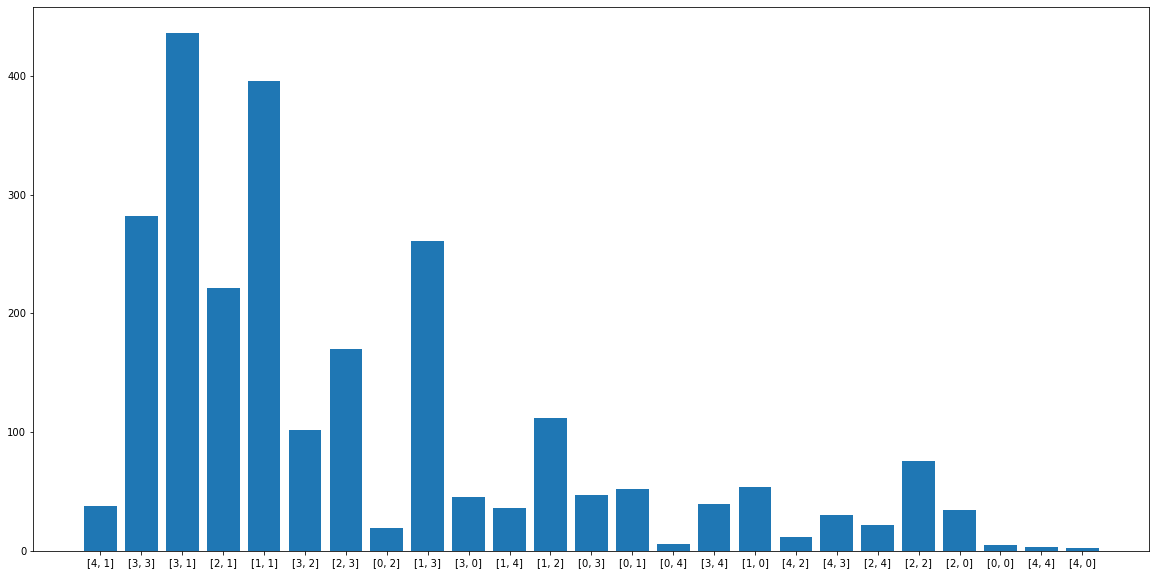

Processing Epoch 136
training start
Iteration 0, d real/fake loss 0.6466629505157471/0.6972438097000122 and g loss is 0.6949772834777832, NDiv loss 0.06850819289684296
Iteration 1, d real/fake loss 0.6467335820198059/0.688265323638916 and g loss is 0.7191451787948608, NDiv loss 0.0658762976527214
Iteration 2, d real/fake loss 0.6467961072921753/0.7228298783302307 and g loss is 0.6805920004844666, NDiv loss 0.07037553936243057
Iteration 3, d real/fake loss 0.6468767523765564/0.7178691029548645 and g loss is 0.7084966897964478, NDiv loss 0.05937725678086281
Iteration 4, d real/fake loss 0.6469703316688538/0.7053001523017883 and g loss is 0.7177221775054932, NDiv loss 0.06822554767131805


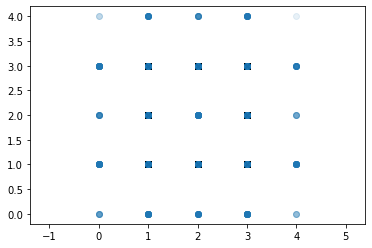

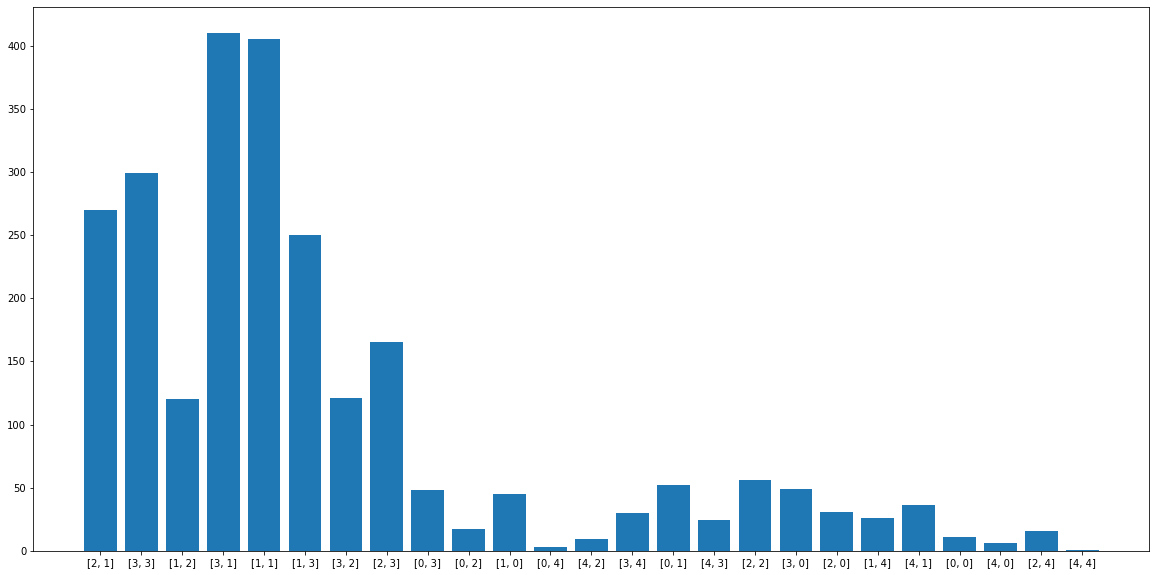

Processing Epoch 137
training start
Iteration 0, d real/fake loss 0.6587363481521606/0.7097482681274414 and g loss is 0.6949318647384644, NDiv loss 0.07349541783332825
Iteration 1, d real/fake loss 0.6588545441627502/0.7048472166061401 and g loss is 0.7096849679946899, NDiv loss 0.06747566908597946
Iteration 2, d real/fake loss 0.6589637398719788/0.6902258992195129 and g loss is 0.7097831964492798, NDiv loss 0.06554383784532547
Iteration 3, d real/fake loss 0.6590551137924194/0.6998699903488159 and g loss is 0.6919798851013184, NDiv loss 0.06759633868932724
Iteration 4, d real/fake loss 0.659132182598114/0.718751072883606 and g loss is 0.7273615598678589, NDiv loss 0.06133437901735306


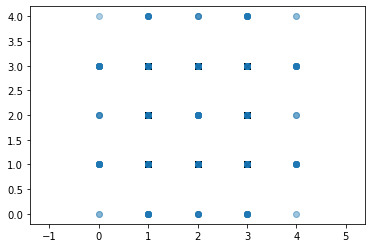

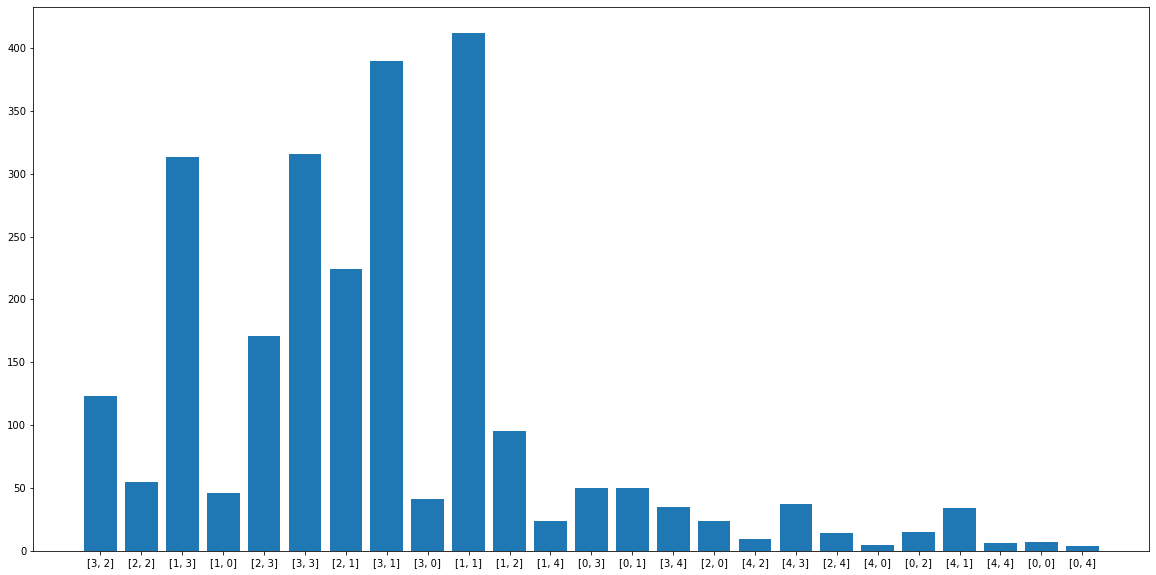

Processing Epoch 138
training start
Iteration 0, d real/fake loss 0.6620851159095764/0.6993105411529541 and g loss is 0.6863874197006226, NDiv loss 0.07309906929731369
Iteration 1, d real/fake loss 0.6621526479721069/0.7103420495986938 and g loss is 0.7085618376731873, NDiv loss 0.06323333084583282
Iteration 2, d real/fake loss 0.6622008085250854/0.6949847936630249 and g loss is 0.6785975694656372, NDiv loss 0.061157990247011185
Iteration 3, d real/fake loss 0.6622293591499329/0.6903347969055176 and g loss is 0.6869262456893921, NDiv loss 0.06914054602384567
Iteration 4, d real/fake loss 0.6622400283813477/0.7295461297035217 and g loss is 0.7024389505386353, NDiv loss 0.058221835643053055


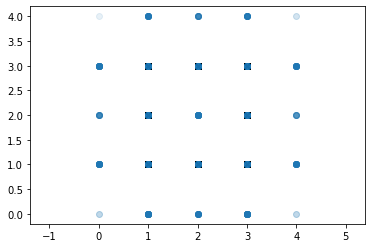

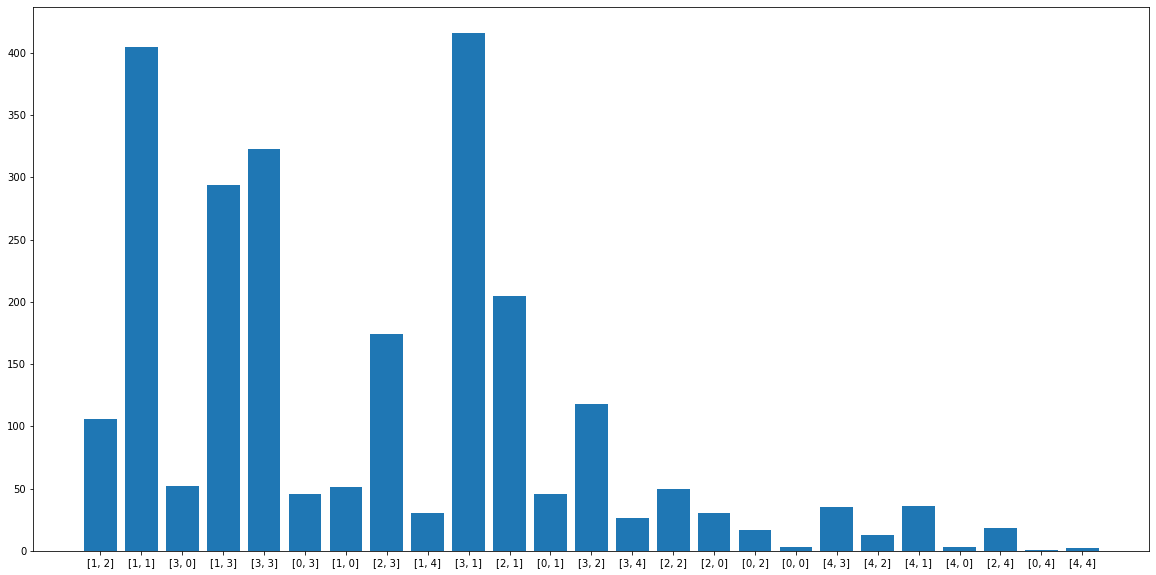

Processing Epoch 139
training start
Iteration 0, d real/fake loss 0.641693651676178/0.7307332754135132 and g loss is 0.6765109300613403, NDiv loss 0.07644528150558472
Iteration 1, d real/fake loss 0.6418519616127014/0.7159691452980042 and g loss is 0.7106969356536865, NDiv loss 0.0681428462266922
Iteration 2, d real/fake loss 0.6420277953147888/0.7203947305679321 and g loss is 0.7265504598617554, NDiv loss 0.07101081311702728
Iteration 3, d real/fake loss 0.6422152519226074/0.71165531873703 and g loss is 0.7004281878471375, NDiv loss 0.07620994746685028
Iteration 4, d real/fake loss 0.6424086689949036/0.7203954458236694 and g loss is 0.7063463926315308, NDiv loss 0.06496194005012512


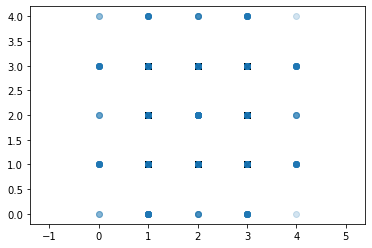

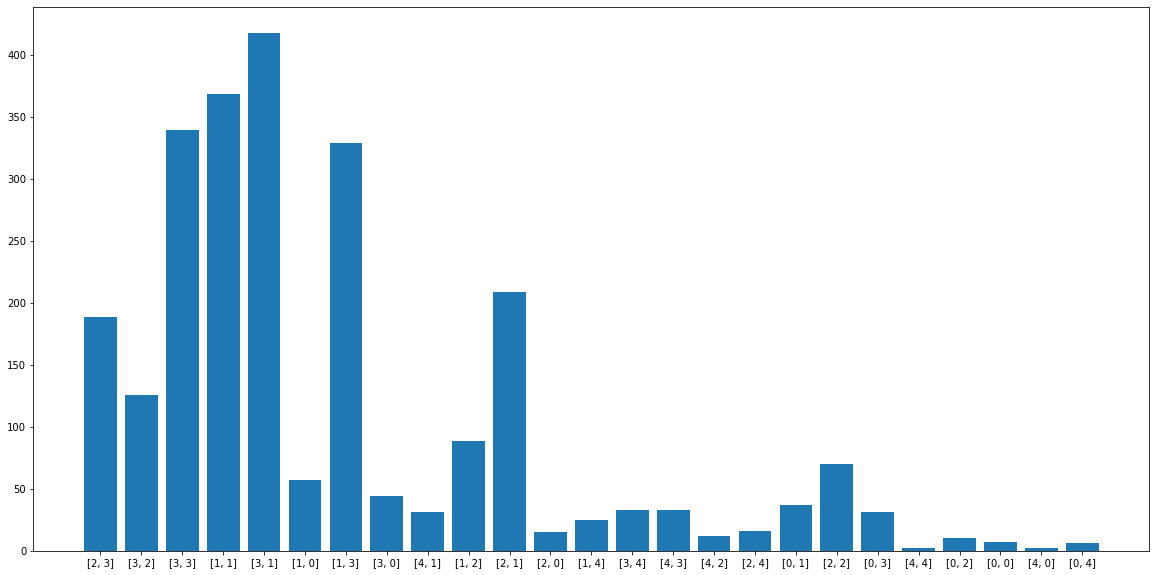

Processing Epoch 140
training start
Iteration 0, d real/fake loss 0.6474651098251343/0.6913026571273804 and g loss is 0.7155294418334961, NDiv loss 0.07536337524652481
Iteration 1, d real/fake loss 0.6476119756698608/0.7158564329147339 and g loss is 0.6984699368476868, NDiv loss 0.07054901123046875
Iteration 2, d real/fake loss 0.647770881652832/0.7366795539855957 and g loss is 0.6915444135665894, NDiv loss 0.06886636465787888
Iteration 3, d real/fake loss 0.6479406356811523/0.7101102471351624 and g loss is 0.7080479860305786, NDiv loss 0.058992899954319
Iteration 4, d real/fake loss 0.6481080651283264/0.6956818103790283 and g loss is 0.6911708116531372, NDiv loss 0.06439536809921265


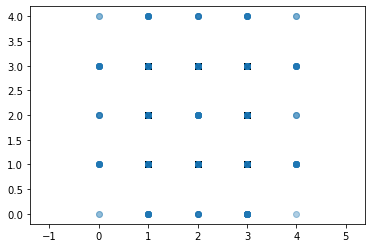

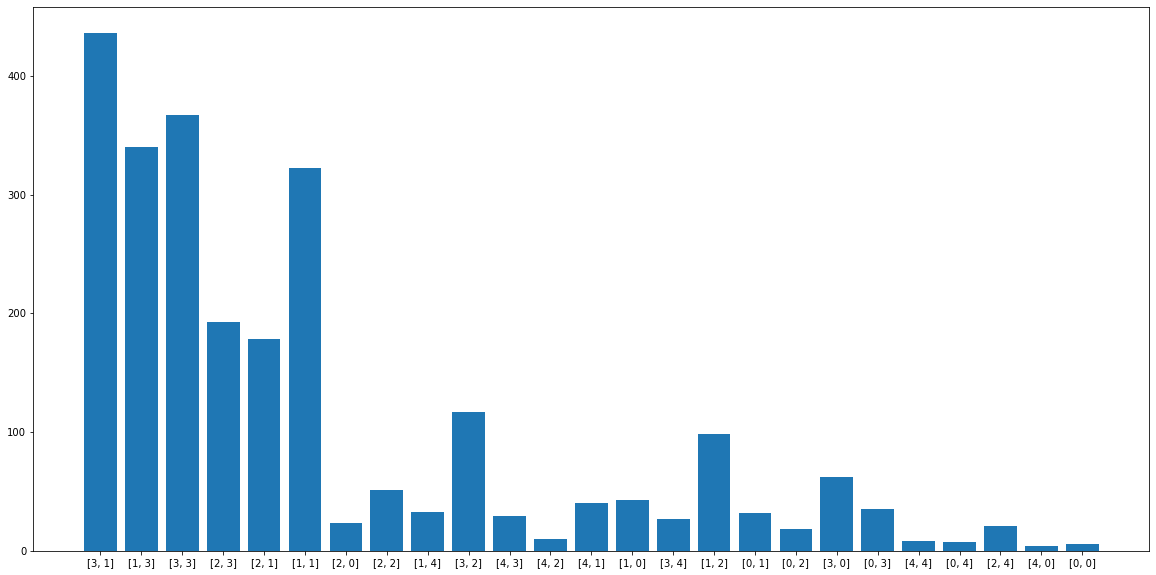

Processing Epoch 141
training start
Iteration 0, d real/fake loss 0.6370974183082581/0.712818443775177 and g loss is 0.6934128403663635, NDiv loss 0.06178167462348938
Iteration 1, d real/fake loss 0.6373329162597656/0.7181702256202698 and g loss is 0.6752128601074219, NDiv loss 0.07727525383234024
Iteration 2, d real/fake loss 0.6375888586044312/0.7113907933235168 and g loss is 0.6928673982620239, NDiv loss 0.06058810278773308
Iteration 3, d real/fake loss 0.637855052947998/0.700867772102356 and g loss is 0.688412070274353, NDiv loss 0.06840698421001434
Iteration 4, d real/fake loss 0.6381142139434814/0.7262499332427979 and g loss is 0.6780703067779541, NDiv loss 0.07424931973218918


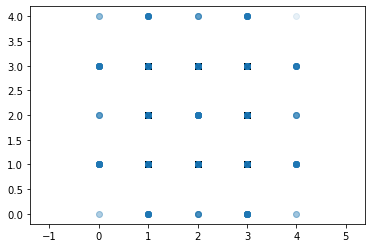

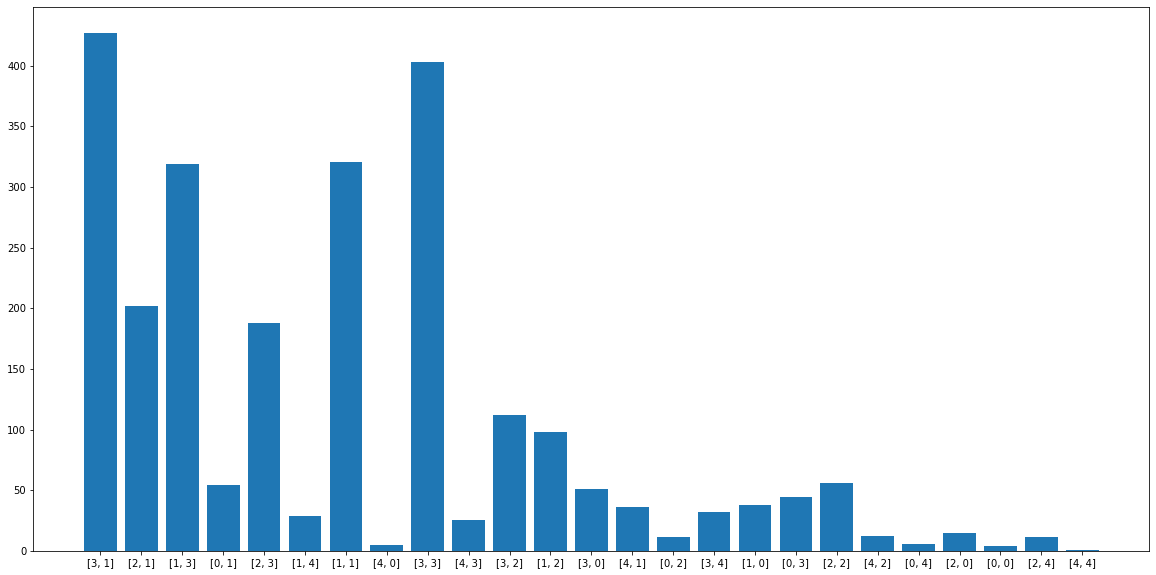

Processing Epoch 142
training start
Iteration 0, d real/fake loss 0.6657129526138306/0.7249327301979065 and g loss is 0.6979584097862244, NDiv loss 0.0684748962521553
Iteration 1, d real/fake loss 0.6659195423126221/0.709814190864563 and g loss is 0.7183446884155273, NDiv loss 0.07713447511196136
Iteration 2, d real/fake loss 0.6661007404327393/0.715180516242981 and g loss is 0.6919718980789185, NDiv loss 0.06775388866662979
Iteration 3, d real/fake loss 0.6662641763687134/0.7155683636665344 and g loss is 0.6931683421134949, NDiv loss 0.05991428717970848
Iteration 4, d real/fake loss 0.6664111018180847/0.7069039940834045 and g loss is 0.6779137849807739, NDiv loss 0.06987295299768448


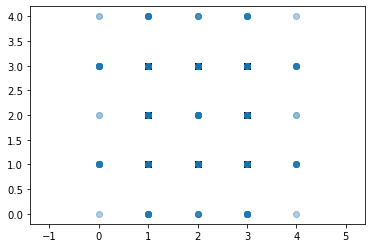

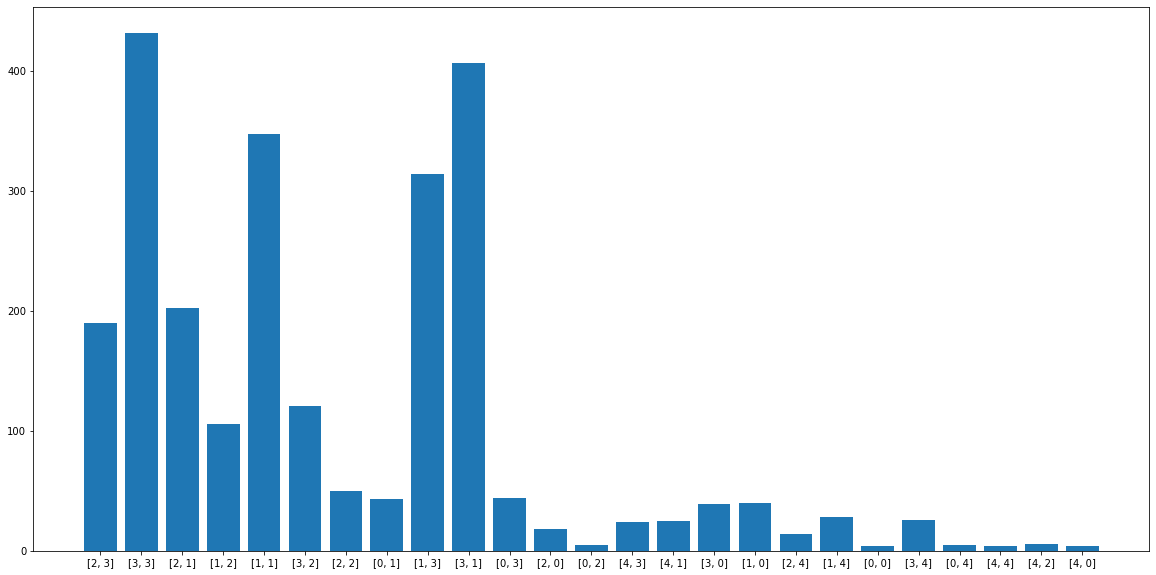

Processing Epoch 143
training start
Iteration 0, d real/fake loss 0.6337997913360596/0.7350358366966248 and g loss is 0.6965855360031128, NDiv loss 0.07103017717599869
Iteration 1, d real/fake loss 0.6340512037277222/0.7327934503555298 and g loss is 0.6981130242347717, NDiv loss 0.0829024612903595
Iteration 2, d real/fake loss 0.6343289613723755/0.7382049560546875 and g loss is 0.6973071098327637, NDiv loss 0.07507770508527756
Iteration 3, d real/fake loss 0.6346370577812195/0.7343427538871765 and g loss is 0.6884214282035828, NDiv loss 0.06218009069561958
Iteration 4, d real/fake loss 0.6349661946296692/0.7253068685531616 and g loss is 0.661845862865448, NDiv loss 0.07197997719049454


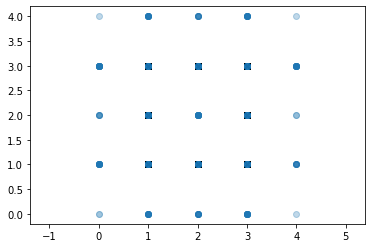

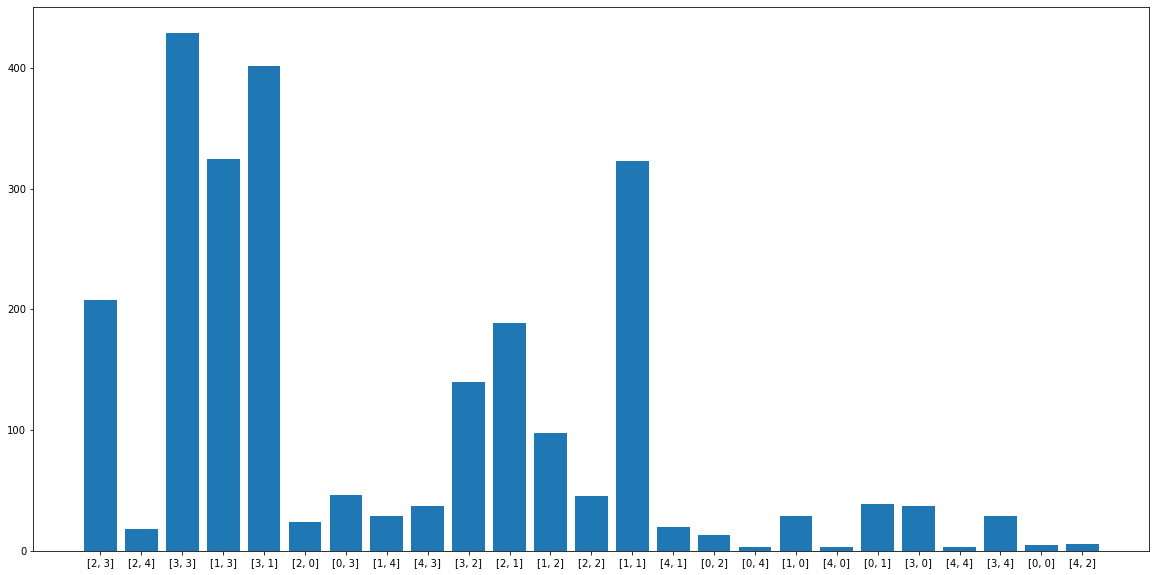

Processing Epoch 144
training start
Iteration 0, d real/fake loss 0.647926390171051/0.7327072024345398 and g loss is 0.6863515377044678, NDiv loss 0.07703797519207001
Iteration 1, d real/fake loss 0.6482863426208496/0.7371130585670471 and g loss is 0.6934634447097778, NDiv loss 0.06126585602760315
Iteration 2, d real/fake loss 0.6486483216285706/0.7199927568435669 and g loss is 0.6743910312652588, NDiv loss 0.06934671849012375
Iteration 3, d real/fake loss 0.6490111947059631/0.720380425453186 and g loss is 0.6737818121910095, NDiv loss 0.07778671383857727
Iteration 4, d real/fake loss 0.6493654847145081/0.7147260904312134 and g loss is 0.6577023267745972, NDiv loss 0.07898025959730148


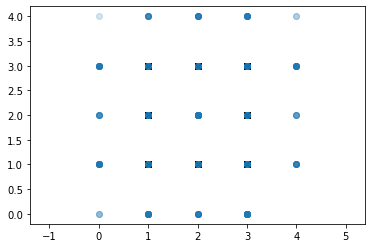

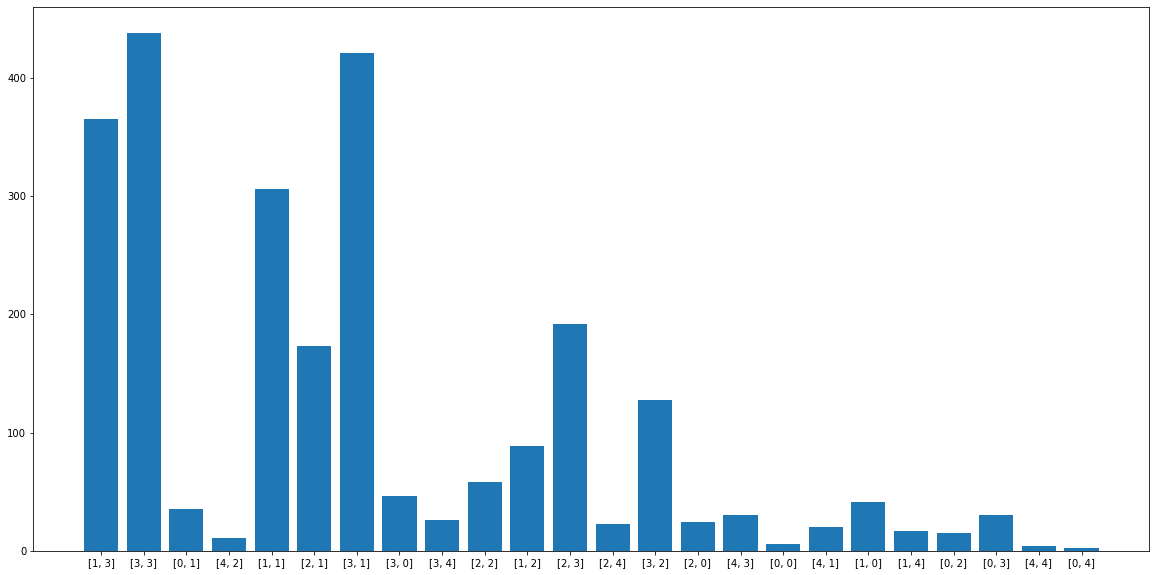

Processing Epoch 145
training start
Iteration 0, d real/fake loss 0.6569188833236694/0.7045607566833496 and g loss is 0.6966512203216553, NDiv loss 0.08088517189025879
Iteration 1, d real/fake loss 0.6571995615959167/0.7027987241744995 and g loss is 0.7030282020568848, NDiv loss 0.07291094213724136
Iteration 2, d real/fake loss 0.6574608087539673/0.7255896925926208 and g loss is 0.6705285310745239, NDiv loss 0.0659899190068245
Iteration 3, d real/fake loss 0.6577099561691284/0.7054526805877686 and g loss is 0.652508020401001, NDiv loss 0.06512787938117981
Iteration 4, d real/fake loss 0.6579456329345703/0.7226190567016602 and g loss is 0.7096884250640869, NDiv loss 0.06394089013338089


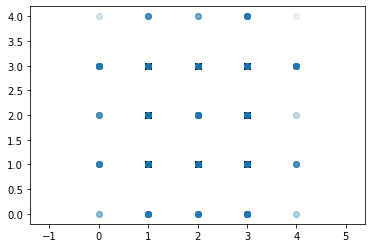

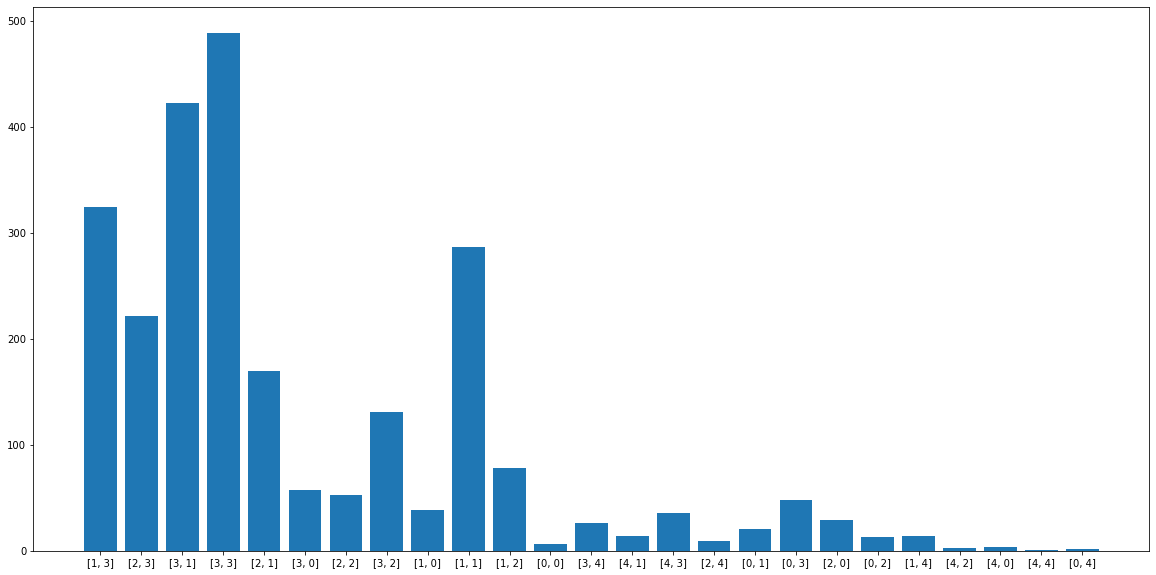

Processing Epoch 146
training start
Iteration 0, d real/fake loss 0.6480836868286133/0.7078788876533508 and g loss is 0.6896474957466125, NDiv loss 0.07930026203393936
Iteration 1, d real/fake loss 0.6483649015426636/0.7116274833679199 and g loss is 0.6862281560897827, NDiv loss 0.08327459543943405
Iteration 2, d real/fake loss 0.6486515998840332/0.7411457896232605 and g loss is 0.6816549301147461, NDiv loss 0.07802072912454605
Iteration 3, d real/fake loss 0.6489548683166504/0.7188390493392944 and g loss is 0.6739975214004517, NDiv loss 0.08055580407381058
Iteration 4, d real/fake loss 0.649254560470581/0.7321059703826904 and g loss is 0.6856992244720459, NDiv loss 0.07021933794021606


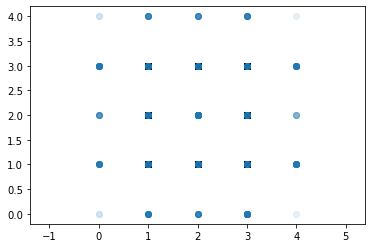

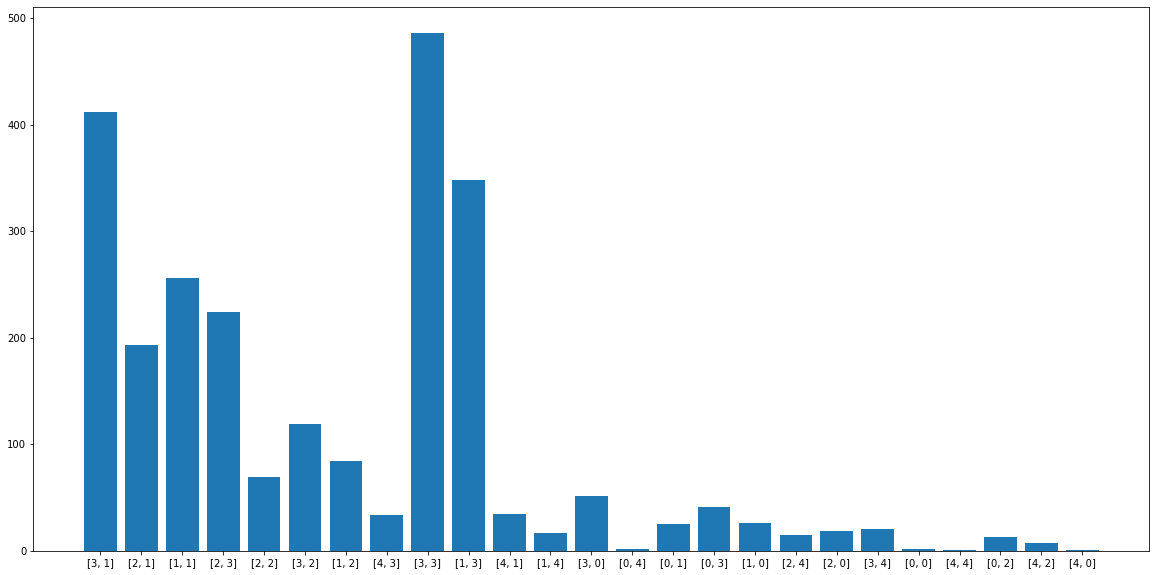

Processing Epoch 147
training start
Iteration 0, d real/fake loss 0.6619688272476196/0.733771026134491 and g loss is 0.6917153596878052, NDiv loss 0.07881597429513931
Iteration 1, d real/fake loss 0.6621818542480469/0.7095308303833008 and g loss is 0.698312520980835, NDiv loss 0.0739331915974617
Iteration 2, d real/fake loss 0.6623716354370117/0.7206242084503174 and g loss is 0.6905949115753174, NDiv loss 0.06768334656953812
Iteration 3, d real/fake loss 0.6625473499298096/0.7244832515716553 and g loss is 0.6909576058387756, NDiv loss 0.07466210424900055
Iteration 4, d real/fake loss 0.6627111434936523/0.75019371509552 and g loss is 0.66839599609375, NDiv loss 0.0737348273396492


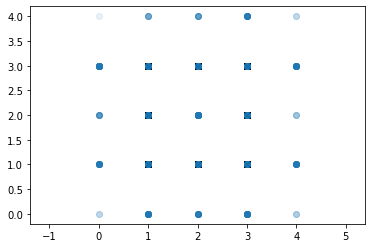

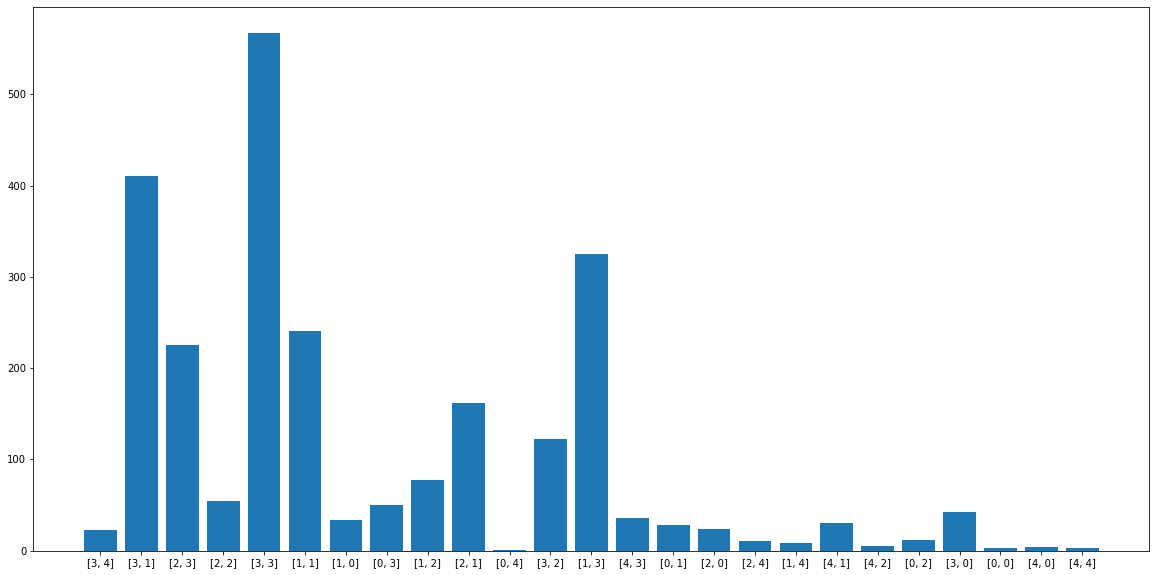

Processing Epoch 148
training start
Iteration 0, d real/fake loss 0.6607609391212463/0.7423868179321289 and g loss is 0.6996330618858337, NDiv loss 0.07440949976444244
Iteration 1, d real/fake loss 0.661001443862915/0.7156624794006348 and g loss is 0.6835403442382812, NDiv loss 0.06736677885055542
Iteration 2, d real/fake loss 0.6612271666526794/0.7233959436416626 and g loss is 0.7031526565551758, NDiv loss 0.08366584777832031
Iteration 3, d real/fake loss 0.6614440679550171/0.7447904944419861 and g loss is 0.6913695931434631, NDiv loss 0.0839720293879509
Iteration 4, d real/fake loss 0.6616634130477905/0.6993770599365234 and g loss is 0.682793140411377, NDiv loss 0.08758700639009476


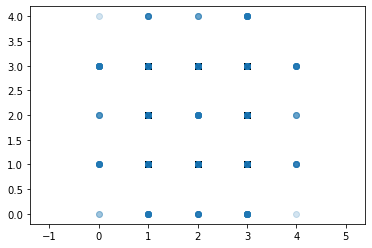

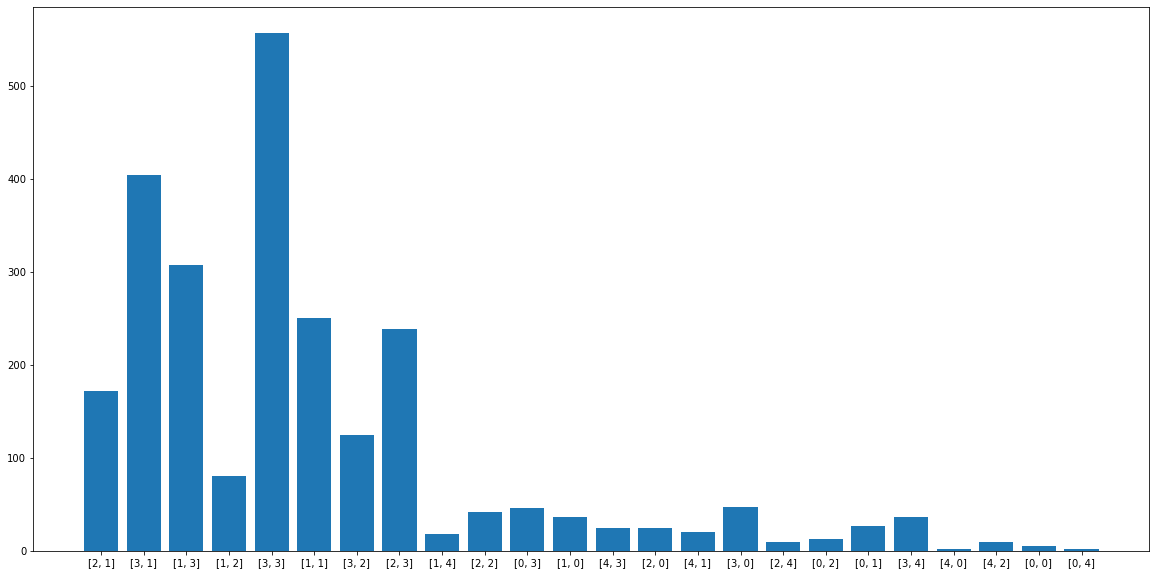

Processing Epoch 149
training start
Iteration 0, d real/fake loss 0.6856322288513184/0.7183069586753845 and g loss is 0.680225670337677, NDiv loss 0.08788143843412399
Iteration 1, d real/fake loss 0.6857675313949585/0.7221483588218689 and g loss is 0.6778947114944458, NDiv loss 0.07200446724891663
Iteration 2, d real/fake loss 0.6858589053153992/0.7208025455474854 and g loss is 0.6838026642799377, NDiv loss 0.07922759652137756
Iteration 3, d real/fake loss 0.6859276294708252/0.7076486349105835 and g loss is 0.6764254570007324, NDiv loss 0.07983681559562683
Iteration 4, d real/fake loss 0.6859569549560547/0.7267290949821472 and g loss is 0.6713098287582397, NDiv loss 0.08621098101139069


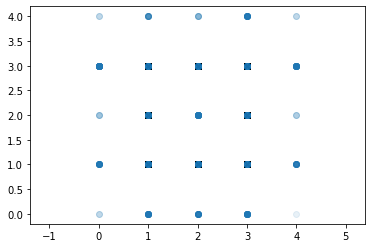

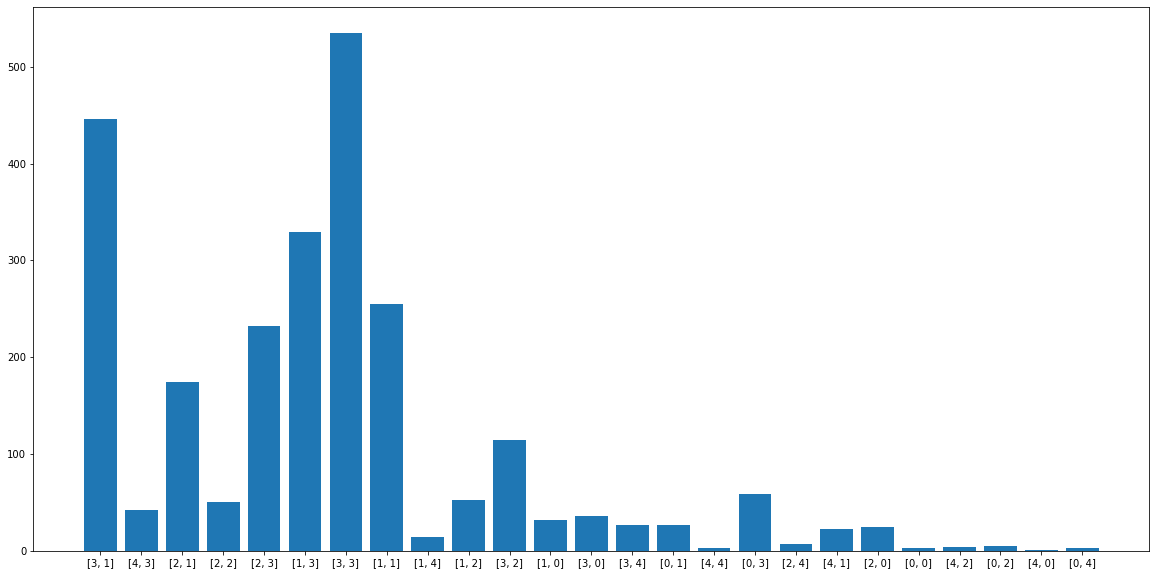

Processing Epoch 150
training start
Iteration 0, d real/fake loss 0.6611599326133728/0.7330347299575806 and g loss is 0.6747819781303406, NDiv loss 0.07621189951896667
Iteration 1, d real/fake loss 0.6612802743911743/0.7337198257446289 and g loss is 0.7034114599227905, NDiv loss 0.0843426063656807
Iteration 2, d real/fake loss 0.6614047288894653/0.7373656034469604 and g loss is 0.6752033233642578, NDiv loss 0.08448024094104767
Iteration 3, d real/fake loss 0.6615431904792786/0.7357563972473145 and g loss is 0.6686103343963623, NDiv loss 0.077703557908535
Iteration 4, d real/fake loss 0.6616870760917664/0.7282824516296387 and g loss is 0.6896762847900391, NDiv loss 0.07906469702720642


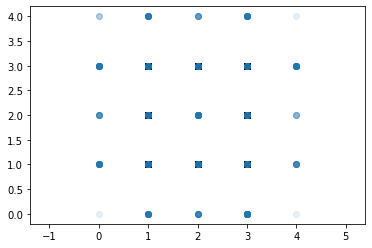

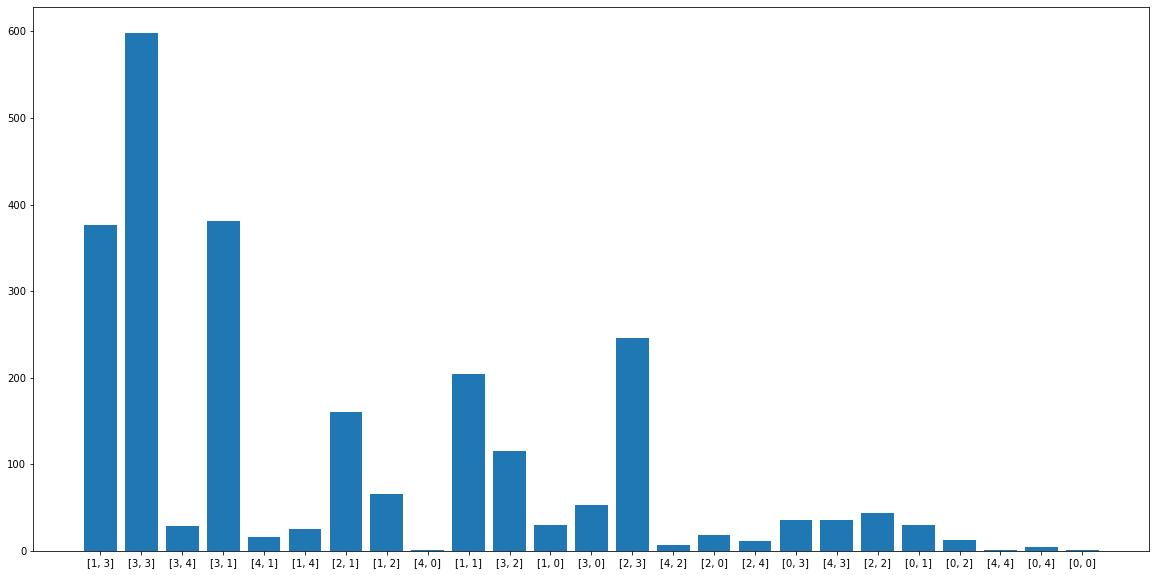

Processing Epoch 151
training start
Iteration 0, d real/fake loss 0.6706103086471558/0.7282378673553467 and g loss is 0.6830530762672424, NDiv loss 0.0832173302769661
Iteration 1, d real/fake loss 0.6707181930541992/0.7162315845489502 and g loss is 0.6637130379676819, NDiv loss 0.09112947434186935
Iteration 2, d real/fake loss 0.6708047389984131/0.7294049263000488 and g loss is 0.6964271664619446, NDiv loss 0.07503300160169601
Iteration 3, d real/fake loss 0.6708795428276062/0.7128334641456604 and g loss is 0.6837120056152344, NDiv loss 0.09089016169309616
Iteration 4, d real/fake loss 0.6709364056587219/0.7254174947738647 and g loss is 0.6597563028335571, NDiv loss 0.10031042993068695


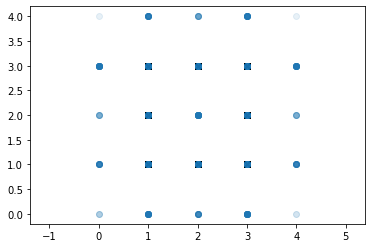

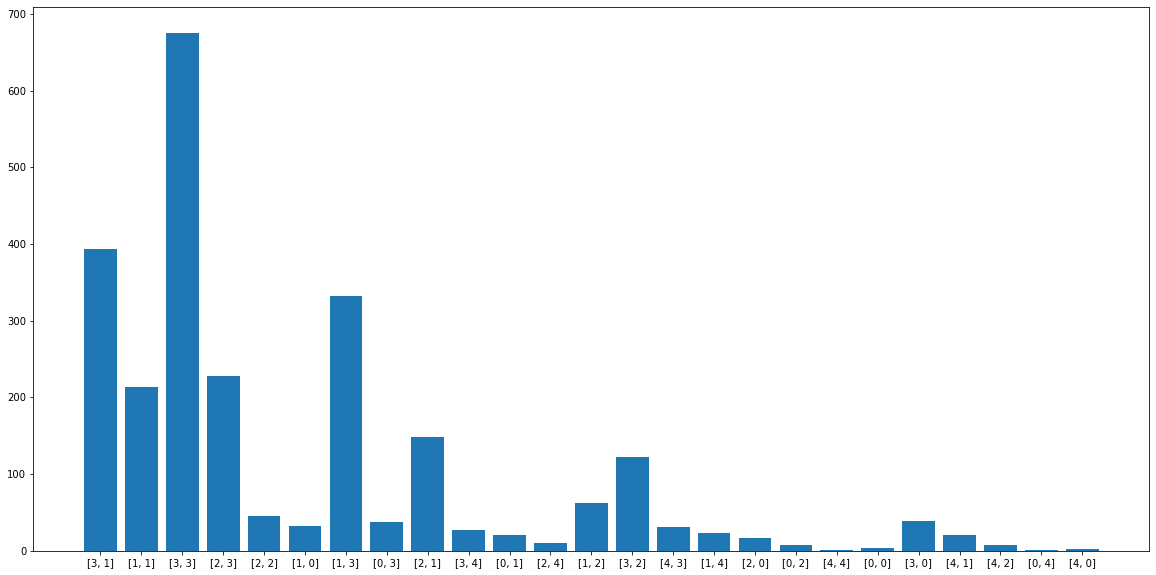

Processing Epoch 152
training start
Iteration 0, d real/fake loss 0.6655385494232178/0.7220948934555054 and g loss is 0.6784060001373291, NDiv loss 0.07882342487573624
Iteration 1, d real/fake loss 0.6656469702720642/0.7275176644325256 and g loss is 0.6738318204879761, NDiv loss 0.08282913267612457
Iteration 2, d real/fake loss 0.6657547950744629/0.7373267412185669 and g loss is 0.6649934649467468, NDiv loss 0.08636671304702759
Iteration 3, d real/fake loss 0.6658679246902466/0.7370895147323608 and g loss is 0.6843961477279663, NDiv loss 0.08858748525381088
Iteration 4, d real/fake loss 0.6659889221191406/0.7430615425109863 and g loss is 0.6637738943099976, NDiv loss 0.10137274861335754


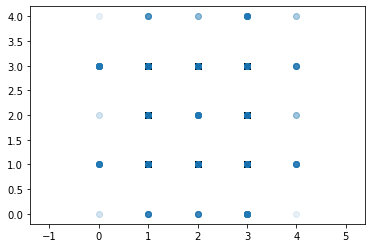

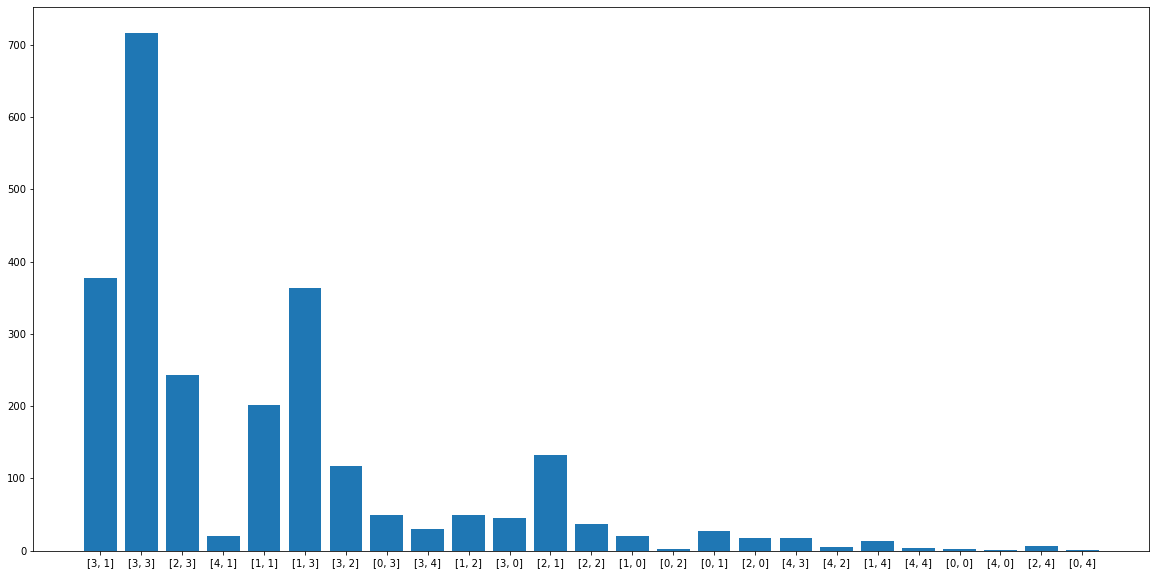

Processing Epoch 153
training start
Iteration 0, d real/fake loss 0.6606013774871826/0.749608039855957 and g loss is 0.6683686971664429, NDiv loss 0.09293090552091599
Iteration 1, d real/fake loss 0.6608268618583679/0.7488632202148438 and g loss is 0.6618955135345459, NDiv loss 0.07627879083156586
Iteration 2, d real/fake loss 0.6610604524612427/0.7398412227630615 and g loss is 0.6809999942779541, NDiv loss 0.11325940489768982
Iteration 3, d real/fake loss 0.6612966060638428/0.7326576709747314 and g loss is 0.6788730621337891, NDiv loss 0.09210526198148727
Iteration 4, d real/fake loss 0.6615375280380249/0.742128849029541 and g loss is 0.6627393960952759, NDiv loss 0.09252532571554184


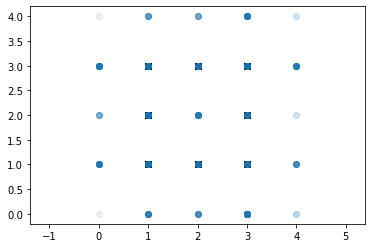

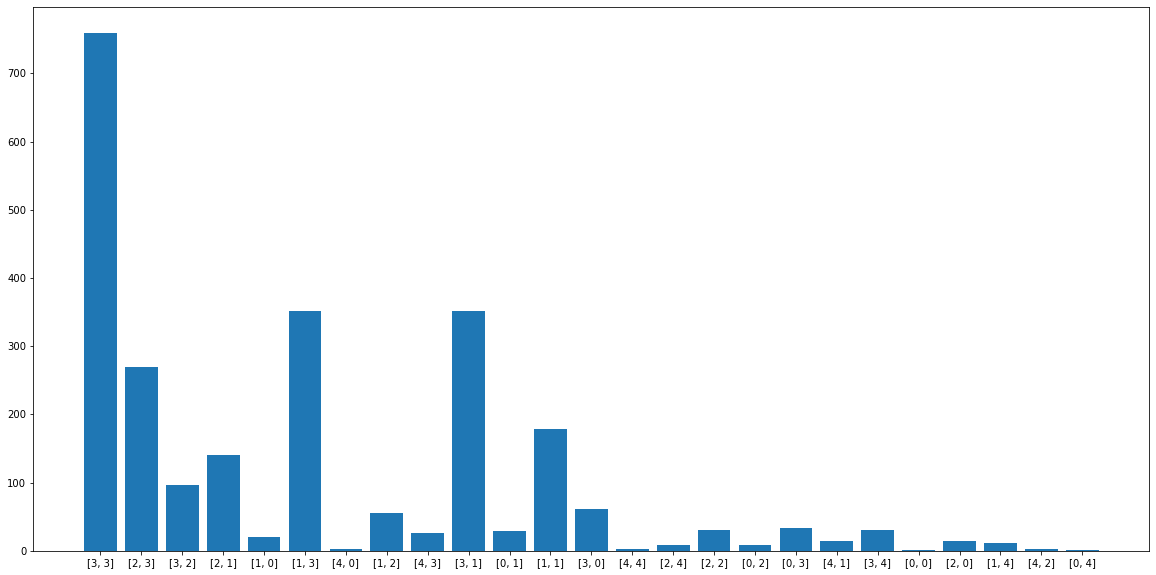

Processing Epoch 154
training start
Iteration 0, d real/fake loss 0.6736299991607666/0.7313148975372314 and g loss is 0.647367000579834, NDiv loss 0.09592221677303314
Iteration 1, d real/fake loss 0.6738012433052063/0.7308707237243652 and g loss is 0.6679990291595459, NDiv loss 0.08541478961706161
Iteration 2, d real/fake loss 0.673954963684082/0.7245880961418152 and g loss is 0.658373236656189, NDiv loss 0.09838646650314331
Iteration 3, d real/fake loss 0.6740964651107788/0.7345484495162964 and g loss is 0.6660900115966797, NDiv loss 0.09296529740095139
Iteration 4, d real/fake loss 0.6742358207702637/0.7348591089248657 and g loss is 0.705588161945343, NDiv loss 0.0831959918141365


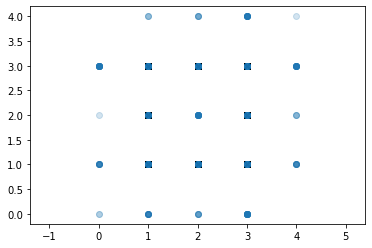

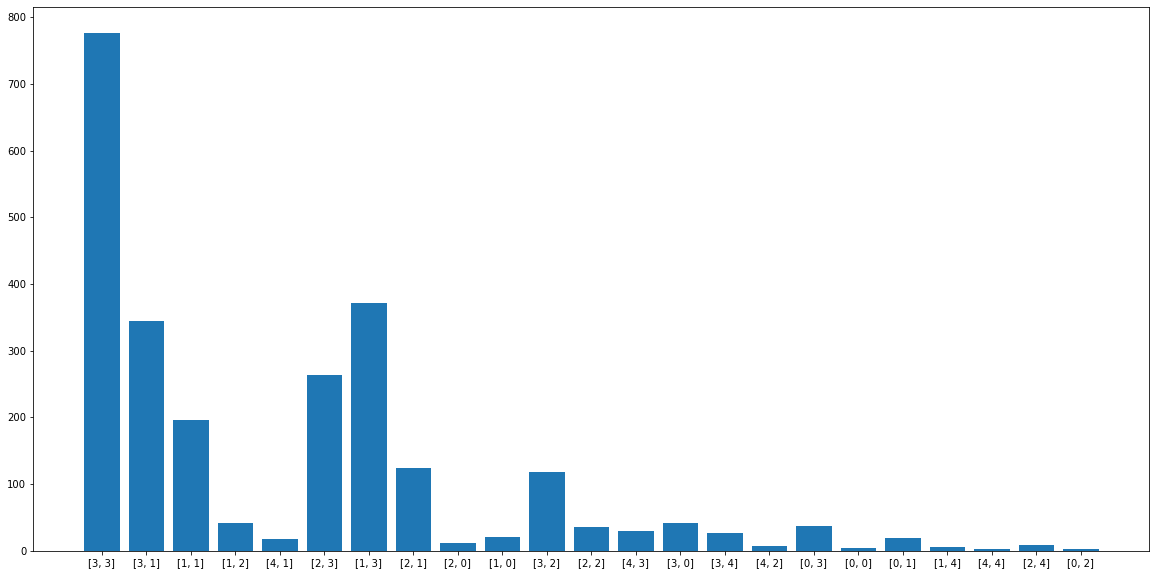

Processing Epoch 155
training start
Iteration 0, d real/fake loss 0.6681991815567017/0.7193582057952881 and g loss is 0.6686919927597046, NDiv loss 0.11715736240148544
Iteration 1, d real/fake loss 0.6683758497238159/0.7365312576293945 and g loss is 0.688170313835144, NDiv loss 0.0927453488111496
Iteration 2, d real/fake loss 0.6685612201690674/0.7354009747505188 and g loss is 0.6678167581558228, NDiv loss 0.10801056772470474
Iteration 3, d real/fake loss 0.6687493324279785/0.7405136823654175 and g loss is 0.6668853759765625, NDiv loss 0.09025251120328903
Iteration 4, d real/fake loss 0.6689400672912598/0.7211689352989197 and g loss is 0.6571626663208008, NDiv loss 0.11583707481622696


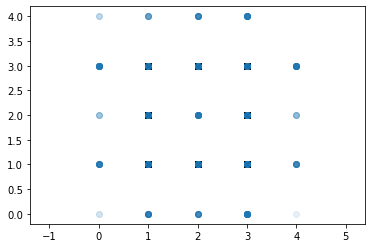

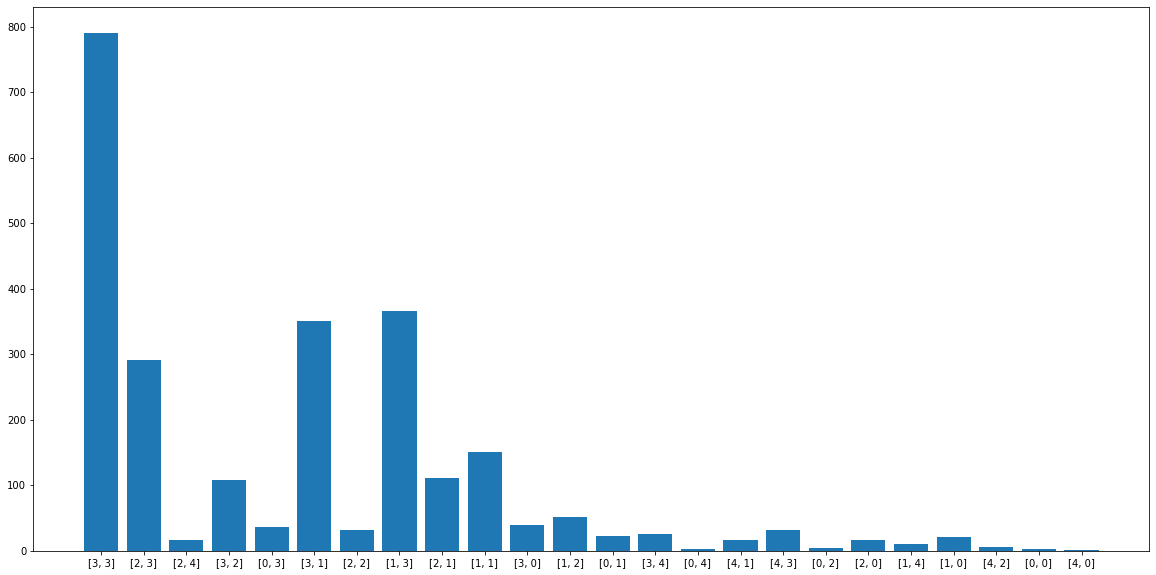

Processing Epoch 156
training start
Iteration 0, d real/fake loss 0.6733040809631348/0.7157102823257446 and g loss is 0.6682633757591248, NDiv loss 0.08909068256616592
Iteration 1, d real/fake loss 0.673500657081604/0.742015540599823 and g loss is 0.6500791311264038, NDiv loss 0.09043090045452118
Iteration 2, d real/fake loss 0.673696756362915/0.7335072755813599 and g loss is 0.6858893632888794, NDiv loss 0.09118982404470444
Iteration 3, d real/fake loss 0.6738876104354858/0.7328166961669922 and g loss is 0.6709356904029846, NDiv loss 0.09266743063926697
Iteration 4, d real/fake loss 0.6740745902061462/0.7404900789260864 and g loss is 0.6723319292068481, NDiv loss 0.12035304307937622


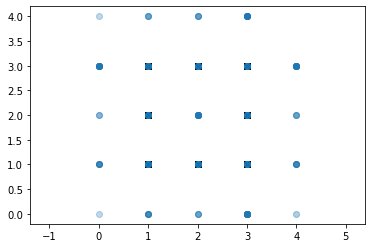

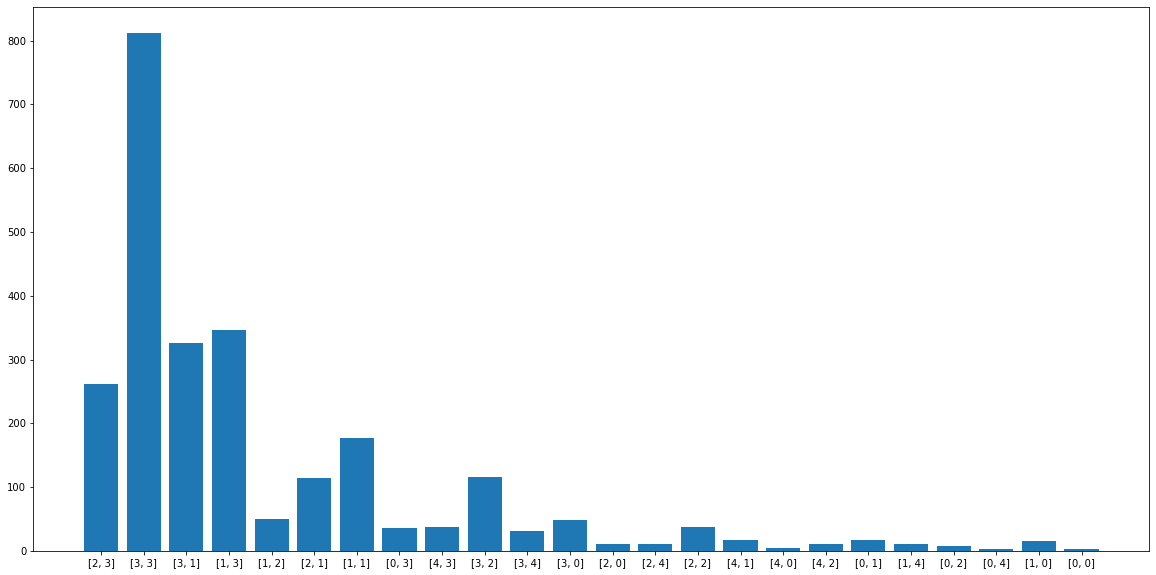

Processing Epoch 157
training start
Iteration 0, d real/fake loss 0.6619855165481567/0.7266780138015747 and g loss is 0.668232262134552, NDiv loss 0.10514000803232193
Iteration 1, d real/fake loss 0.6622323989868164/0.7355878353118896 and g loss is 0.6664705276489258, NDiv loss 0.10403721034526825
Iteration 2, d real/fake loss 0.6624910831451416/0.7166001796722412 and g loss is 0.6511850953102112, NDiv loss 0.10679206252098083
Iteration 3, d real/fake loss 0.6627368927001953/0.7289049029350281 and g loss is 0.6737851500511169, NDiv loss 0.10501690208911896
Iteration 4, d real/fake loss 0.6629814505577087/0.7255343198776245 and g loss is 0.6823807954788208, NDiv loss 0.10700944066047668


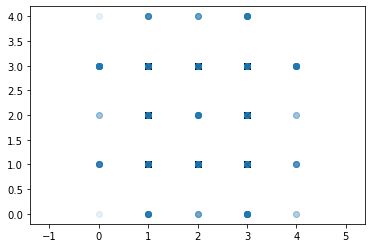

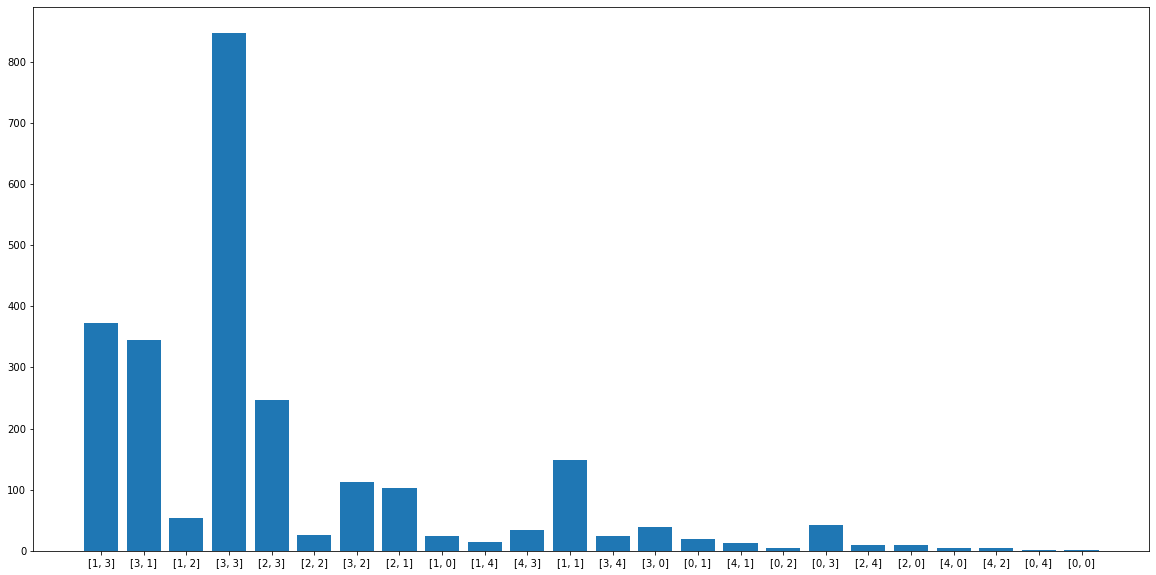

Processing Epoch 158
training start
Iteration 0, d real/fake loss 0.6861869692802429/0.7326408624649048 and g loss is 0.667057991027832, NDiv loss 0.10084421187639236
Iteration 1, d real/fake loss 0.6862357258796692/0.729979932308197 and g loss is 0.664580225944519, NDiv loss 0.0788102075457573
Iteration 2, d real/fake loss 0.6862685680389404/0.7254263162612915 and g loss is 0.6916168332099915, NDiv loss 0.0859241783618927
Iteration 3, d real/fake loss 0.6862850785255432/0.7199133634567261 and g loss is 0.6685452461242676, NDiv loss 0.1229495257139206
Iteration 4, d real/fake loss 0.6862776279449463/0.7144509553909302 and g loss is 0.6731916069984436, NDiv loss 0.12379544973373413


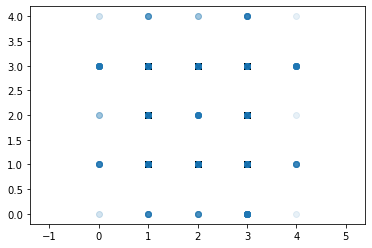

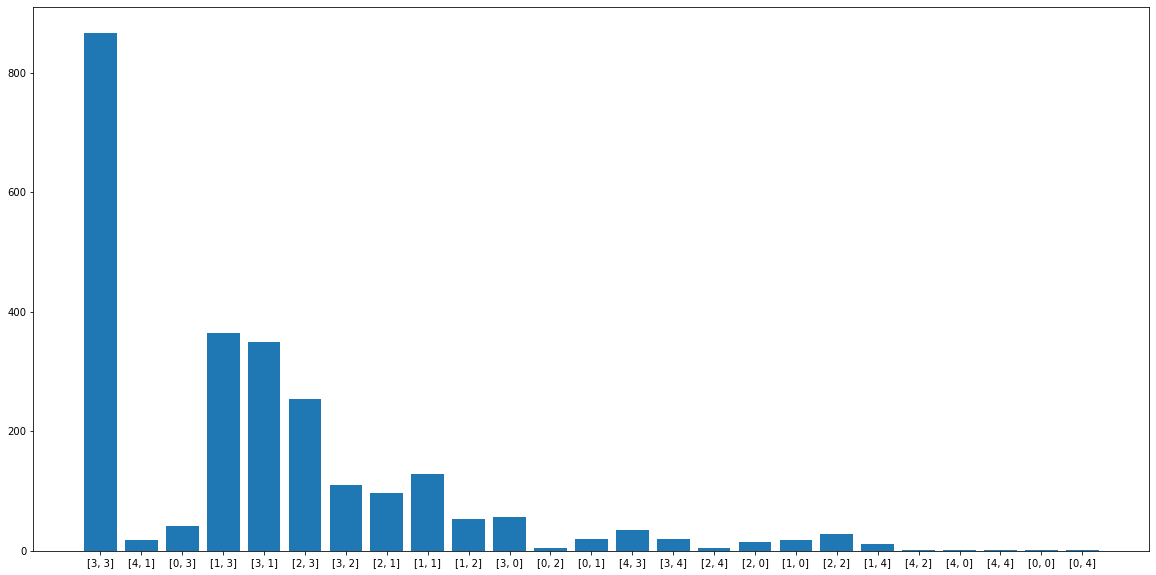

Processing Epoch 159
training start
Iteration 0, d real/fake loss 0.6759993433952332/0.733077883720398 and g loss is 0.6700706481933594, NDiv loss 0.1017056554555893
Iteration 1, d real/fake loss 0.6760082840919495/0.7313758730888367 and g loss is 0.6866463422775269, NDiv loss 0.10560344904661179
Iteration 2, d real/fake loss 0.676016628742218/0.7218188047409058 and g loss is 0.6791538000106812, NDiv loss 0.10482844710350037
Iteration 3, d real/fake loss 0.6760132312774658/0.7264184951782227 and g loss is 0.6654924750328064, NDiv loss 0.12330502271652222
Iteration 4, d real/fake loss 0.6760023832321167/0.723609983921051 and g loss is 0.6704891920089722, NDiv loss 0.09286454319953918


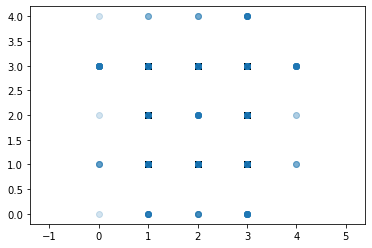

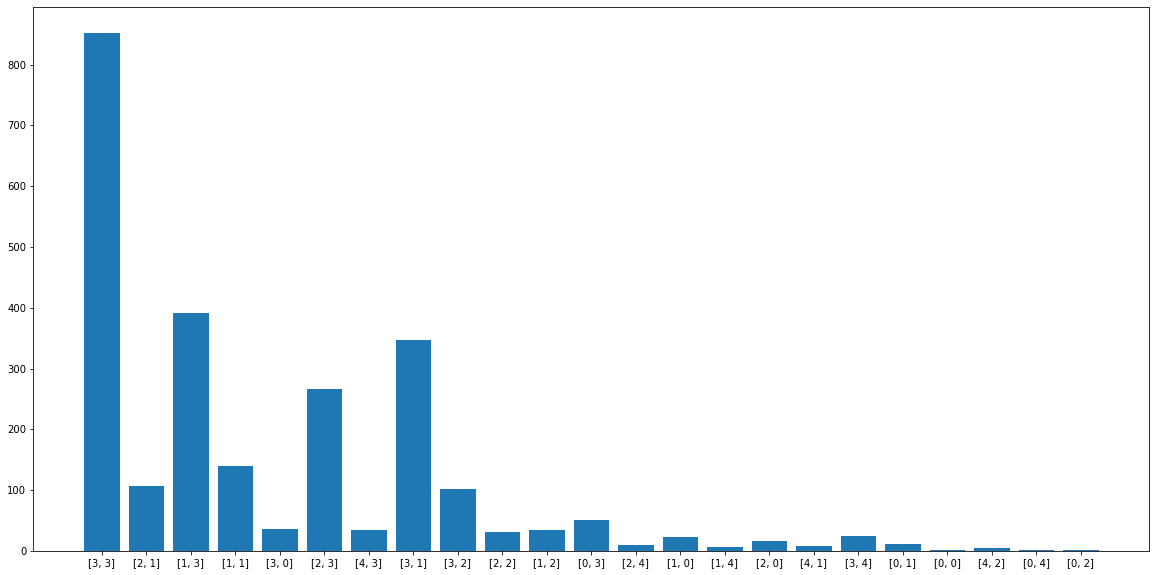

Processing Epoch 160
training start
Iteration 0, d real/fake loss 0.6752186417579651/0.7194461822509766 and g loss is 0.6948665976524353, NDiv loss 0.1253022998571396
Iteration 1, d real/fake loss 0.6752272844314575/0.7027021646499634 and g loss is 0.6924985647201538, NDiv loss 0.10833562165498734
Iteration 2, d real/fake loss 0.6752099990844727/0.7167514562606812 and g loss is 0.6874964237213135, NDiv loss 0.10695523023605347
Iteration 3, d real/fake loss 0.6751840114593506/0.7103578448295593 and g loss is 0.6739823222160339, NDiv loss 0.1212482824921608
Iteration 4, d real/fake loss 0.6751422882080078/0.7092231512069702 and g loss is 0.6859955191612244, NDiv loss 0.1296924203634262


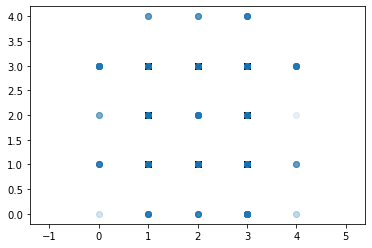

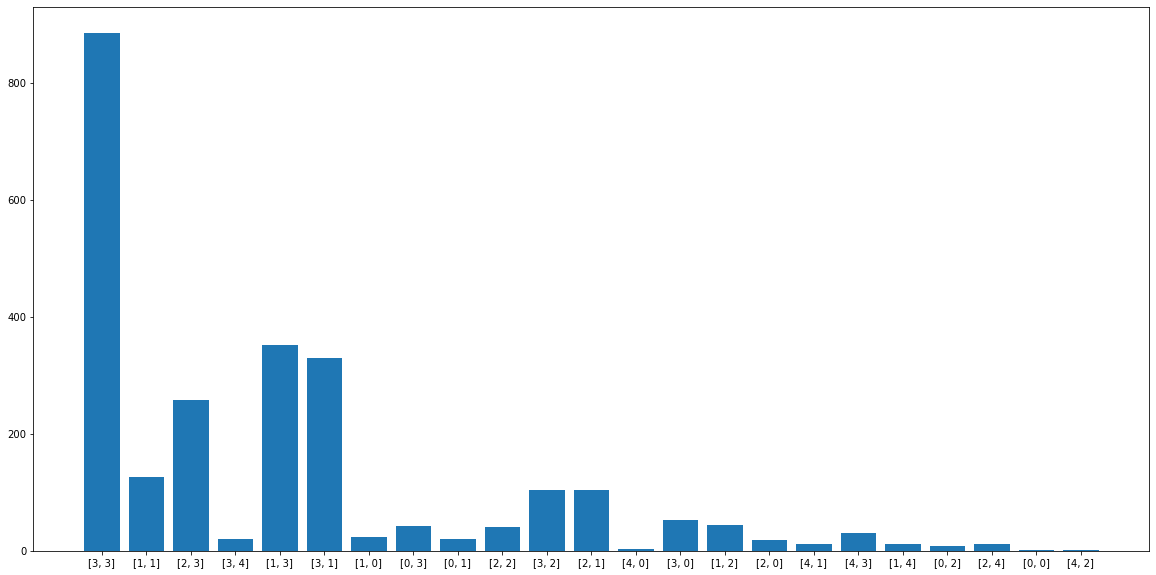

Processing Epoch 161
training start
Iteration 0, d real/fake loss 0.6674670577049255/0.7197686433792114 and g loss is 0.6847953200340271, NDiv loss 0.1064729169011116
Iteration 1, d real/fake loss 0.6677138209342957/0.7050695419311523 and g loss is 0.681429386138916, NDiv loss 0.15185324847698212
Iteration 2, d real/fake loss 0.6679513454437256/0.6987664103507996 and g loss is 0.6729456186294556, NDiv loss 0.11728718131780624
Iteration 3, d real/fake loss 0.6681737899780273/0.6991686224937439 and g loss is 0.6764722466468811, NDiv loss 0.10140113532543182
Iteration 4, d real/fake loss 0.6683812141418457/0.7049904465675354 and g loss is 0.6897146701812744, NDiv loss 0.1250019669532776


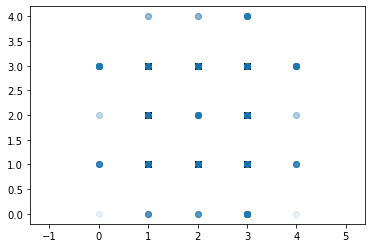

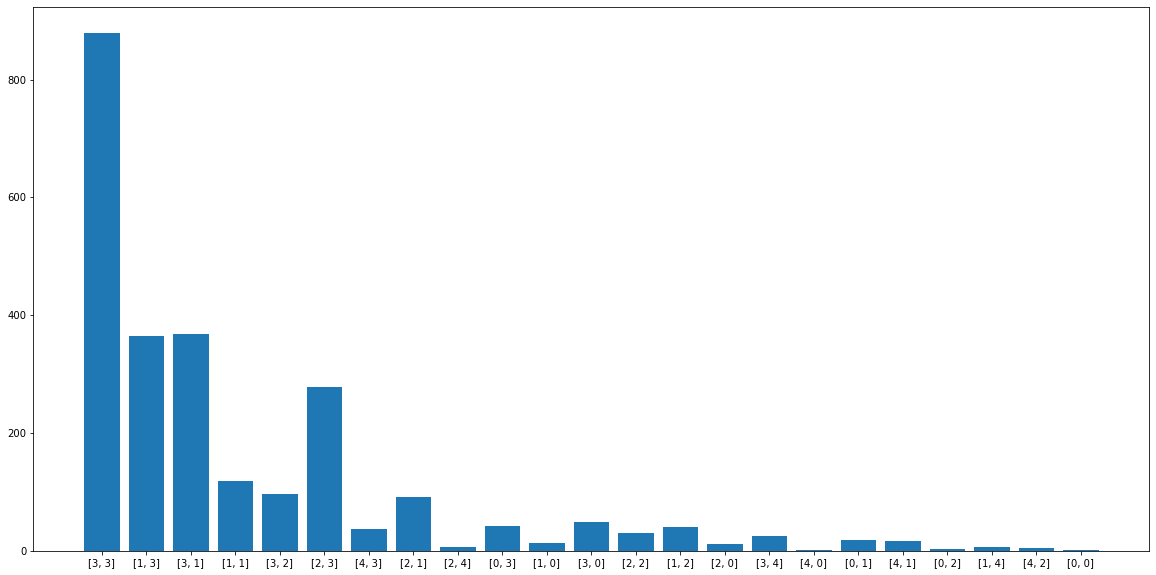

Processing Epoch 162
training start
Iteration 0, d real/fake loss 0.6776965260505676/0.7135699987411499 and g loss is 0.6962903738021851, NDiv loss 0.12729138135910034
Iteration 1, d real/fake loss 0.6777641773223877/0.7100861072540283 and g loss is 0.6982936859130859, NDiv loss 0.11879277974367142
Iteration 2, d real/fake loss 0.6778204441070557/0.7131907343864441 and g loss is 0.7034528255462646, NDiv loss 0.12307561933994293
Iteration 3, d real/fake loss 0.6778723001480103/0.7119573354721069 and g loss is 0.664374828338623, NDiv loss 0.09740784019231796
Iteration 4, d real/fake loss 0.6779209971427917/0.7152771949768066 and g loss is 0.6816610097885132, NDiv loss 0.11151599138975143


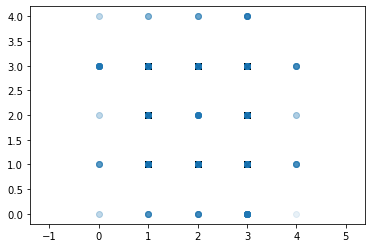

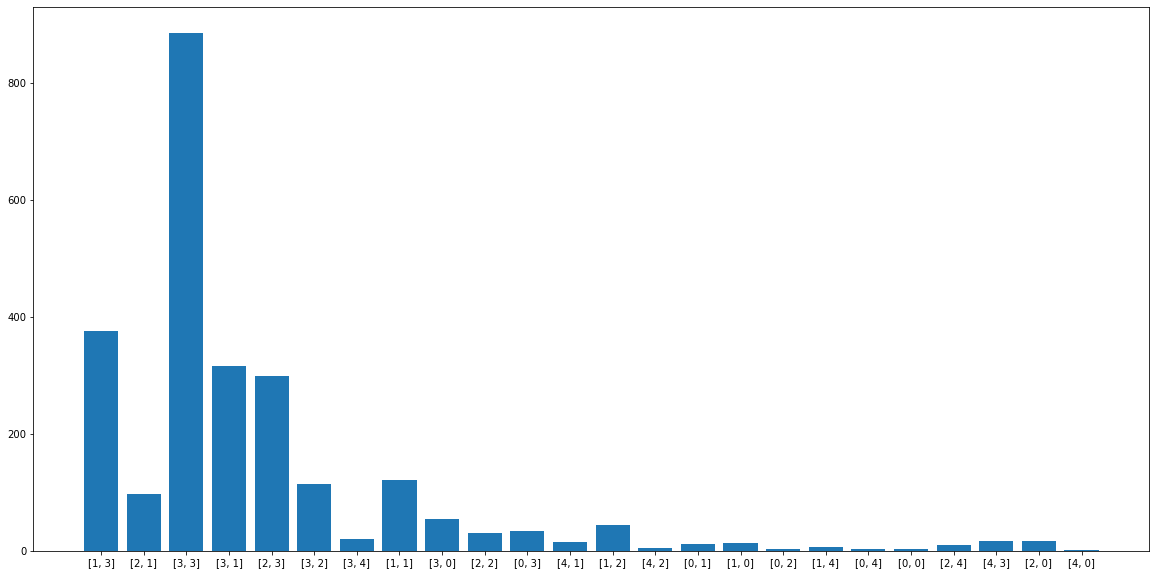

Processing Epoch 163
training start
Iteration 0, d real/fake loss 0.6668937802314758/0.7068965435028076 and g loss is 0.6724106073379517, NDiv loss 0.11096321046352386
Iteration 1, d real/fake loss 0.6669497489929199/0.7012195587158203 and g loss is 0.6778391599655151, NDiv loss 0.10100866109132767
Iteration 2, d real/fake loss 0.6670032739639282/0.708745002746582 and g loss is 0.6760847568511963, NDiv loss 0.11444735527038574
Iteration 3, d real/fake loss 0.6670602560043335/0.7125275135040283 and g loss is 0.686324954032898, NDiv loss 0.11543629318475723
Iteration 4, d real/fake loss 0.6671234369277954/0.7097296714782715 and g loss is 0.6889181733131409, NDiv loss 0.1134963110089302


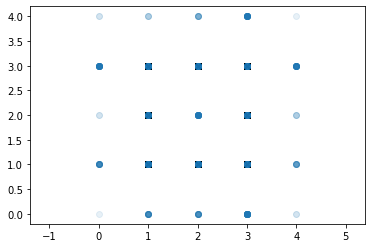

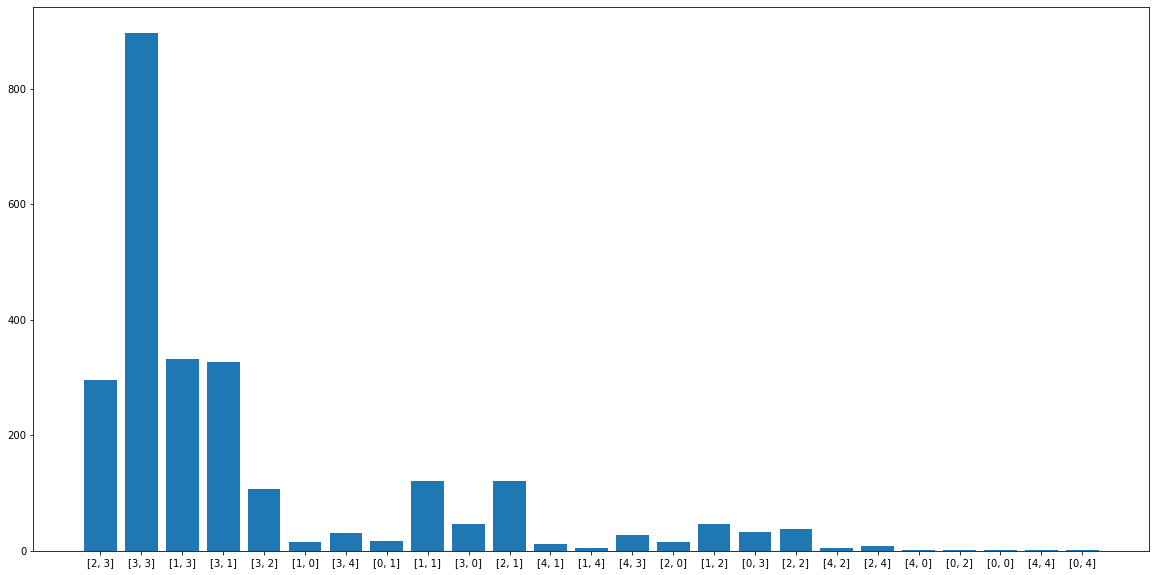

Processing Epoch 164
training start
Iteration 0, d real/fake loss 0.6855957508087158/0.7002843022346497 and g loss is 0.6887437701225281, NDiv loss 0.11986607313156128
Iteration 1, d real/fake loss 0.6855720281600952/0.6916458606719971 and g loss is 0.7003819942474365, NDiv loss 0.12146002054214478
Iteration 2, d real/fake loss 0.685525119304657/0.703617513179779 and g loss is 0.691440761089325, NDiv loss 0.10933518409729004
Iteration 3, d real/fake loss 0.6854645013809204/0.7122248411178589 and g loss is 0.6858301162719727, NDiv loss 0.14005817472934723
Iteration 4, d real/fake loss 0.6853988766670227/0.7014175653457642 and g loss is 0.6847364902496338, NDiv loss 0.12045516818761826


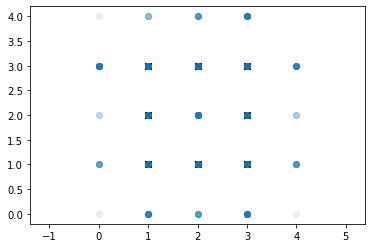

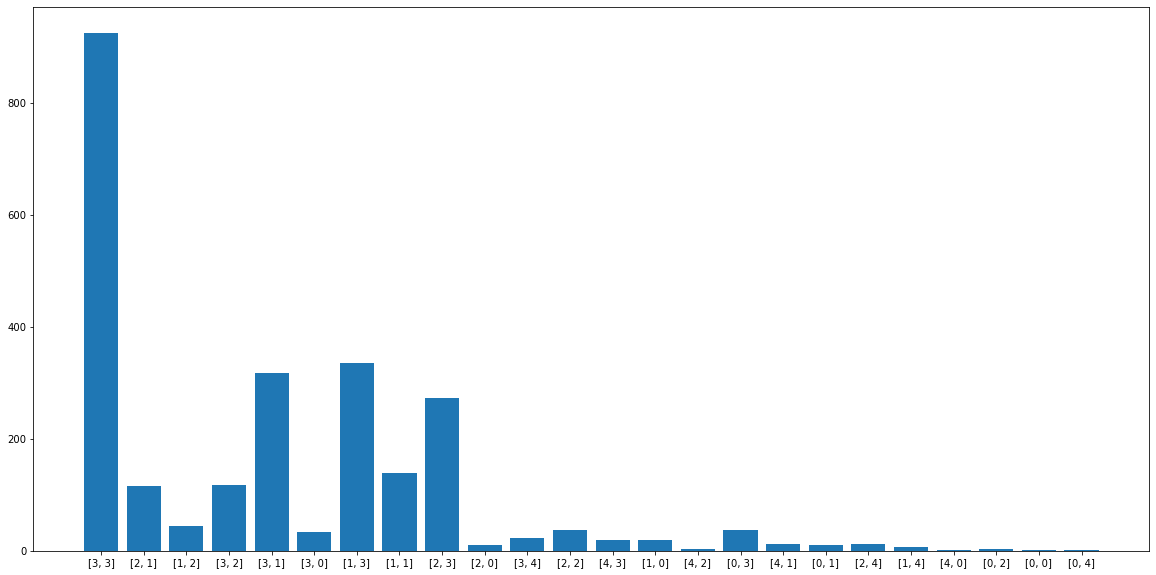

Processing Epoch 165
training start
Iteration 0, d real/fake loss 0.6746341586112976/0.7085109949111938 and g loss is 0.6963279843330383, NDiv loss 0.09097636491060257
Iteration 1, d real/fake loss 0.674579381942749/0.6924309730529785 and g loss is 0.7004179954528809, NDiv loss 0.10433335602283478
Iteration 2, d real/fake loss 0.6745089292526245/0.6977928876876831 and g loss is 0.689227819442749, NDiv loss 0.13523954153060913
Iteration 3, d real/fake loss 0.6744343042373657/0.7102459669113159 and g loss is 0.7024609446525574, NDiv loss 0.1351517140865326
Iteration 4, d real/fake loss 0.6743600964546204/0.6990761756896973 and g loss is 0.7015712261199951, NDiv loss 0.1281583309173584


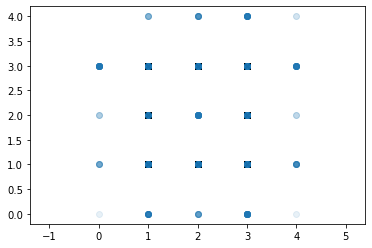

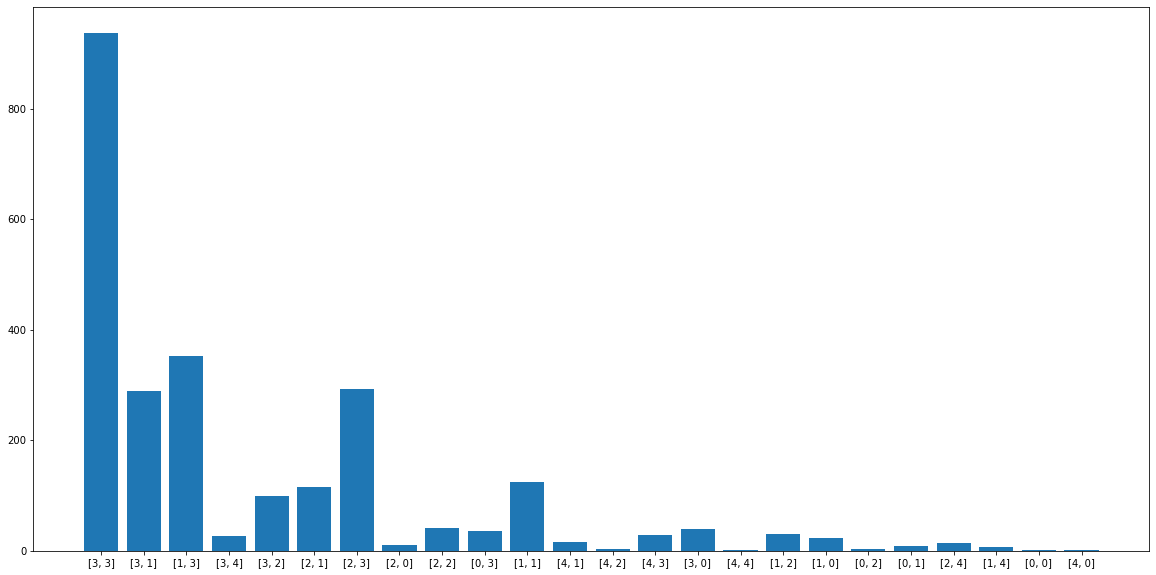

Processing Epoch 166
training start
Iteration 0, d real/fake loss 0.6648474931716919/0.7064958810806274 and g loss is 0.6925972700119019, NDiv loss 0.11377694457769394
Iteration 1, d real/fake loss 0.6648321151733398/0.6841974258422852 and g loss is 0.6839357018470764, NDiv loss 0.13994622230529785
Iteration 2, d real/fake loss 0.6648037433624268/0.7014737725257874 and g loss is 0.6903576850891113, NDiv loss 0.11578506976366043
Iteration 3, d real/fake loss 0.6647825241088867/0.7117822170257568 and g loss is 0.6931800842285156, NDiv loss 0.1052921861410141
Iteration 4, d real/fake loss 0.6647782325744629/0.7000794410705566 and g loss is 0.7048028707504272, NDiv loss 0.12983247637748718


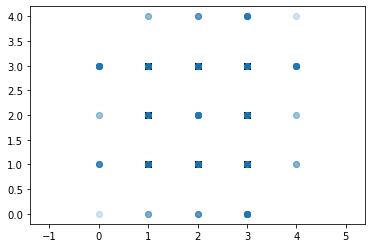

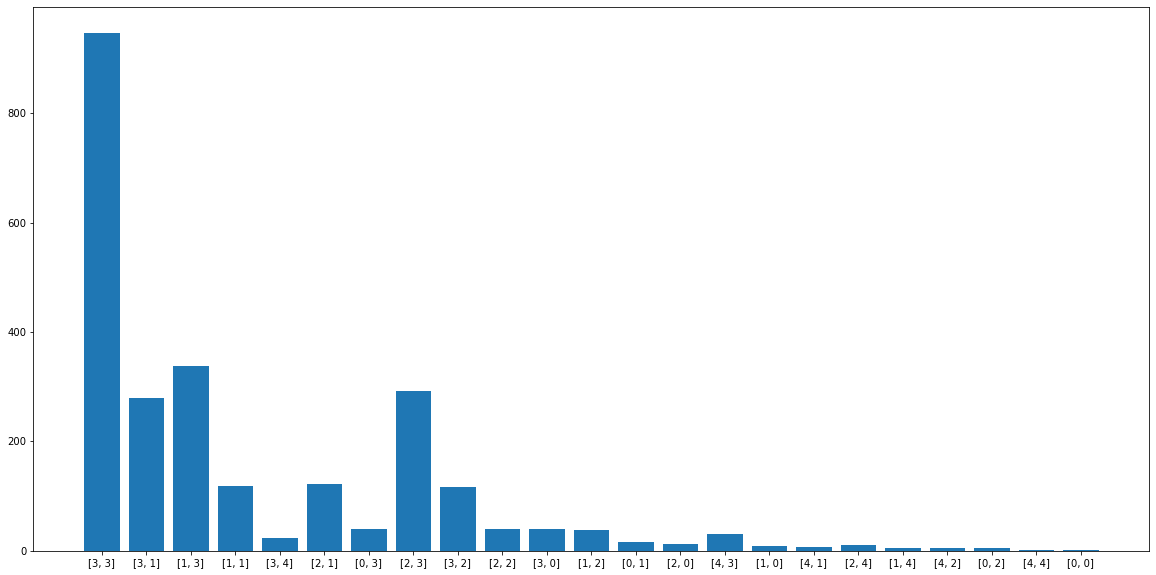

Processing Epoch 167
training start
Iteration 0, d real/fake loss 0.6710675954818726/0.6936664581298828 and g loss is 0.7024297714233398, NDiv loss 0.14949406683444977
Iteration 1, d real/fake loss 0.671123743057251/0.6980003118515015 and g loss is 0.6871768236160278, NDiv loss 0.18375447392463684
Iteration 2, d real/fake loss 0.6711732149124146/0.6926188468933105 and g loss is 0.6893805265426636, NDiv loss 0.1357182115316391
Iteration 3, d real/fake loss 0.671209990978241/0.6923405528068542 and g loss is 0.7001039981842041, NDiv loss 0.13536562025547028
Iteration 4, d real/fake loss 0.6712371110916138/0.694073498249054 and g loss is 0.6977821588516235, NDiv loss 0.14694665372371674


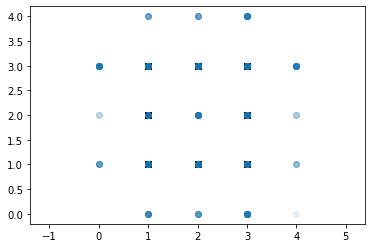

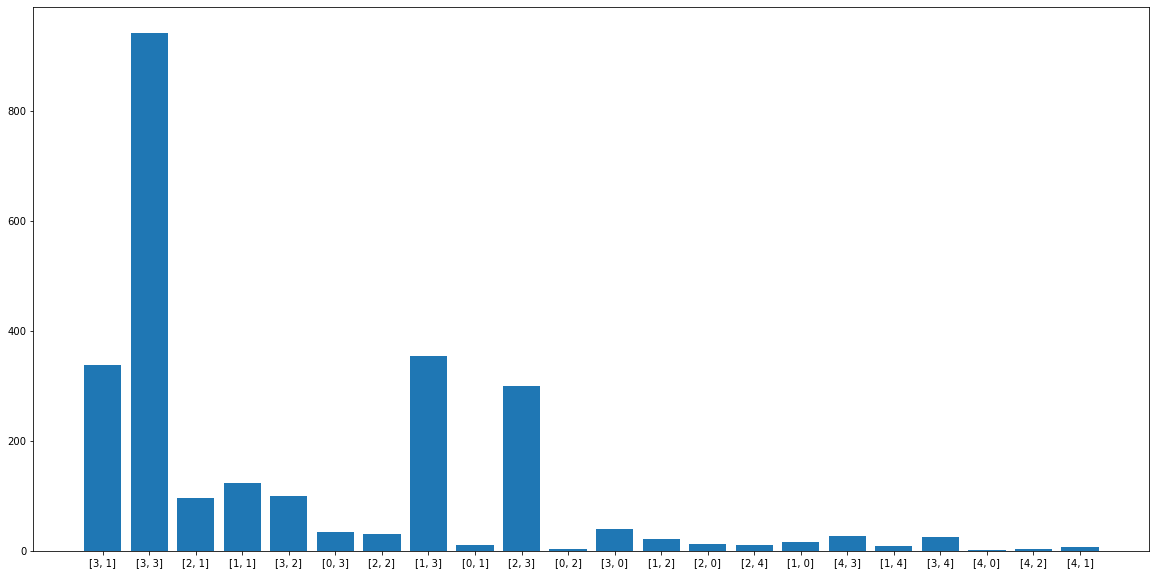

Processing Epoch 168
training start
Iteration 0, d real/fake loss 0.6769860982894897/0.6972849369049072 and g loss is 0.6919301152229309, NDiv loss 0.10331811010837555
Iteration 1, d real/fake loss 0.67691969871521/0.6922586560249329 and g loss is 0.7045590877532959, NDiv loss 0.099355049431324
Iteration 2, d real/fake loss 0.6768356561660767/0.7042704820632935 and g loss is 0.6995121836662292, NDiv loss 0.14076033234596252
Iteration 3, d real/fake loss 0.6767443418502808/0.6878169775009155 and g loss is 0.6951392889022827, NDiv loss 0.1322377324104309
Iteration 4, d real/fake loss 0.6766366958618164/0.6965315937995911 and g loss is 0.7079386711120605, NDiv loss 0.11618660390377045


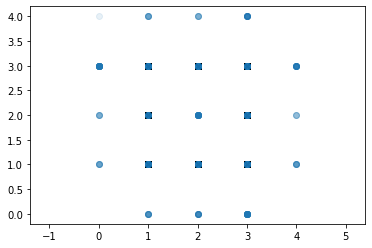

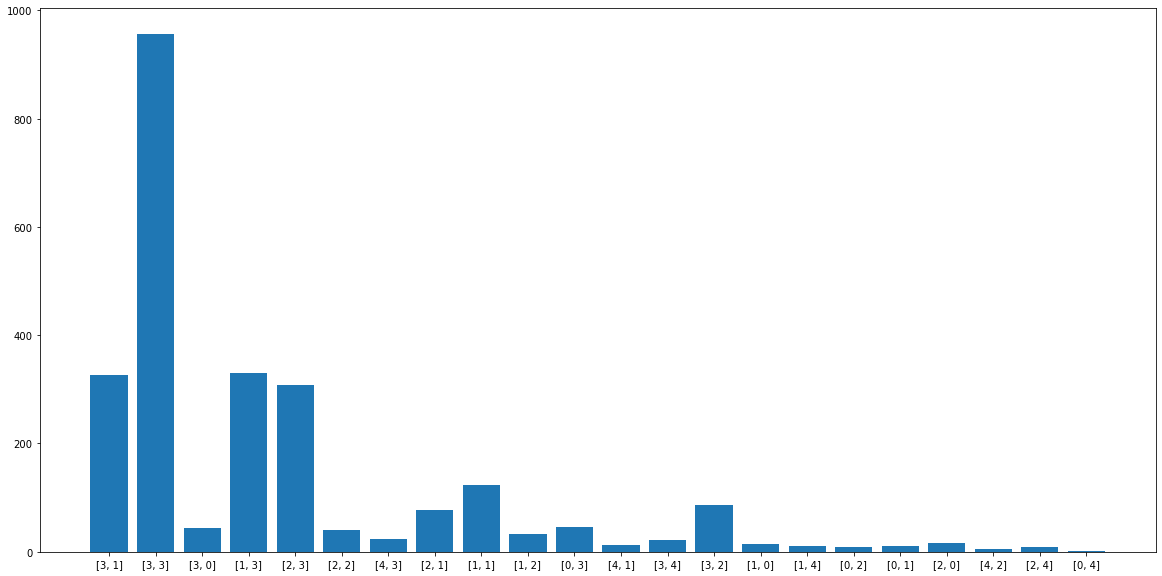

Processing Epoch 169
training start
Iteration 0, d real/fake loss 0.6734781265258789/0.6954512596130371 and g loss is 0.6848230361938477, NDiv loss 0.12201331555843353
Iteration 1, d real/fake loss 0.6733654737472534/0.6945493817329407 and g loss is 0.706774890422821, NDiv loss 0.146802619099617
Iteration 2, d real/fake loss 0.6732443571090698/0.6773489713668823 and g loss is 0.70220547914505, NDiv loss 0.1294560730457306
Iteration 3, d real/fake loss 0.673095703125/0.700526773929596 and g loss is 0.6946272253990173, NDiv loss 0.12607432901859283
Iteration 4, d real/fake loss 0.6729550361633301/0.6981262564659119 and g loss is 0.7157629728317261, NDiv loss 0.11734488606452942


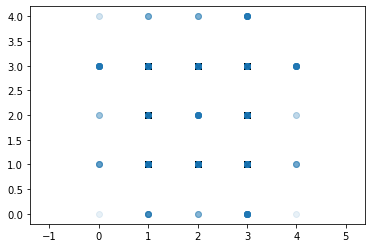

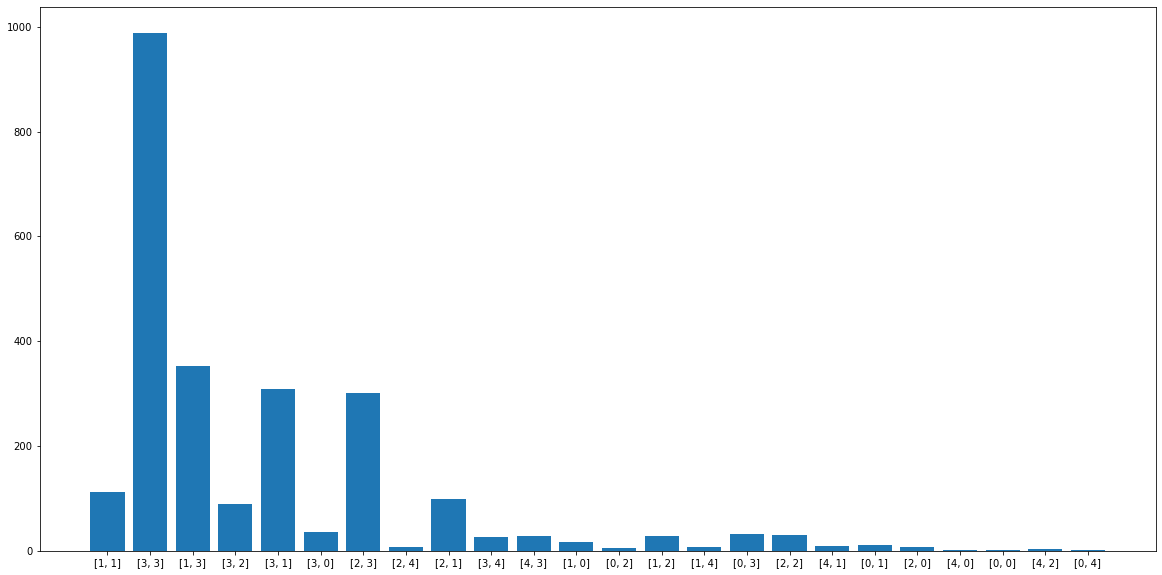

Processing Epoch 170
training start
Iteration 0, d real/fake loss 0.6696492433547974/0.6934307217597961 and g loss is 0.7094764113426208, NDiv loss 0.10483769327402115
Iteration 1, d real/fake loss 0.6694930791854858/0.6825008392333984 and g loss is 0.7014071941375732, NDiv loss 0.1657656580209732
Iteration 2, d real/fake loss 0.6693196892738342/0.6869676113128662 and g loss is 0.6924606561660767, NDiv loss 0.119620680809021
Iteration 3, d real/fake loss 0.6691334247589111/0.6942994594573975 and g loss is 0.7068468928337097, NDiv loss 0.14153710007667542
Iteration 4, d real/fake loss 0.6689496040344238/0.6920891404151917 and g loss is 0.7021334171295166, NDiv loss 0.13383114337921143


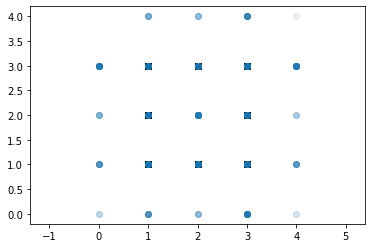

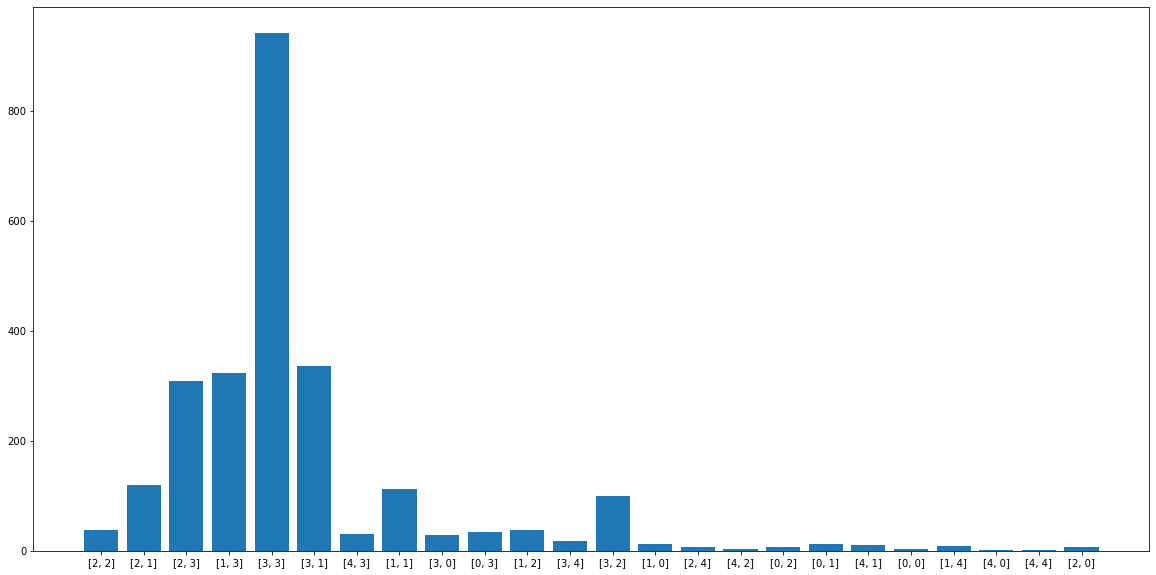

Processing Epoch 171
training start
Iteration 0, d real/fake loss 0.679718017578125/0.6788375973701477 and g loss is 0.7317311763763428, NDiv loss 0.11305161565542221
Iteration 1, d real/fake loss 0.6795467734336853/0.6856434345245361 and g loss is 0.6927545070648193, NDiv loss 0.12594681978225708
Iteration 2, d real/fake loss 0.6793689131736755/0.678512692451477 and g loss is 0.7065021395683289, NDiv loss 0.10999234020709991
Iteration 3, d real/fake loss 0.6791747212409973/0.7002833485603333 and g loss is 0.703262448310852, NDiv loss 0.134885773062706
Iteration 4, d real/fake loss 0.6789909601211548/0.6897696256637573 and g loss is 0.7266427278518677, NDiv loss 0.10447007417678833


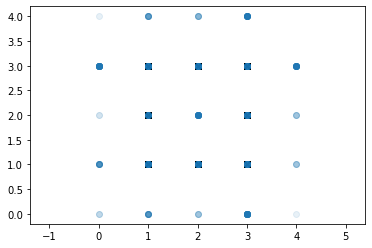

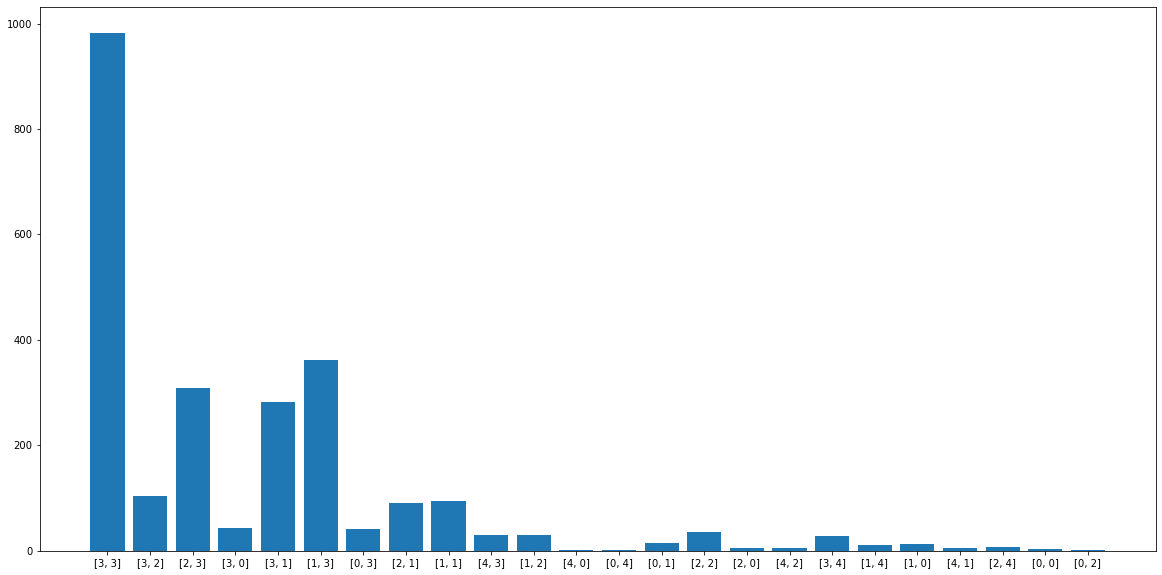

Processing Epoch 172
training start
Iteration 0, d real/fake loss 0.6764379739761353/0.6788917779922485 and g loss is 0.7058093547821045, NDiv loss 0.13370555639266968
Iteration 1, d real/fake loss 0.6764951944351196/0.6781917810440063 and g loss is 0.7094967365264893, NDiv loss 0.12778766453266144
Iteration 2, d real/fake loss 0.6765365600585938/0.6818023920059204 and g loss is 0.7150630950927734, NDiv loss 0.15216724574565887
Iteration 3, d real/fake loss 0.6765722036361694/0.6870222091674805 and g loss is 0.7205922603607178, NDiv loss 0.12901680171489716
Iteration 4, d real/fake loss 0.6766114234924316/0.679072916507721 and g loss is 0.6994335651397705, NDiv loss 0.14268797636032104


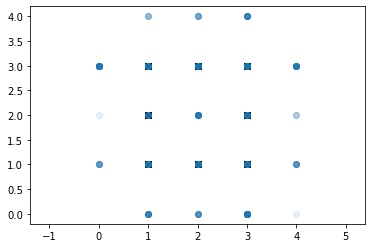

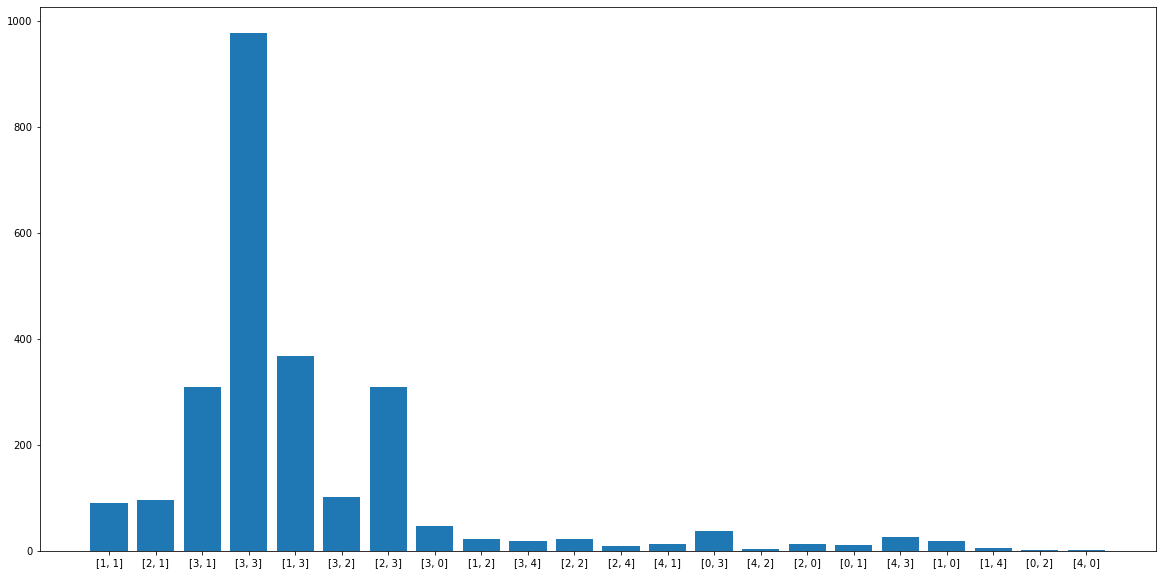

Processing Epoch 173
training start
Iteration 0, d real/fake loss 0.6672261953353882/0.6740632653236389 and g loss is 0.7205185294151306, NDiv loss 0.11379377543926239
Iteration 1, d real/fake loss 0.6671207547187805/0.6697314381599426 and g loss is 0.7132354378700256, NDiv loss 0.1455967128276825
Iteration 2, d real/fake loss 0.6670094132423401/0.6792353391647339 and g loss is 0.7158373594284058, NDiv loss 0.11991269141435623
Iteration 3, d real/fake loss 0.6668984889984131/0.6817546486854553 and g loss is 0.7078468799591064, NDiv loss 0.12574997544288635
Iteration 4, d real/fake loss 0.6667935848236084/0.6767091751098633 and g loss is 0.7141603827476501, NDiv loss 0.1174360066652298


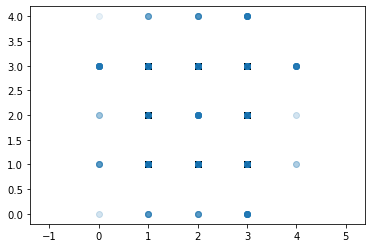

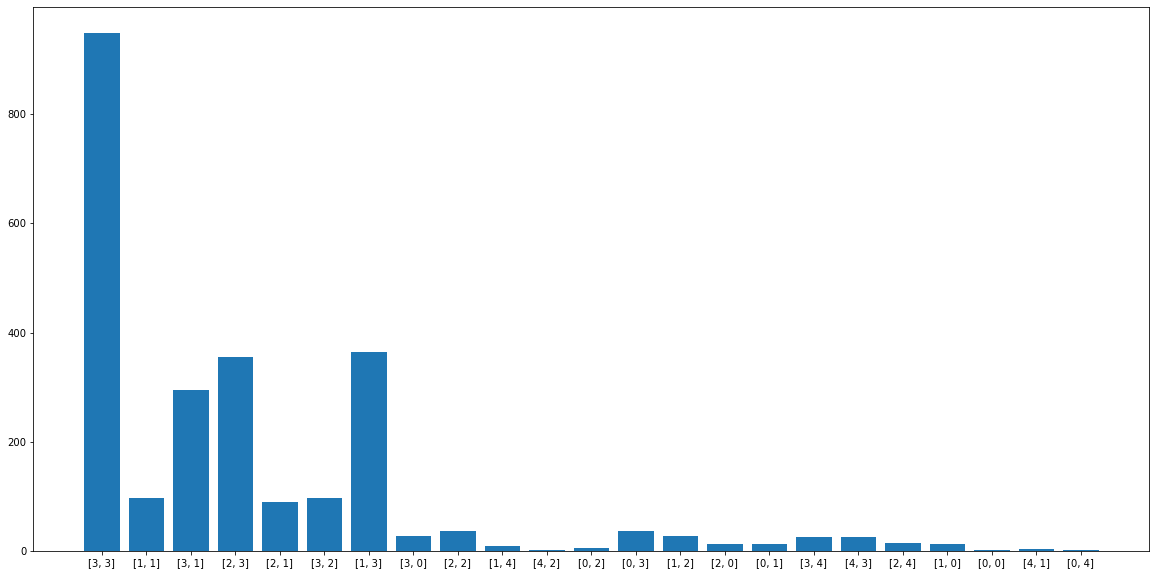

Processing Epoch 174
training start
Iteration 0, d real/fake loss 0.6693060994148254/0.6812487244606018 and g loss is 0.7144147157669067, NDiv loss 0.11745277792215347
Iteration 1, d real/fake loss 0.6692191958427429/0.6759271621704102 and g loss is 0.7036079168319702, NDiv loss 0.12435086816549301
Iteration 2, d real/fake loss 0.669124960899353/0.6654954552650452 and g loss is 0.7215304374694824, NDiv loss 0.1445012092590332
Iteration 3, d real/fake loss 0.6690105199813843/0.677130937576294 and g loss is 0.7214311361312866, NDiv loss 0.1306089162826538
Iteration 4, d real/fake loss 0.6688939929008484/0.6691960096359253 and g loss is 0.7290916442871094, NDiv loss 0.133249893784523


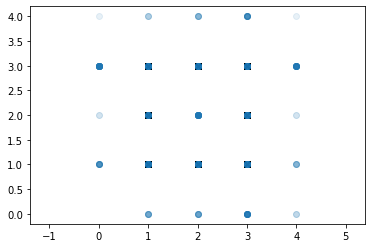

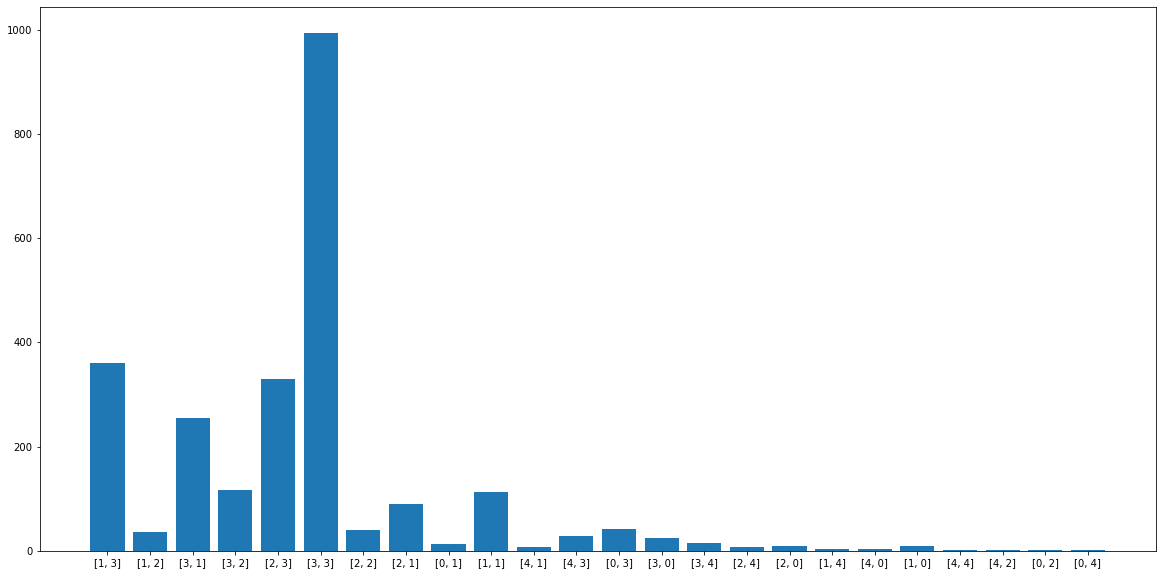

Processing Epoch 175
training start
Iteration 0, d real/fake loss 0.672539472579956/0.6892882585525513 and g loss is 0.7140884399414062, NDiv loss 0.11676882952451706
Iteration 1, d real/fake loss 0.6723998785018921/0.6749839782714844 and g loss is 0.7230958342552185, NDiv loss 0.15523870289325714
Iteration 2, d real/fake loss 0.6722544431686401/0.6729089617729187 and g loss is 0.7044382691383362, NDiv loss 0.13423576951026917
Iteration 3, d real/fake loss 0.6721060872077942/0.6717153191566467 and g loss is 0.7117034196853638, NDiv loss 0.17315246164798737
Iteration 4, d real/fake loss 0.6719480752944946/0.676447331905365 and g loss is 0.7061694860458374, NDiv loss 0.10924806445837021


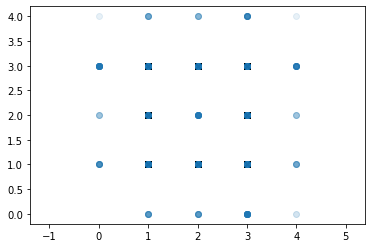

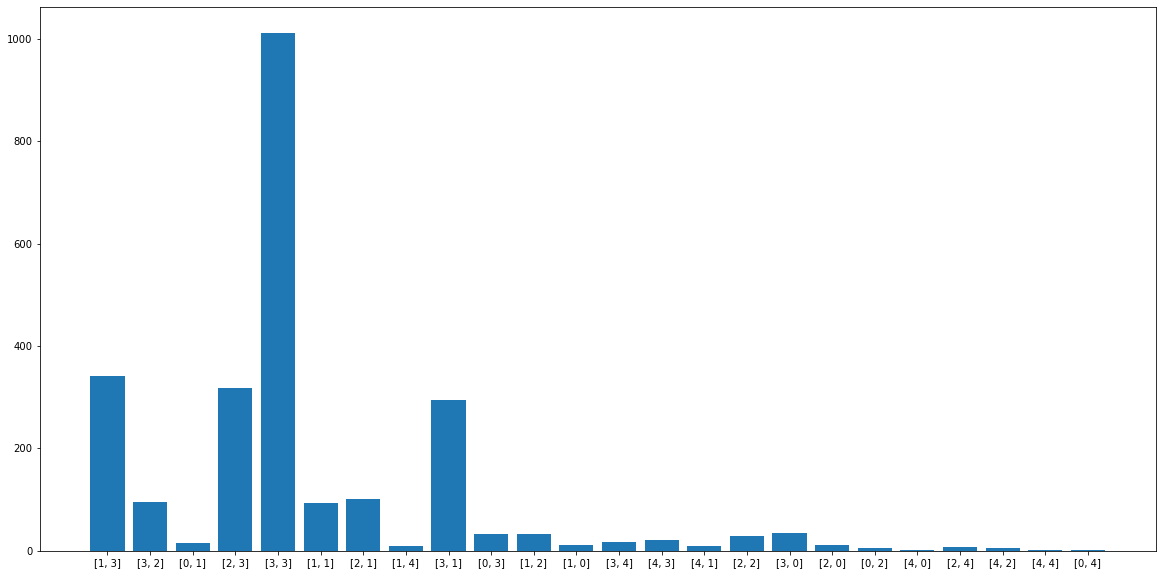

Processing Epoch 176
training start
Iteration 0, d real/fake loss 0.6603260040283203/0.6856437921524048 and g loss is 0.7125611305236816, NDiv loss 0.11302671581506729
Iteration 1, d real/fake loss 0.660221517086029/0.6714928150177002 and g loss is 0.7241194844245911, NDiv loss 0.15152767300605774
Iteration 2, d real/fake loss 0.6601171493530273/0.6749173998832703 and g loss is 0.7108648419380188, NDiv loss 0.13930335640907288
Iteration 3, d real/fake loss 0.6600158214569092/0.6730613708496094 and g loss is 0.7238235473632812, NDiv loss 0.13984505832195282
Iteration 4, d real/fake loss 0.6599152088165283/0.6760115623474121 and g loss is 0.711746096611023, NDiv loss 0.12587092816829681


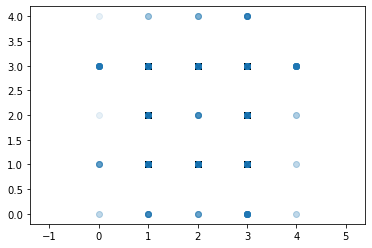

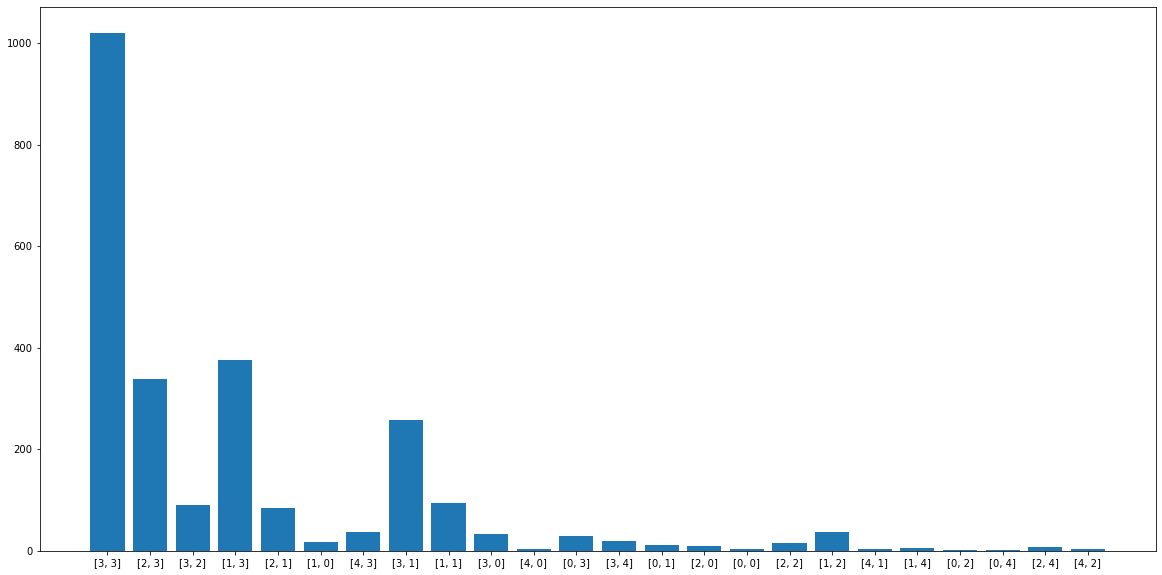

Processing Epoch 177
training start
Iteration 0, d real/fake loss 0.6761162281036377/0.6696115732192993 and g loss is 0.7355179786682129, NDiv loss 0.14410051703453064
Iteration 1, d real/fake loss 0.6760081648826599/0.6647888422012329 and g loss is 0.730742335319519, NDiv loss 0.12735004723072052
Iteration 2, d real/fake loss 0.6758811473846436/0.6786233186721802 and g loss is 0.717301070690155, NDiv loss 0.1718759536743164
Iteration 3, d real/fake loss 0.6757524013519287/0.6681287288665771 and g loss is 0.7352885603904724, NDiv loss 0.16539859771728516
Iteration 4, d real/fake loss 0.6756097078323364/0.6713952422142029 and g loss is 0.7213815450668335, NDiv loss 0.16720929741859436


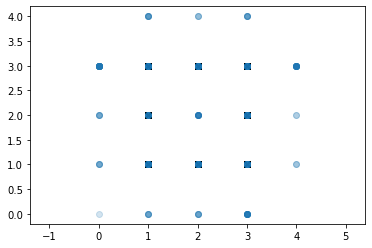

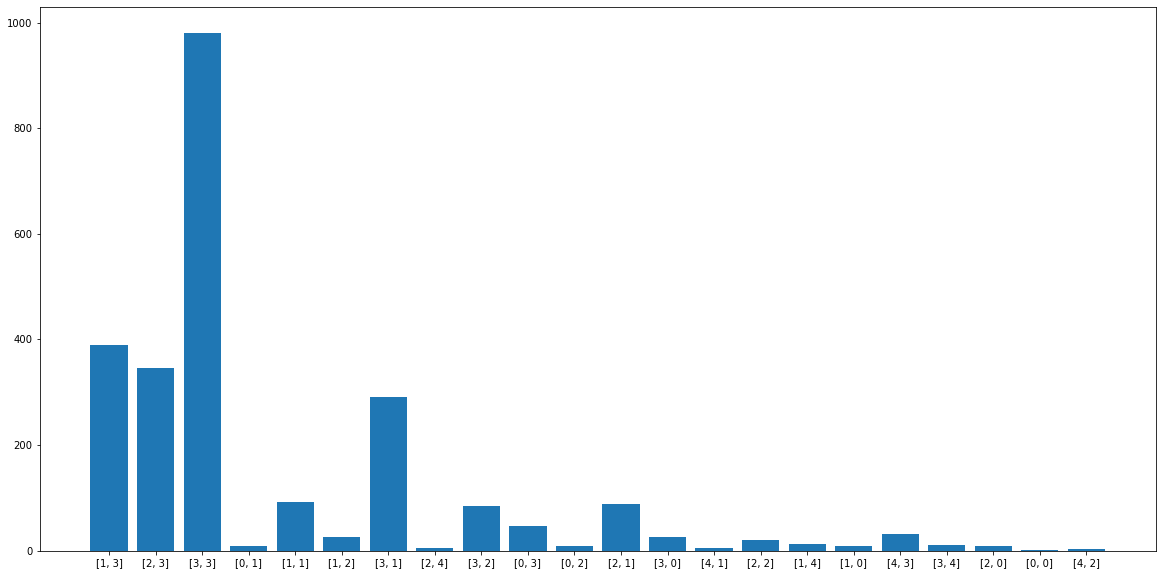

Processing Epoch 178
training start
Iteration 0, d real/fake loss 0.6768814325332642/0.6715824604034424 and g loss is 0.730605959892273, NDiv loss 0.13095344603061676
Iteration 1, d real/fake loss 0.6767796277999878/0.6646590828895569 and g loss is 0.7379546165466309, NDiv loss 0.12988519668579102
Iteration 2, d real/fake loss 0.6766648292541504/0.668854832649231 and g loss is 0.7325091361999512, NDiv loss 0.13778632879257202
Iteration 3, d real/fake loss 0.6765445470809937/0.6638752222061157 and g loss is 0.7139022946357727, NDiv loss 0.1638859361410141
Iteration 4, d real/fake loss 0.6764132976531982/0.666214108467102 and g loss is 0.727250337600708, NDiv loss 0.1487494260072708


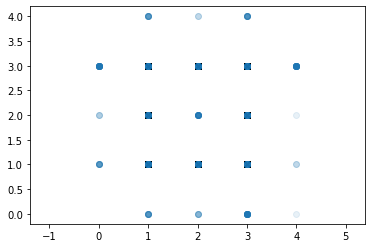

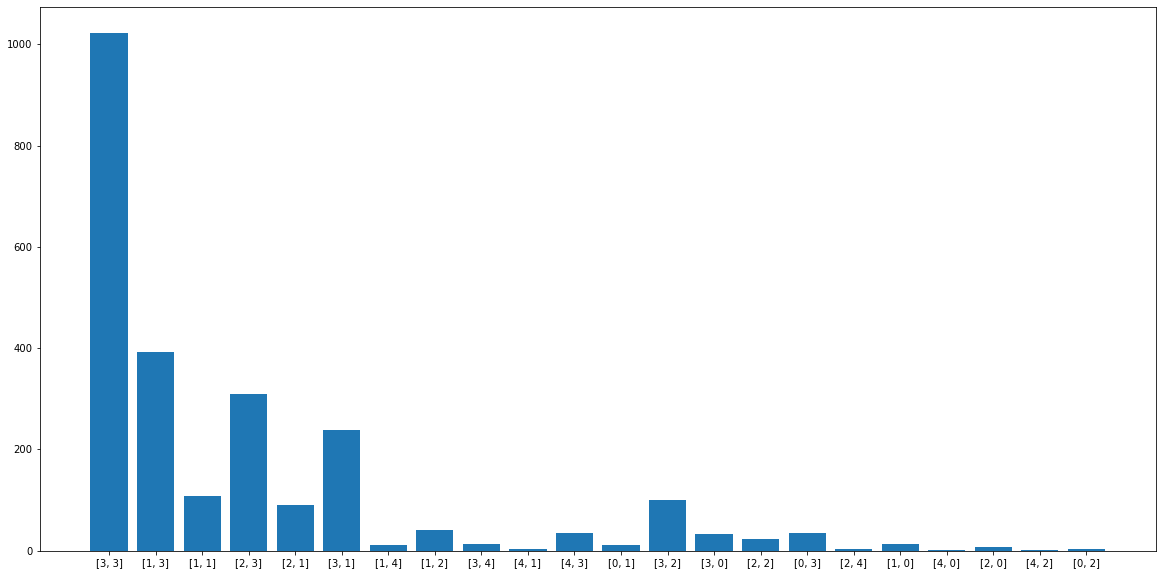

Processing Epoch 179
training start
Iteration 0, d real/fake loss 0.6595571041107178/0.6659195423126221 and g loss is 0.7253573536872864, NDiv loss 0.12202532589435577
Iteration 1, d real/fake loss 0.6593102216720581/0.658008337020874 and g loss is 0.7263149619102478, NDiv loss 0.1483190357685089
Iteration 2, d real/fake loss 0.6590532660484314/0.6630291938781738 and g loss is 0.7467831373214722, NDiv loss 0.15925142168998718
Iteration 3, d real/fake loss 0.6587969660758972/0.6600489616394043 and g loss is 0.7233589291572571, NDiv loss 0.13553772866725922
Iteration 4, d real/fake loss 0.658542811870575/0.6702708005905151 and g loss is 0.7202197313308716, NDiv loss 0.12198897451162338


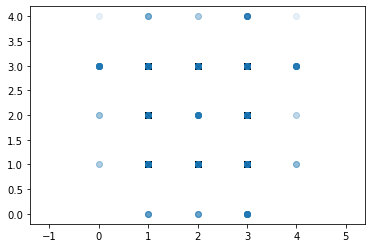

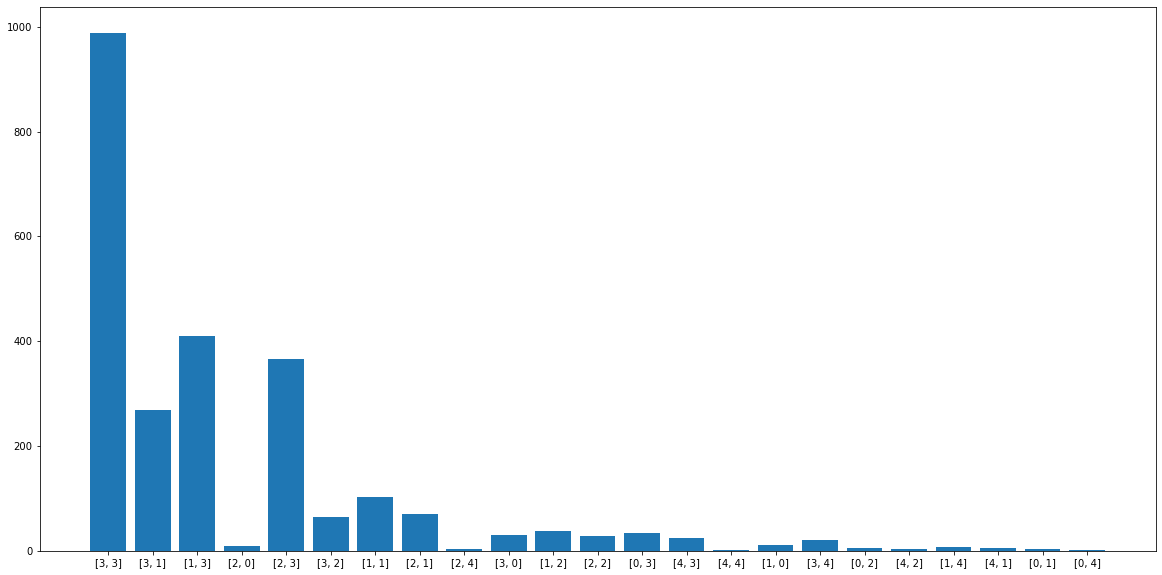

Processing Epoch 180
training start
Iteration 0, d real/fake loss 0.6711124181747437/0.6631975173950195 and g loss is 0.7164912223815918, NDiv loss 0.13379009068012238
Iteration 1, d real/fake loss 0.6709706783294678/0.6638196110725403 and g loss is 0.7309039235115051, NDiv loss 0.1331699937582016
Iteration 2, d real/fake loss 0.6708111763000488/0.6708331108093262 and g loss is 0.7251916527748108, NDiv loss 0.13695091009140015
Iteration 3, d real/fake loss 0.6706467270851135/0.6733691692352295 and g loss is 0.7397627830505371, NDiv loss 0.14326240122318268
Iteration 4, d real/fake loss 0.6704804301261902/0.6672646999359131 and g loss is 0.7300534844398499, NDiv loss 0.14469070732593536


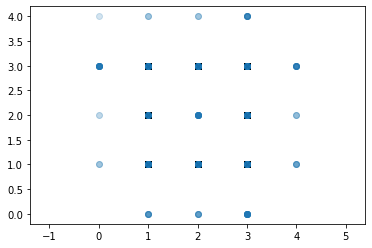

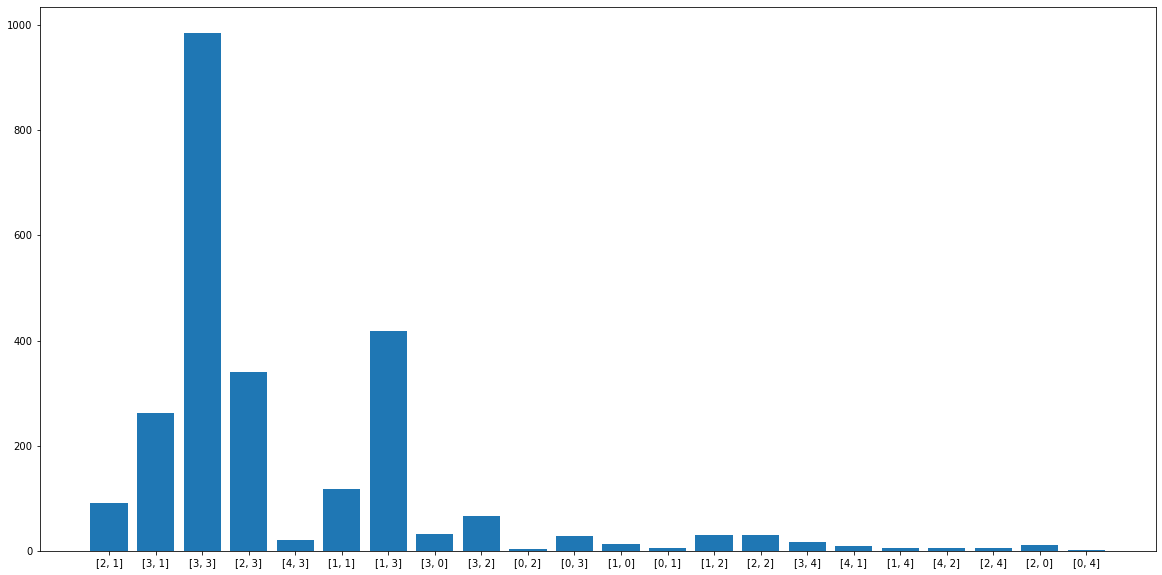

Processing Epoch 181
training start
Iteration 0, d real/fake loss 0.6714110970497131/0.662330687046051 and g loss is 0.7339651584625244, NDiv loss 0.13473860919475555
Iteration 1, d real/fake loss 0.6712759733200073/0.6619001626968384 and g loss is 0.7410905361175537, NDiv loss 0.12456408888101578
Iteration 2, d real/fake loss 0.6711359620094299/0.6637011766433716 and g loss is 0.7358841896057129, NDiv loss 0.1452259123325348
Iteration 3, d real/fake loss 0.6709957122802734/0.6667174100875854 and g loss is 0.7342696189880371, NDiv loss 0.15209263563156128
Iteration 4, d real/fake loss 0.6708501577377319/0.6590793132781982 and g loss is 0.7454336285591125, NDiv loss 0.15021063387393951


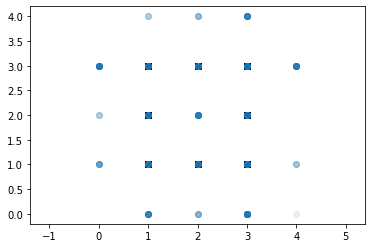

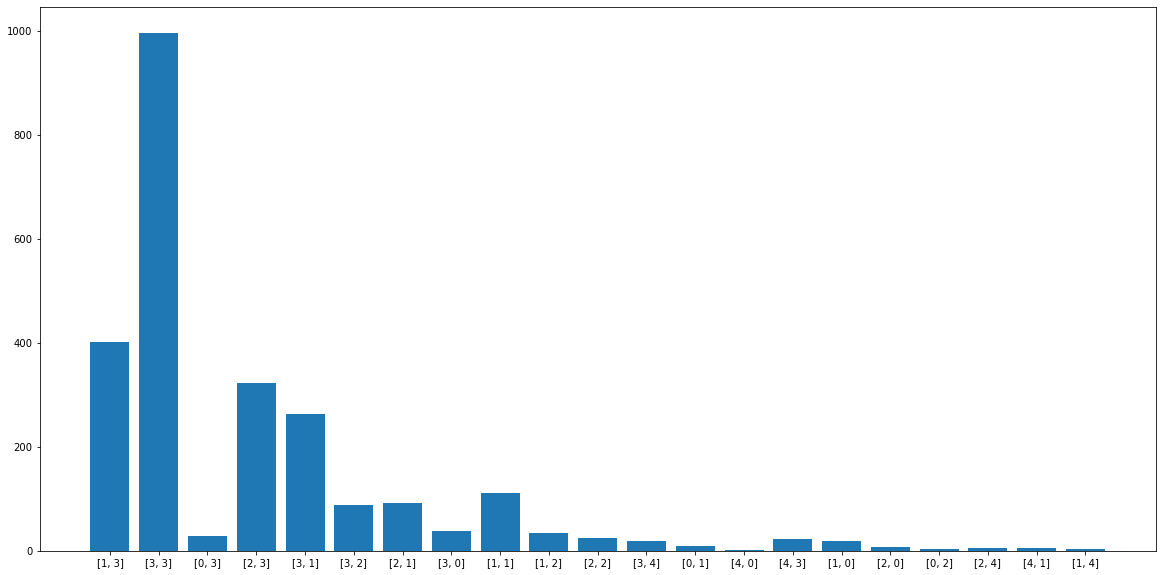

Processing Epoch 182
training start
Iteration 0, d real/fake loss 0.6649070382118225/0.6597597599029541 and g loss is 0.7251769304275513, NDiv loss 0.13525927066802979
Iteration 1, d real/fake loss 0.6647379398345947/0.6717392206192017 and g loss is 0.725831151008606, NDiv loss 0.11395107954740524
Iteration 2, d real/fake loss 0.6645820140838623/0.6588119268417358 and g loss is 0.7269925475120544, NDiv loss 0.14673574268817902
Iteration 3, d real/fake loss 0.6644263863563538/0.6632583141326904 and g loss is 0.7445878982543945, NDiv loss 0.13443607091903687
Iteration 4, d real/fake loss 0.6642796397209167/0.6481528878211975 and g loss is 0.7336424589157104, NDiv loss 0.12887868285179138


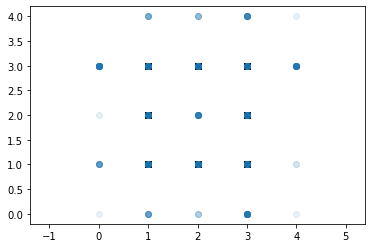

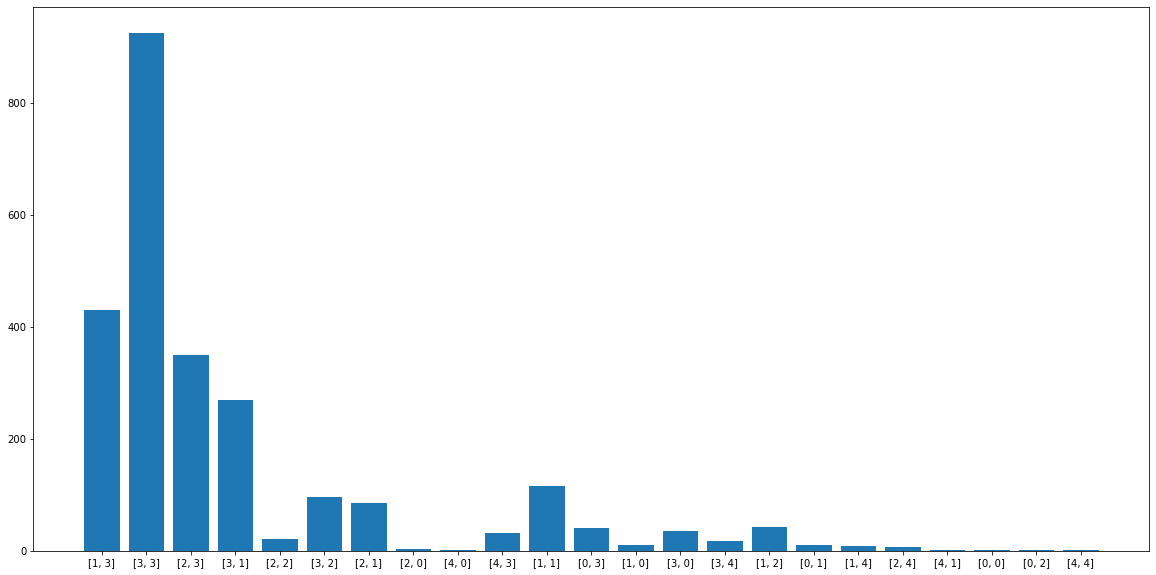

Processing Epoch 183
training start
Iteration 0, d real/fake loss 0.6556857824325562/0.655051589012146 and g loss is 0.7311016321182251, NDiv loss 0.11894959211349487
Iteration 1, d real/fake loss 0.6553902626037598/0.6641274094581604 and g loss is 0.7299487590789795, NDiv loss 0.1191554144024849
Iteration 2, d real/fake loss 0.6551018953323364/0.6522014141082764 and g loss is 0.7484254240989685, NDiv loss 0.18649446964263916
Iteration 3, d real/fake loss 0.6548053026199341/0.6530704498291016 and g loss is 0.7404212951660156, NDiv loss 0.12803708016872406
Iteration 4, d real/fake loss 0.6545039415359497/0.6550065875053406 and g loss is 0.726136326789856, NDiv loss 0.14144521951675415


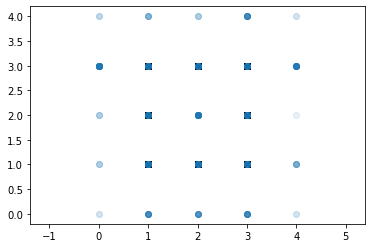

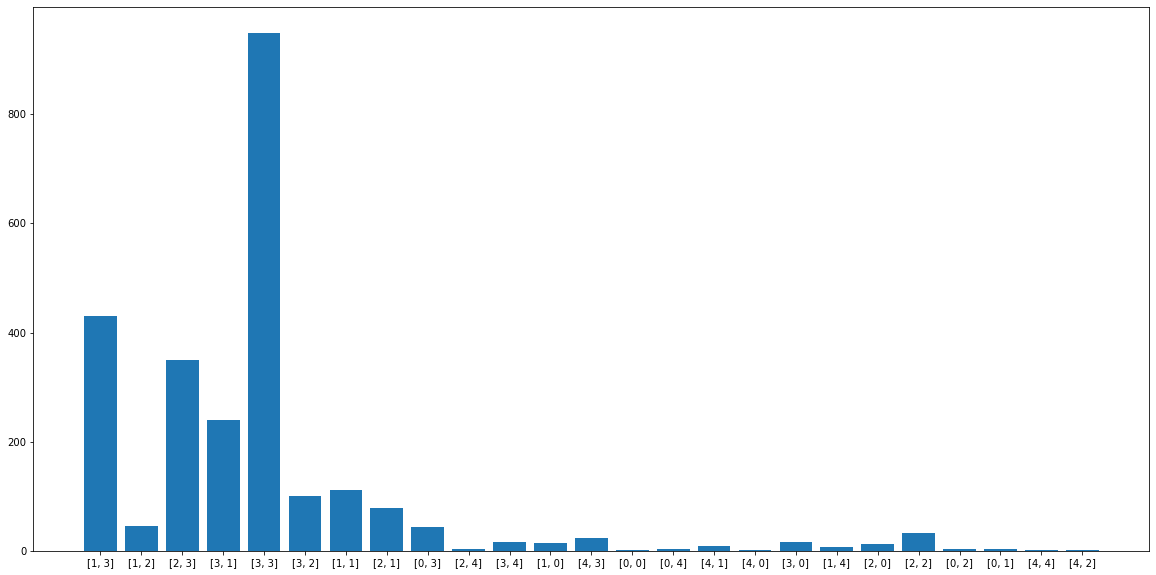

Processing Epoch 184
training start
Iteration 0, d real/fake loss 0.6753506064414978/0.6521267890930176 and g loss is 0.7293218970298767, NDiv loss 0.15549172461032867
Iteration 1, d real/fake loss 0.6751506328582764/0.651909589767456 and g loss is 0.759427547454834, NDiv loss 0.10344106703996658
Iteration 2, d real/fake loss 0.6749275922775269/0.6554239392280579 and g loss is 0.7247427701950073, NDiv loss 0.12372314184904099
Iteration 3, d real/fake loss 0.6746925115585327/0.6617105603218079 and g loss is 0.7543842792510986, NDiv loss 0.1903160661458969
Iteration 4, d real/fake loss 0.6744531989097595/0.6443163156509399 and g loss is 0.7418531179428101, NDiv loss 0.15156106650829315


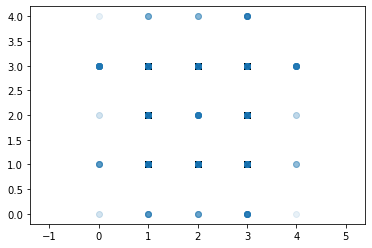

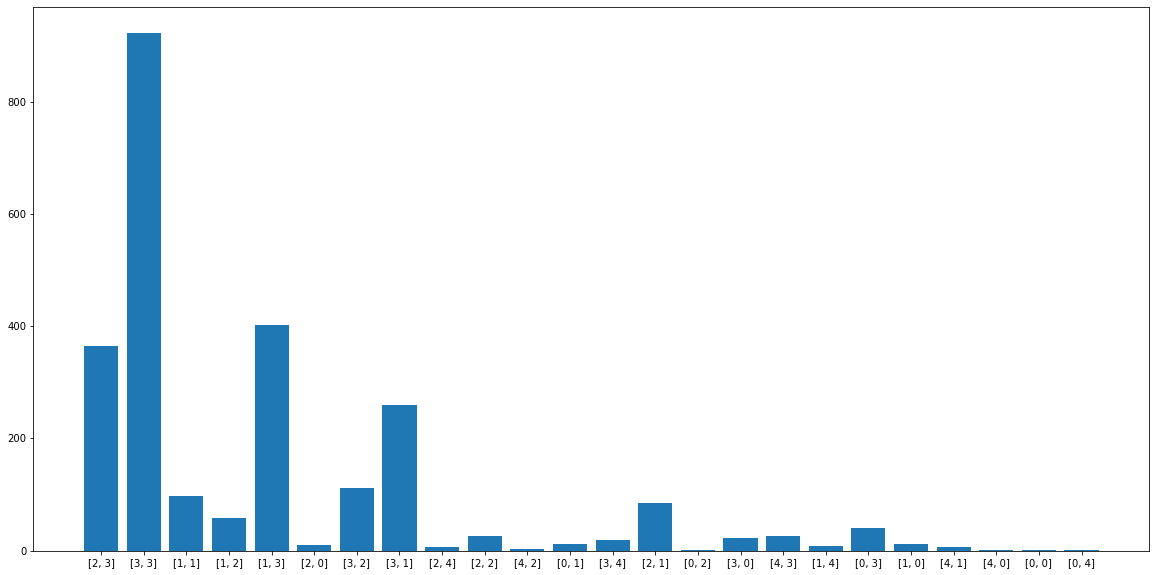

Processing Epoch 185
training start
Iteration 0, d real/fake loss 0.6538195013999939/0.6656821370124817 and g loss is 0.7376107573509216, NDiv loss 0.15052397549152374
Iteration 1, d real/fake loss 0.6535385847091675/0.6535035967826843 and g loss is 0.7348150014877319, NDiv loss 0.13174475729465485
Iteration 2, d real/fake loss 0.6532600522041321/0.6642885208129883 and g loss is 0.7385076880455017, NDiv loss 0.1378524750471115
Iteration 3, d real/fake loss 0.6529983878135681/0.6573103666305542 and g loss is 0.7441494464874268, NDiv loss 0.13988307118415833
Iteration 4, d real/fake loss 0.6527448296546936/0.659552812576294 and g loss is 0.7468713521957397, NDiv loss 0.15173500776290894


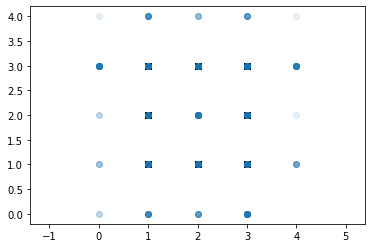

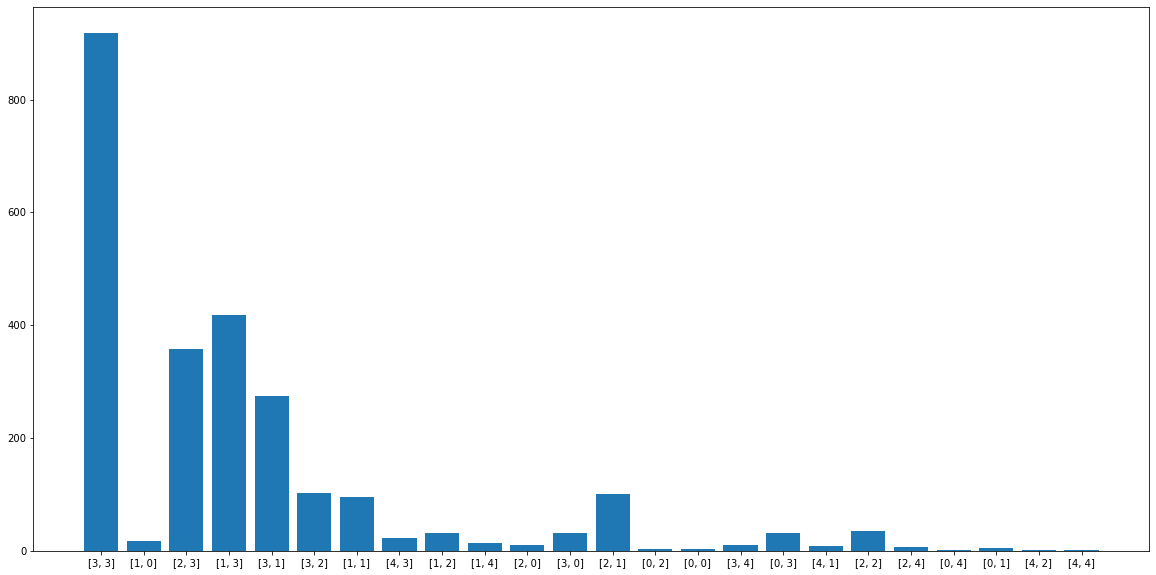

Processing Epoch 186
training start
Iteration 0, d real/fake loss 0.6618736386299133/0.6537022590637207 and g loss is 0.7339287996292114, NDiv loss 0.11879879981279373
Iteration 1, d real/fake loss 0.6617032885551453/0.6658385992050171 and g loss is 0.7482141256332397, NDiv loss 0.12058607488870621
Iteration 2, d real/fake loss 0.6615455150604248/0.6564818024635315 and g loss is 0.7491832375526428, NDiv loss 0.11755923181772232
Iteration 3, d real/fake loss 0.6613898277282715/0.6524014472961426 and g loss is 0.72124844789505, NDiv loss 0.10340220481157303
Iteration 4, d real/fake loss 0.6612325310707092/0.6684666872024536 and g loss is 0.74071204662323, NDiv loss 0.13172900676727295


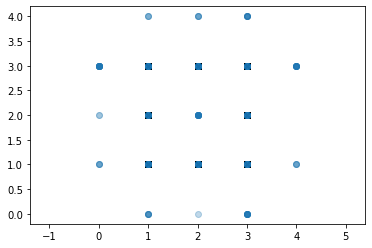

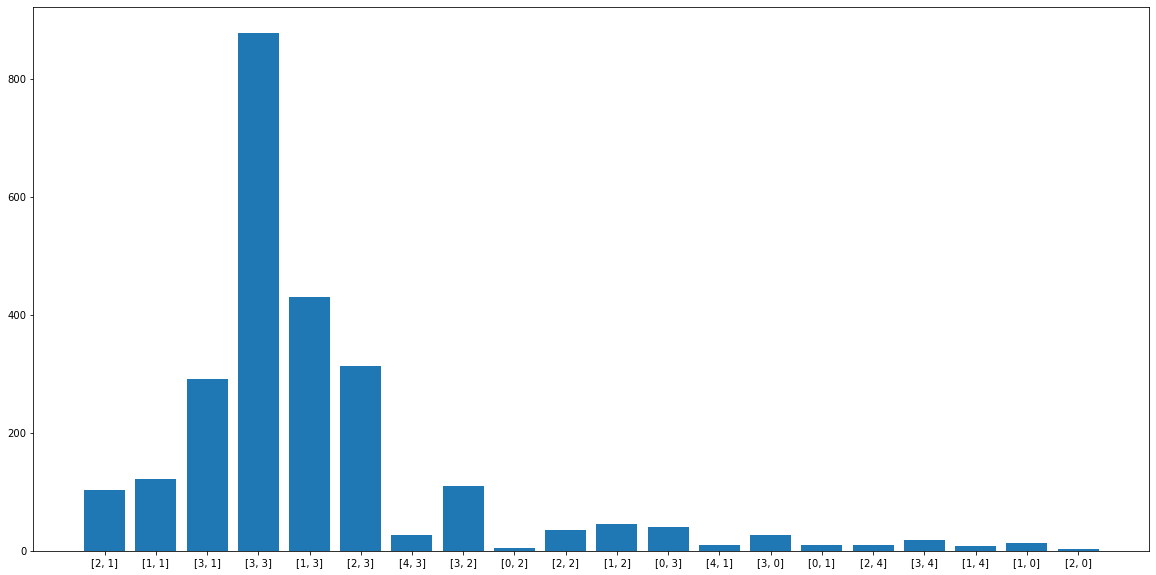

Processing Epoch 187
training start
Iteration 0, d real/fake loss 0.6650583744049072/0.667766273021698 and g loss is 0.7670689821243286, NDiv loss 0.1469869166612625
Iteration 1, d real/fake loss 0.6648383140563965/0.6623143553733826 and g loss is 0.7343549132347107, NDiv loss 0.14045655727386475
Iteration 2, d real/fake loss 0.6646147966384888/0.6581021547317505 and g loss is 0.748271107673645, NDiv loss 0.13546600937843323
Iteration 3, d real/fake loss 0.6643861532211304/0.6566932201385498 and g loss is 0.7542003393173218, NDiv loss 0.1269250363111496
Iteration 4, d real/fake loss 0.664145827293396/0.6470141410827637 and g loss is 0.7391698956489563, NDiv loss 0.09274762123823166


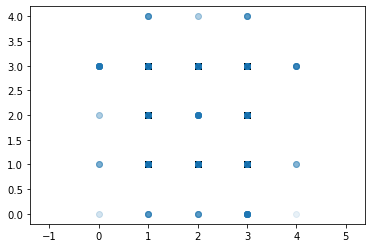

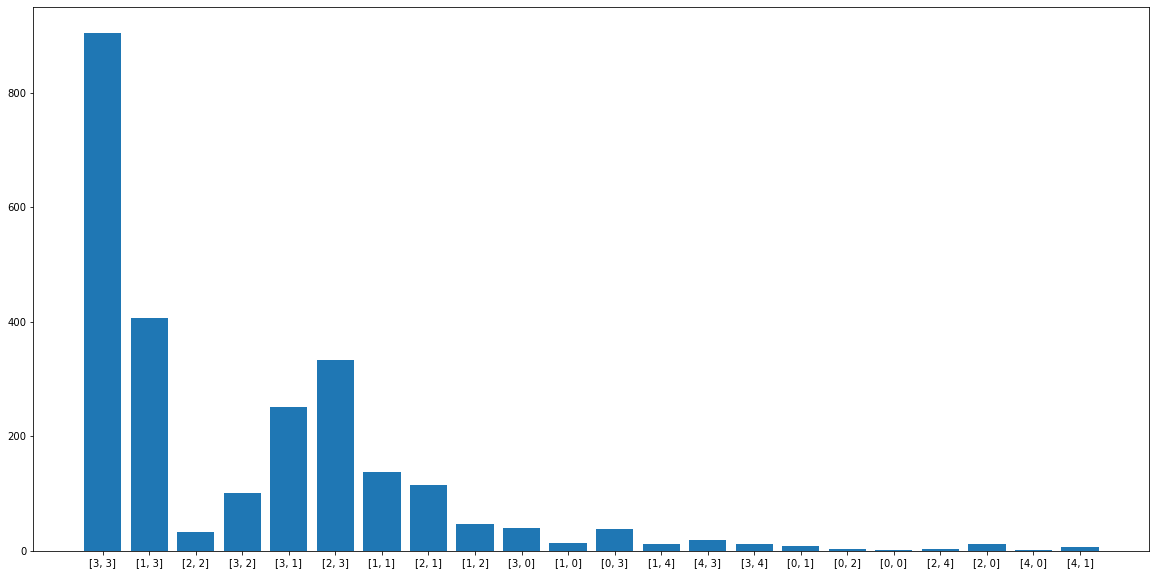

Processing Epoch 188
training start
Iteration 0, d real/fake loss 0.6466097831726074/0.6630846858024597 and g loss is 0.7371194362640381, NDiv loss 0.11325739324092865
Iteration 1, d real/fake loss 0.6462894678115845/0.6402727961540222 and g loss is 0.7460030317306519, NDiv loss 0.13824602961540222
Iteration 2, d real/fake loss 0.6459465622901917/0.6427319645881653 and g loss is 0.7365654706954956, NDiv loss 0.11447018384933472
Iteration 3, d real/fake loss 0.645581841468811/0.6556182503700256 and g loss is 0.7380430698394775, NDiv loss 0.128519207239151
Iteration 4, d real/fake loss 0.6452140808105469/0.654595136642456 and g loss is 0.7388342618942261, NDiv loss 0.09888724982738495


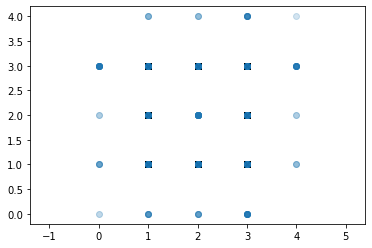

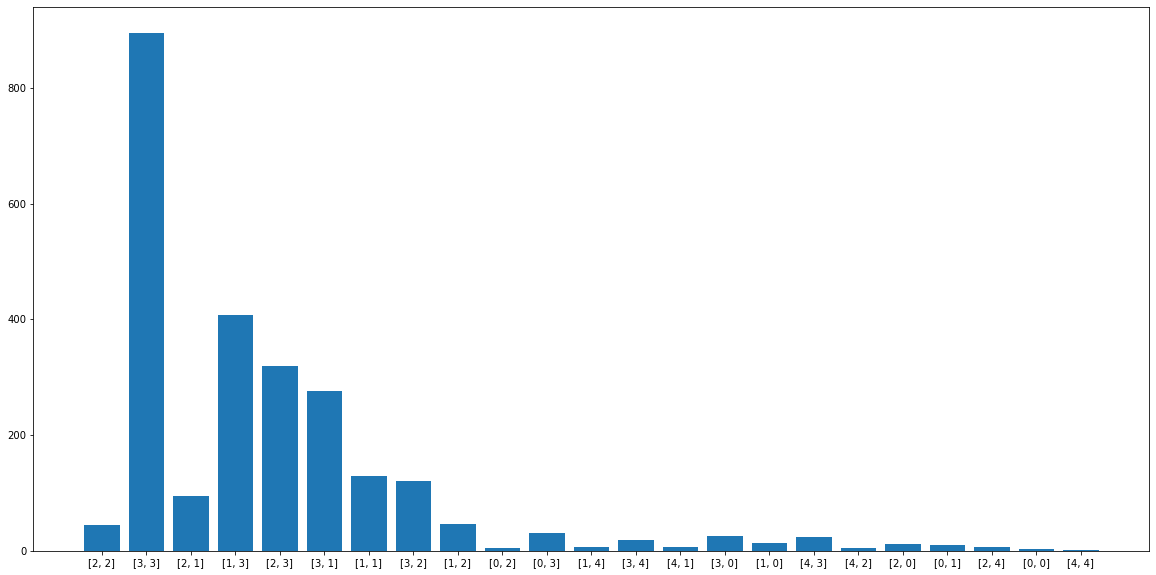

Processing Epoch 189
training start
Iteration 0, d real/fake loss 0.659428596496582/0.6703110933303833 and g loss is 0.7425223588943481, NDiv loss 0.13181334733963013
Iteration 1, d real/fake loss 0.6593329906463623/0.6520788669586182 and g loss is 0.745762288570404, NDiv loss 0.13475295901298523
Iteration 2, d real/fake loss 0.6592299938201904/0.6480517387390137 and g loss is 0.7556828260421753, NDiv loss 0.11002007871866226
Iteration 3, d real/fake loss 0.6591191291809082/0.6564295291900635 and g loss is 0.749325156211853, NDiv loss 0.1218518614768982
Iteration 4, d real/fake loss 0.6590012311935425/0.6630467176437378 and g loss is 0.7636266946792603, NDiv loss 0.12088113278150558


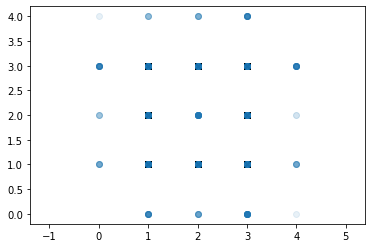

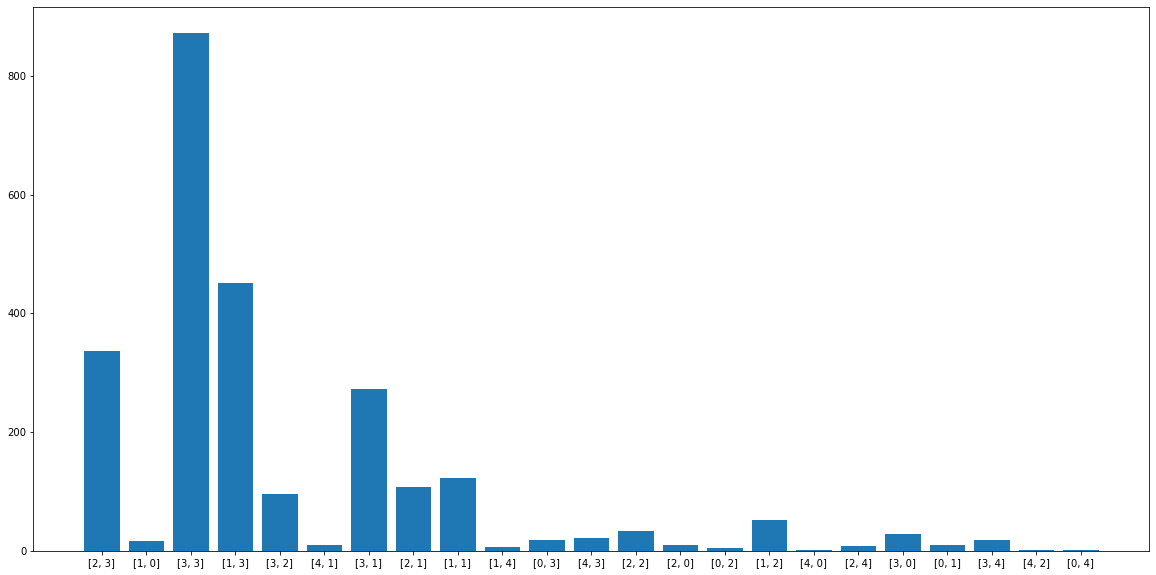

Processing Epoch 190
training start
Iteration 0, d real/fake loss 0.6665724515914917/0.6537696123123169 and g loss is 0.7356662154197693, NDiv loss 0.10624413937330246
Iteration 1, d real/fake loss 0.6664561033248901/0.6457086205482483 and g loss is 0.7403858304023743, NDiv loss 0.13969305157661438
Iteration 2, d real/fake loss 0.6663249135017395/0.6608204245567322 and g loss is 0.7548071146011353, NDiv loss 0.11356677860021591
Iteration 3, d real/fake loss 0.6661936044692993/0.657439649105072 and g loss is 0.7339147329330444, NDiv loss 0.1126229539513588
Iteration 4, d real/fake loss 0.6660537719726562/0.6497801542282104 and g loss is 0.7360623478889465, NDiv loss 0.1110633984208107


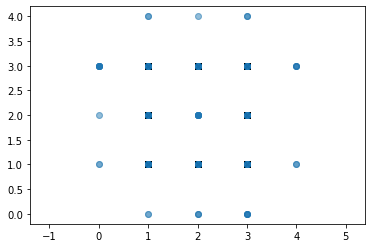

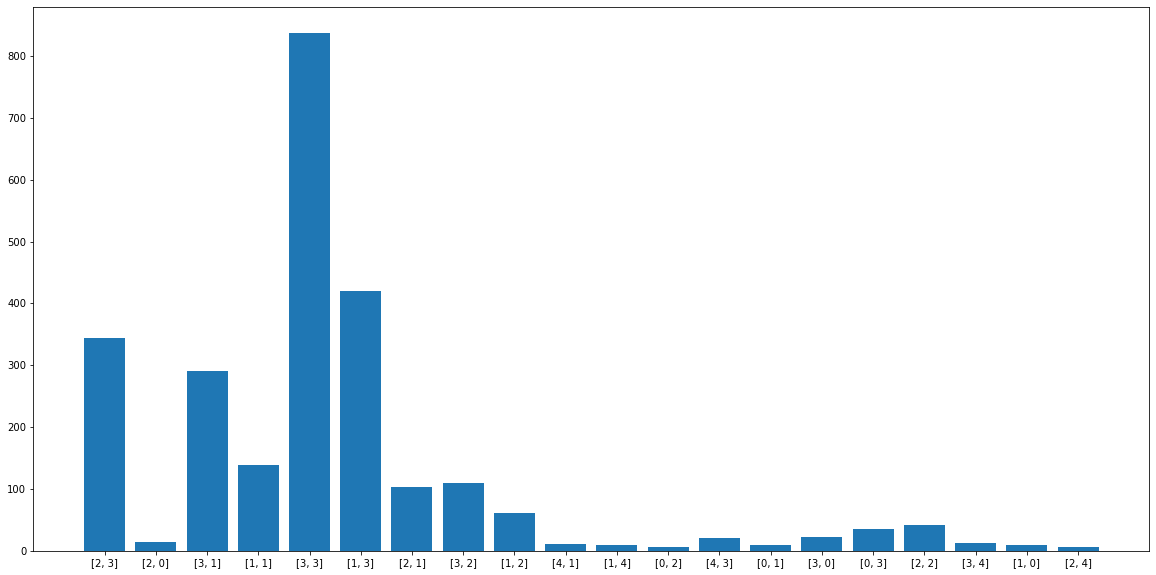

Processing Epoch 191
training start
Iteration 0, d real/fake loss 0.6568948030471802/0.6522854566574097 and g loss is 0.7686342000961304, NDiv loss 0.10168390721082687
Iteration 1, d real/fake loss 0.6566949486732483/0.655449628829956 and g loss is 0.7483149766921997, NDiv loss 0.11391062289476395
Iteration 2, d real/fake loss 0.6564981937408447/0.6705893278121948 and g loss is 0.7394428849220276, NDiv loss 0.10472399741411209
Iteration 3, d real/fake loss 0.6563174724578857/0.6512942314147949 and g loss is 0.7686516046524048, NDiv loss 0.12148475646972656
Iteration 4, d real/fake loss 0.6561349630355835/0.654153048992157 and g loss is 0.7472766637802124, NDiv loss 0.10515380650758743


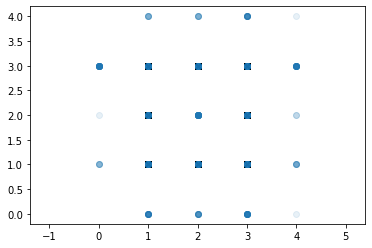

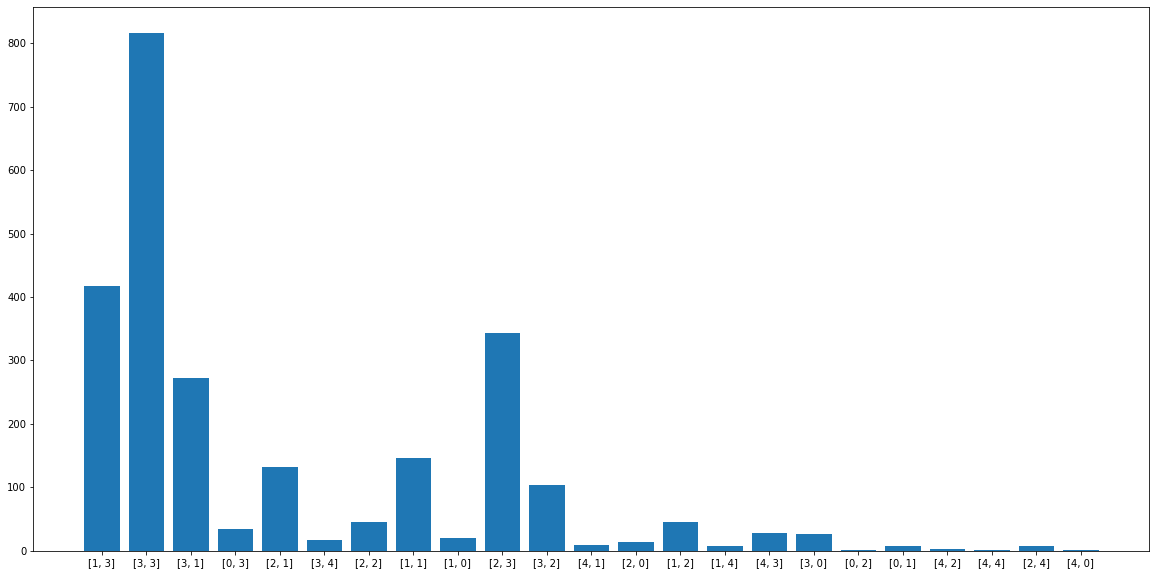

Processing Epoch 192
training start
Iteration 0, d real/fake loss 0.6682761907577515/0.6469133496284485 and g loss is 0.7395850419998169, NDiv loss 0.10838834941387177
Iteration 1, d real/fake loss 0.6681278944015503/0.6385570764541626 and g loss is 0.7366365194320679, NDiv loss 0.1134977787733078
Iteration 2, d real/fake loss 0.6679632663726807/0.6587828397750854 and g loss is 0.7507516741752625, NDiv loss 0.09861281514167786
Iteration 3, d real/fake loss 0.6678025722503662/0.6776165962219238 and g loss is 0.7394120097160339, NDiv loss 0.10560224950313568
Iteration 4, d real/fake loss 0.6676498651504517/0.6506014466285706 and g loss is 0.7308435440063477, NDiv loss 0.10705304890871048


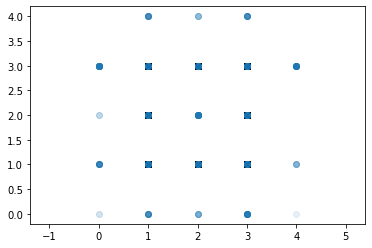

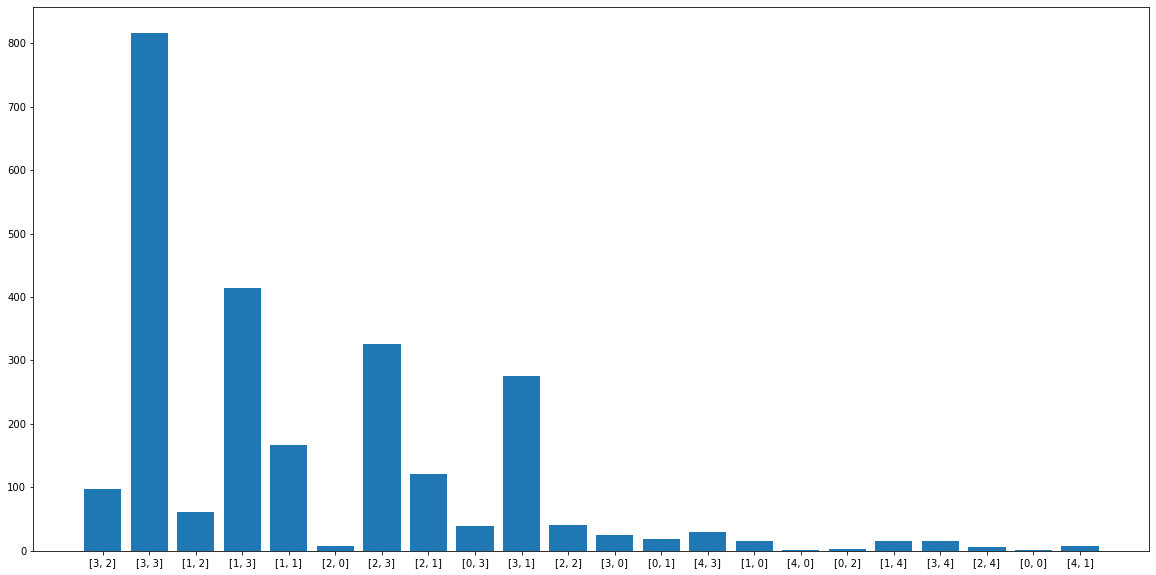

Processing Epoch 193
training start
Iteration 0, d real/fake loss 0.6658838987350464/0.6474287509918213 and g loss is 0.760231077671051, NDiv loss 0.08472134917974472
Iteration 1, d real/fake loss 0.665760338306427/0.6596068143844604 and g loss is 0.7489312291145325, NDiv loss 0.09578552842140198
Iteration 2, d real/fake loss 0.6656337976455688/0.6661017537117004 and g loss is 0.7470908761024475, NDiv loss 0.10294836014509201
Iteration 3, d real/fake loss 0.6655141711235046/0.6444281339645386 and g loss is 0.7325600385665894, NDiv loss 0.12316194921731949
Iteration 4, d real/fake loss 0.6653797626495361/0.6445541381835938 and g loss is 0.7318682670593262, NDiv loss 0.11606545001268387


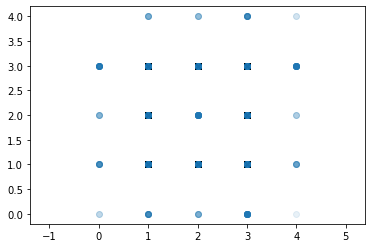

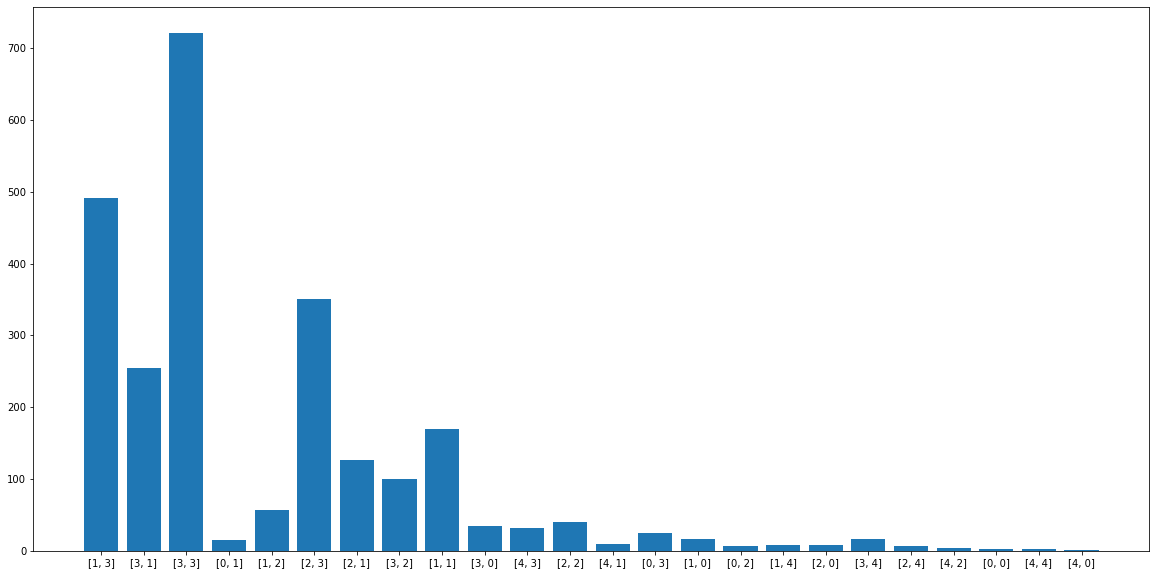

Processing Epoch 194
training start
Iteration 0, d real/fake loss 0.6456072330474854/0.6718786954879761 and g loss is 0.7439552545547485, NDiv loss 0.11666008830070496
Iteration 1, d real/fake loss 0.6454259157180786/0.6699922680854797 and g loss is 0.7371851205825806, NDiv loss 0.0884847566485405
Iteration 2, d real/fake loss 0.6452564001083374/0.6652480363845825 and g loss is 0.745617151260376, NDiv loss 0.11118485033512115
Iteration 3, d real/fake loss 0.6450977921485901/0.6629616618156433 and g loss is 0.7188379764556885, NDiv loss 0.10596808046102524
Iteration 4, d real/fake loss 0.6449496150016785/0.6646884679794312 and g loss is 0.7493950128555298, NDiv loss 0.10478097200393677


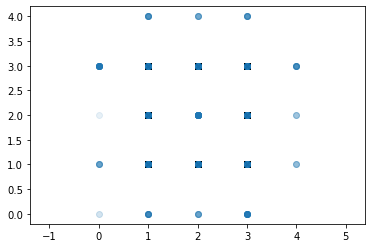

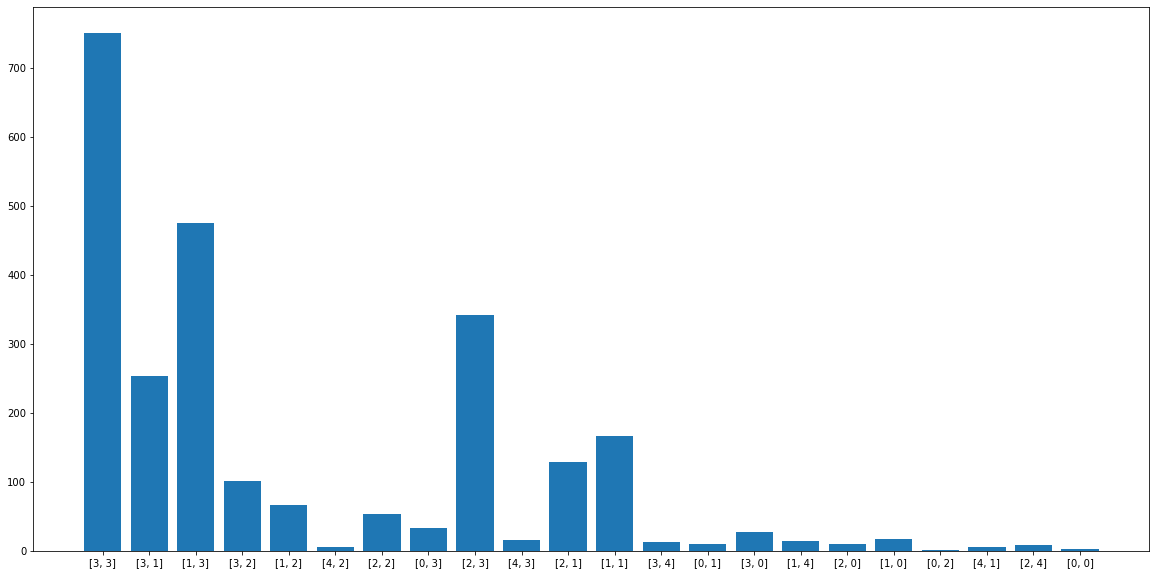

Processing Epoch 195
training start
Iteration 0, d real/fake loss 0.6487259268760681/0.6596963405609131 and g loss is 0.7336865663528442, NDiv loss 0.12457271665334702
Iteration 1, d real/fake loss 0.6485615372657776/0.6415069699287415 and g loss is 0.754278302192688, NDiv loss 0.11592888087034225
Iteration 2, d real/fake loss 0.6483808755874634/0.6520736217498779 and g loss is 0.7472135424613953, NDiv loss 0.10917749255895615
Iteration 3, d real/fake loss 0.6481958627700806/0.6573496460914612 and g loss is 0.7348673343658447, NDiv loss 0.09142167866230011
Iteration 4, d real/fake loss 0.6480159163475037/0.6740220189094543 and g loss is 0.7383719682693481, NDiv loss 0.10683795809745789


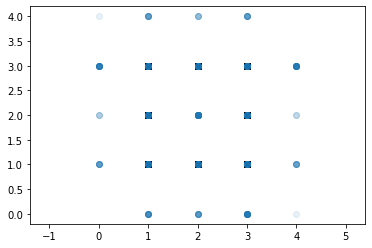

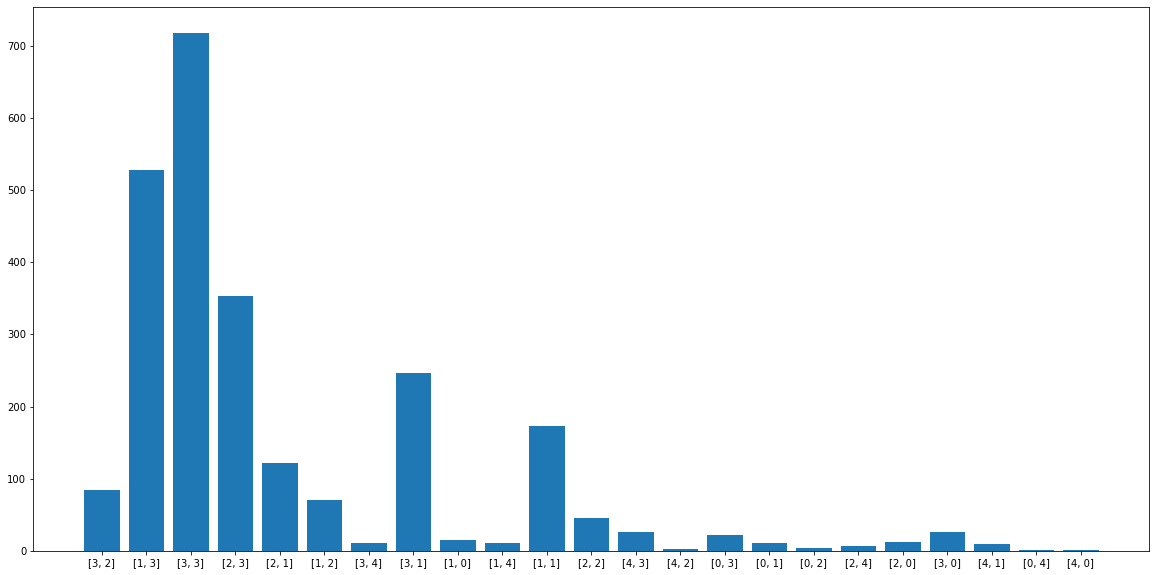

Processing Epoch 196
training start
Iteration 0, d real/fake loss 0.6504784822463989/0.6698505282402039 and g loss is 0.724197506904602, NDiv loss 0.10492081195116043
Iteration 1, d real/fake loss 0.6504036784172058/0.6666926741600037 and g loss is 0.7375664114952087, NDiv loss 0.10689651966094971
Iteration 2, d real/fake loss 0.6503369808197021/0.6561973690986633 and g loss is 0.7381106615066528, NDiv loss 0.10573612153530121
Iteration 3, d real/fake loss 0.6502648591995239/0.6749386191368103 and g loss is 0.7277823686599731, NDiv loss 0.08645042777061462
Iteration 4, d real/fake loss 0.6502107381820679/0.6683611273765564 and g loss is 0.7338825464248657, NDiv loss 0.09444825351238251


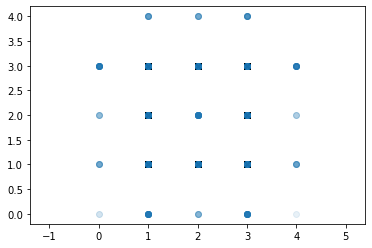

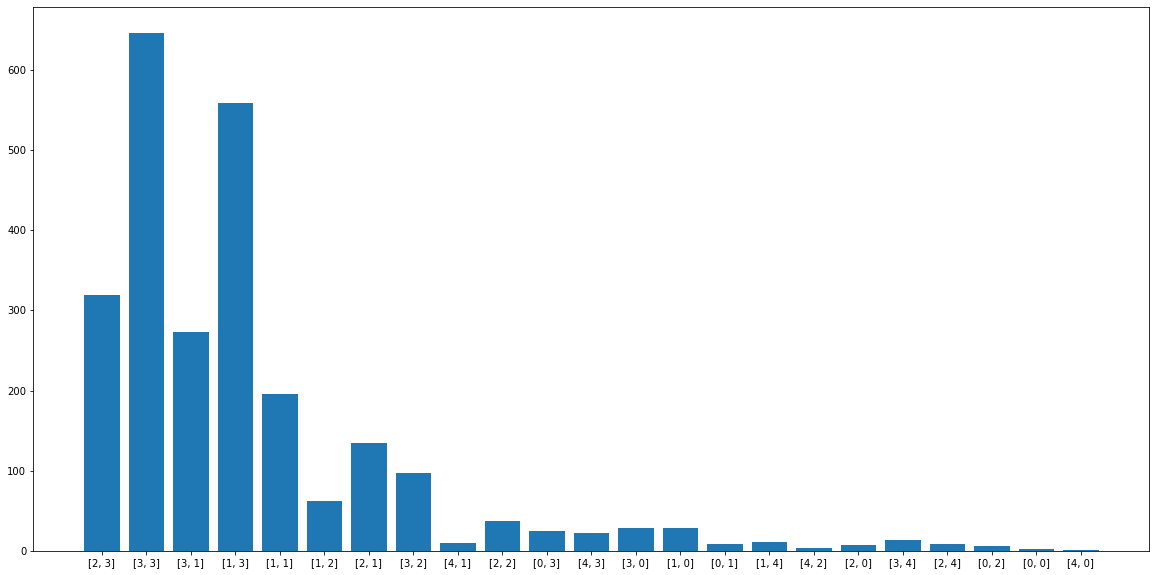

Processing Epoch 197
training start
Iteration 0, d real/fake loss 0.6609951257705688/0.66769939661026 and g loss is 0.7290277481079102, NDiv loss 0.10297185182571411
Iteration 1, d real/fake loss 0.6609756946563721/0.6769097447395325 and g loss is 0.7660523056983948, NDiv loss 0.09557792544364929
Iteration 2, d real/fake loss 0.6609609127044678/0.6551030874252319 and g loss is 0.7390636801719666, NDiv loss 0.09697616100311279
Iteration 3, d real/fake loss 0.6609286665916443/0.677679717540741 and g loss is 0.7298838496208191, NDiv loss 0.09559719264507294
Iteration 4, d real/fake loss 0.6609047055244446/0.6759865283966064 and g loss is 0.7355895042419434, NDiv loss 0.08874382823705673


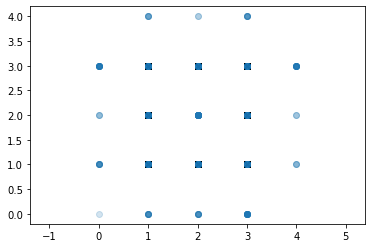

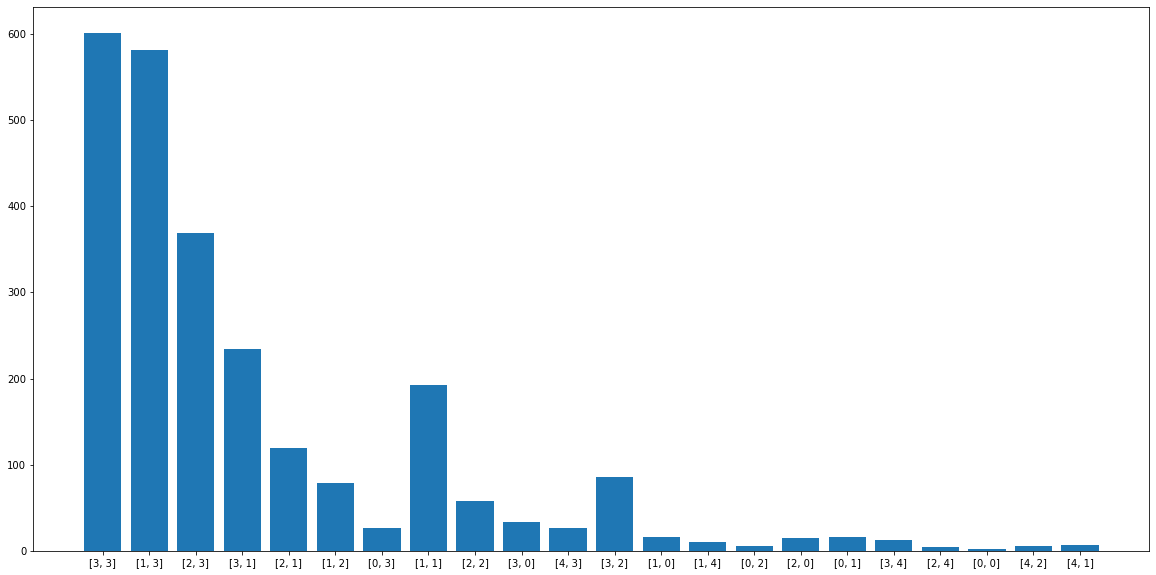

Processing Epoch 198
training start
Iteration 0, d real/fake loss 0.6477251648902893/0.6448886394500732 and g loss is 0.7221014499664307, NDiv loss 0.11974192410707474
Iteration 1, d real/fake loss 0.6476833820343018/0.663985550403595 and g loss is 0.7357983589172363, NDiv loss 0.09395752847194672
Iteration 2, d real/fake loss 0.647645115852356/0.6929843425750732 and g loss is 0.7362304329872131, NDiv loss 0.10128171741962433
Iteration 3, d real/fake loss 0.6476432085037231/0.6909315586090088 and g loss is 0.7347291707992554, NDiv loss 0.11829999089241028
Iteration 4, d real/fake loss 0.6476714015007019/0.6697049736976624 and g loss is 0.7433671951293945, NDiv loss 0.08463715016841888


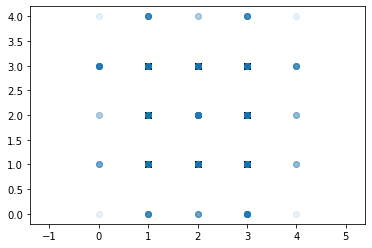

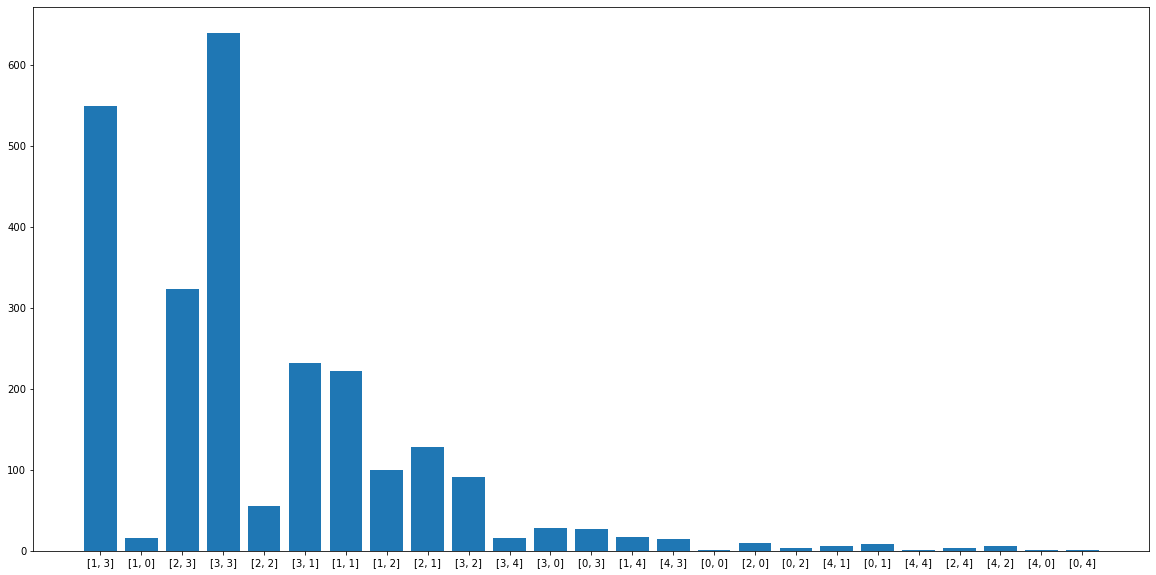

Processing Epoch 199
training start
Iteration 0, d real/fake loss 0.6456640958786011/0.6808850765228271 and g loss is 0.7314996123313904, NDiv loss 0.10268207639455795
Iteration 1, d real/fake loss 0.6456693410873413/0.6807246208190918 and g loss is 0.7464320063591003, NDiv loss 0.08897172659635544
Iteration 2, d real/fake loss 0.6456885933876038/0.6435197591781616 and g loss is 0.7324703931808472, NDiv loss 0.08734152466058731
Iteration 3, d real/fake loss 0.645669162273407/0.6749987006187439 and g loss is 0.756828248500824, NDiv loss 0.10712502151727676
Iteration 4, d real/fake loss 0.6456623077392578/0.6578682661056519 and g loss is 0.7460152506828308, NDiv loss 0.09517137706279755


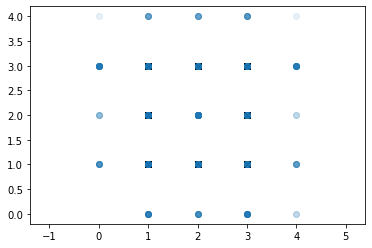

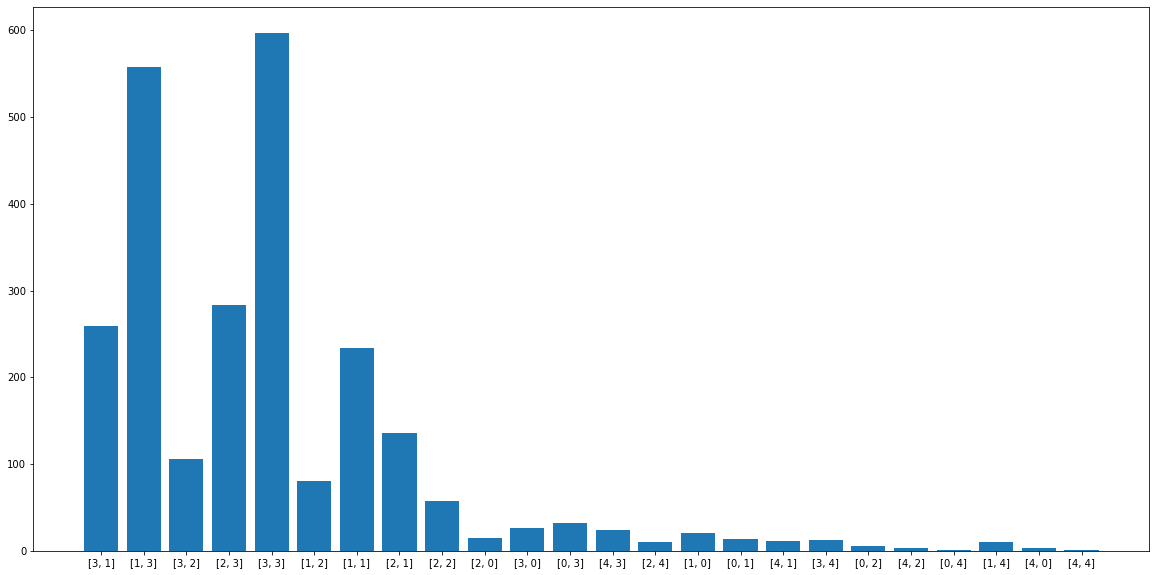

Processing Epoch 200
training start
Iteration 0, d real/fake loss 0.6431694626808167/0.6700088381767273 and g loss is 0.7147259712219238, NDiv loss 0.0866406187415123
Iteration 1, d real/fake loss 0.643155574798584/0.6508037447929382 and g loss is 0.7207411527633667, NDiv loss 0.0966297909617424
Iteration 2, d real/fake loss 0.6431215405464172/0.667153537273407 and g loss is 0.715618371963501, NDiv loss 0.0874861404299736
Iteration 3, d real/fake loss 0.64308762550354/0.6530970335006714 and g loss is 0.7244839072227478, NDiv loss 0.08718128502368927
Iteration 4, d real/fake loss 0.6430442333221436/0.6653380393981934 and g loss is 0.7233443260192871, NDiv loss 0.0917920470237732


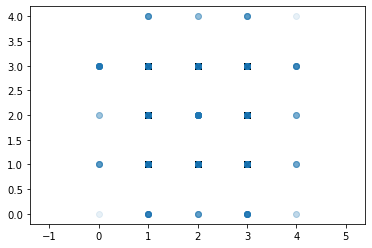

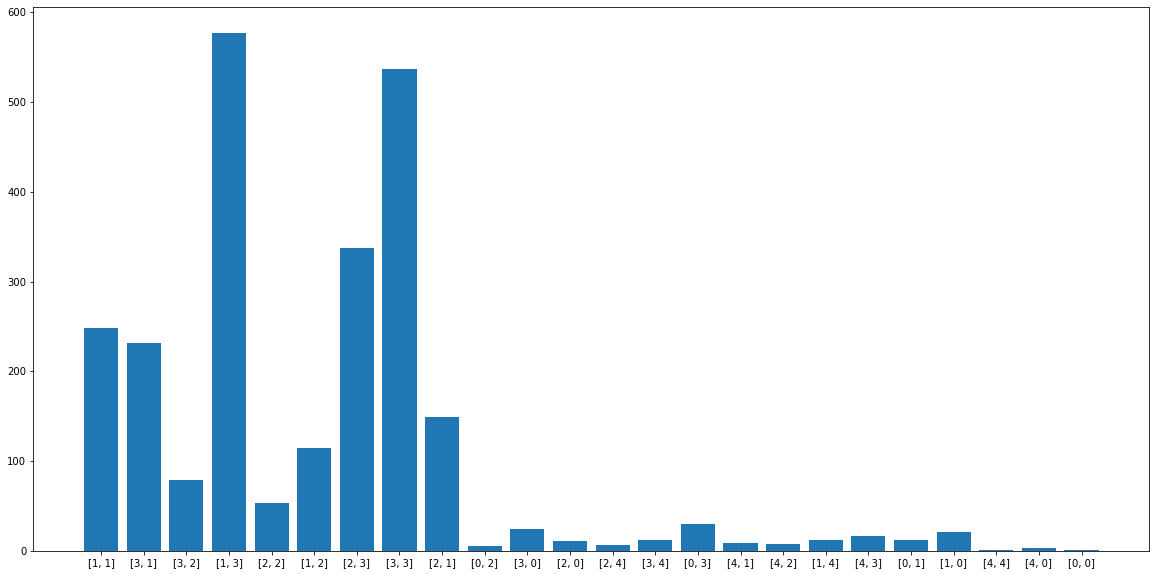

Processing Epoch 201
training start
Iteration 0, d real/fake loss 0.638535737991333/0.6557190418243408 and g loss is 0.7517601251602173, NDiv loss 0.12699079513549805
Iteration 1, d real/fake loss 0.638464629650116/0.6611213088035583 and g loss is 0.7115120887756348, NDiv loss 0.09352903813123703
Iteration 2, d real/fake loss 0.6383949518203735/0.67109215259552 and g loss is 0.7493338584899902, NDiv loss 0.0865093469619751
Iteration 3, d real/fake loss 0.6383382081985474/0.6838641166687012 and g loss is 0.7306517362594604, NDiv loss 0.09825101494789124
Iteration 4, d real/fake loss 0.6383031010627747/0.6572716236114502 and g loss is 0.7295183539390564, NDiv loss 0.08388099074363708


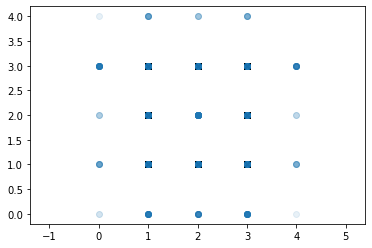

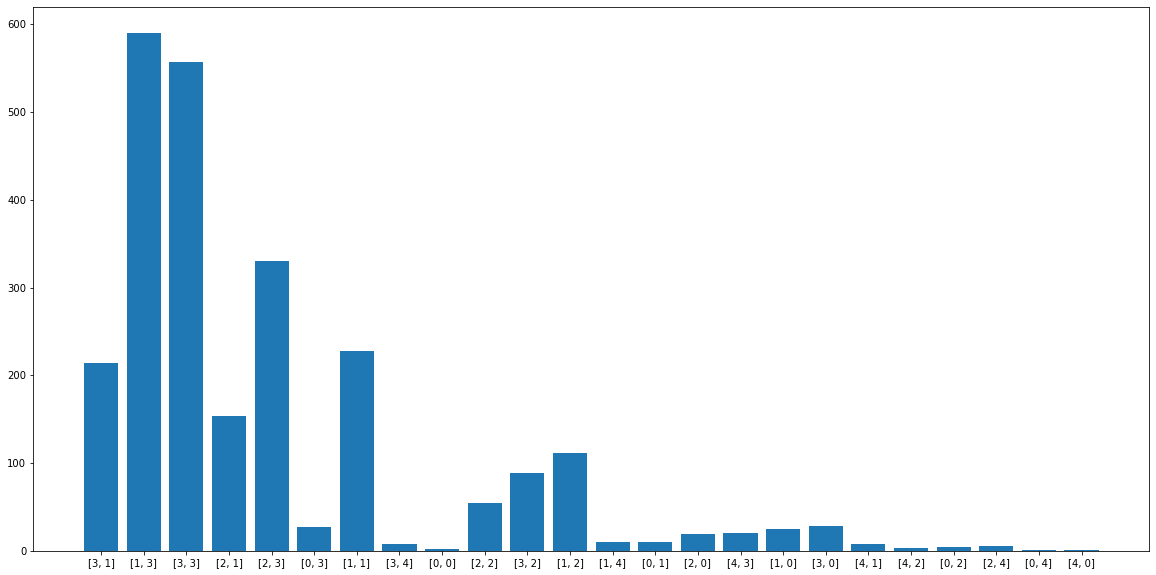

Processing Epoch 202
training start
Iteration 0, d real/fake loss 0.6586718559265137/0.6650528907775879 and g loss is 0.7299271821975708, NDiv loss 0.09077474474906921
Iteration 1, d real/fake loss 0.6587461233139038/0.6827390193939209 and g loss is 0.7300992012023926, NDiv loss 0.09512452781200409
Iteration 2, d real/fake loss 0.65882408618927/0.6688562631607056 and g loss is 0.7174205183982849, NDiv loss 0.08989933878183365
Iteration 3, d real/fake loss 0.6588935852050781/0.6721184253692627 and g loss is 0.735249400138855, NDiv loss 0.08322227746248245
Iteration 4, d real/fake loss 0.6589582562446594/0.6750115156173706 and g loss is 0.7320853471755981, NDiv loss 0.11141780018806458


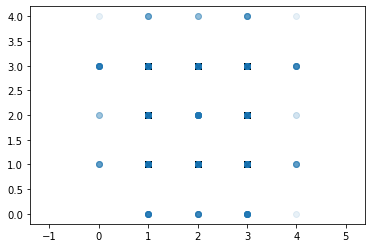

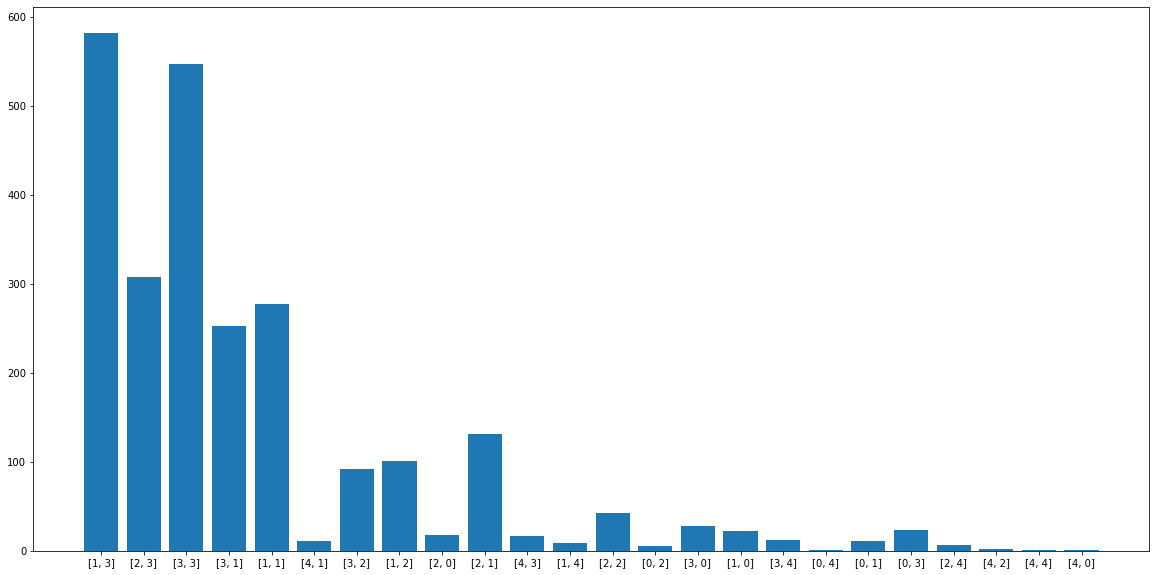

Processing Epoch 203
training start
Iteration 0, d real/fake loss 0.661253809928894/0.6806488037109375 and g loss is 0.7319447994232178, NDiv loss 0.10459369421005249
Iteration 1, d real/fake loss 0.6613596677780151/0.681151270866394 and g loss is 0.7341328859329224, NDiv loss 0.08283931761980057
Iteration 2, d real/fake loss 0.6614651679992676/0.6911667585372925 and g loss is 0.723505437374115, NDiv loss 0.09595533460378647
Iteration 3, d real/fake loss 0.6615769863128662/0.6617814302444458 and g loss is 0.7150125503540039, NDiv loss 0.08318536728620529
Iteration 4, d real/fake loss 0.6616742610931396/0.6609525680541992 and g loss is 0.7265561819076538, NDiv loss 0.09770884364843369


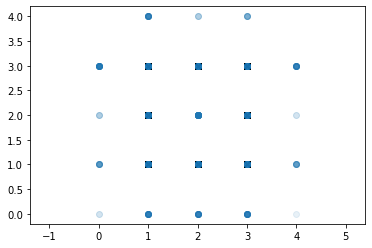

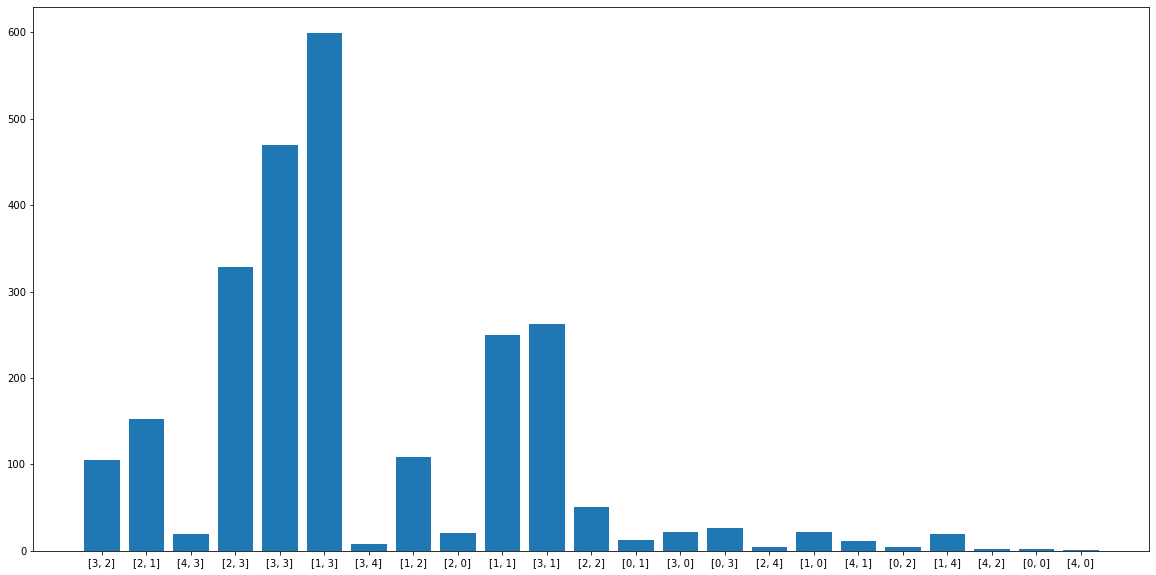

Processing Epoch 204
training start
Iteration 0, d real/fake loss 0.6500167846679688/0.6706387996673584 and g loss is 0.724532961845398, NDiv loss 0.08696308732032776
Iteration 1, d real/fake loss 0.6500115394592285/0.6710015535354614 and g loss is 0.7669904232025146, NDiv loss 0.08592327684164047
Iteration 2, d real/fake loss 0.6500011086463928/0.6778895258903503 and g loss is 0.7504417300224304, NDiv loss 0.09422393888235092
Iteration 3, d real/fake loss 0.6499981880187988/0.6786285638809204 and g loss is 0.7147184014320374, NDiv loss 0.09627167880535126
Iteration 4, d real/fake loss 0.6499965786933899/0.6757827997207642 and g loss is 0.7578630447387695, NDiv loss 0.08085086196660995


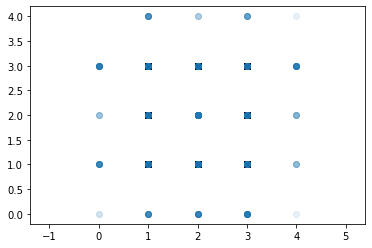

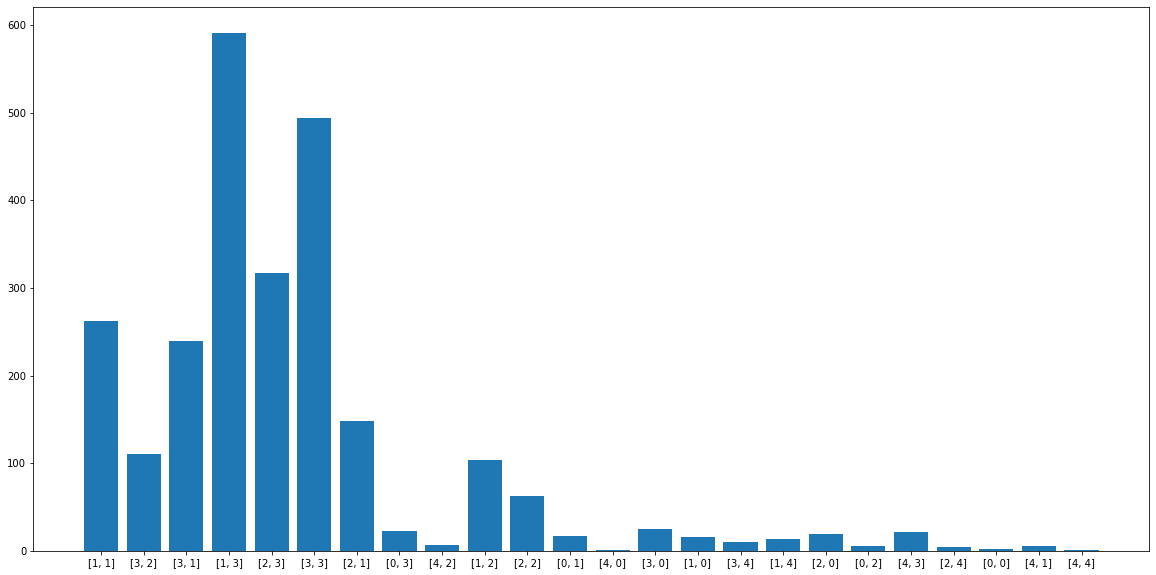

Processing Epoch 205
training start
Iteration 0, d real/fake loss 0.6431024670600891/0.6803659200668335 and g loss is 0.7326498627662659, NDiv loss 0.08211863785982132
Iteration 1, d real/fake loss 0.6430876851081848/0.6675846576690674 and g loss is 0.7434821128845215, NDiv loss 0.08892933279275894
Iteration 2, d real/fake loss 0.6430671811103821/0.6670870184898376 and g loss is 0.7496720552444458, NDiv loss 0.08884237706661224
Iteration 3, d real/fake loss 0.643048882484436/0.6930800676345825 and g loss is 0.7469035983085632, NDiv loss 0.09018585085868835
Iteration 4, d real/fake loss 0.6430439949035645/0.6668983101844788 and g loss is 0.7280914187431335, NDiv loss 0.08201824128627777


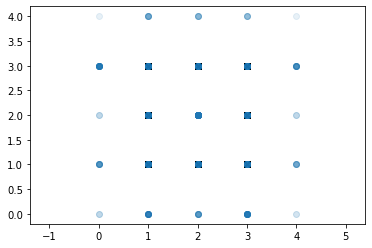

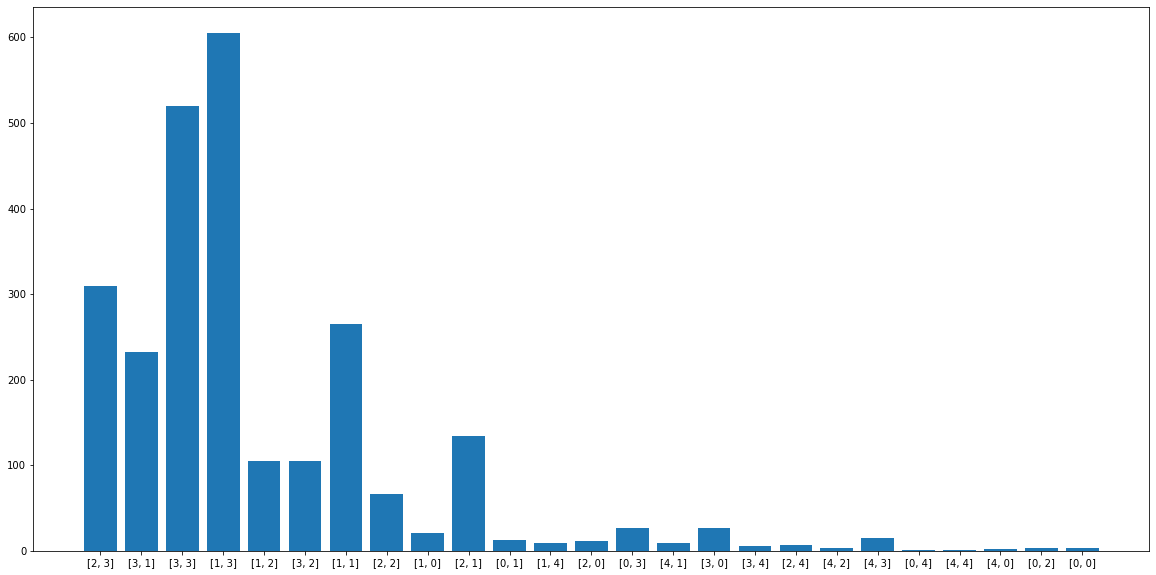

Processing Epoch 206
training start
Iteration 0, d real/fake loss 0.6740603446960449/0.6648233532905579 and g loss is 0.733452558517456, NDiv loss 0.09038646519184113
Iteration 1, d real/fake loss 0.674138605594635/0.6917886734008789 and g loss is 0.743853747844696, NDiv loss 0.09395921230316162
Iteration 2, d real/fake loss 0.6742068529129028/0.6518254280090332 and g loss is 0.7342196702957153, NDiv loss 0.09595359116792679
Iteration 3, d real/fake loss 0.674239993095398/0.708507776260376 and g loss is 0.7425551414489746, NDiv loss 0.08080638945102692
Iteration 4, d real/fake loss 0.6742913722991943/0.6617499589920044 and g loss is 0.7369067072868347, NDiv loss 0.09308972209692001


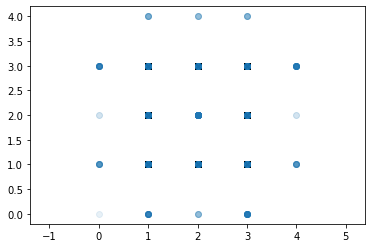

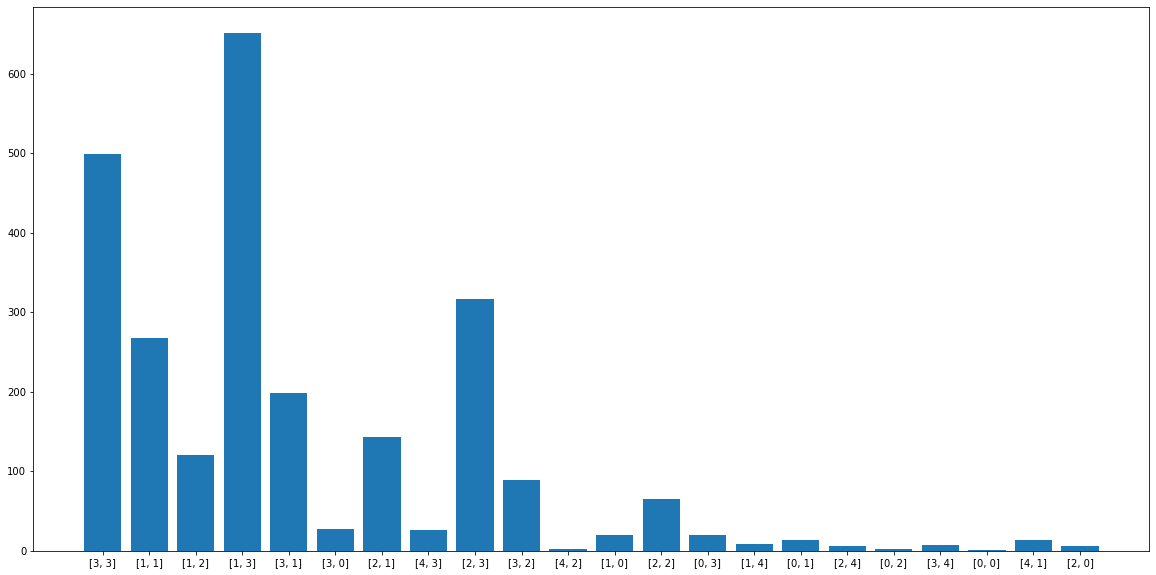

Processing Epoch 207
training start
Iteration 0, d real/fake loss 0.6474554538726807/0.6714857816696167 and g loss is 0.7297799587249756, NDiv loss 0.0901799127459526
Iteration 1, d real/fake loss 0.6475235223770142/0.6788543462753296 and g loss is 0.7121015787124634, NDiv loss 0.08887474238872528
Iteration 2, d real/fake loss 0.647596538066864/0.6688428521156311 and g loss is 0.7290172576904297, NDiv loss 0.09169167280197144
Iteration 3, d real/fake loss 0.6476549506187439/0.676425576210022 and g loss is 0.7184798717498779, NDiv loss 0.0808258056640625
Iteration 4, d real/fake loss 0.6477007865905762/0.6939944624900818 and g loss is 0.7043787240982056, NDiv loss 0.09809043258428574


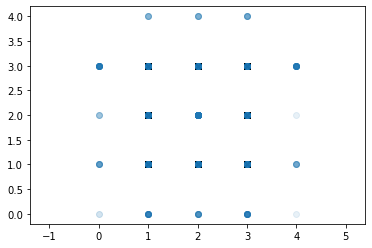

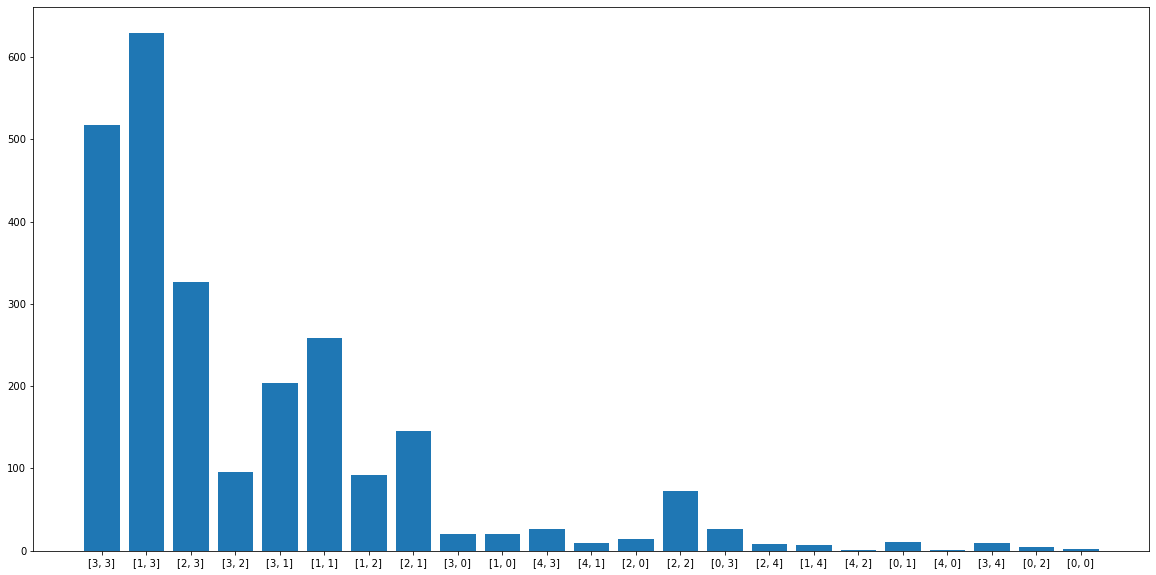

Processing Epoch 208
training start
Iteration 0, d real/fake loss 0.6414387822151184/0.6526938080787659 and g loss is 0.7343553304672241, NDiv loss 0.09025053679943085
Iteration 1, d real/fake loss 0.6414531469345093/0.6915457248687744 and g loss is 0.7252093553543091, NDiv loss 0.10458394140005112
Iteration 2, d real/fake loss 0.6414979696273804/0.6702011823654175 and g loss is 0.7423224449157715, NDiv loss 0.09490421414375305
Iteration 3, d real/fake loss 0.6415460109710693/0.6428360939025879 and g loss is 0.7364550828933716, NDiv loss 0.08505358546972275
Iteration 4, d real/fake loss 0.6415653228759766/0.6917049884796143 and g loss is 0.725864052772522, NDiv loss 0.09832535684108734


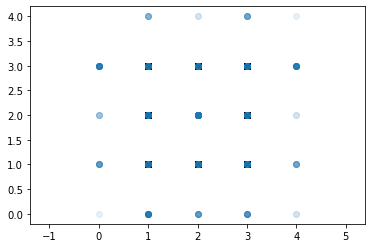

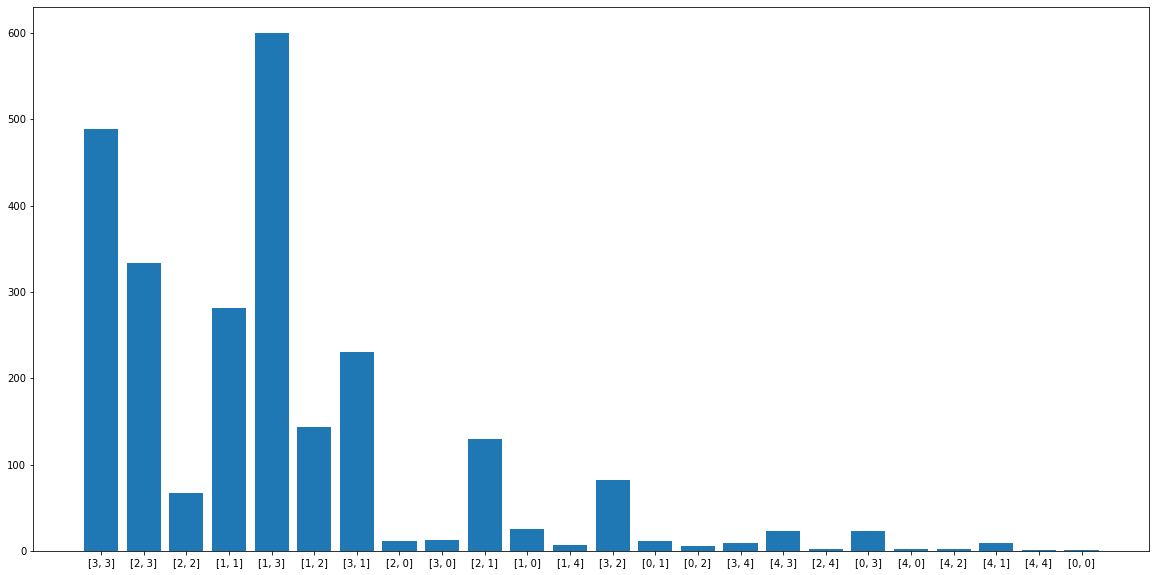

Processing Epoch 209
training start
Iteration 0, d real/fake loss 0.6430665254592896/0.6862056255340576 and g loss is 0.7260485887527466, NDiv loss 0.09812352061271667
Iteration 1, d real/fake loss 0.6431244015693665/0.6683266758918762 and g loss is 0.7368375062942505, NDiv loss 0.11269970238208771
Iteration 2, d real/fake loss 0.6431723833084106/0.6709656715393066 and g loss is 0.7371931076049805, NDiv loss 0.08314868062734604
Iteration 3, d real/fake loss 0.6432195901870728/0.669349193572998 and g loss is 0.7402502298355103, NDiv loss 0.0875978022813797
Iteration 4, d real/fake loss 0.6432735919952393/0.668888509273529 and g loss is 0.7303930521011353, NDiv loss 0.0974462702870369


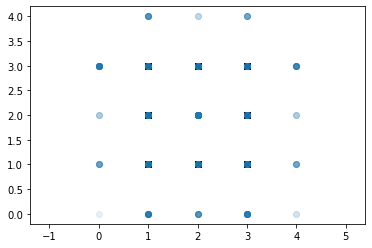

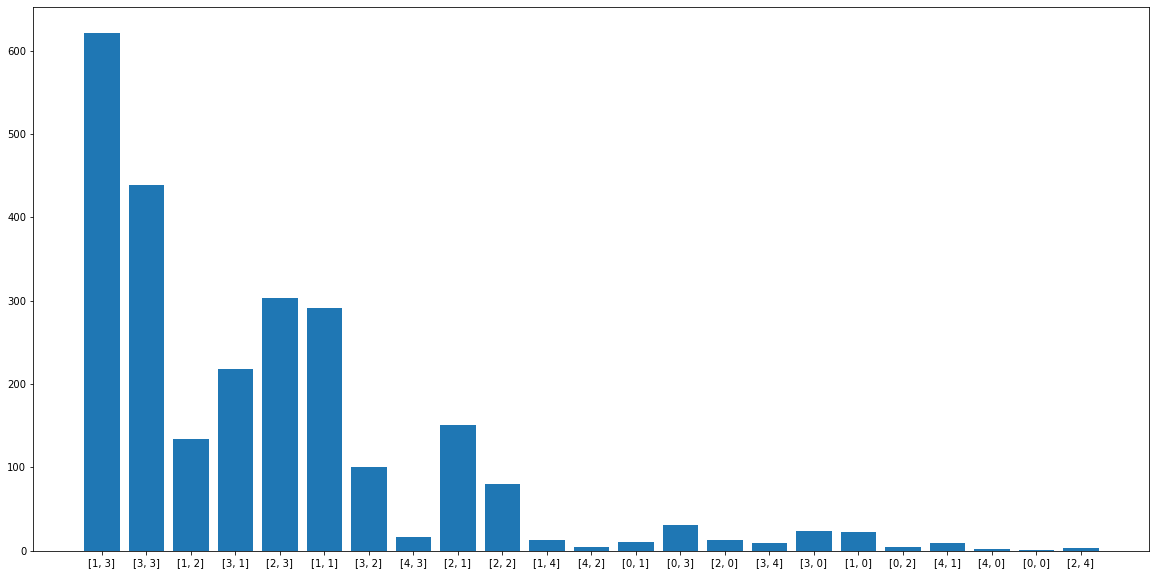

Processing Epoch 210
training start
Iteration 0, d real/fake loss 0.6628454327583313/0.7012666463851929 and g loss is 0.7323782444000244, NDiv loss 0.09285827726125717
Iteration 1, d real/fake loss 0.6629633903503418/0.6808722019195557 and g loss is 0.7215459942817688, NDiv loss 0.09191378206014633
Iteration 2, d real/fake loss 0.6630715131759644/0.6941870450973511 and g loss is 0.7248401641845703, NDiv loss 0.08453122526407242
Iteration 3, d real/fake loss 0.6631815433502197/0.6731834411621094 and g loss is 0.7201535701751709, NDiv loss 0.07809542864561081
Iteration 4, d real/fake loss 0.6632815599441528/0.6882776021957397 and g loss is 0.7266911268234253, NDiv loss 0.09568537771701813


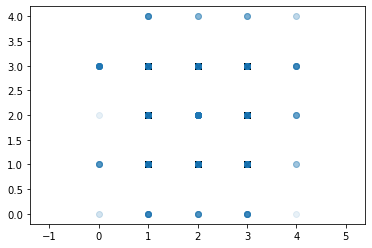

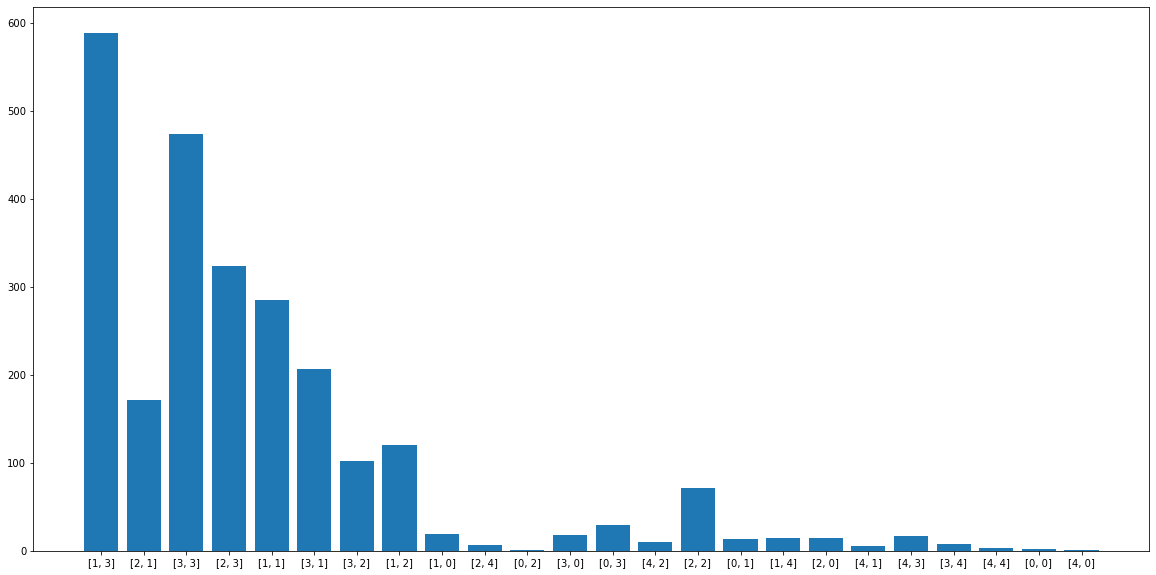

Processing Epoch 211
training start
Iteration 0, d real/fake loss 0.6540399193763733/0.6767801642417908 and g loss is 0.726129412651062, NDiv loss 0.09606590867042542
Iteration 1, d real/fake loss 0.6541749835014343/0.6718486547470093 and g loss is 0.7345560193061829, NDiv loss 0.08274126797914505
Iteration 2, d real/fake loss 0.6542999744415283/0.6851508617401123 and g loss is 0.7281160950660706, NDiv loss 0.08728814870119095
Iteration 3, d real/fake loss 0.6544307470321655/0.6785602569580078 and g loss is 0.7409865856170654, NDiv loss 0.08287271112203598
Iteration 4, d real/fake loss 0.6545568108558655/0.6705987453460693 and g loss is 0.708817720413208, NDiv loss 0.0954718142747879


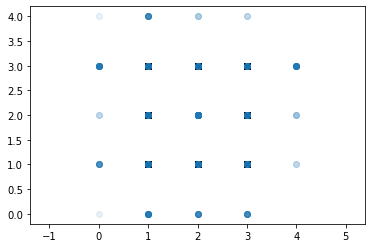

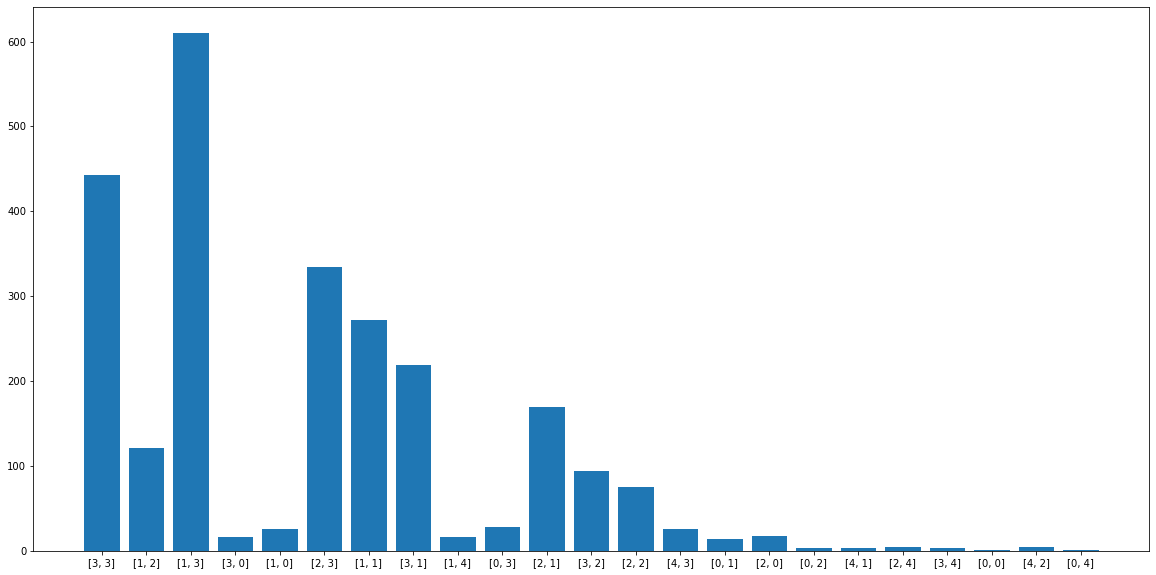

Processing Epoch 212
training start
Iteration 0, d real/fake loss 0.6683740615844727/0.6879233717918396 and g loss is 0.7375881671905518, NDiv loss 0.0861438736319542
Iteration 1, d real/fake loss 0.6684405207633972/0.6781654357910156 and g loss is 0.7513533234596252, NDiv loss 0.0959111824631691
Iteration 2, d real/fake loss 0.6684936285018921/0.6644028425216675 and g loss is 0.734241247177124, NDiv loss 0.09491605311632156
Iteration 3, d real/fake loss 0.6685174107551575/0.6847754716873169 and g loss is 0.7598058581352234, NDiv loss 0.08167896419763565
Iteration 4, d real/fake loss 0.6685359477996826/0.6614724397659302 and g loss is 0.7146862745285034, NDiv loss 0.08939166367053986


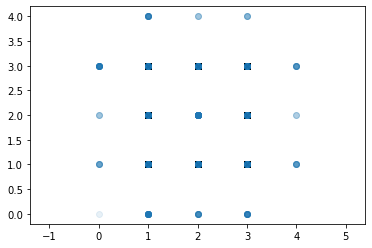

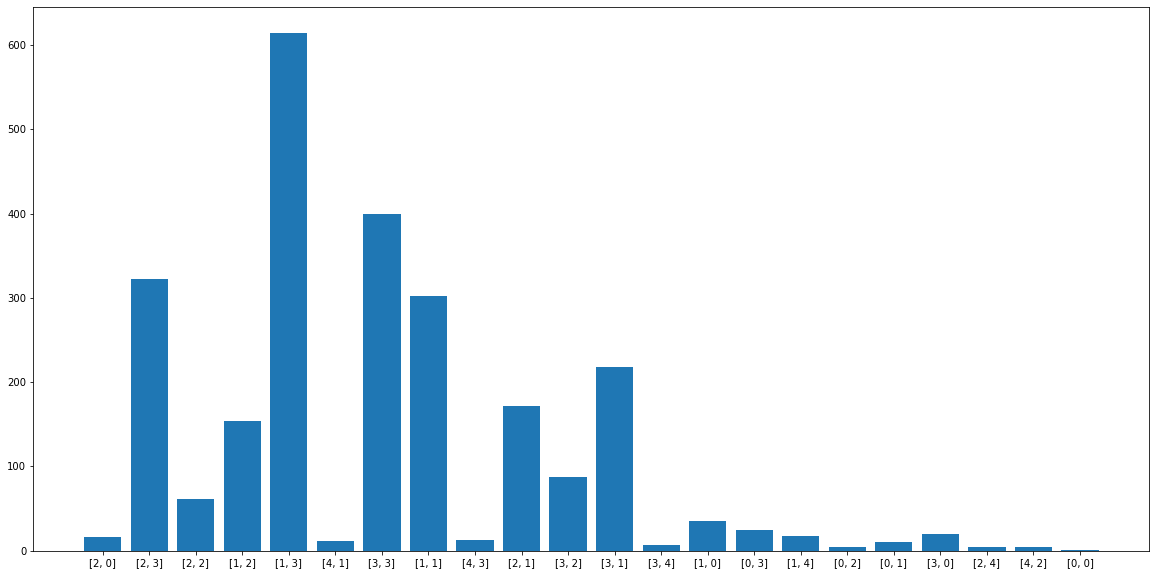

Processing Epoch 213
training start
Iteration 0, d real/fake loss 0.672395646572113/0.664932131767273 and g loss is 0.7401533126831055, NDiv loss 0.0974469929933548
Iteration 1, d real/fake loss 0.6724472045898438/0.6923620700836182 and g loss is 0.7129898071289062, NDiv loss 0.09258539974689484
Iteration 2, d real/fake loss 0.6724860668182373/0.6974115371704102 and g loss is 0.7383130788803101, NDiv loss 0.09436589479446411
Iteration 3, d real/fake loss 0.6725232601165771/0.6761982440948486 and g loss is 0.7561636567115784, NDiv loss 0.07832013070583344
Iteration 4, d real/fake loss 0.6725343465805054/0.6754413843154907 and g loss is 0.7322958707809448, NDiv loss 0.0966046005487442


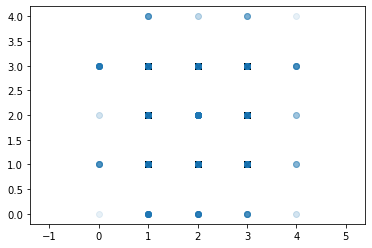

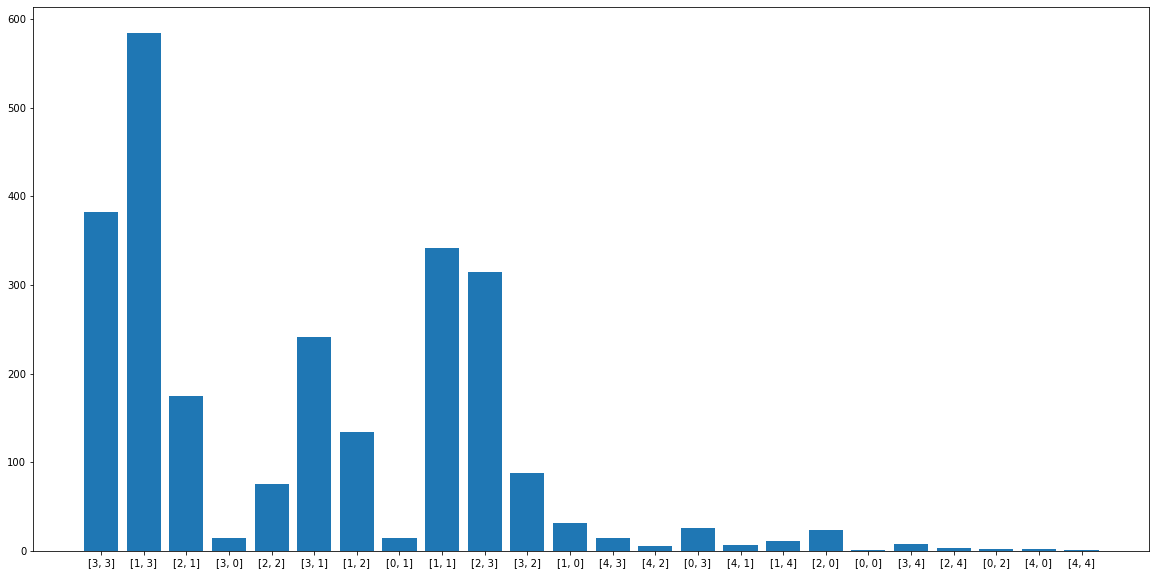

Processing Epoch 214
training start
Iteration 0, d real/fake loss 0.6444251537322998/0.6861436367034912 and g loss is 0.7095874547958374, NDiv loss 0.08345881849527359
Iteration 1, d real/fake loss 0.6444916725158691/0.6770449876785278 and g loss is 0.7347849011421204, NDiv loss 0.0937410444021225
Iteration 2, d real/fake loss 0.6445603370666504/0.6903412938117981 and g loss is 0.7321394085884094, NDiv loss 0.09660405665636063
Iteration 3, d real/fake loss 0.6446436643600464/0.6775619387626648 and g loss is 0.7202527523040771, NDiv loss 0.0738336592912674
Iteration 4, d real/fake loss 0.6447353959083557/0.6749120950698853 and g loss is 0.7034912109375, NDiv loss 0.08406054973602295


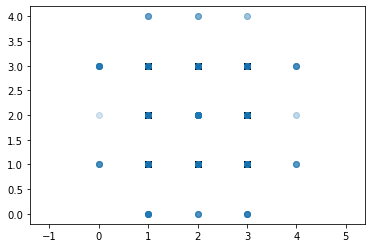

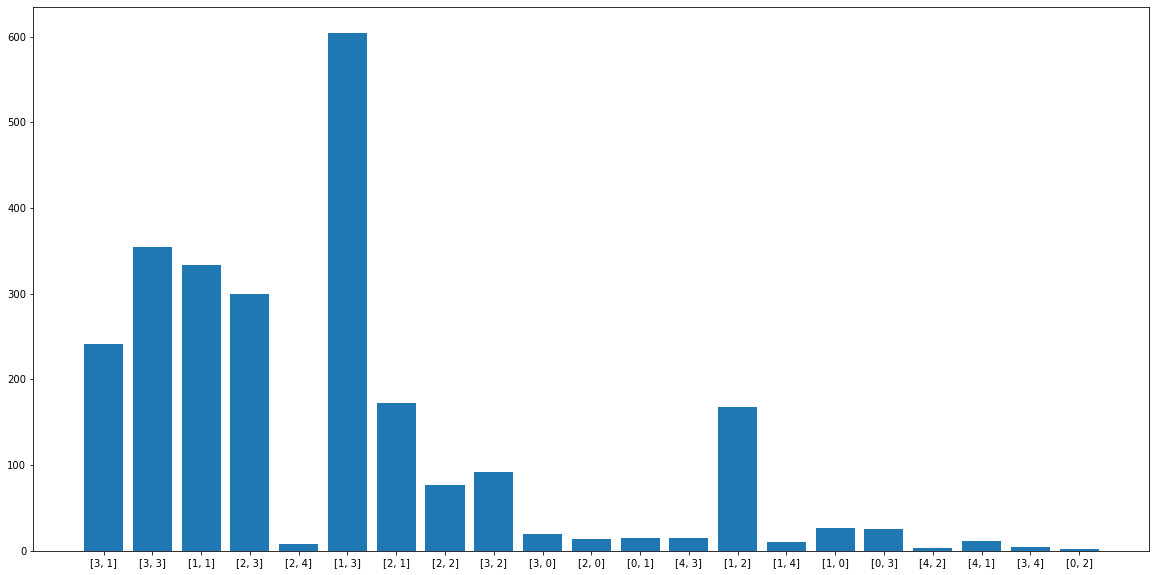

Processing Epoch 215
training start
Iteration 0, d real/fake loss 0.6538639068603516/0.6686645746231079 and g loss is 0.7155591249465942, NDiv loss 0.08711224049329758
Iteration 1, d real/fake loss 0.6539404392242432/0.6782445907592773 and g loss is 0.7508159875869751, NDiv loss 0.08699912577867508
Iteration 2, d real/fake loss 0.6540219783782959/0.6748419404029846 and g loss is 0.7061676383018494, NDiv loss 0.08743677288293839
Iteration 3, d real/fake loss 0.65410315990448/0.6876227855682373 and g loss is 0.6984055042266846, NDiv loss 0.08520005643367767
Iteration 4, d real/fake loss 0.6541924476623535/0.6921041011810303 and g loss is 0.727588415145874, NDiv loss 0.07625073194503784


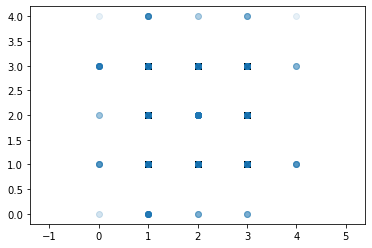

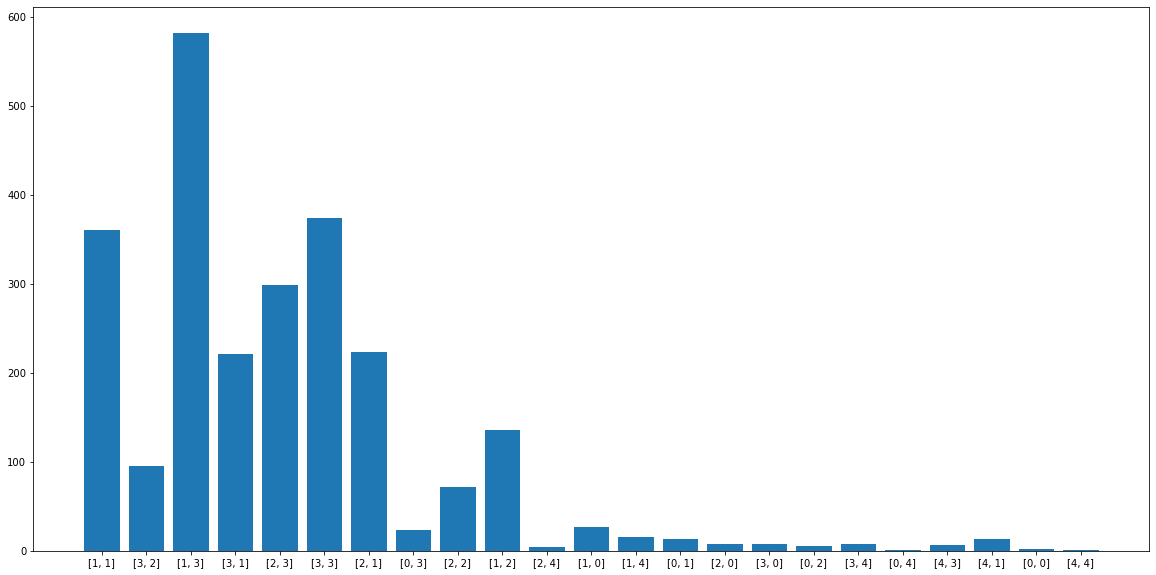

Processing Epoch 216
training start
Iteration 0, d real/fake loss 0.6622122526168823/0.6699162721633911 and g loss is 0.7238550186157227, NDiv loss 0.09476933628320694
Iteration 1, d real/fake loss 0.6623082160949707/0.6792532205581665 and g loss is 0.72246253490448, NDiv loss 0.0839516893029213
Iteration 2, d real/fake loss 0.6623980402946472/0.6937739253044128 and g loss is 0.7282375693321228, NDiv loss 0.07906142622232437
Iteration 3, d real/fake loss 0.6624947190284729/0.6823878288269043 and g loss is 0.7276635766029358, NDiv loss 0.07491191476583481
Iteration 4, d real/fake loss 0.6625893712043762/0.6770617961883545 and g loss is 0.7216527462005615, NDiv loss 0.09830440580844879


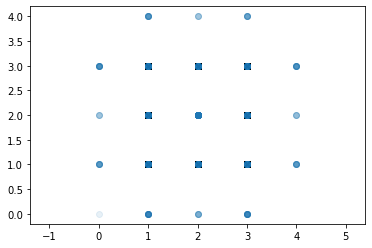

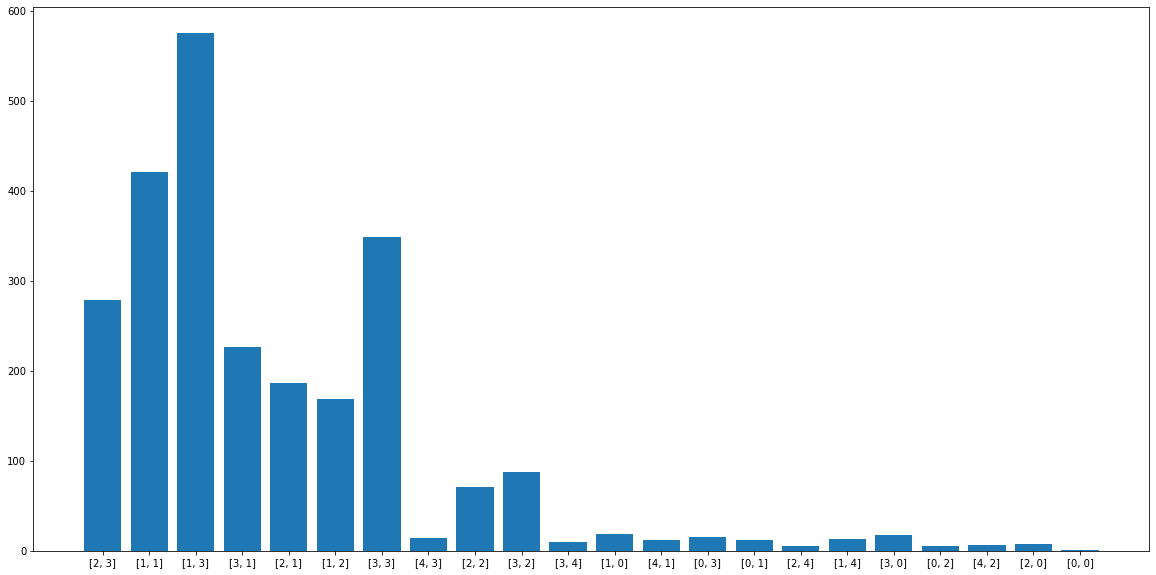

Processing Epoch 217
training start
Iteration 0, d real/fake loss 0.6506133079528809/0.6908803582191467 and g loss is 0.7058195471763611, NDiv loss 0.09051667898893356
Iteration 1, d real/fake loss 0.6507237553596497/0.6853935718536377 and g loss is 0.7285746335983276, NDiv loss 0.07789255678653717
Iteration 2, d real/fake loss 0.6508393287658691/0.6773644685745239 and g loss is 0.7492229342460632, NDiv loss 0.07374005764722824
Iteration 3, d real/fake loss 0.6509577631950378/0.6925569772720337 and g loss is 0.7111974954605103, NDiv loss 0.07218540459871292
Iteration 4, d real/fake loss 0.6510924100875854/0.6881198883056641 and g loss is 0.732757031917572, NDiv loss 0.08825653791427612


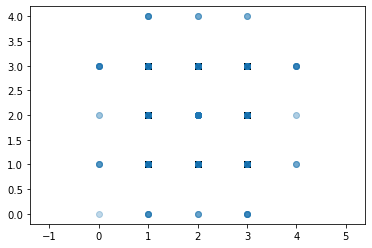

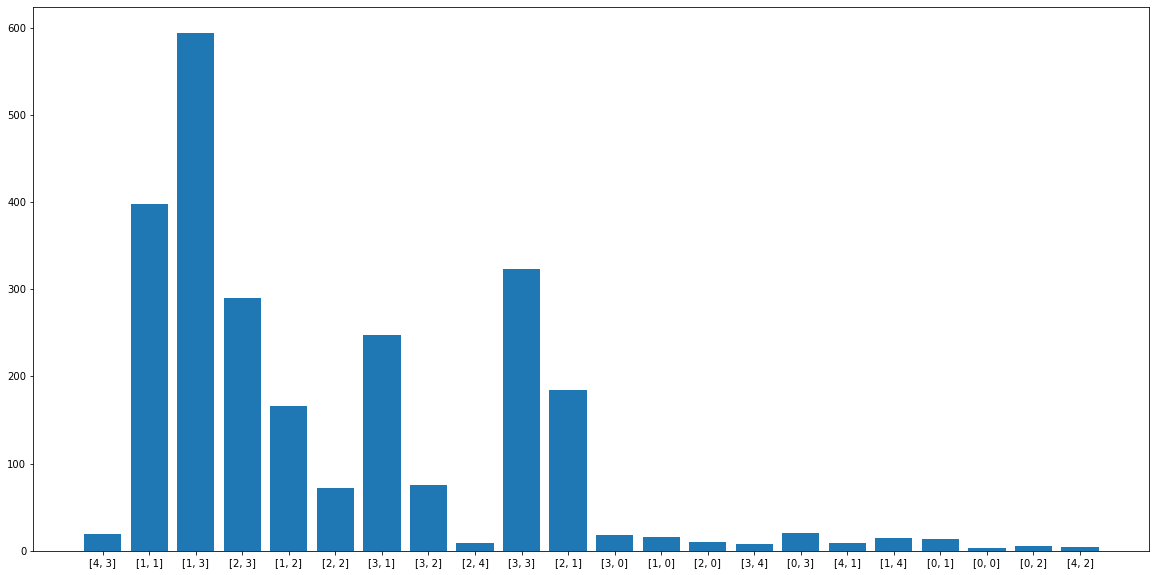

Processing Epoch 218
training start
Iteration 0, d real/fake loss 0.6271172761917114/0.6766135692596436 and g loss is 0.7311735153198242, NDiv loss 0.07993555068969727
Iteration 1, d real/fake loss 0.6271868944168091/0.6831413507461548 and g loss is 0.6928063035011292, NDiv loss 0.08185257017612457
Iteration 2, d real/fake loss 0.6272679567337036/0.6669321060180664 and g loss is 0.7284862995147705, NDiv loss 0.08003491908311844
Iteration 3, d real/fake loss 0.6273355484008789/0.6813067197799683 and g loss is 0.7207760810852051, NDiv loss 0.08513077348470688
Iteration 4, d real/fake loss 0.627414345741272/0.7012051343917847 and g loss is 0.7101449966430664, NDiv loss 0.07469360530376434


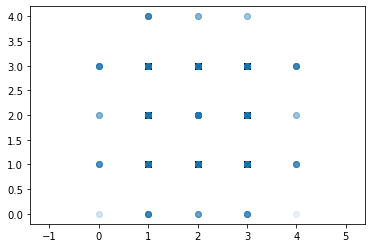

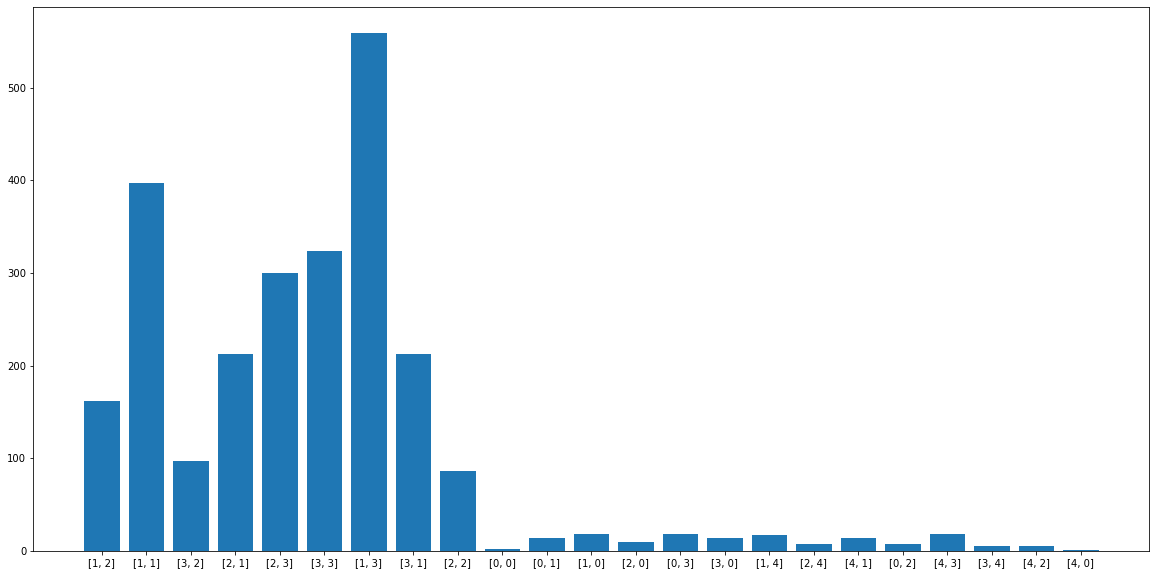

Processing Epoch 219
training start
Iteration 0, d real/fake loss 0.6723620891571045/0.6999022364616394 and g loss is 0.7028636336326599, NDiv loss 0.08403754979372025
Iteration 1, d real/fake loss 0.6725848317146301/0.712681233882904 and g loss is 0.7268286943435669, NDiv loss 0.09267003834247589
Iteration 2, d real/fake loss 0.6727981567382812/0.7107074856758118 and g loss is 0.7030746340751648, NDiv loss 0.08674253523349762
Iteration 3, d real/fake loss 0.6730111837387085/0.6840074062347412 and g loss is 0.7147288918495178, NDiv loss 0.07661224156618118
Iteration 4, d real/fake loss 0.6731874942779541/0.7019047737121582 and g loss is 0.724925696849823, NDiv loss 0.08286098390817642


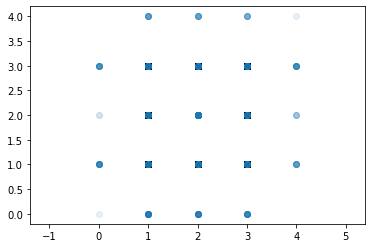

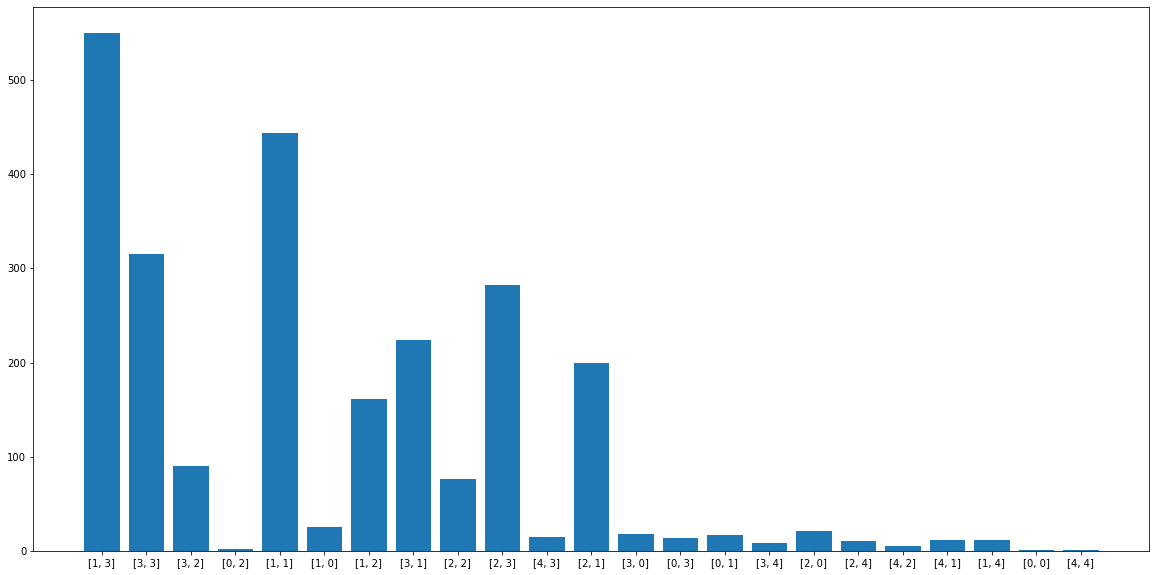

Processing Epoch 220
training start
Iteration 0, d real/fake loss 0.6731734275817871/0.6900714635848999 and g loss is 0.7270011305809021, NDiv loss 0.0943450927734375
Iteration 1, d real/fake loss 0.6733546853065491/0.6862603425979614 and g loss is 0.717021107673645, NDiv loss 0.09936230629682541
Iteration 2, d real/fake loss 0.6735178828239441/0.6845366954803467 and g loss is 0.7013736367225647, NDiv loss 0.08789996802806854
Iteration 3, d real/fake loss 0.6736598014831543/0.7028388977050781 and g loss is 0.7254256010055542, NDiv loss 0.08638909459114075
Iteration 4, d real/fake loss 0.6737959384918213/0.7010807394981384 and g loss is 0.7336961030960083, NDiv loss 0.08052485436201096


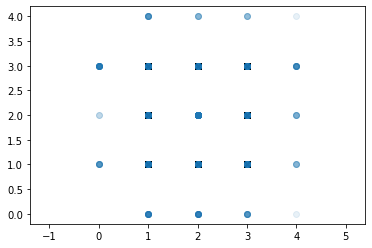

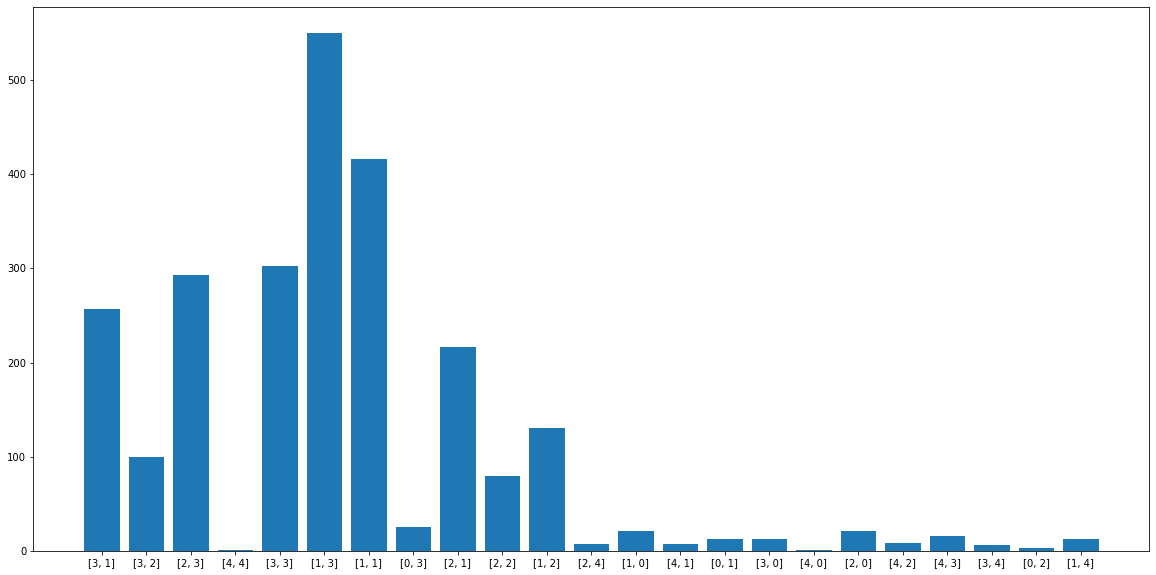

Processing Epoch 221
training start
Iteration 0, d real/fake loss 0.6575322151184082/0.6716820001602173 and g loss is 0.7369052767753601, NDiv loss 0.08526573330163956
Iteration 1, d real/fake loss 0.65772545337677/0.7186663746833801 and g loss is 0.7327125668525696, NDiv loss 0.08259478956460953
Iteration 2, d real/fake loss 0.6579471826553345/0.6745656728744507 and g loss is 0.7004488706588745, NDiv loss 0.08854679018259048
Iteration 3, d real/fake loss 0.6581476926803589/0.6759048700332642 and g loss is 0.707231342792511, NDiv loss 0.0861864909529686
Iteration 4, d real/fake loss 0.6583302617073059/0.686111330986023 and g loss is 0.7057956457138062, NDiv loss 0.08804412186145782


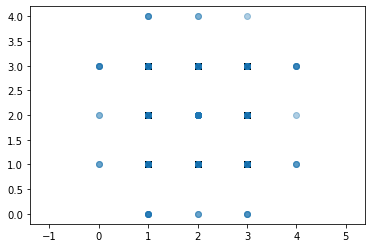

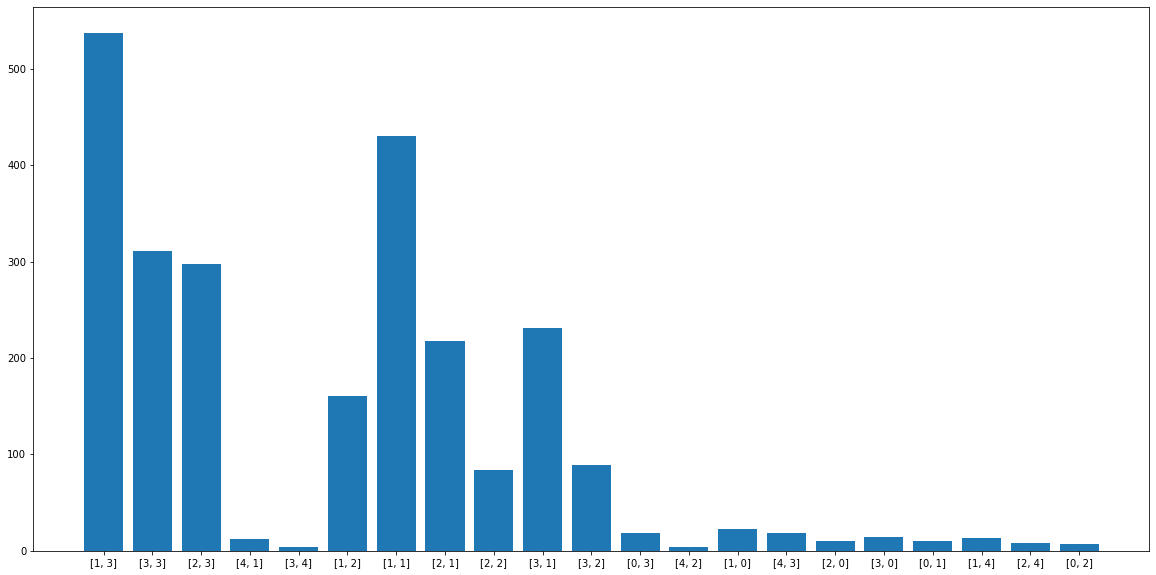

Processing Epoch 222
training start
Iteration 0, d real/fake loss 0.6495509147644043/0.6897874474525452 and g loss is 0.7228108644485474, NDiv loss 0.07441221922636032
Iteration 1, d real/fake loss 0.649663507938385/0.7002180218696594 and g loss is 0.7308012843132019, NDiv loss 0.08308452367782593
Iteration 2, d real/fake loss 0.649782657623291/0.6672935485839844 and g loss is 0.705418586730957, NDiv loss 0.07664690166711807
Iteration 3, d real/fake loss 0.6498743295669556/0.6725247502326965 and g loss is 0.7156950235366821, NDiv loss 0.0927240177989006
Iteration 4, d real/fake loss 0.649952232837677/0.6899591684341431 and g loss is 0.7183537483215332, NDiv loss 0.07915979623794556


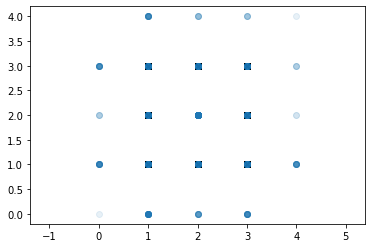

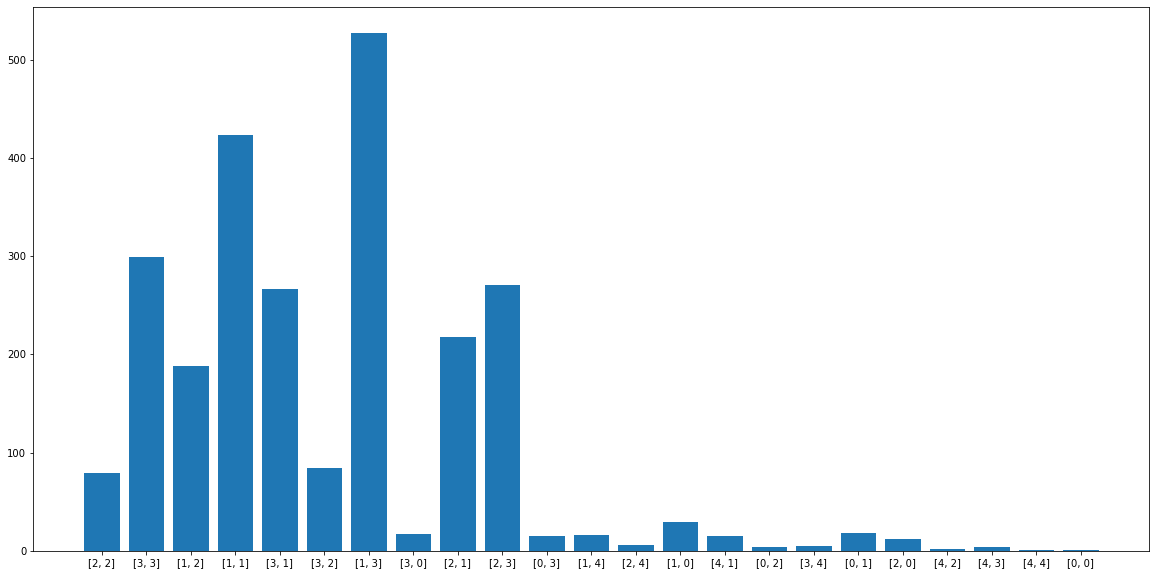

Processing Epoch 223
training start
Iteration 0, d real/fake loss 0.6719847321510315/0.6860514879226685 and g loss is 0.7045528888702393, NDiv loss 0.09794845432043076
Iteration 1, d real/fake loss 0.6720740795135498/0.6753095388412476 and g loss is 0.7054003477096558, NDiv loss 0.07565541565418243
Iteration 2, d real/fake loss 0.672137975692749/0.7048921585083008 and g loss is 0.7024595737457275, NDiv loss 0.08972309529781342
Iteration 3, d real/fake loss 0.6722033619880676/0.7326126098632812 and g loss is 0.7352240085601807, NDiv loss 0.08464951068162918
Iteration 4, d real/fake loss 0.6722944974899292/0.6923364996910095 and g loss is 0.6959777474403381, NDiv loss 0.09091611206531525


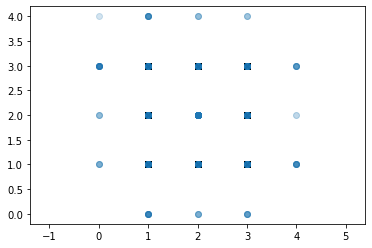

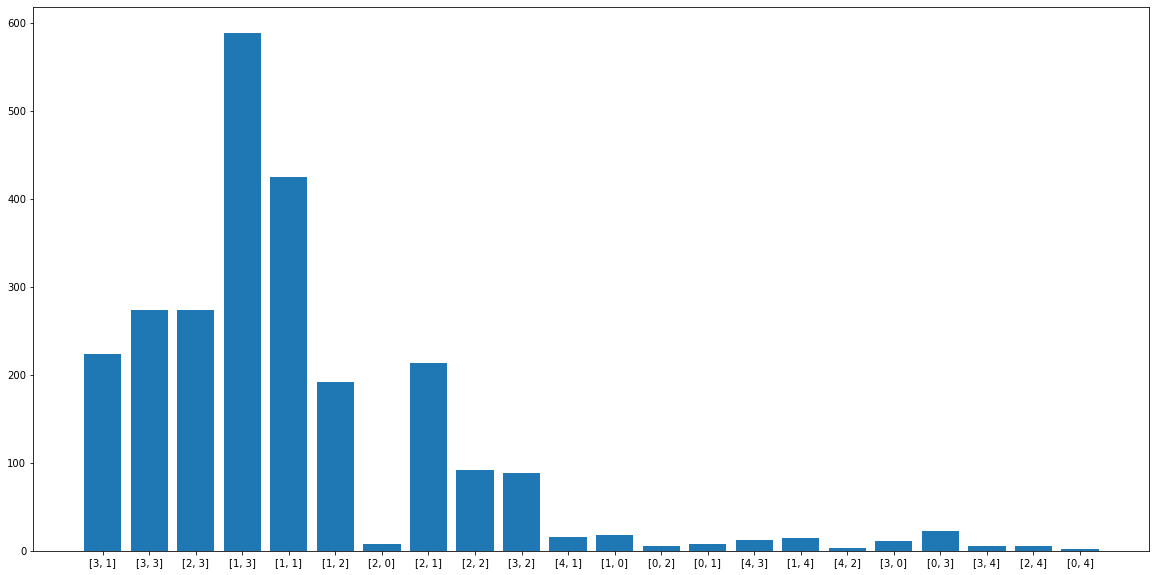

Processing Epoch 224
training start
Iteration 0, d real/fake loss 0.6592596769332886/0.6939507722854614 and g loss is 0.7049360275268555, NDiv loss 0.08868677169084549
Iteration 1, d real/fake loss 0.6593866944313049/0.72382652759552 and g loss is 0.7199717164039612, NDiv loss 0.08071405440568924
Iteration 2, d real/fake loss 0.6595430374145508/0.6732851266860962 and g loss is 0.7300301790237427, NDiv loss 0.06513082981109619
Iteration 3, d real/fake loss 0.6596882939338684/0.703989565372467 and g loss is 0.7165532112121582, NDiv loss 0.0840594545006752
Iteration 4, d real/fake loss 0.6598454117774963/0.706303596496582 and g loss is 0.6866073608398438, NDiv loss 0.08382345736026764


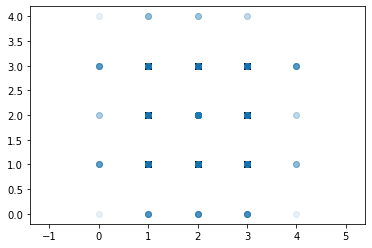

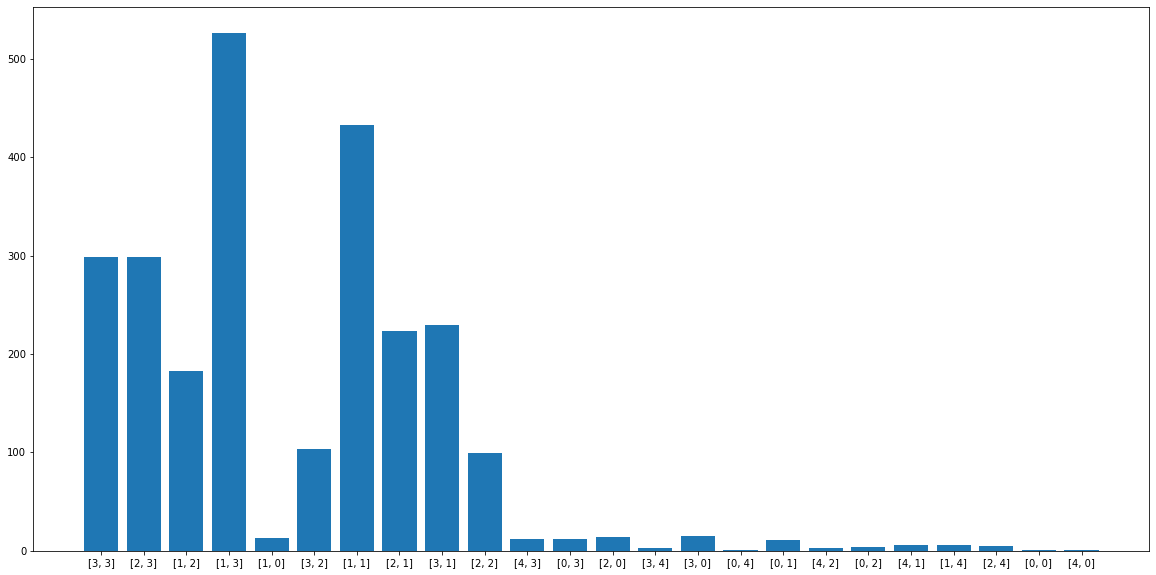

Processing Epoch 225
training start
Iteration 0, d real/fake loss 0.6560965776443481/0.6972170472145081 and g loss is 0.725949764251709, NDiv loss 0.07565067708492279
Iteration 1, d real/fake loss 0.6563449501991272/0.6929876804351807 and g loss is 0.7217973470687866, NDiv loss 0.08198563754558563
Iteration 2, d real/fake loss 0.6565872430801392/0.6858873963356018 and g loss is 0.6953994035720825, NDiv loss 0.08621809631586075
Iteration 3, d real/fake loss 0.6568247079849243/0.7073103189468384 and g loss is 0.7164270281791687, NDiv loss 0.07544754445552826
Iteration 4, d real/fake loss 0.6570783853530884/0.6638877391815186 and g loss is 0.6976733207702637, NDiv loss 0.08580533415079117


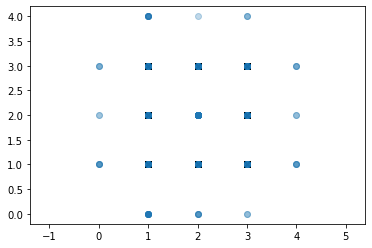

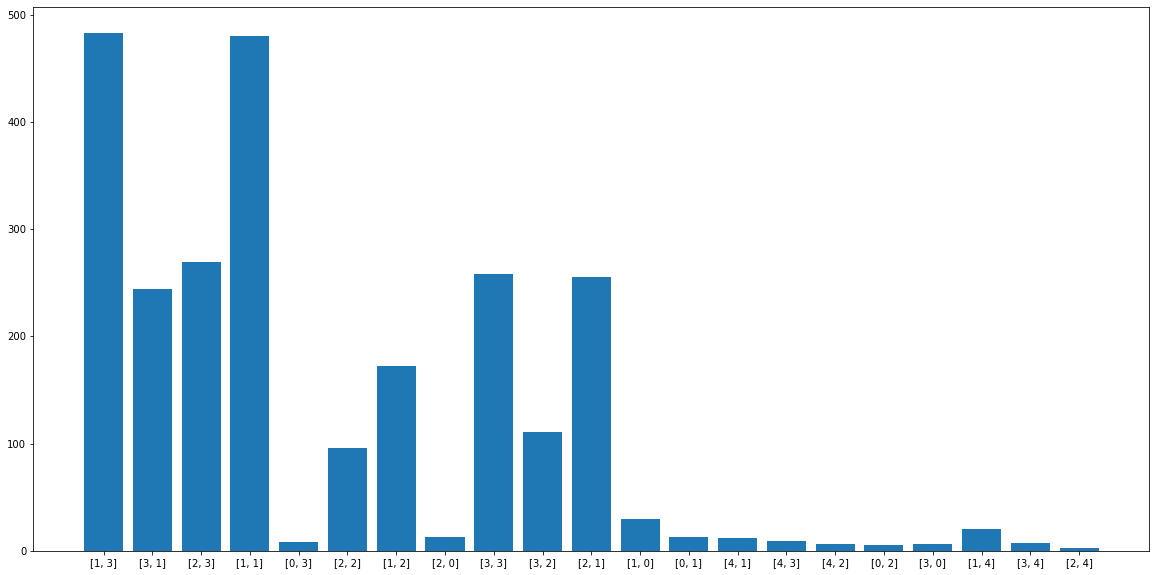

Processing Epoch 226
training start
Iteration 0, d real/fake loss 0.6652244329452515/0.6872063279151917 and g loss is 0.7174198031425476, NDiv loss 0.07586639374494553
Iteration 1, d real/fake loss 0.6654136776924133/0.7245766520500183 and g loss is 0.7141826152801514, NDiv loss 0.08222799748182297
Iteration 2, d real/fake loss 0.6656299829483032/0.6914165019989014 and g loss is 0.7143794298171997, NDiv loss 0.09026222676038742
Iteration 3, d real/fake loss 0.6658371686935425/0.7036447525024414 and g loss is 0.6959437727928162, NDiv loss 0.0757087916135788
Iteration 4, d real/fake loss 0.6660500764846802/0.6904492378234863 and g loss is 0.7169581651687622, NDiv loss 0.08014059066772461


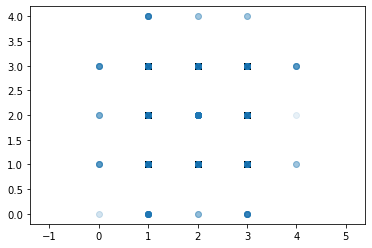

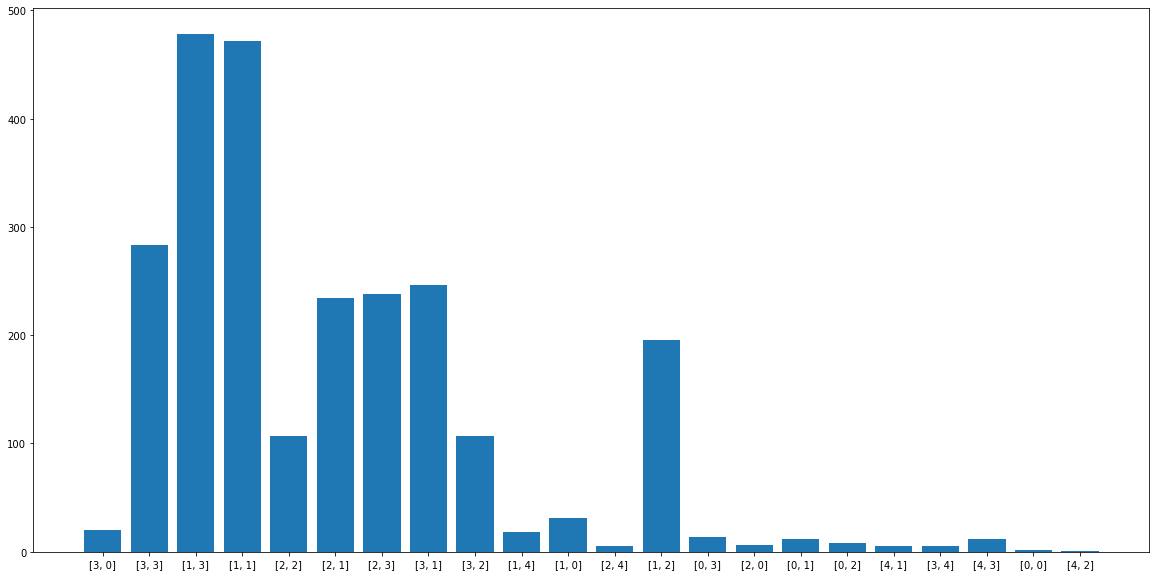

Processing Epoch 227
training start
Iteration 0, d real/fake loss 0.6573561429977417/0.7008535861968994 and g loss is 0.7226860523223877, NDiv loss 0.07969611883163452
Iteration 1, d real/fake loss 0.6576040983200073/0.69338458776474 and g loss is 0.7243474721908569, NDiv loss 0.07938749343156815
Iteration 2, d real/fake loss 0.6578423976898193/0.7047172784805298 and g loss is 0.6947223544120789, NDiv loss 0.07560960203409195
Iteration 3, d real/fake loss 0.6580896377563477/0.6851223707199097 and g loss is 0.7102077007293701, NDiv loss 0.08377058804035187
Iteration 4, d real/fake loss 0.6583248376846313/0.6877634525299072 and g loss is 0.7034376263618469, NDiv loss 0.08453549444675446


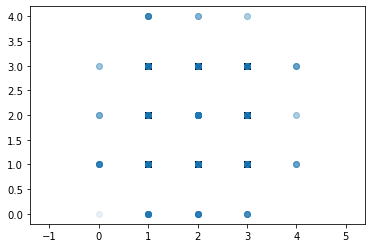

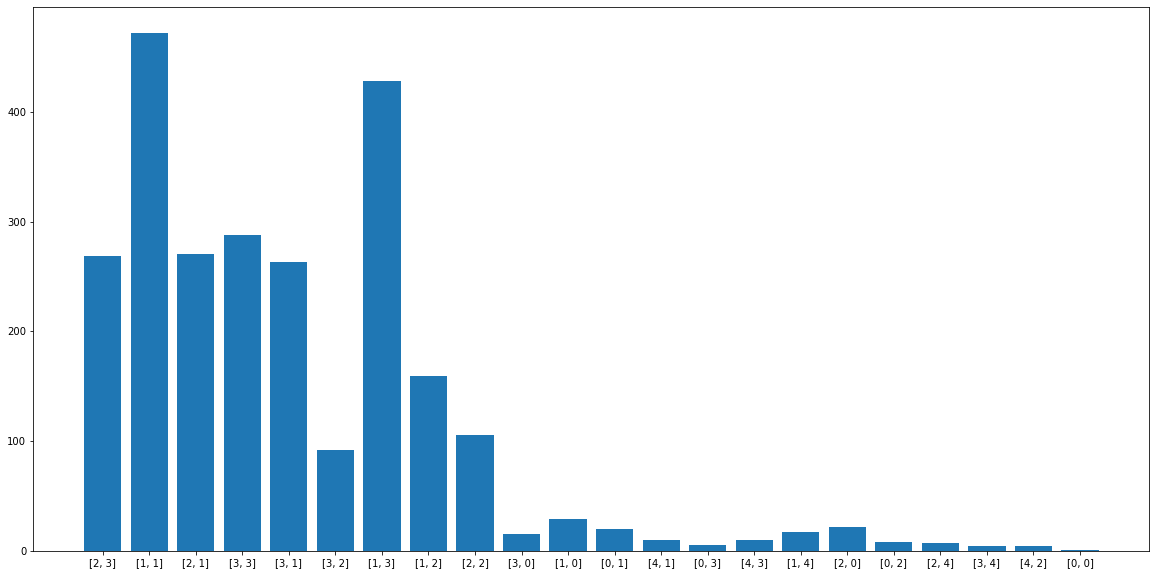

Processing Epoch 228
training start
Iteration 0, d real/fake loss 0.6659784317016602/0.6743336915969849 and g loss is 0.6988072395324707, NDiv loss 0.08572684973478317
Iteration 1, d real/fake loss 0.6662079095840454/0.6948492527008057 and g loss is 0.7103509306907654, NDiv loss 0.06855576485395432
Iteration 2, d real/fake loss 0.6664307117462158/0.7076393365859985 and g loss is 0.6922208070755005, NDiv loss 0.07540222257375717
Iteration 3, d real/fake loss 0.6666593551635742/0.6898514032363892 and g loss is 0.6978068351745605, NDiv loss 0.07522004842758179
Iteration 4, d real/fake loss 0.6668780446052551/0.6884300708770752 and g loss is 0.7211471796035767, NDiv loss 0.08017786592245102


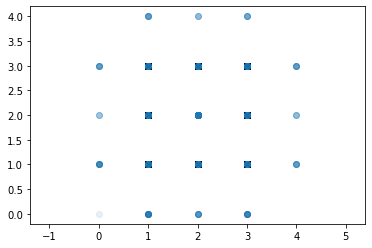

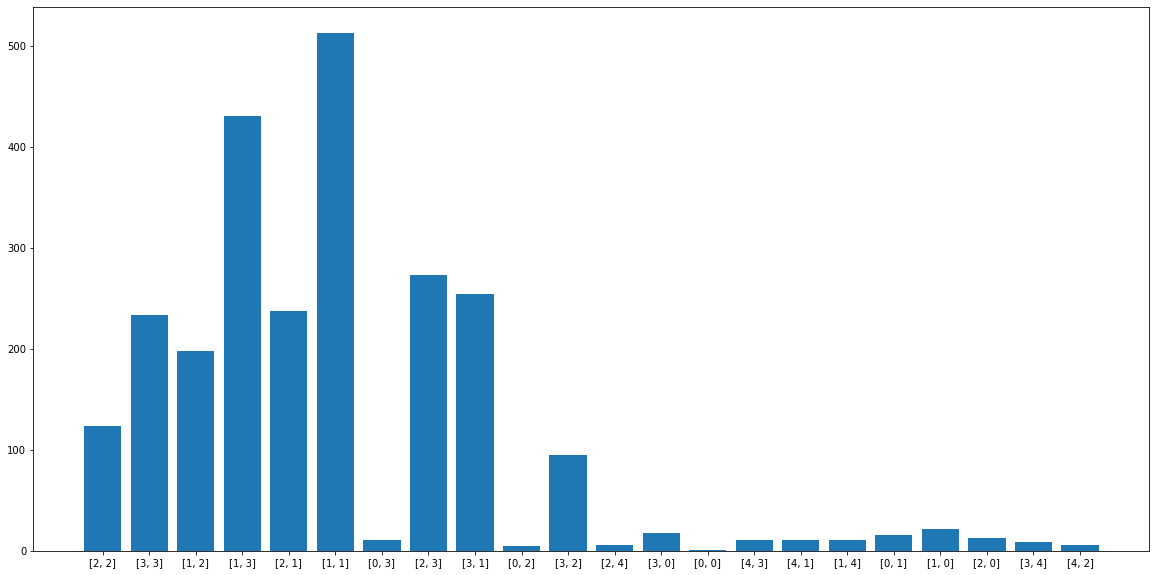

Processing Epoch 229
training start
Iteration 0, d real/fake loss 0.6897532343864441/0.678502082824707 and g loss is 0.7006233930587769, NDiv loss 0.07875575870275497
Iteration 1, d real/fake loss 0.6898767352104187/0.6778111457824707 and g loss is 0.7271546125411987, NDiv loss 0.08329761773347855
Iteration 2, d real/fake loss 0.6899594068527222/0.6776825189590454 and g loss is 0.6874352693557739, NDiv loss 0.07632073014974594
Iteration 3, d real/fake loss 0.6899961233139038/0.6978464126586914 and g loss is 0.691110372543335, NDiv loss 0.07601963728666306
Iteration 4, d real/fake loss 0.6900163888931274/0.6974804401397705 and g loss is 0.6776515245437622, NDiv loss 0.08025814592838287


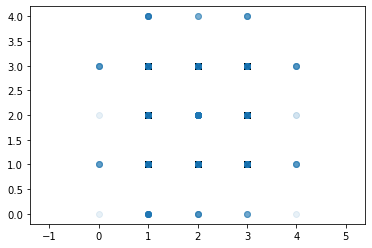

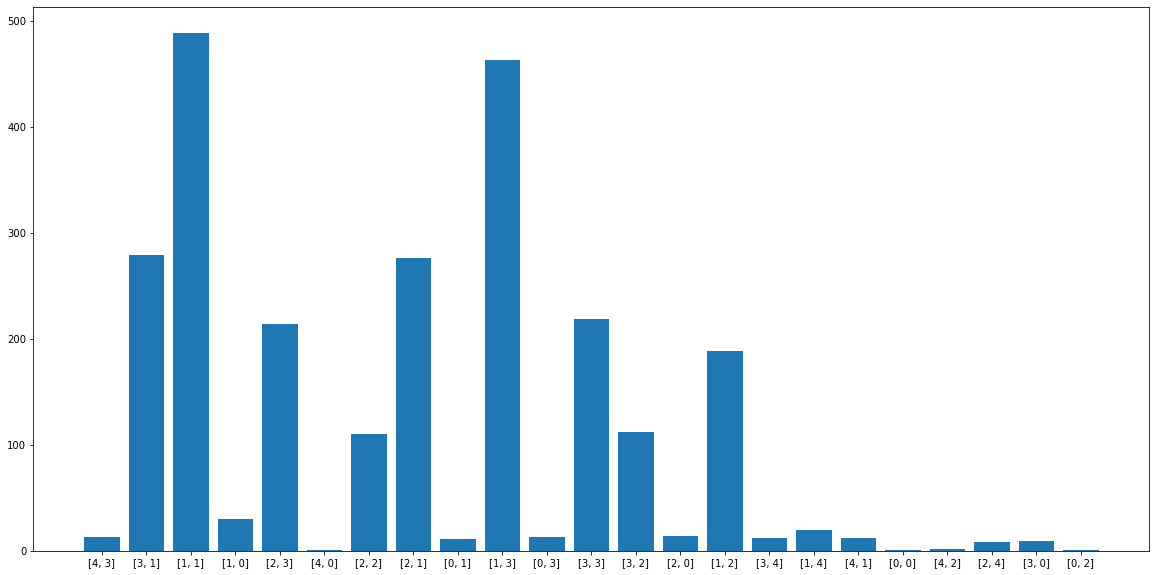

Processing Epoch 230
training start
Iteration 0, d real/fake loss 0.6565072536468506/0.7209230661392212 and g loss is 0.7160603404045105, NDiv loss 0.07962319254875183
Iteration 1, d real/fake loss 0.6566146016120911/0.6958829164505005 and g loss is 0.7011923789978027, NDiv loss 0.07644352316856384
Iteration 2, d real/fake loss 0.656730055809021/0.706228494644165 and g loss is 0.7306962609291077, NDiv loss 0.07810496538877487
Iteration 3, d real/fake loss 0.6568673849105835/0.685339093208313 and g loss is 0.6986919641494751, NDiv loss 0.0780218243598938
Iteration 4, d real/fake loss 0.6570054292678833/0.6824787855148315 and g loss is 0.7199161648750305, NDiv loss 0.07910279929637909


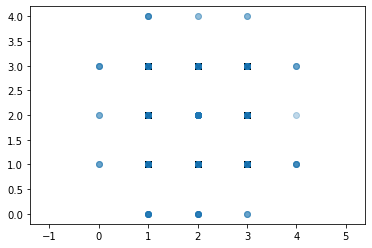

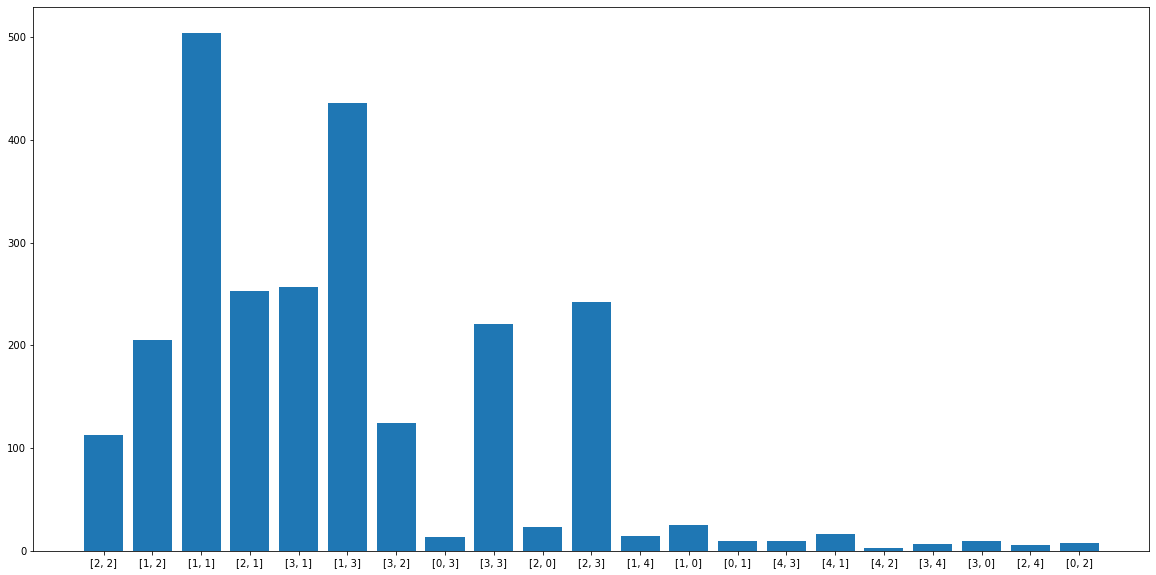

Processing Epoch 231
training start
Iteration 0, d real/fake loss 0.6581515073776245/0.6972700953483582 and g loss is 0.6931501626968384, NDiv loss 0.07156214863061905
Iteration 1, d real/fake loss 0.6582927703857422/0.7037222385406494 and g loss is 0.7003108263015747, NDiv loss 0.08292991667985916
Iteration 2, d real/fake loss 0.658451497554779/0.7008407115936279 and g loss is 0.6992552876472473, NDiv loss 0.07007471472024918
Iteration 3, d real/fake loss 0.6586207151412964/0.7020624876022339 and g loss is 0.700534999370575, NDiv loss 0.08399617671966553
Iteration 4, d real/fake loss 0.6587971448898315/0.705387532711029 and g loss is 0.6889070272445679, NDiv loss 0.07965503633022308


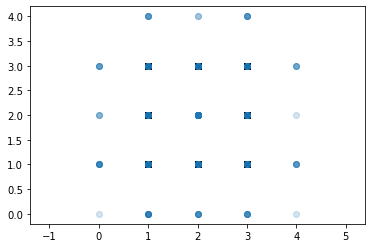

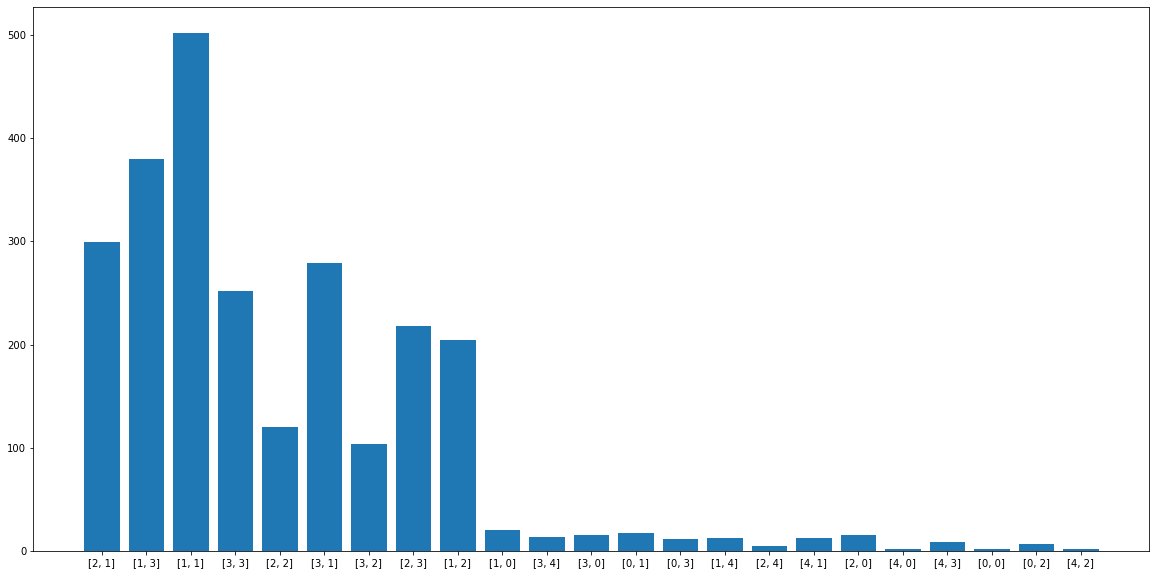

Processing Epoch 232
training start
Iteration 0, d real/fake loss 0.6365771889686584/0.6976025104522705 and g loss is 0.726006805896759, NDiv loss 0.07171723246574402
Iteration 1, d real/fake loss 0.6369225382804871/0.7194254994392395 and g loss is 0.7006523609161377, NDiv loss 0.0857941135764122
Iteration 2, d real/fake loss 0.6372985243797302/0.697235643863678 and g loss is 0.7453199625015259, NDiv loss 0.06500236690044403
Iteration 3, d real/fake loss 0.6376703381538391/0.7225821614265442 and g loss is 0.6907093524932861, NDiv loss 0.0819113478064537
Iteration 4, d real/fake loss 0.6380765438079834/0.7072122097015381 and g loss is 0.6925874948501587, NDiv loss 0.07911740988492966


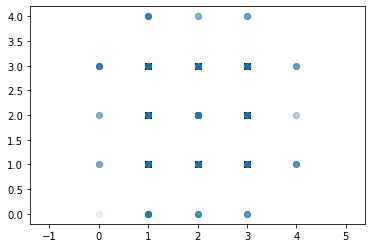

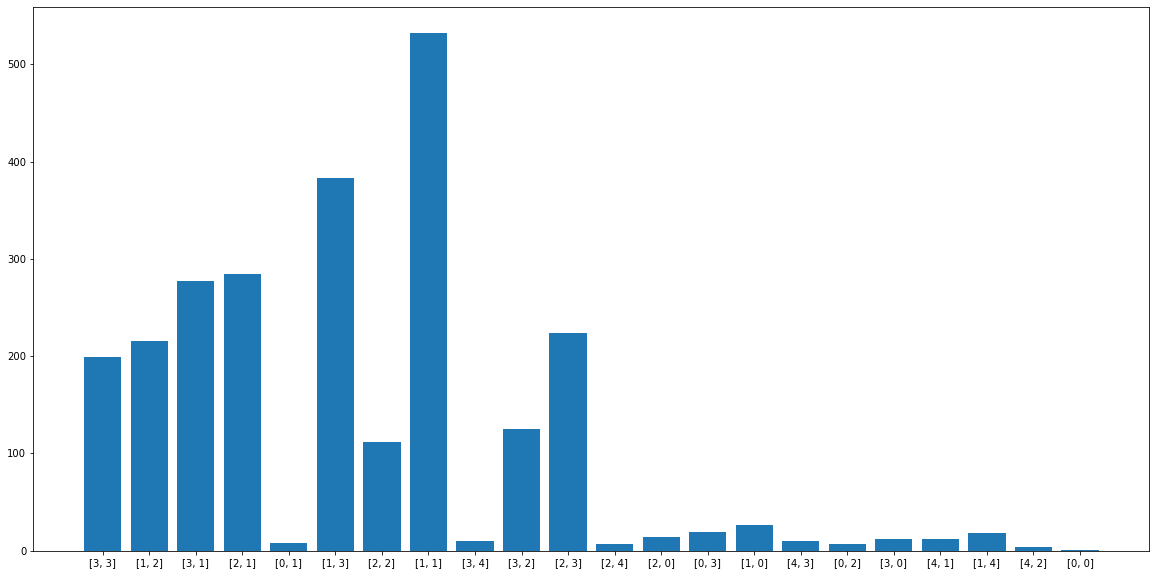

Processing Epoch 233
training start
Iteration 0, d real/fake loss 0.6809546947479248/0.7165162563323975 and g loss is 0.6998898386955261, NDiv loss 0.08122337609529495
Iteration 1, d real/fake loss 0.6813401579856873/0.7021645307540894 and g loss is 0.6935110092163086, NDiv loss 0.06799156218767166
Iteration 2, d real/fake loss 0.6816993951797485/0.7056049704551697 and g loss is 0.7028624415397644, NDiv loss 0.08224008977413177
Iteration 3, d real/fake loss 0.6820213794708252/0.712841808795929 and g loss is 0.709366500377655, NDiv loss 0.07949257642030716
Iteration 4, d real/fake loss 0.6823304891586304/0.7242256999015808 and g loss is 0.6916038990020752, NDiv loss 0.07814523577690125


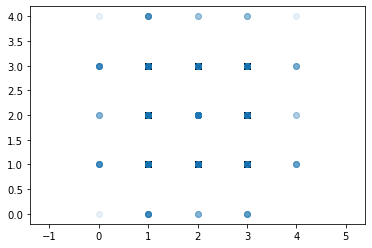

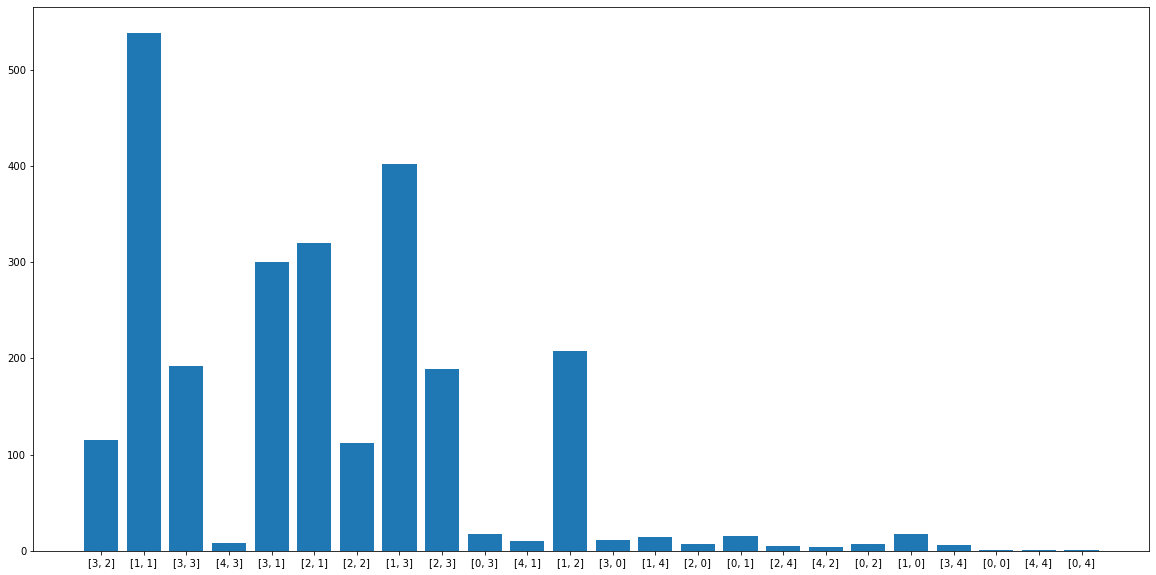

Processing Epoch 234
training start
Iteration 0, d real/fake loss 0.6486374139785767/0.6956195831298828 and g loss is 0.7148629426956177, NDiv loss 0.07734642922878265
Iteration 1, d real/fake loss 0.6489717960357666/0.7325406670570374 and g loss is 0.6916942596435547, NDiv loss 0.08134970813989639
Iteration 2, d real/fake loss 0.6493504047393799/0.6943426132202148 and g loss is 0.6963561773300171, NDiv loss 0.07947748154401779
Iteration 3, d real/fake loss 0.6497289538383484/0.7002972364425659 and g loss is 0.6862883567810059, NDiv loss 0.07133122533559799
Iteration 4, d real/fake loss 0.6501066088676453/0.70586097240448 and g loss is 0.7115392684936523, NDiv loss 0.08262110501527786


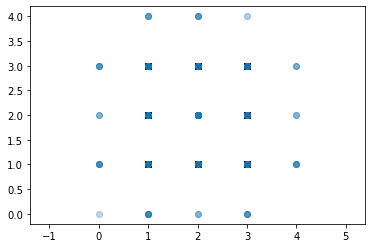

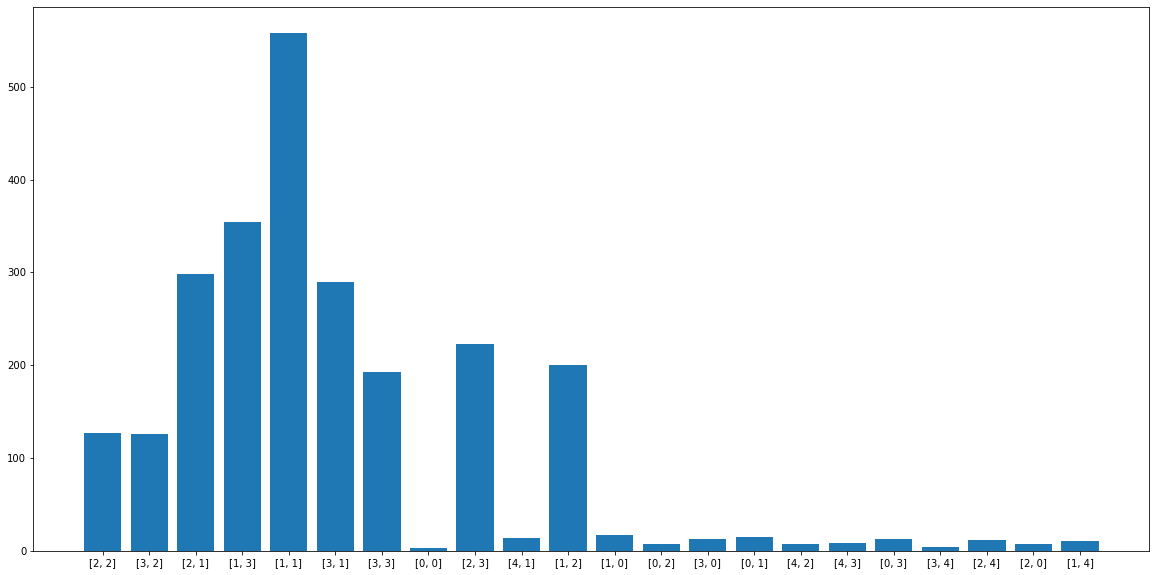

Processing Epoch 235
training start
Iteration 0, d real/fake loss 0.6788427829742432/0.7012108564376831 and g loss is 0.68829345703125, NDiv loss 0.0755821093916893
Iteration 1, d real/fake loss 0.6791366934776306/0.6998557448387146 and g loss is 0.7075012922286987, NDiv loss 0.07729589939117432
Iteration 2, d real/fake loss 0.6793939471244812/0.7105087041854858 and g loss is 0.7188940644264221, NDiv loss 0.0824170783162117
Iteration 3, d real/fake loss 0.679635226726532/0.702277660369873 and g loss is 0.7195142507553101, NDiv loss 0.08282037079334259
Iteration 4, d real/fake loss 0.679861843585968/0.7219855785369873 and g loss is 0.7000789642333984, NDiv loss 0.06687802821397781


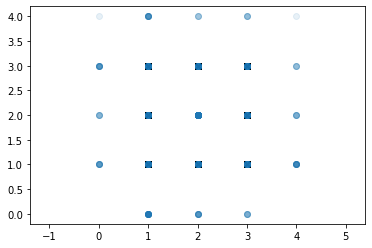

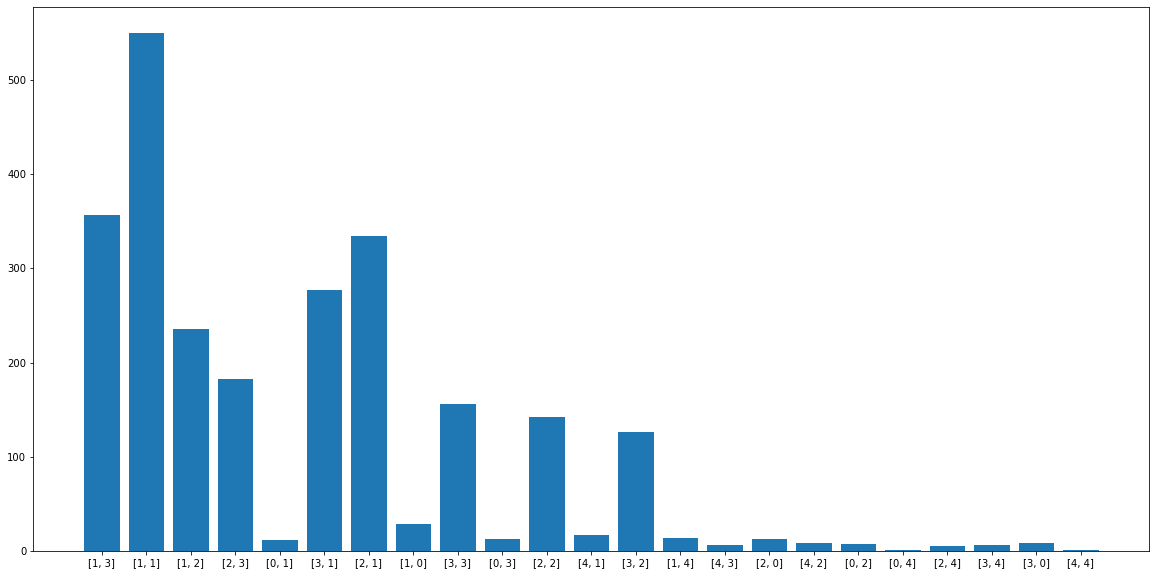

Processing Epoch 236
training start
Iteration 0, d real/fake loss 0.6689727306365967/0.6915702819824219 and g loss is 0.7197983264923096, NDiv loss 0.08862123638391495
Iteration 1, d real/fake loss 0.669273316860199/0.7177075147628784 and g loss is 0.694782018661499, NDiv loss 0.08832075446844101
Iteration 2, d real/fake loss 0.6695847511291504/0.6884743571281433 and g loss is 0.7027300596237183, NDiv loss 0.08230096101760864
Iteration 3, d real/fake loss 0.6698710918426514/0.692732572555542 and g loss is 0.6951023936271667, NDiv loss 0.08983800560235977
Iteration 4, d real/fake loss 0.6701431274414062/0.6940920352935791 and g loss is 0.7296103835105896, NDiv loss 0.07481838762760162


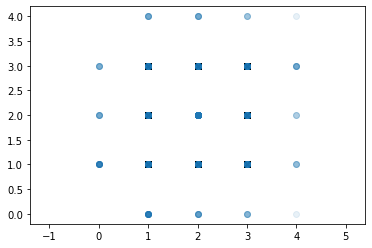

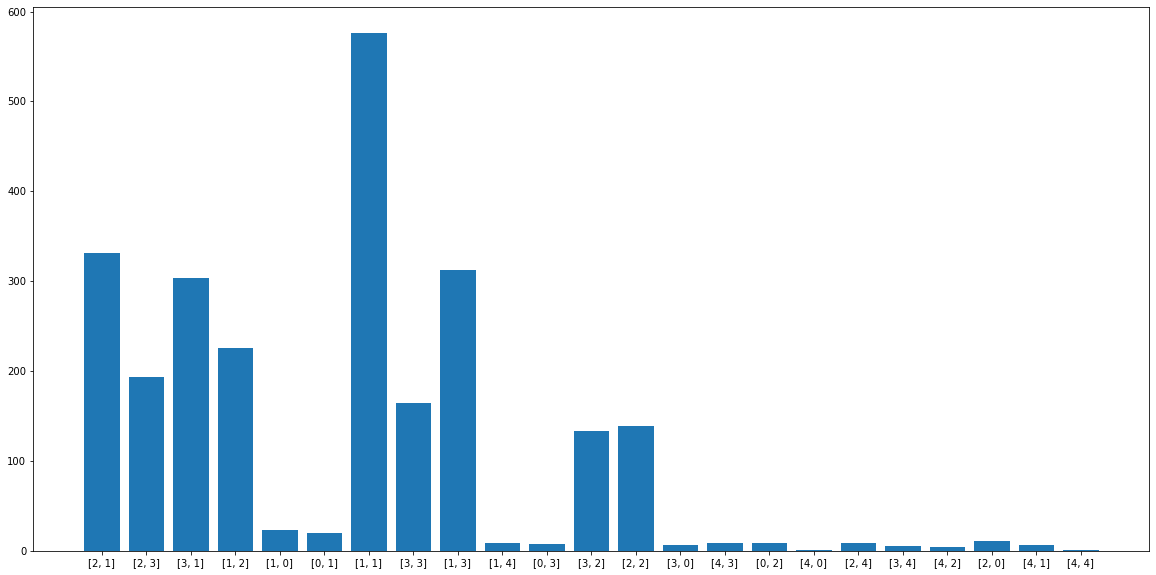

Processing Epoch 237
training start
Iteration 0, d real/fake loss 0.6689388751983643/0.6958398222923279 and g loss is 0.7011266946792603, NDiv loss 0.08526796847581863
Iteration 1, d real/fake loss 0.6692727208137512/0.7020055055618286 and g loss is 0.6867437362670898, NDiv loss 0.10206461697816849
Iteration 2, d real/fake loss 0.6695960760116577/0.7250008583068848 and g loss is 0.7094650268554688, NDiv loss 0.07569115608930588
Iteration 3, d real/fake loss 0.6699437499046326/0.7056993842124939 and g loss is 0.6834858655929565, NDiv loss 0.07750552147626877
Iteration 4, d real/fake loss 0.6702840328216553/0.7071884274482727 and g loss is 0.7170590162277222, NDiv loss 0.08353818207979202


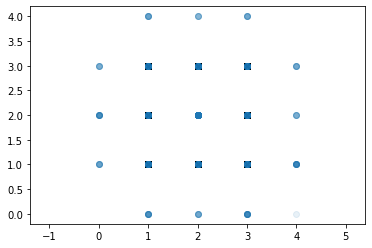

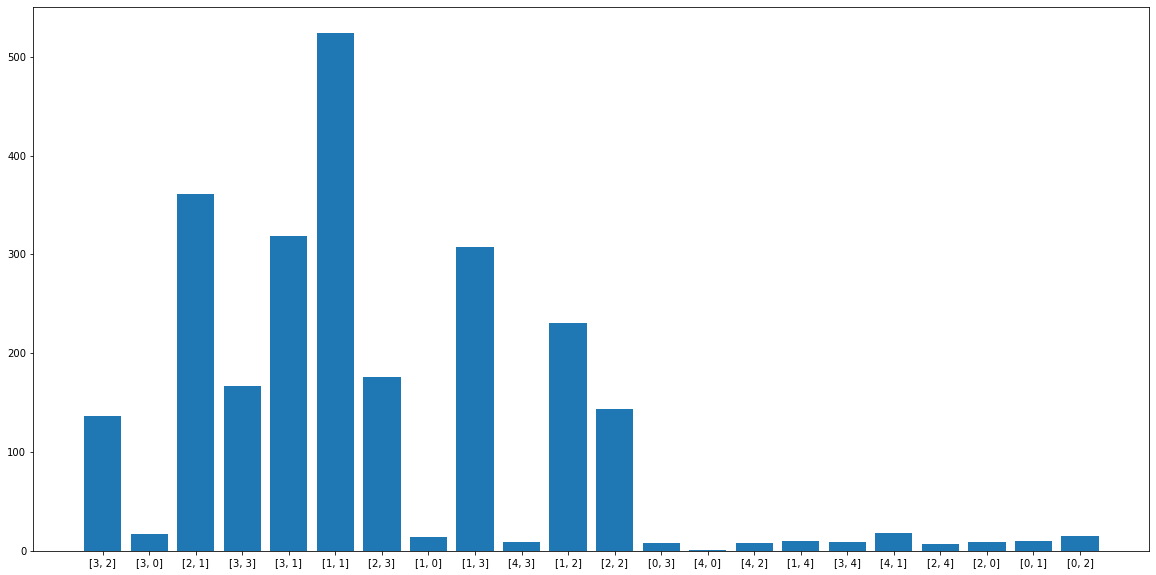

Processing Epoch 238
training start
Iteration 0, d real/fake loss 0.6685844659805298/0.6986262798309326 and g loss is 0.709757924079895, NDiv loss 0.06973201781511307
Iteration 1, d real/fake loss 0.6688076257705688/0.7068362236022949 and g loss is 0.6878641247749329, NDiv loss 0.08339747786521912
Iteration 2, d real/fake loss 0.669026792049408/0.7012519836425781 and g loss is 0.6996114253997803, NDiv loss 0.09544076770544052
Iteration 3, d real/fake loss 0.6692421436309814/0.7111016511917114 and g loss is 0.7128701210021973, NDiv loss 0.0831587016582489
Iteration 4, d real/fake loss 0.6694631576538086/0.7072133421897888 and g loss is 0.6924766302108765, NDiv loss 0.07953894138336182


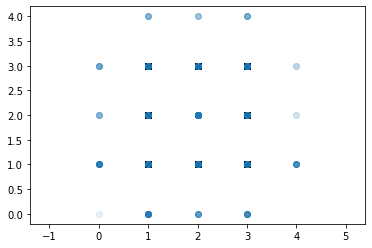

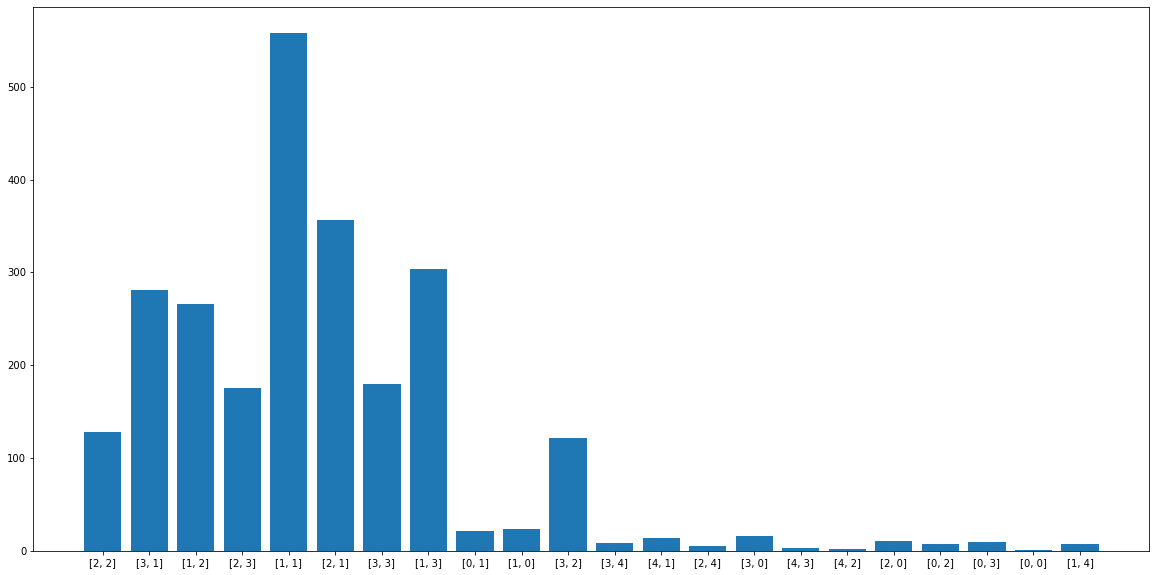

Processing Epoch 239
training start
Iteration 0, d real/fake loss 0.6854530572891235/0.7079789638519287 and g loss is 0.7164817452430725, NDiv loss 0.08370910584926605
Iteration 1, d real/fake loss 0.6856689453125/0.6763131618499756 and g loss is 0.7125829458236694, NDiv loss 0.10108243674039841
Iteration 2, d real/fake loss 0.6858376264572144/0.7109558582305908 and g loss is 0.7043076157569885, NDiv loss 0.07998187094926834
Iteration 3, d real/fake loss 0.6859992146492004/0.6956090331077576 and g loss is 0.6922525763511658, NDiv loss 0.07882443070411682
Iteration 4, d real/fake loss 0.6861446499824524/0.6839122772216797 and g loss is 0.7152130603790283, NDiv loss 0.07753829658031464


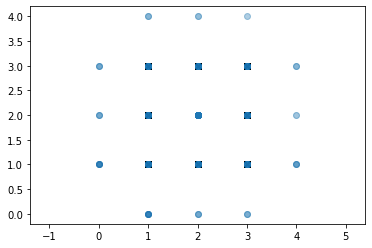

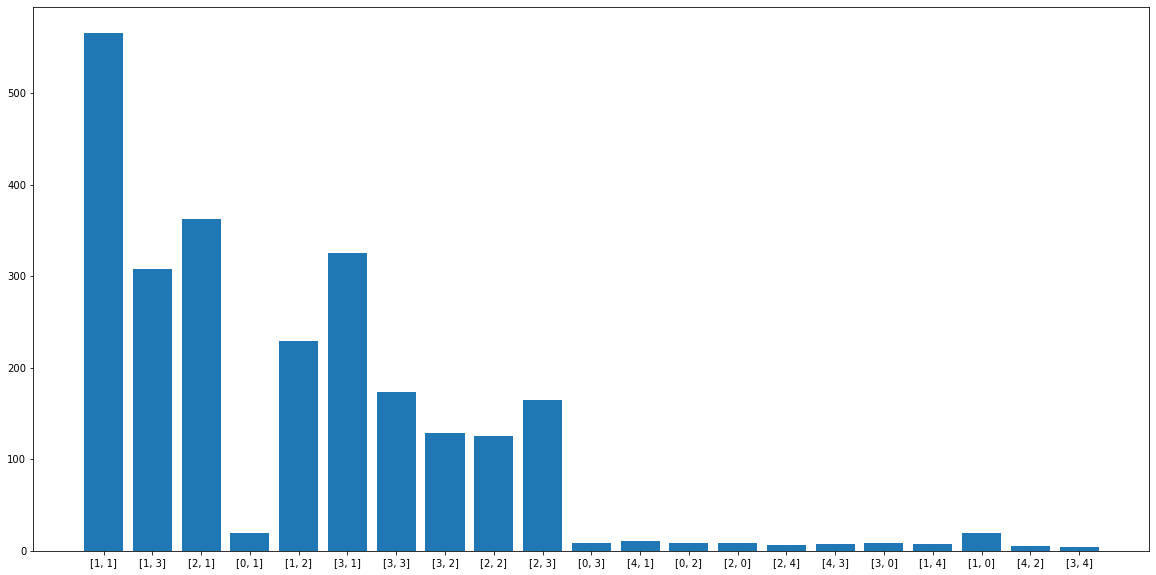

Processing Epoch 240
training start
Iteration 0, d real/fake loss 0.6801231503486633/0.7015925645828247 and g loss is 0.7007647156715393, NDiv loss 0.06554710865020752
Iteration 1, d real/fake loss 0.6803674101829529/0.6992055177688599 and g loss is 0.6966050863265991, NDiv loss 0.0770191177725792
Iteration 2, d real/fake loss 0.6805940866470337/0.7005159854888916 and g loss is 0.6985353231430054, NDiv loss 0.09520004689693451
Iteration 3, d real/fake loss 0.6808102130889893/0.699104368686676 and g loss is 0.7127101421356201, NDiv loss 0.07318674772977829
Iteration 4, d real/fake loss 0.6810153722763062/0.6787071228027344 and g loss is 0.7079281806945801, NDiv loss 0.08291387557983398


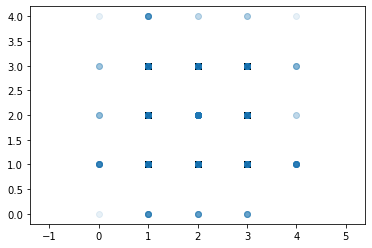

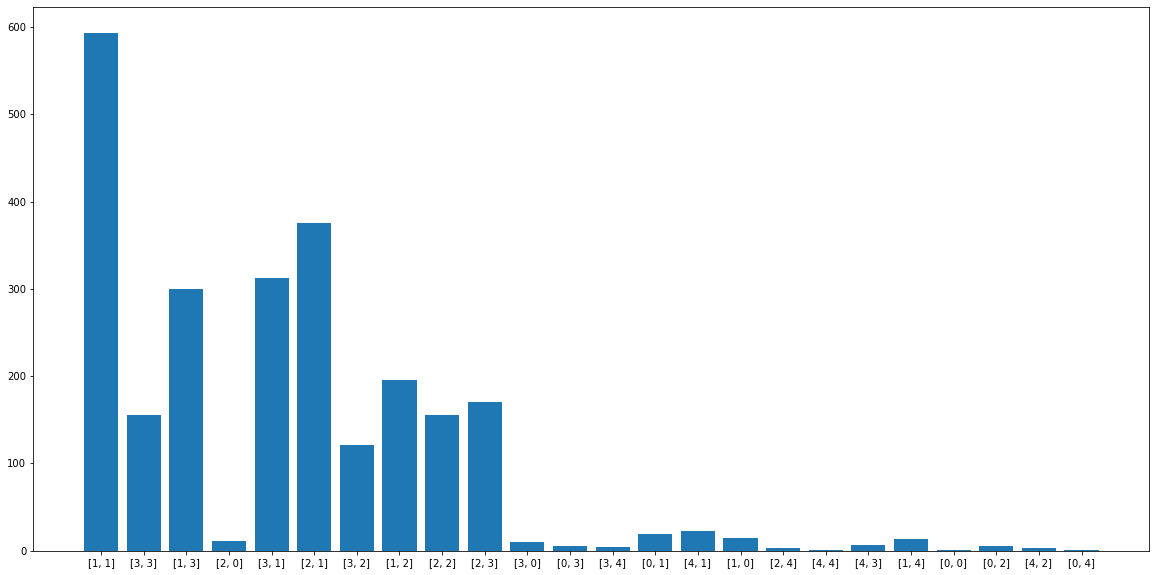

Processing Epoch 241
training start
Iteration 0, d real/fake loss 0.6842400431632996/0.7133326530456543 and g loss is 0.7032074928283691, NDiv loss 0.08292550593614578
Iteration 1, d real/fake loss 0.6844567060470581/0.7005571722984314 and g loss is 0.6987036466598511, NDiv loss 0.07093771547079086
Iteration 2, d real/fake loss 0.6846601963043213/0.6941062808036804 and g loss is 0.6901402473449707, NDiv loss 0.09733787178993225
Iteration 3, d real/fake loss 0.6848610639572144/0.6910872459411621 and g loss is 0.715712308883667, NDiv loss 0.07794415205717087
Iteration 4, d real/fake loss 0.6850478649139404/0.6914743781089783 and g loss is 0.7237493395805359, NDiv loss 0.07098082453012466


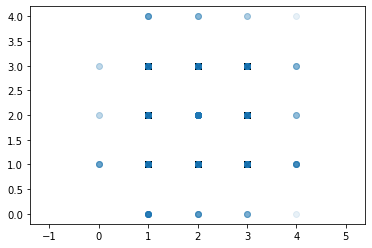

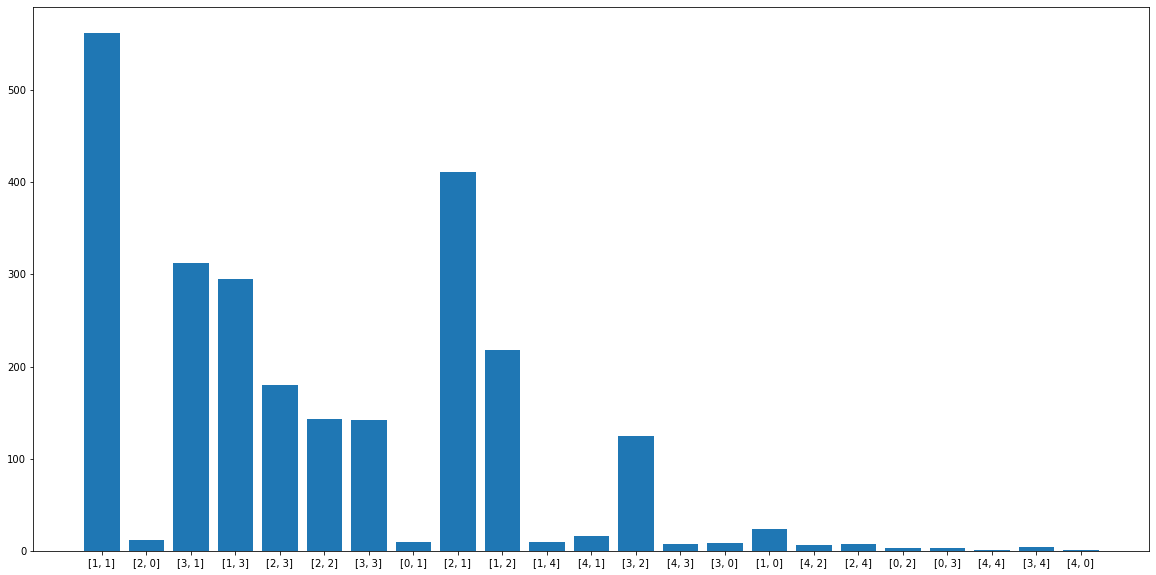

Processing Epoch 242
training start
Iteration 0, d real/fake loss 0.6698546409606934/0.7042367458343506 and g loss is 0.6962414383888245, NDiv loss 0.07481568306684494
Iteration 1, d real/fake loss 0.6700026392936707/0.7257710099220276 and g loss is 0.7158835530281067, NDiv loss 0.08313026279211044
Iteration 2, d real/fake loss 0.6701866388320923/0.7225462198257446 and g loss is 0.7142183780670166, NDiv loss 0.07839704304933548
Iteration 3, d real/fake loss 0.6704018115997314/0.7086873650550842 and g loss is 0.7130019664764404, NDiv loss 0.08842948079109192
Iteration 4, d real/fake loss 0.6706287264823914/0.701848030090332 and g loss is 0.6983749866485596, NDiv loss 0.0792376697063446


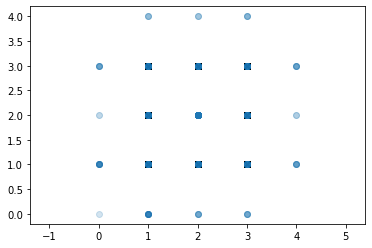

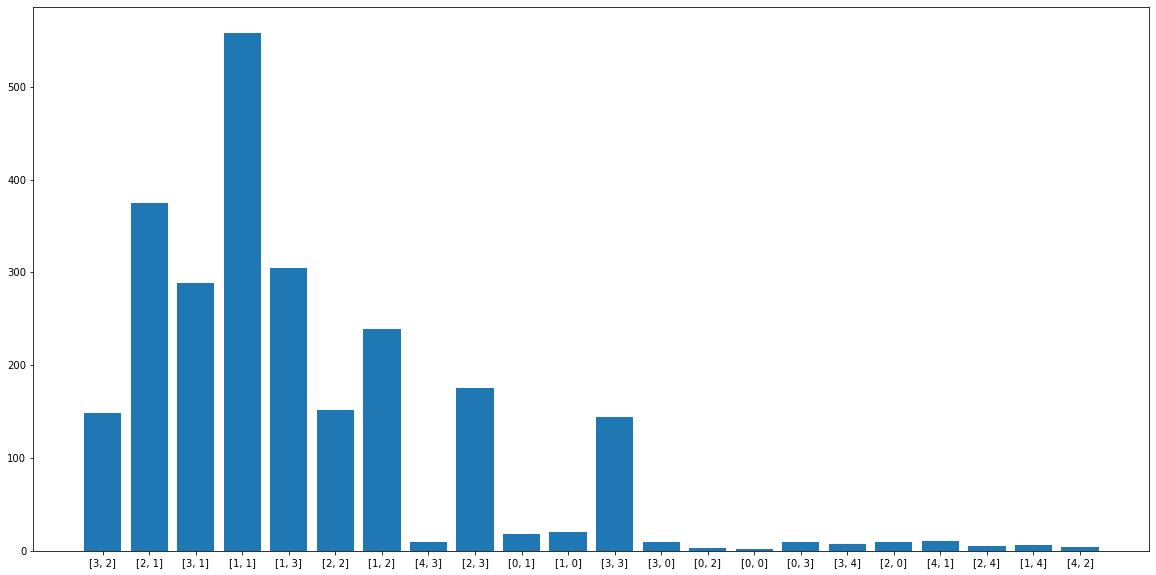

Processing Epoch 243
training start
Iteration 0, d real/fake loss 0.6850143074989319/0.692653477191925 and g loss is 0.7028371095657349, NDiv loss 0.09361288696527481
Iteration 1, d real/fake loss 0.6853169202804565/0.6915870904922485 and g loss is 0.706579327583313, NDiv loss 0.09718221426010132
Iteration 2, d real/fake loss 0.6855937838554382/0.7039080262184143 and g loss is 0.7050478458404541, NDiv loss 0.10003375262022018
Iteration 3, d real/fake loss 0.6858675479888916/0.7058054208755493 and g loss is 0.7246760129928589, NDiv loss 0.08028130978345871
Iteration 4, d real/fake loss 0.6861332654953003/0.7089101672172546 and g loss is 0.6903358697891235, NDiv loss 0.092661552131176


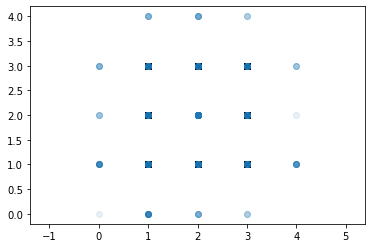

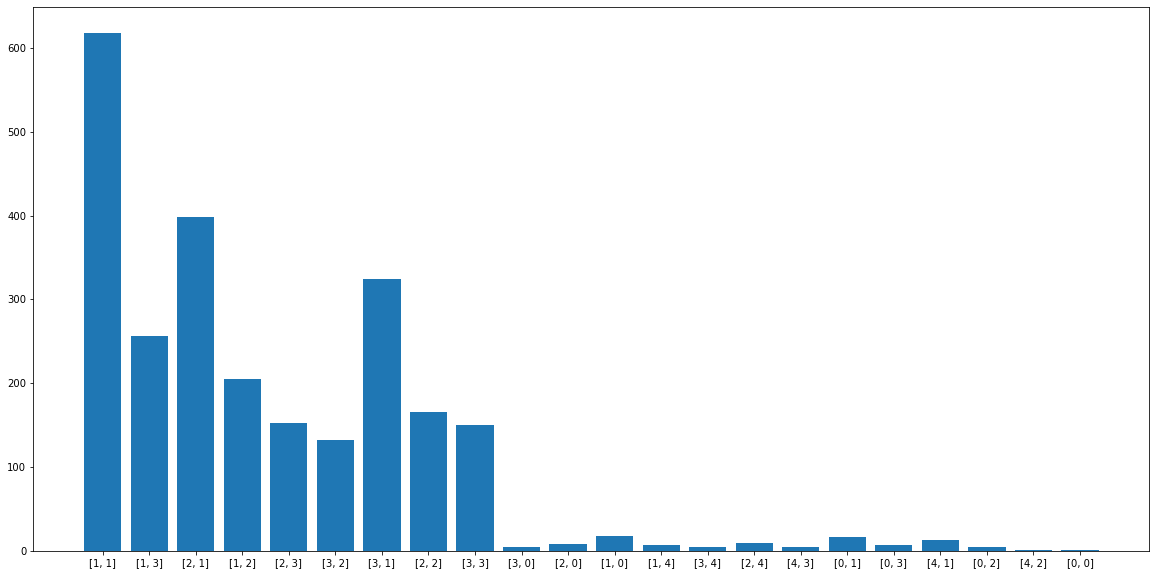

Processing Epoch 244
training start
Iteration 0, d real/fake loss 0.6810611486434937/0.7173448801040649 and g loss is 0.6973460912704468, NDiv loss 0.08452244102954865
Iteration 1, d real/fake loss 0.6812689304351807/0.7160638570785522 and g loss is 0.6928271055221558, NDiv loss 0.0873965322971344
Iteration 2, d real/fake loss 0.6814836263656616/0.6844640970230103 and g loss is 0.6873898506164551, NDiv loss 0.08663484454154968
Iteration 3, d real/fake loss 0.6816729307174683/0.7045847177505493 and g loss is 0.6939038038253784, NDiv loss 0.08679790049791336
Iteration 4, d real/fake loss 0.6818675398826599/0.7175130844116211 and g loss is 0.7176021337509155, NDiv loss 0.08821646869182587


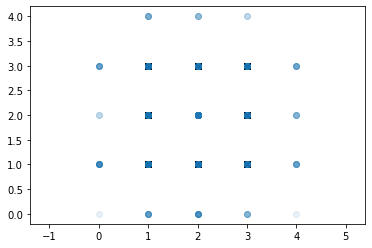

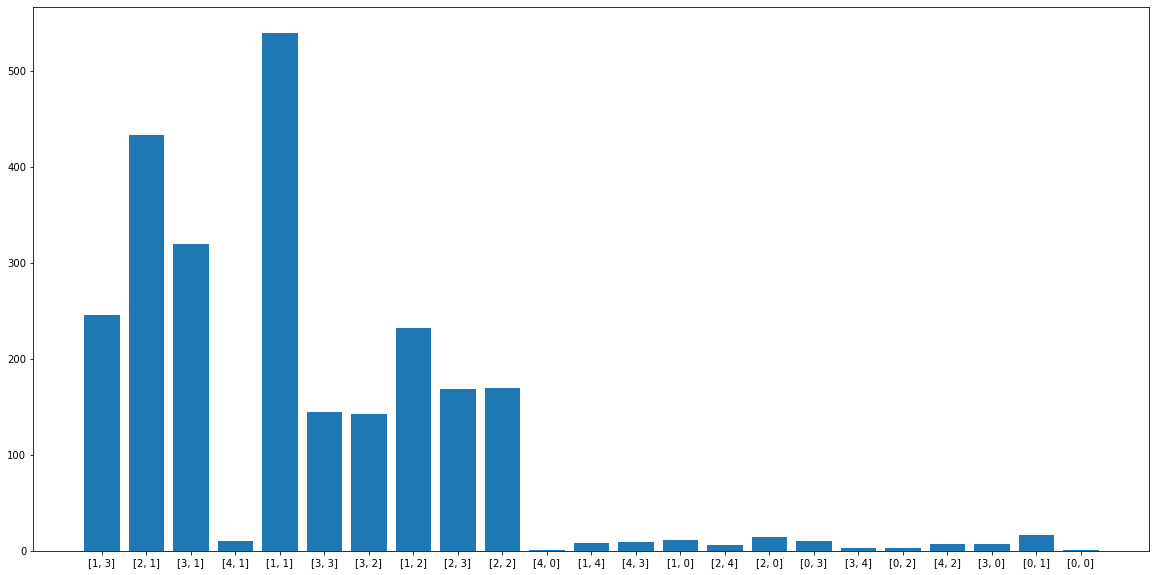

Processing Epoch 245
training start
Iteration 0, d real/fake loss 0.6840641498565674/0.6961341500282288 and g loss is 0.685565173625946, NDiv loss 0.07376491278409958
Iteration 1, d real/fake loss 0.6843529939651489/0.7074387073516846 and g loss is 0.7173705697059631, NDiv loss 0.07987229526042938
Iteration 2, d real/fake loss 0.6846415996551514/0.6918187141418457 and g loss is 0.6931468844413757, NDiv loss 0.08030910044908524
Iteration 3, d real/fake loss 0.6849090456962585/0.6808172464370728 and g loss is 0.6967837810516357, NDiv loss 0.07853136211633682
Iteration 4, d real/fake loss 0.6851495504379272/0.7084737420082092 and g loss is 0.7084539532661438, NDiv loss 0.07495645433664322


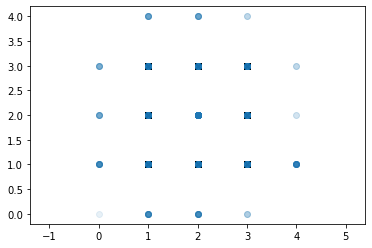

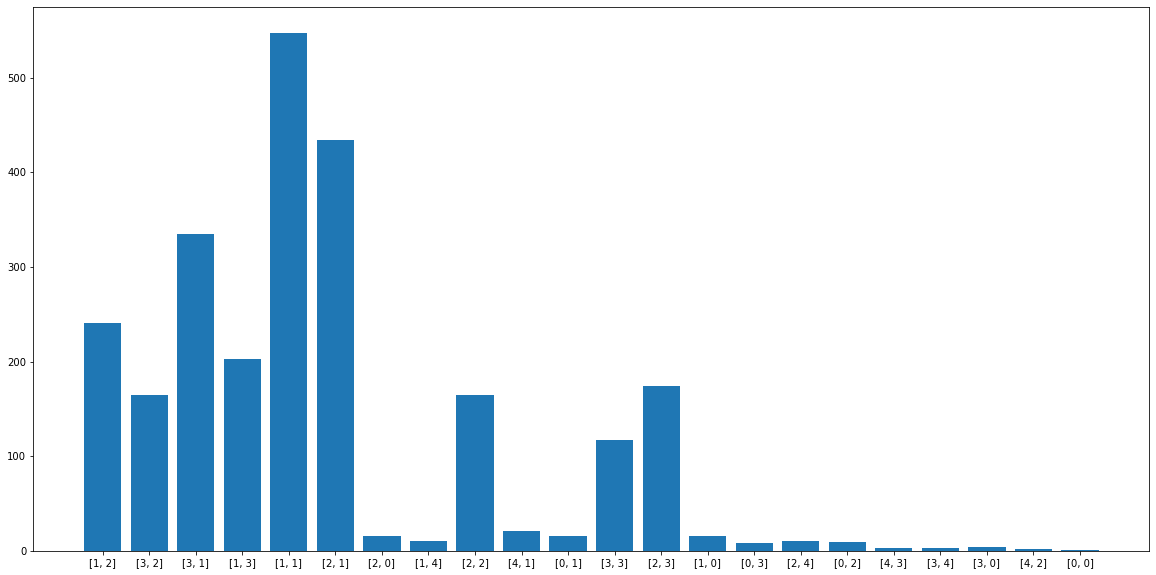

Processing Epoch 246
training start
Iteration 0, d real/fake loss 0.6933363676071167/0.710987389087677 and g loss is 0.7190868258476257, NDiv loss 0.08312695473432541
Iteration 1, d real/fake loss 0.6935301423072815/0.7104125022888184 and g loss is 0.709174633026123, NDiv loss 0.0907720997929573
Iteration 2, d real/fake loss 0.6937204003334045/0.702290952205658 and g loss is 0.6956707239151001, NDiv loss 0.08732707053422928
Iteration 3, d real/fake loss 0.6939055323600769/0.6837984323501587 and g loss is 0.6953169703483582, NDiv loss 0.08763129264116287
Iteration 4, d real/fake loss 0.6940592527389526/0.7017873525619507 and g loss is 0.7205914258956909, NDiv loss 0.08278732001781464


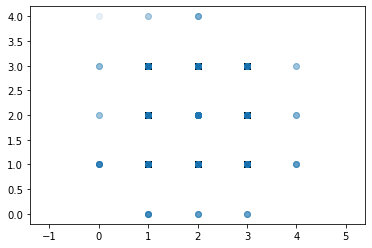

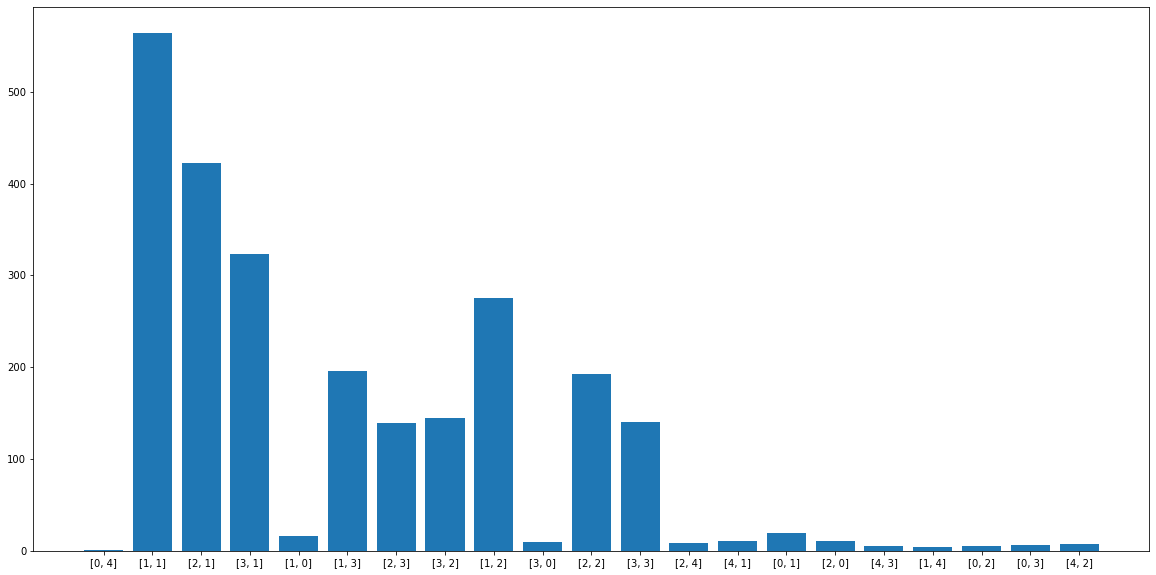

Processing Epoch 247
training start
Iteration 0, d real/fake loss 0.6909679174423218/0.702335774898529 and g loss is 0.6995677947998047, NDiv loss 0.09566030651330948
Iteration 1, d real/fake loss 0.6910750865936279/0.7113915681838989 and g loss is 0.7008081674575806, NDiv loss 0.07544059306383133
Iteration 2, d real/fake loss 0.691185474395752/0.6919913291931152 and g loss is 0.7019847631454468, NDiv loss 0.09146089851856232
Iteration 3, d real/fake loss 0.6912747025489807/0.6980679035186768 and g loss is 0.7087660431861877, NDiv loss 0.07845354825258255
Iteration 4, d real/fake loss 0.6913620233535767/0.6972794532775879 and g loss is 0.7186291217803955, NDiv loss 0.07498276978731155


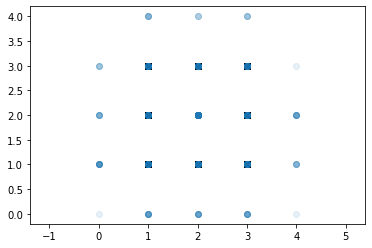

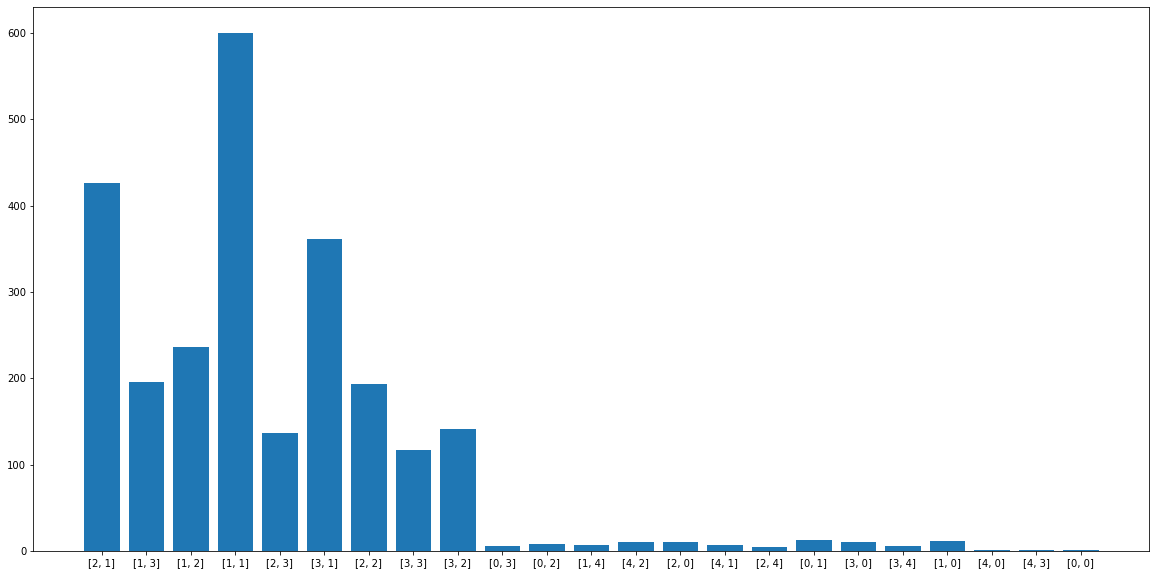

Processing Epoch 248
training start
Iteration 0, d real/fake loss 0.6863592863082886/0.7026457786560059 and g loss is 0.6942059993743896, NDiv loss 0.08927614986896515
Iteration 1, d real/fake loss 0.6865341663360596/0.7021592855453491 and g loss is 0.6980734467506409, NDiv loss 0.0849444791674614
Iteration 2, d real/fake loss 0.6866978406906128/0.6965776681900024 and g loss is 0.698312520980835, NDiv loss 0.07978909462690353
Iteration 3, d real/fake loss 0.6868441104888916/0.688880980014801 and g loss is 0.6997647881507874, NDiv loss 0.0762709528207779
Iteration 4, d real/fake loss 0.6869879961013794/0.688461184501648 and g loss is 0.7035828828811646, NDiv loss 0.08694129437208176


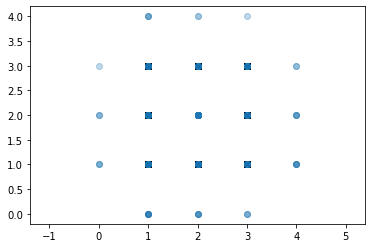

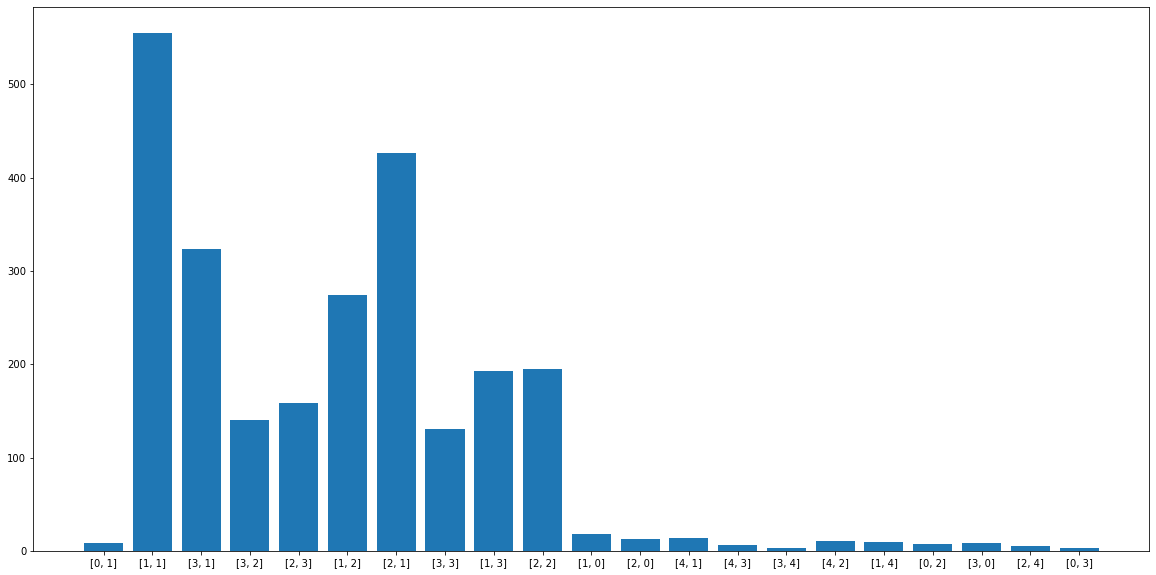

Processing Epoch 249
training start
Iteration 0, d real/fake loss 0.6872715353965759/0.702322244644165 and g loss is 0.6947634220123291, NDiv loss 0.0987970232963562
Iteration 1, d real/fake loss 0.6874241828918457/0.7017329931259155 and g loss is 0.6958690881729126, NDiv loss 0.08087959885597229
Iteration 2, d real/fake loss 0.6875838041305542/0.6984329223632812 and g loss is 0.724274754524231, NDiv loss 0.07891568541526794
Iteration 3, d real/fake loss 0.6877312064170837/0.6819195747375488 and g loss is 0.687870979309082, NDiv loss 0.07683612406253815
Iteration 4, d real/fake loss 0.6878607273101807/0.7073281407356262 and g loss is 0.7113819122314453, NDiv loss 0.09211093932390213


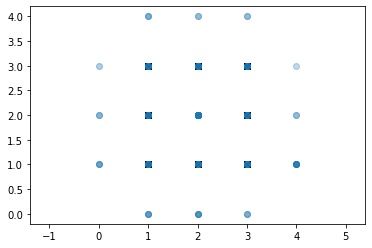

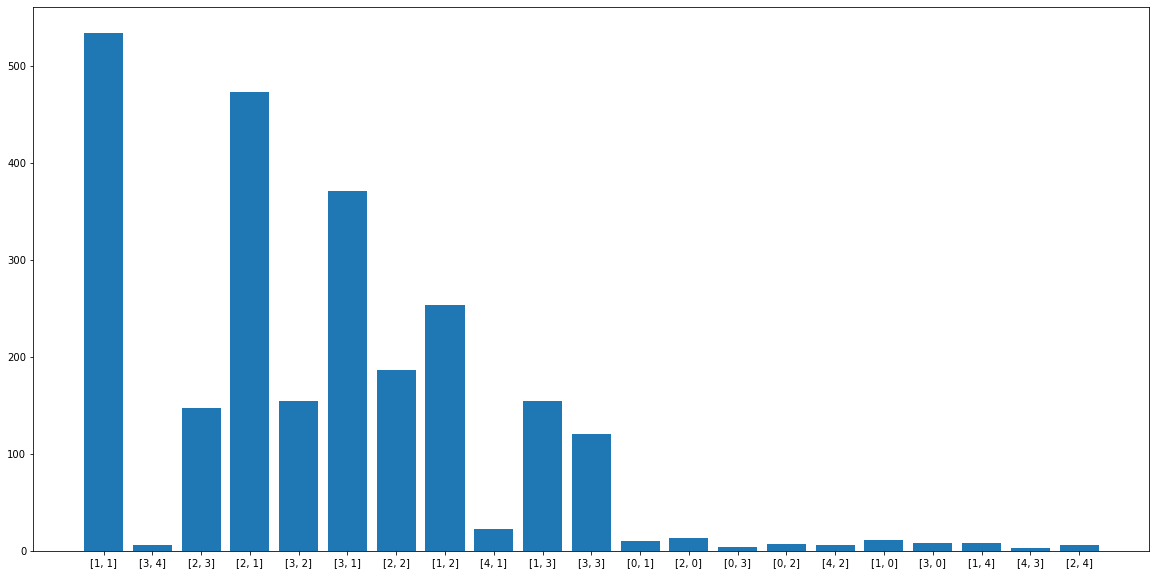

In [6]:
### Start training
for ep in range(250):
    print("Processing Epoch {}".format(ep))
    real_data = gen_real_data_onehot(dl, 128).float().cuda()
    input_data = gen_input_data(128).float().cuda()

    real_data = real_data.view(128, -1)    
    net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float().cuda()
    real_data = gen_real_data_onehot(dl, 1000).float().cuda()

#     d_fake, _ = net.g(input_data, temperature=100)
    d_fake, _ = net.g(input_data)
#     d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 1 == 0:
        plot_outputdata(real_data.data.cpu().numpy(), dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.data.cpu().numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.data.cpu().numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data]

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

Processing Epoch 0
Processing Epoch 1
Processing Epoch 2
Processing Epoch 3
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

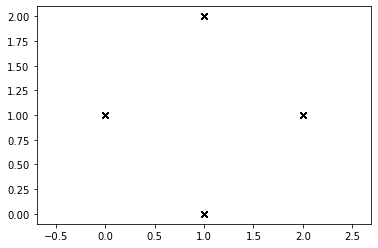

In [18]:
### Start training
for ep in range(500):
    print("Processing Epoch {}".format(ep))
#     real_data = gen_real_data_onehot(dl, 1024).float()
#     input_data = gen_input_data(1024).float()

#     real_data = real_data.view(1024, -1)    
#     net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float()
    real_data = gen_real_data_onehot(dl, 1000).float()

#     d_fake, _ = net.g(input_data, temperature=0.001)
#         d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 10 == 0:
        plot_outputdata(real_data, dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data] 

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

### Conclusion: Put Regularizer without limits would make all logits closer to 0, thus uniform noisy ~ U(0, 1)
### from gumbel reparameterization would do play a BBBBBBbig factor.
### Clearly value range (0, 0.001) would be influced greatly from U(0, 1);